In [1]:
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import sklearn.metrics as metrics

Apply the needed transformation to the data, as required by the Pytorch framework. <br/>
Then, upload the data into DataLoader objects, which will be given as inputs to the model.


In [2]:
# Source: 
# https://www.learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

# Applying Transforms to the Data. These are needed for compatibility with the pytorch implementation of the model 
image_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


# Set train and valid directory paths
train_directory = '/home/advo/PycharmProjects/ML_ND3_CapstoneProject/Dataset_small/patches/train'
valid_directory = '/home/advo/PycharmProjects/ML_ND3_CapstoneProject/Dataset_small/patches/valid'
test_directory = '/home/advo/PycharmProjects/ML_ND3_CapstoneProject/Dataset_small/patches/test'
 
# Batch size
bs = 64
 
# Number of classes
num_classes = 2
 
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}
 
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])
 
# Create iterators for the Data loaded using DataLoader module
train_data = torch.utils.data.DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = torch.utils.data.DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = torch.utils.data.DataLoader(data['test'], batch_size=bs, shuffle=True)
 
# Print the train, validation and test set data sizes
print(f"Train size: {train_data_size} \nValidation size: {valid_data_size} \nTest size: {test_data_size}") 

Train size: 151293 
Validation size: 35876 
Test size: 35659


**Visualize a single random example from each set to verify that it is correct**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class train: 0 
class valid: 0 
class test: 0


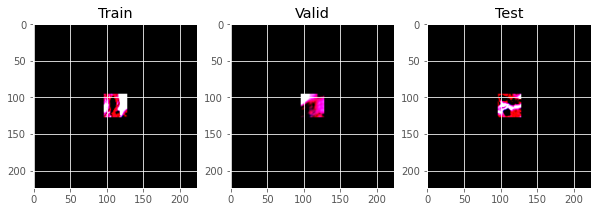

In [43]:
(img_t, label_t)=data['train'][10]
(img_v, label_v)=data['valid'][100]
(img_tst, label_tst)=data['test'][1000]
fig, ax = plt.subplots(1,3, figsize=(10,10))  # 1 row, 2 columns

ax[0].title.set_text('Train')
ax[1].title.set_text('Valid')
ax[2].title.set_text('Test')

ax[0].imshow(np.moveaxis(img_t.numpy(),0,-1))
ax[1].imshow(np.moveaxis(img_v.numpy(),0,-1))
ax[2].imshow(np.moveaxis(img_tst.numpy(),0,-1))
print(f"class train: {label_t} \nclass valid: {label_v} \nclass test: {label_tst}")

In [3]:
# Load pretrained AlexNet Model
alexnet = torchvision.models.alexnet(pretrained=True)

In [4]:
# Optional: load a pretrained DenseNet model.
densenet = torchvision.models.densenet161(pretrained=True)

In [5]:
# Select the model (alexnet/densenet)
model = alexnet

Since the model is pretrained, the parameters can be "frozen"

In [6]:
# Freeze the parameters for the pretrained part
# Source: https://pytorch.org/docs/master/notes/autograd.html
for param in model.parameters():
    param.requires_grad = False

Update the last layers of the model, in order to output only 2 classes.

In [7]:
# Note: both models must be loaded, for this to work
if model == densenet:
    
    # Update the classifier layer, in order to output the required number of classes specific to our problem
    # Note: see model.eval() for details of each layer
    model.classifier = nn.Linear(in_features=2208, out_features=num_classes, bias=True)

else:
    
    # Source: 
    # https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
    # Updating the second classifier(reduce the number of outputs, to prevent overfitting)
    model.classifier[4] = nn.Linear(4096,1024)

    # Updating the third and the last classifier that is the output layer of the network
    # Binary classification , thus only 2 output nodes
    model.classifier[6] = nn.Linear(1024, num_classes)

model_name = model.__class__.__name__
print(model_name)

AlexNet


Define loss function: Cross Entropy Loss

Note: Improvement option by adding weight class check

In [8]:
# Possible Improvement
# Source: 
# https://github.com/choosehappy/PytorchDigitalPathology/blob/master/visualization_densenet/train_densenet.ipynb

# "we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
# to avoid biasing any particular class"
# nclasses = dataset["train"].classsizes.shape[0]
# class_weight=dataset["train"].classsizes
# class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)
# print(class_weight) #show final used weights, make sure that they're reasonable before continouing


# criterion = torch.nn.CrossEntropyLoss(weight = class_weight)
criterion = nn.CrossEntropyLoss()


Define optimizer: Adam

In [9]:
# Source: 
# https://github.com/choosehappy/PytorchDigitalPathology/blob/master/visualization_densenet/train_densenet.ipynb

# adam is going to be the most robust, though perhaps not the best performing, typically a good place to start
optimizer = optim.Adam(model.parameters()) 

If GPU is available, use it. Otherwise, use the CPU.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"You are running on the following device: {device}")

You are running on the following device: cpu


**Print model and optimizer parameters before training**

In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([4096, 9216])
classifier.1.bias 	 torch.Size([4096])
classifier.4.weight 	 torch.Size([1024, 4096])
classifier.4.bias 	 torch.Size([1024])
classifier.6.weight 	 torch.Size([2, 1024])
classifier.6.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}]


In [13]:
history = []

# Initialize the variable where accuracy and loss are stored (with max/min values)
history.append([1.0, 1.0, 0.0, 0.0])
best_loss_on_val = np.Infinity

epochs = 20
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch, epochs))
    
    # Set gradient calculation to ON. Needed during training.
    torch.set_grad_enabled(True)
        
    # Set to training mode
    model.train()
    
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    # Iterate through all batches of training data
    for i, (inputs, labels) in enumerate(train_data):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        # Clean existing gradients
        optimizer.zero_grad()
         
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
                 
        # Compute loss
        loss = criterion(outputs, labels)
         
        # Backpropagate the gradients
        loss.backward()
         
        # Update the parameters
        optimizer.step()
         
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
         
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)

        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

         
        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Break "train_data batch" for loop
        # break
    
        

    # Validation is carried out in each epoch immediately after the training loop
    # Validation - No gradient calculation is needed.
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        # Iterate through all batches of validation data
        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)


            print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

            # Break "valid_data batch" for loop
            # break

    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/float(train_data_size)

    # Find average validation loss and validation accuracy
    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/float(valid_data_size)

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    epoch_end = time.time()

    print(f"Model: {model_name} \n")
    print("Epoch : {:03d} \nTraining: Loss: {:.4f}, Accuracy: {:.4f}%, \nValidation : Loss : {:.4f}, Accuracy: {:.4f}%, \nTime (train+val): {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    
    # Source: https://github.com/choosehappy/PytorchDigitalPathology/blob/master/classification_lymphoma_densenet/train_densenet.ipynb
    # If current loss is the best we've seen, save model state with all variables
    # necessary for recreation
    if avg_valid_loss < best_loss_on_val:
        best_loss_on_val = avg_valid_loss
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optimizer.state_dict(),
         'best_loss_on_val': best_loss_on_val}

        torch.save(state, f"outputs/{model_name}_best_model.pth")
        print(f"Saved model {model_name} with loss {avg_valid_loss}")
    else:
        print("")
    
    # Stop "epoch" for
    # break

Epoch: 0/20
Batch number: 000, Training: Loss: 0.7535, Accuracy: 0.4375
Batch number: 001, Training: Loss: 7.4713, Accuracy: 0.7031
Batch number: 002, Training: Loss: 5.1200, Accuracy: 0.5625
Batch number: 003, Training: Loss: 0.6759, Accuracy: 0.5938
Batch number: 004, Training: Loss: 1.7004, Accuracy: 0.3594
Batch number: 005, Training: Loss: 1.2637, Accuracy: 0.4062
Batch number: 006, Training: Loss: 0.9098, Accuracy: 0.3281
Batch number: 007, Training: Loss: 0.6554, Accuracy: 0.5938
Batch number: 008, Training: Loss: 0.7915, Accuracy: 0.5312
Batch number: 009, Training: Loss: 1.0083, Accuracy: 0.4375
Batch number: 010, Training: Loss: 0.6333, Accuracy: 0.7031
Batch number: 011, Training: Loss: 0.7580, Accuracy: 0.5781
Batch number: 012, Training: Loss: 0.6455, Accuracy: 0.6719
Batch number: 013, Training: Loss: 0.6845, Accuracy: 0.6094
Batch number: 014, Training: Loss: 0.6186, Accuracy: 0.6875
Batch number: 015, Training: Loss: 0.6401, Accuracy: 0.6406
Batch number: 016, Training:

Batch number: 137, Training: Loss: 0.4698, Accuracy: 0.7656
Batch number: 138, Training: Loss: 0.5898, Accuracy: 0.7188
Batch number: 139, Training: Loss: 0.5782, Accuracy: 0.7188
Batch number: 140, Training: Loss: 0.4554, Accuracy: 0.7656
Batch number: 141, Training: Loss: 0.5802, Accuracy: 0.7031
Batch number: 142, Training: Loss: 0.5192, Accuracy: 0.7656
Batch number: 143, Training: Loss: 0.5240, Accuracy: 0.7344
Batch number: 144, Training: Loss: 0.6877, Accuracy: 0.5938
Batch number: 145, Training: Loss: 0.6130, Accuracy: 0.6562
Batch number: 146, Training: Loss: 0.5295, Accuracy: 0.7031
Batch number: 147, Training: Loss: 0.5132, Accuracy: 0.7031
Batch number: 148, Training: Loss: 0.5469, Accuracy: 0.7656
Batch number: 149, Training: Loss: 0.6133, Accuracy: 0.7188
Batch number: 150, Training: Loss: 0.5038, Accuracy: 0.7969
Batch number: 151, Training: Loss: 0.4779, Accuracy: 0.8125
Batch number: 152, Training: Loss: 0.4310, Accuracy: 0.8281
Batch number: 153, Training: Loss: 0.535

Batch number: 274, Training: Loss: 0.4069, Accuracy: 0.8438
Batch number: 275, Training: Loss: 0.5603, Accuracy: 0.6875
Batch number: 276, Training: Loss: 0.5609, Accuracy: 0.7188
Batch number: 277, Training: Loss: 0.4122, Accuracy: 0.8438
Batch number: 278, Training: Loss: 0.5199, Accuracy: 0.7188
Batch number: 279, Training: Loss: 0.4618, Accuracy: 0.7656
Batch number: 280, Training: Loss: 0.5104, Accuracy: 0.7812
Batch number: 281, Training: Loss: 0.5800, Accuracy: 0.6875
Batch number: 282, Training: Loss: 0.5498, Accuracy: 0.6562
Batch number: 283, Training: Loss: 0.5337, Accuracy: 0.7031
Batch number: 284, Training: Loss: 0.5450, Accuracy: 0.7188
Batch number: 285, Training: Loss: 0.5186, Accuracy: 0.7344
Batch number: 286, Training: Loss: 0.5896, Accuracy: 0.6875
Batch number: 287, Training: Loss: 0.5200, Accuracy: 0.7500
Batch number: 288, Training: Loss: 0.4406, Accuracy: 0.7812
Batch number: 289, Training: Loss: 0.5616, Accuracy: 0.7031
Batch number: 290, Training: Loss: 0.501

Batch number: 411, Training: Loss: 0.5179, Accuracy: 0.7500
Batch number: 412, Training: Loss: 0.4710, Accuracy: 0.7500
Batch number: 413, Training: Loss: 0.5418, Accuracy: 0.7344
Batch number: 414, Training: Loss: 0.5546, Accuracy: 0.6875
Batch number: 415, Training: Loss: 0.6379, Accuracy: 0.6562
Batch number: 416, Training: Loss: 0.3574, Accuracy: 0.8750
Batch number: 417, Training: Loss: 0.6284, Accuracy: 0.7031
Batch number: 418, Training: Loss: 0.5511, Accuracy: 0.7344
Batch number: 419, Training: Loss: 0.5112, Accuracy: 0.7656
Batch number: 420, Training: Loss: 0.5005, Accuracy: 0.7969
Batch number: 421, Training: Loss: 0.4730, Accuracy: 0.7031
Batch number: 422, Training: Loss: 0.5905, Accuracy: 0.7188
Batch number: 423, Training: Loss: 0.5677, Accuracy: 0.6719
Batch number: 424, Training: Loss: 0.4927, Accuracy: 0.7656
Batch number: 425, Training: Loss: 0.5654, Accuracy: 0.7188
Batch number: 426, Training: Loss: 0.4314, Accuracy: 0.8281
Batch number: 427, Training: Loss: 0.387

Batch number: 548, Training: Loss: 0.5055, Accuracy: 0.7188
Batch number: 549, Training: Loss: 0.4817, Accuracy: 0.7656
Batch number: 550, Training: Loss: 0.4793, Accuracy: 0.7188
Batch number: 551, Training: Loss: 0.3460, Accuracy: 0.8750
Batch number: 552, Training: Loss: 0.4897, Accuracy: 0.7969
Batch number: 553, Training: Loss: 0.6784, Accuracy: 0.6875
Batch number: 554, Training: Loss: 0.6134, Accuracy: 0.7188
Batch number: 555, Training: Loss: 0.5925, Accuracy: 0.6875
Batch number: 556, Training: Loss: 0.4155, Accuracy: 0.8125
Batch number: 557, Training: Loss: 0.5344, Accuracy: 0.7344
Batch number: 558, Training: Loss: 0.4938, Accuracy: 0.7969
Batch number: 559, Training: Loss: 0.4537, Accuracy: 0.7969
Batch number: 560, Training: Loss: 0.6064, Accuracy: 0.7031
Batch number: 561, Training: Loss: 0.4945, Accuracy: 0.7500
Batch number: 562, Training: Loss: 0.5262, Accuracy: 0.7500
Batch number: 563, Training: Loss: 0.4135, Accuracy: 0.8125
Batch number: 564, Training: Loss: 0.465

Batch number: 685, Training: Loss: 0.5506, Accuracy: 0.7344
Batch number: 686, Training: Loss: 0.4294, Accuracy: 0.8438
Batch number: 687, Training: Loss: 0.4386, Accuracy: 0.7812
Batch number: 688, Training: Loss: 0.4738, Accuracy: 0.7812
Batch number: 689, Training: Loss: 0.4945, Accuracy: 0.7812
Batch number: 690, Training: Loss: 0.5467, Accuracy: 0.7656
Batch number: 691, Training: Loss: 0.4087, Accuracy: 0.8281
Batch number: 692, Training: Loss: 0.6188, Accuracy: 0.6719
Batch number: 693, Training: Loss: 0.5419, Accuracy: 0.7500
Batch number: 694, Training: Loss: 0.5981, Accuracy: 0.6562
Batch number: 695, Training: Loss: 0.4369, Accuracy: 0.7969
Batch number: 696, Training: Loss: 0.4990, Accuracy: 0.7812
Batch number: 697, Training: Loss: 0.5045, Accuracy: 0.7344
Batch number: 698, Training: Loss: 0.3962, Accuracy: 0.8125
Batch number: 699, Training: Loss: 0.3819, Accuracy: 0.7969
Batch number: 700, Training: Loss: 0.4946, Accuracy: 0.7656
Batch number: 701, Training: Loss: 0.574

Batch number: 822, Training: Loss: 0.4163, Accuracy: 0.8281
Batch number: 823, Training: Loss: 0.4954, Accuracy: 0.7969
Batch number: 824, Training: Loss: 0.5331, Accuracy: 0.7500
Batch number: 825, Training: Loss: 0.4889, Accuracy: 0.7500
Batch number: 826, Training: Loss: 0.4447, Accuracy: 0.8281
Batch number: 827, Training: Loss: 0.5512, Accuracy: 0.7188
Batch number: 828, Training: Loss: 0.5351, Accuracy: 0.7500
Batch number: 829, Training: Loss: 0.5160, Accuracy: 0.7031
Batch number: 830, Training: Loss: 0.3674, Accuracy: 0.8594
Batch number: 831, Training: Loss: 0.4696, Accuracy: 0.7188
Batch number: 832, Training: Loss: 0.5716, Accuracy: 0.7656
Batch number: 833, Training: Loss: 0.4492, Accuracy: 0.7656
Batch number: 834, Training: Loss: 0.6389, Accuracy: 0.7031
Batch number: 835, Training: Loss: 0.4594, Accuracy: 0.7969
Batch number: 836, Training: Loss: 0.5258, Accuracy: 0.7344
Batch number: 837, Training: Loss: 0.4320, Accuracy: 0.8125
Batch number: 838, Training: Loss: 0.607

Batch number: 959, Training: Loss: 0.4961, Accuracy: 0.7344
Batch number: 960, Training: Loss: 0.4877, Accuracy: 0.7969
Batch number: 961, Training: Loss: 0.3935, Accuracy: 0.8125
Batch number: 962, Training: Loss: 0.4767, Accuracy: 0.8125
Batch number: 963, Training: Loss: 0.4096, Accuracy: 0.8125
Batch number: 964, Training: Loss: 0.6058, Accuracy: 0.6875
Batch number: 965, Training: Loss: 0.3860, Accuracy: 0.8281
Batch number: 966, Training: Loss: 0.4417, Accuracy: 0.8438
Batch number: 967, Training: Loss: 0.5324, Accuracy: 0.7031
Batch number: 968, Training: Loss: 0.5148, Accuracy: 0.7656
Batch number: 969, Training: Loss: 0.6616, Accuracy: 0.6250
Batch number: 970, Training: Loss: 0.4370, Accuracy: 0.8125
Batch number: 971, Training: Loss: 0.4879, Accuracy: 0.8125
Batch number: 972, Training: Loss: 0.5672, Accuracy: 0.7500
Batch number: 973, Training: Loss: 0.4190, Accuracy: 0.7969
Batch number: 974, Training: Loss: 0.4849, Accuracy: 0.7344
Batch number: 975, Training: Loss: 0.454

Batch number: 1094, Training: Loss: 0.4677, Accuracy: 0.7969
Batch number: 1095, Training: Loss: 0.5507, Accuracy: 0.6875
Batch number: 1096, Training: Loss: 0.5882, Accuracy: 0.7031
Batch number: 1097, Training: Loss: 0.4858, Accuracy: 0.7969
Batch number: 1098, Training: Loss: 0.4953, Accuracy: 0.7188
Batch number: 1099, Training: Loss: 0.5941, Accuracy: 0.7188
Batch number: 1100, Training: Loss: 0.4281, Accuracy: 0.8594
Batch number: 1101, Training: Loss: 0.5348, Accuracy: 0.7188
Batch number: 1102, Training: Loss: 0.5353, Accuracy: 0.7344
Batch number: 1103, Training: Loss: 0.4976, Accuracy: 0.7344
Batch number: 1104, Training: Loss: 0.5761, Accuracy: 0.7188
Batch number: 1105, Training: Loss: 0.5519, Accuracy: 0.7656
Batch number: 1106, Training: Loss: 0.5003, Accuracy: 0.7812
Batch number: 1107, Training: Loss: 0.5294, Accuracy: 0.7031
Batch number: 1108, Training: Loss: 0.4526, Accuracy: 0.7969
Batch number: 1109, Training: Loss: 0.5414, Accuracy: 0.7031
Batch number: 1110, Trai

Batch number: 1229, Training: Loss: 0.4588, Accuracy: 0.7656
Batch number: 1230, Training: Loss: 0.4695, Accuracy: 0.7969
Batch number: 1231, Training: Loss: 0.5084, Accuracy: 0.7500
Batch number: 1232, Training: Loss: 0.4976, Accuracy: 0.7969
Batch number: 1233, Training: Loss: 0.3857, Accuracy: 0.8281
Batch number: 1234, Training: Loss: 0.4258, Accuracy: 0.7500
Batch number: 1235, Training: Loss: 0.4973, Accuracy: 0.8125
Batch number: 1236, Training: Loss: 0.5190, Accuracy: 0.7188
Batch number: 1237, Training: Loss: 0.4193, Accuracy: 0.8438
Batch number: 1238, Training: Loss: 0.5368, Accuracy: 0.7500
Batch number: 1239, Training: Loss: 0.4437, Accuracy: 0.7969
Batch number: 1240, Training: Loss: 0.4099, Accuracy: 0.8281
Batch number: 1241, Training: Loss: 0.4511, Accuracy: 0.8281
Batch number: 1242, Training: Loss: 0.5246, Accuracy: 0.7188
Batch number: 1243, Training: Loss: 0.4783, Accuracy: 0.7969
Batch number: 1244, Training: Loss: 0.3674, Accuracy: 0.8125
Batch number: 1245, Trai

Batch number: 1364, Training: Loss: 0.4672, Accuracy: 0.7656
Batch number: 1365, Training: Loss: 0.5486, Accuracy: 0.7344
Batch number: 1366, Training: Loss: 0.3277, Accuracy: 0.8750
Batch number: 1367, Training: Loss: 0.5173, Accuracy: 0.8125
Batch number: 1368, Training: Loss: 0.5337, Accuracy: 0.7656
Batch number: 1369, Training: Loss: 0.5592, Accuracy: 0.7188
Batch number: 1370, Training: Loss: 0.5285, Accuracy: 0.7031
Batch number: 1371, Training: Loss: 0.5197, Accuracy: 0.7812
Batch number: 1372, Training: Loss: 0.3908, Accuracy: 0.8125
Batch number: 1373, Training: Loss: 0.5066, Accuracy: 0.7031
Batch number: 1374, Training: Loss: 0.4516, Accuracy: 0.7656
Batch number: 1375, Training: Loss: 0.4615, Accuracy: 0.7344
Batch number: 1376, Training: Loss: 0.5425, Accuracy: 0.7031
Batch number: 1377, Training: Loss: 0.4945, Accuracy: 0.7812
Batch number: 1378, Training: Loss: 0.4832, Accuracy: 0.7969
Batch number: 1379, Training: Loss: 0.4473, Accuracy: 0.8125
Batch number: 1380, Trai

Batch number: 1499, Training: Loss: 0.5672, Accuracy: 0.7031
Batch number: 1500, Training: Loss: 0.3714, Accuracy: 0.8594
Batch number: 1501, Training: Loss: 0.4777, Accuracy: 0.7656
Batch number: 1502, Training: Loss: 0.4848, Accuracy: 0.7969
Batch number: 1503, Training: Loss: 0.4645, Accuracy: 0.8125
Batch number: 1504, Training: Loss: 0.5713, Accuracy: 0.7500
Batch number: 1505, Training: Loss: 0.4792, Accuracy: 0.7812
Batch number: 1506, Training: Loss: 0.3993, Accuracy: 0.8438
Batch number: 1507, Training: Loss: 0.4945, Accuracy: 0.7500
Batch number: 1508, Training: Loss: 0.5387, Accuracy: 0.7344
Batch number: 1509, Training: Loss: 0.4803, Accuracy: 0.7812
Batch number: 1510, Training: Loss: 0.5609, Accuracy: 0.7344
Batch number: 1511, Training: Loss: 0.5263, Accuracy: 0.7344
Batch number: 1512, Training: Loss: 0.4813, Accuracy: 0.7500
Batch number: 1513, Training: Loss: 0.4467, Accuracy: 0.7969
Batch number: 1514, Training: Loss: 0.5148, Accuracy: 0.7344
Batch number: 1515, Trai

Batch number: 1634, Training: Loss: 0.4395, Accuracy: 0.7812
Batch number: 1635, Training: Loss: 0.4491, Accuracy: 0.8125
Batch number: 1636, Training: Loss: 0.5005, Accuracy: 0.7031
Batch number: 1637, Training: Loss: 0.4283, Accuracy: 0.7500
Batch number: 1638, Training: Loss: 0.5668, Accuracy: 0.7500
Batch number: 1639, Training: Loss: 0.4418, Accuracy: 0.8125
Batch number: 1640, Training: Loss: 0.4929, Accuracy: 0.7344
Batch number: 1641, Training: Loss: 0.4222, Accuracy: 0.7969
Batch number: 1642, Training: Loss: 0.5296, Accuracy: 0.7031
Batch number: 1643, Training: Loss: 0.7251, Accuracy: 0.5938
Batch number: 1644, Training: Loss: 0.5230, Accuracy: 0.7656
Batch number: 1645, Training: Loss: 0.4716, Accuracy: 0.7969
Batch number: 1646, Training: Loss: 0.4222, Accuracy: 0.8438
Batch number: 1647, Training: Loss: 0.6300, Accuracy: 0.6250
Batch number: 1648, Training: Loss: 0.5105, Accuracy: 0.7188
Batch number: 1649, Training: Loss: 0.4323, Accuracy: 0.7812
Batch number: 1650, Trai

Batch number: 1769, Training: Loss: 0.5718, Accuracy: 0.7344
Batch number: 1770, Training: Loss: 0.4304, Accuracy: 0.8125
Batch number: 1771, Training: Loss: 0.5642, Accuracy: 0.7500
Batch number: 1772, Training: Loss: 0.6026, Accuracy: 0.7031
Batch number: 1773, Training: Loss: 0.5073, Accuracy: 0.7344
Batch number: 1774, Training: Loss: 0.4073, Accuracy: 0.8125
Batch number: 1775, Training: Loss: 0.5921, Accuracy: 0.7031
Batch number: 1776, Training: Loss: 0.3883, Accuracy: 0.8281
Batch number: 1777, Training: Loss: 0.3058, Accuracy: 0.9219
Batch number: 1778, Training: Loss: 0.4232, Accuracy: 0.7969
Batch number: 1779, Training: Loss: 0.4181, Accuracy: 0.8125
Batch number: 1780, Training: Loss: 0.4113, Accuracy: 0.8750
Batch number: 1781, Training: Loss: 0.4931, Accuracy: 0.7500
Batch number: 1782, Training: Loss: 0.4955, Accuracy: 0.7656
Batch number: 1783, Training: Loss: 0.4393, Accuracy: 0.7500
Batch number: 1784, Training: Loss: 0.4823, Accuracy: 0.7969
Batch number: 1785, Trai

Batch number: 1904, Training: Loss: 0.3544, Accuracy: 0.8750
Batch number: 1905, Training: Loss: 0.3970, Accuracy: 0.8281
Batch number: 1906, Training: Loss: 0.3917, Accuracy: 0.8750
Batch number: 1907, Training: Loss: 0.4399, Accuracy: 0.7969
Batch number: 1908, Training: Loss: 0.4042, Accuracy: 0.8125
Batch number: 1909, Training: Loss: 0.5651, Accuracy: 0.7031
Batch number: 1910, Training: Loss: 0.6700, Accuracy: 0.7031
Batch number: 1911, Training: Loss: 0.5675, Accuracy: 0.7031
Batch number: 1912, Training: Loss: 0.4203, Accuracy: 0.7656
Batch number: 1913, Training: Loss: 0.4460, Accuracy: 0.7969
Batch number: 1914, Training: Loss: 0.5687, Accuracy: 0.7031
Batch number: 1915, Training: Loss: 0.4377, Accuracy: 0.7812
Batch number: 1916, Training: Loss: 0.6500, Accuracy: 0.6562
Batch number: 1917, Training: Loss: 0.4941, Accuracy: 0.7188
Batch number: 1918, Training: Loss: 0.5110, Accuracy: 0.7656
Batch number: 1919, Training: Loss: 0.5674, Accuracy: 0.7500
Batch number: 1920, Trai

Batch number: 2039, Training: Loss: 0.4815, Accuracy: 0.7656
Batch number: 2040, Training: Loss: 0.5512, Accuracy: 0.7031
Batch number: 2041, Training: Loss: 0.5087, Accuracy: 0.7969
Batch number: 2042, Training: Loss: 0.4458, Accuracy: 0.7344
Batch number: 2043, Training: Loss: 0.5540, Accuracy: 0.7031
Batch number: 2044, Training: Loss: 0.5131, Accuracy: 0.7812
Batch number: 2045, Training: Loss: 0.3775, Accuracy: 0.8438
Batch number: 2046, Training: Loss: 0.5032, Accuracy: 0.7188
Batch number: 2047, Training: Loss: 0.5600, Accuracy: 0.7188
Batch number: 2048, Training: Loss: 0.3740, Accuracy: 0.8281
Batch number: 2049, Training: Loss: 0.4717, Accuracy: 0.7812
Batch number: 2050, Training: Loss: 0.4610, Accuracy: 0.7656
Batch number: 2051, Training: Loss: 0.4376, Accuracy: 0.7500
Batch number: 2052, Training: Loss: 0.3922, Accuracy: 0.8125
Batch number: 2053, Training: Loss: 0.4200, Accuracy: 0.7969
Batch number: 2054, Training: Loss: 0.4517, Accuracy: 0.8125
Batch number: 2055, Trai

Batch number: 2174, Training: Loss: 0.4868, Accuracy: 0.7812
Batch number: 2175, Training: Loss: 0.5774, Accuracy: 0.6875
Batch number: 2176, Training: Loss: 0.5479, Accuracy: 0.8125
Batch number: 2177, Training: Loss: 0.5334, Accuracy: 0.7344
Batch number: 2178, Training: Loss: 0.3758, Accuracy: 0.8438
Batch number: 2179, Training: Loss: 0.4440, Accuracy: 0.8750
Batch number: 2180, Training: Loss: 0.4997, Accuracy: 0.7500
Batch number: 2181, Training: Loss: 0.5724, Accuracy: 0.6719
Batch number: 2182, Training: Loss: 0.3937, Accuracy: 0.8594
Batch number: 2183, Training: Loss: 0.5262, Accuracy: 0.7812
Batch number: 2184, Training: Loss: 0.4979, Accuracy: 0.7500
Batch number: 2185, Training: Loss: 0.4435, Accuracy: 0.7812
Batch number: 2186, Training: Loss: 0.4852, Accuracy: 0.7344
Batch number: 2187, Training: Loss: 0.5150, Accuracy: 0.7500
Batch number: 2188, Training: Loss: 0.5132, Accuracy: 0.7344
Batch number: 2189, Training: Loss: 0.5481, Accuracy: 0.6875
Batch number: 2190, Trai

Batch number: 2309, Training: Loss: 0.4983, Accuracy: 0.7344
Batch number: 2310, Training: Loss: 0.4205, Accuracy: 0.8438
Batch number: 2311, Training: Loss: 0.4202, Accuracy: 0.8281
Batch number: 2312, Training: Loss: 0.5649, Accuracy: 0.7656
Batch number: 2313, Training: Loss: 0.4182, Accuracy: 0.7656
Batch number: 2314, Training: Loss: 0.4815, Accuracy: 0.7656
Batch number: 2315, Training: Loss: 0.5609, Accuracy: 0.7500
Batch number: 2316, Training: Loss: 0.6077, Accuracy: 0.7031
Batch number: 2317, Training: Loss: 0.4132, Accuracy: 0.8125
Batch number: 2318, Training: Loss: 0.3552, Accuracy: 0.8281
Batch number: 2319, Training: Loss: 0.6023, Accuracy: 0.6875
Batch number: 2320, Training: Loss: 0.5163, Accuracy: 0.7656
Batch number: 2321, Training: Loss: 0.4249, Accuracy: 0.8125
Batch number: 2322, Training: Loss: 0.3829, Accuracy: 0.8125
Batch number: 2323, Training: Loss: 0.4669, Accuracy: 0.8125
Batch number: 2324, Training: Loss: 0.5328, Accuracy: 0.7188
Batch number: 2325, Trai

Validation Batch number: 067, Validation: Loss: 0.2869, Accuracy: 0.9531
Validation Batch number: 068, Validation: Loss: 0.3761, Accuracy: 0.8750
Validation Batch number: 069, Validation: Loss: 0.3344, Accuracy: 0.9219
Validation Batch number: 070, Validation: Loss: 0.2850, Accuracy: 0.9062
Validation Batch number: 071, Validation: Loss: 0.4163, Accuracy: 0.8594
Validation Batch number: 072, Validation: Loss: 0.3224, Accuracy: 0.8750
Validation Batch number: 073, Validation: Loss: 0.3429, Accuracy: 0.8906
Validation Batch number: 074, Validation: Loss: 0.3012, Accuracy: 0.9062
Validation Batch number: 075, Validation: Loss: 0.3504, Accuracy: 0.9219
Validation Batch number: 076, Validation: Loss: 0.4302, Accuracy: 0.8750
Validation Batch number: 077, Validation: Loss: 0.4268, Accuracy: 0.7969
Validation Batch number: 078, Validation: Loss: 0.3676, Accuracy: 0.8750
Validation Batch number: 079, Validation: Loss: 0.3964, Accuracy: 0.8438
Validation Batch number: 080, Validation: Loss: 0.4

Validation Batch number: 180, Validation: Loss: 0.3183, Accuracy: 0.9062
Validation Batch number: 181, Validation: Loss: 0.3222, Accuracy: 0.8750
Validation Batch number: 182, Validation: Loss: 0.3648, Accuracy: 0.8438
Validation Batch number: 183, Validation: Loss: 0.4057, Accuracy: 0.8125
Validation Batch number: 184, Validation: Loss: 0.2979, Accuracy: 0.9531
Validation Batch number: 185, Validation: Loss: 0.3978, Accuracy: 0.8281
Validation Batch number: 186, Validation: Loss: 0.3260, Accuracy: 0.8438
Validation Batch number: 187, Validation: Loss: 0.3707, Accuracy: 0.8750
Validation Batch number: 188, Validation: Loss: 0.4052, Accuracy: 0.8125
Validation Batch number: 189, Validation: Loss: 0.3578, Accuracy: 0.8750
Validation Batch number: 190, Validation: Loss: 0.4205, Accuracy: 0.7969
Validation Batch number: 191, Validation: Loss: 0.3828, Accuracy: 0.9062
Validation Batch number: 192, Validation: Loss: 0.4578, Accuracy: 0.7812
Validation Batch number: 193, Validation: Loss: 0.3

Validation Batch number: 293, Validation: Loss: 0.2870, Accuracy: 0.9219
Validation Batch number: 294, Validation: Loss: 0.4076, Accuracy: 0.8281
Validation Batch number: 295, Validation: Loss: 0.3904, Accuracy: 0.7812
Validation Batch number: 296, Validation: Loss: 0.3697, Accuracy: 0.8438
Validation Batch number: 297, Validation: Loss: 0.4203, Accuracy: 0.8438
Validation Batch number: 298, Validation: Loss: 0.3690, Accuracy: 0.8594
Validation Batch number: 299, Validation: Loss: 0.4407, Accuracy: 0.7812
Validation Batch number: 300, Validation: Loss: 0.3643, Accuracy: 0.8594
Validation Batch number: 301, Validation: Loss: 0.3445, Accuracy: 0.9375
Validation Batch number: 302, Validation: Loss: 0.4512, Accuracy: 0.7969
Validation Batch number: 303, Validation: Loss: 0.4105, Accuracy: 0.8281
Validation Batch number: 304, Validation: Loss: 0.4078, Accuracy: 0.8281
Validation Batch number: 305, Validation: Loss: 0.3516, Accuracy: 0.8906
Validation Batch number: 306, Validation: Loss: 0.3

Validation Batch number: 406, Validation: Loss: 0.3730, Accuracy: 0.8281
Validation Batch number: 407, Validation: Loss: 0.3647, Accuracy: 0.8438
Validation Batch number: 408, Validation: Loss: 0.3794, Accuracy: 0.8438
Validation Batch number: 409, Validation: Loss: 0.3914, Accuracy: 0.8125
Validation Batch number: 410, Validation: Loss: 0.3110, Accuracy: 0.9531
Validation Batch number: 411, Validation: Loss: 0.2941, Accuracy: 0.9531
Validation Batch number: 412, Validation: Loss: 0.3479, Accuracy: 0.9062
Validation Batch number: 413, Validation: Loss: 0.3704, Accuracy: 0.8594
Validation Batch number: 414, Validation: Loss: 0.3491, Accuracy: 0.8906
Validation Batch number: 415, Validation: Loss: 0.3599, Accuracy: 0.8750
Validation Batch number: 416, Validation: Loss: 0.5141, Accuracy: 0.7812
Validation Batch number: 417, Validation: Loss: 0.3750, Accuracy: 0.8281
Validation Batch number: 418, Validation: Loss: 0.3218, Accuracy: 0.9375
Validation Batch number: 419, Validation: Loss: 0.4

Validation Batch number: 519, Validation: Loss: 0.3821, Accuracy: 0.8750
Validation Batch number: 520, Validation: Loss: 0.3812, Accuracy: 0.8594
Validation Batch number: 521, Validation: Loss: 0.3772, Accuracy: 0.8750
Validation Batch number: 522, Validation: Loss: 0.3446, Accuracy: 0.8750
Validation Batch number: 523, Validation: Loss: 0.3180, Accuracy: 0.9062
Validation Batch number: 524, Validation: Loss: 0.3104, Accuracy: 0.9219
Validation Batch number: 525, Validation: Loss: 0.3339, Accuracy: 0.8906
Validation Batch number: 526, Validation: Loss: 0.3836, Accuracy: 0.8594
Validation Batch number: 527, Validation: Loss: 0.4307, Accuracy: 0.7656
Validation Batch number: 528, Validation: Loss: 0.3897, Accuracy: 0.8594
Validation Batch number: 529, Validation: Loss: 0.3621, Accuracy: 0.8438
Validation Batch number: 530, Validation: Loss: 0.3666, Accuracy: 0.8594
Validation Batch number: 531, Validation: Loss: 0.4445, Accuracy: 0.7969
Validation Batch number: 532, Validation: Loss: 0.4

Batch number: 082, Training: Loss: 0.3696, Accuracy: 0.8594
Batch number: 083, Training: Loss: 0.5443, Accuracy: 0.7188
Batch number: 084, Training: Loss: 0.5182, Accuracy: 0.7344
Batch number: 085, Training: Loss: 0.4560, Accuracy: 0.7969
Batch number: 086, Training: Loss: 0.4541, Accuracy: 0.8125
Batch number: 087, Training: Loss: 0.4875, Accuracy: 0.7656
Batch number: 088, Training: Loss: 0.4758, Accuracy: 0.7500
Batch number: 089, Training: Loss: 0.5066, Accuracy: 0.7500
Batch number: 090, Training: Loss: 0.4030, Accuracy: 0.8125
Batch number: 091, Training: Loss: 0.4701, Accuracy: 0.7500
Batch number: 092, Training: Loss: 0.5065, Accuracy: 0.7188
Batch number: 093, Training: Loss: 0.5295, Accuracy: 0.7188
Batch number: 094, Training: Loss: 0.4696, Accuracy: 0.7656
Batch number: 095, Training: Loss: 0.4601, Accuracy: 0.8125
Batch number: 096, Training: Loss: 0.6393, Accuracy: 0.6875
Batch number: 097, Training: Loss: 0.4089, Accuracy: 0.8594
Batch number: 098, Training: Loss: 0.543

Batch number: 219, Training: Loss: 0.4870, Accuracy: 0.7656
Batch number: 220, Training: Loss: 0.5020, Accuracy: 0.7344
Batch number: 221, Training: Loss: 0.6215, Accuracy: 0.7031
Batch number: 222, Training: Loss: 0.5887, Accuracy: 0.7188
Batch number: 223, Training: Loss: 0.4339, Accuracy: 0.7656
Batch number: 224, Training: Loss: 0.3900, Accuracy: 0.7812
Batch number: 225, Training: Loss: 0.4972, Accuracy: 0.7500
Batch number: 226, Training: Loss: 0.4533, Accuracy: 0.7812
Batch number: 227, Training: Loss: 0.4429, Accuracy: 0.8438
Batch number: 228, Training: Loss: 0.3706, Accuracy: 0.7969
Batch number: 229, Training: Loss: 0.4328, Accuracy: 0.7656
Batch number: 230, Training: Loss: 0.5489, Accuracy: 0.7344
Batch number: 231, Training: Loss: 0.4422, Accuracy: 0.8125
Batch number: 232, Training: Loss: 0.5614, Accuracy: 0.7500
Batch number: 233, Training: Loss: 0.4329, Accuracy: 0.7812
Batch number: 234, Training: Loss: 0.4500, Accuracy: 0.7500
Batch number: 235, Training: Loss: 0.408

Batch number: 356, Training: Loss: 0.4480, Accuracy: 0.8125
Batch number: 357, Training: Loss: 0.5149, Accuracy: 0.7344
Batch number: 358, Training: Loss: 0.3540, Accuracy: 0.8438
Batch number: 359, Training: Loss: 0.5517, Accuracy: 0.7188
Batch number: 360, Training: Loss: 0.4952, Accuracy: 0.7656
Batch number: 361, Training: Loss: 0.6052, Accuracy: 0.7031
Batch number: 362, Training: Loss: 0.4689, Accuracy: 0.7656
Batch number: 363, Training: Loss: 0.5225, Accuracy: 0.7031
Batch number: 364, Training: Loss: 0.5561, Accuracy: 0.7188
Batch number: 365, Training: Loss: 0.5312, Accuracy: 0.7500
Batch number: 366, Training: Loss: 0.5268, Accuracy: 0.6875
Batch number: 367, Training: Loss: 0.6026, Accuracy: 0.7031
Batch number: 368, Training: Loss: 0.4783, Accuracy: 0.7500
Batch number: 369, Training: Loss: 0.4432, Accuracy: 0.7969
Batch number: 370, Training: Loss: 0.4806, Accuracy: 0.7656
Batch number: 371, Training: Loss: 0.3983, Accuracy: 0.8594
Batch number: 372, Training: Loss: 0.438

Batch number: 493, Training: Loss: 0.4966, Accuracy: 0.7812
Batch number: 494, Training: Loss: 0.5239, Accuracy: 0.6562
Batch number: 495, Training: Loss: 0.3871, Accuracy: 0.8438
Batch number: 496, Training: Loss: 0.4757, Accuracy: 0.8281
Batch number: 497, Training: Loss: 0.4979, Accuracy: 0.7344
Batch number: 498, Training: Loss: 0.5013, Accuracy: 0.7656
Batch number: 499, Training: Loss: 0.3441, Accuracy: 0.8438
Batch number: 500, Training: Loss: 0.4438, Accuracy: 0.8125
Batch number: 501, Training: Loss: 0.4408, Accuracy: 0.7969
Batch number: 502, Training: Loss: 0.5625, Accuracy: 0.7344
Batch number: 503, Training: Loss: 0.5845, Accuracy: 0.7344
Batch number: 504, Training: Loss: 0.3662, Accuracy: 0.8438
Batch number: 505, Training: Loss: 0.4426, Accuracy: 0.7969
Batch number: 506, Training: Loss: 0.4670, Accuracy: 0.7812
Batch number: 507, Training: Loss: 0.4021, Accuracy: 0.8438
Batch number: 508, Training: Loss: 0.4156, Accuracy: 0.8125
Batch number: 509, Training: Loss: 0.437

Batch number: 630, Training: Loss: 0.2981, Accuracy: 0.9062
Batch number: 631, Training: Loss: 0.5903, Accuracy: 0.7188
Batch number: 632, Training: Loss: 0.4784, Accuracy: 0.7656
Batch number: 633, Training: Loss: 0.5047, Accuracy: 0.7344
Batch number: 634, Training: Loss: 0.4751, Accuracy: 0.7656
Batch number: 635, Training: Loss: 0.4155, Accuracy: 0.8281
Batch number: 636, Training: Loss: 0.4168, Accuracy: 0.7812
Batch number: 637, Training: Loss: 0.5021, Accuracy: 0.7031
Batch number: 638, Training: Loss: 0.4033, Accuracy: 0.8281
Batch number: 639, Training: Loss: 0.3926, Accuracy: 0.8594
Batch number: 640, Training: Loss: 0.5295, Accuracy: 0.7656
Batch number: 641, Training: Loss: 0.4661, Accuracy: 0.8281
Batch number: 642, Training: Loss: 0.4599, Accuracy: 0.7969
Batch number: 643, Training: Loss: 0.4992, Accuracy: 0.7344
Batch number: 644, Training: Loss: 0.5259, Accuracy: 0.7656
Batch number: 645, Training: Loss: 0.4085, Accuracy: 0.8281
Batch number: 646, Training: Loss: 0.395

Batch number: 767, Training: Loss: 0.4347, Accuracy: 0.8281
Batch number: 768, Training: Loss: 0.5006, Accuracy: 0.7812
Batch number: 769, Training: Loss: 0.4412, Accuracy: 0.7812
Batch number: 770, Training: Loss: 0.4668, Accuracy: 0.7812
Batch number: 771, Training: Loss: 0.4635, Accuracy: 0.7656
Batch number: 772, Training: Loss: 0.5602, Accuracy: 0.6875
Batch number: 773, Training: Loss: 0.3952, Accuracy: 0.8281
Batch number: 774, Training: Loss: 0.5427, Accuracy: 0.7344
Batch number: 775, Training: Loss: 0.4716, Accuracy: 0.7188
Batch number: 776, Training: Loss: 0.4451, Accuracy: 0.8281
Batch number: 777, Training: Loss: 0.5329, Accuracy: 0.7031
Batch number: 778, Training: Loss: 0.5177, Accuracy: 0.7188
Batch number: 779, Training: Loss: 0.5349, Accuracy: 0.6875
Batch number: 780, Training: Loss: 0.4776, Accuracy: 0.7812
Batch number: 781, Training: Loss: 0.4600, Accuracy: 0.7812
Batch number: 782, Training: Loss: 0.3761, Accuracy: 0.8594
Batch number: 783, Training: Loss: 0.566

Batch number: 904, Training: Loss: 0.5590, Accuracy: 0.7031
Batch number: 905, Training: Loss: 0.4649, Accuracy: 0.7188
Batch number: 906, Training: Loss: 0.5200, Accuracy: 0.7969
Batch number: 907, Training: Loss: 0.4446, Accuracy: 0.7656
Batch number: 908, Training: Loss: 0.4327, Accuracy: 0.7969
Batch number: 909, Training: Loss: 0.4917, Accuracy: 0.7812
Batch number: 910, Training: Loss: 0.4683, Accuracy: 0.7188
Batch number: 911, Training: Loss: 0.4353, Accuracy: 0.7656
Batch number: 912, Training: Loss: 0.4795, Accuracy: 0.7812
Batch number: 913, Training: Loss: 0.3342, Accuracy: 0.8906
Batch number: 914, Training: Loss: 0.5432, Accuracy: 0.6875
Batch number: 915, Training: Loss: 0.3613, Accuracy: 0.8906
Batch number: 916, Training: Loss: 0.4311, Accuracy: 0.8125
Batch number: 917, Training: Loss: 0.3784, Accuracy: 0.8125
Batch number: 918, Training: Loss: 0.4353, Accuracy: 0.7812
Batch number: 919, Training: Loss: 0.4410, Accuracy: 0.7969
Batch number: 920, Training: Loss: 0.432

Batch number: 1040, Training: Loss: 0.5098, Accuracy: 0.7656
Batch number: 1041, Training: Loss: 0.4043, Accuracy: 0.8594
Batch number: 1042, Training: Loss: 0.3940, Accuracy: 0.8125
Batch number: 1043, Training: Loss: 0.4875, Accuracy: 0.7969
Batch number: 1044, Training: Loss: 0.4756, Accuracy: 0.8438
Batch number: 1045, Training: Loss: 0.5175, Accuracy: 0.7812
Batch number: 1046, Training: Loss: 0.5052, Accuracy: 0.7500
Batch number: 1047, Training: Loss: 0.5425, Accuracy: 0.7344
Batch number: 1048, Training: Loss: 0.3688, Accuracy: 0.8438
Batch number: 1049, Training: Loss: 0.3569, Accuracy: 0.8594
Batch number: 1050, Training: Loss: 0.4295, Accuracy: 0.8125
Batch number: 1051, Training: Loss: 0.5058, Accuracy: 0.7656
Batch number: 1052, Training: Loss: 0.5494, Accuracy: 0.7500
Batch number: 1053, Training: Loss: 0.5300, Accuracy: 0.7656
Batch number: 1054, Training: Loss: 0.4304, Accuracy: 0.8281
Batch number: 1055, Training: Loss: 0.6529, Accuracy: 0.6094
Batch number: 1056, Trai

Batch number: 1175, Training: Loss: 0.4765, Accuracy: 0.8125
Batch number: 1176, Training: Loss: 0.4401, Accuracy: 0.7969
Batch number: 1177, Training: Loss: 0.4491, Accuracy: 0.7656
Batch number: 1178, Training: Loss: 0.4834, Accuracy: 0.7812
Batch number: 1179, Training: Loss: 0.4733, Accuracy: 0.7812
Batch number: 1180, Training: Loss: 0.5223, Accuracy: 0.7969
Batch number: 1181, Training: Loss: 0.4994, Accuracy: 0.7656
Batch number: 1182, Training: Loss: 0.4580, Accuracy: 0.7969
Batch number: 1183, Training: Loss: 0.5601, Accuracy: 0.6875
Batch number: 1184, Training: Loss: 0.3243, Accuracy: 0.8906
Batch number: 1185, Training: Loss: 0.4338, Accuracy: 0.8125
Batch number: 1186, Training: Loss: 0.4528, Accuracy: 0.7656
Batch number: 1187, Training: Loss: 0.4322, Accuracy: 0.8125
Batch number: 1188, Training: Loss: 0.4484, Accuracy: 0.7656
Batch number: 1189, Training: Loss: 0.3605, Accuracy: 0.8438
Batch number: 1190, Training: Loss: 0.5237, Accuracy: 0.7500
Batch number: 1191, Trai

Batch number: 1310, Training: Loss: 0.3527, Accuracy: 0.8438
Batch number: 1311, Training: Loss: 0.3535, Accuracy: 0.9062
Batch number: 1312, Training: Loss: 0.4634, Accuracy: 0.7656
Batch number: 1313, Training: Loss: 0.4123, Accuracy: 0.8438
Batch number: 1314, Training: Loss: 0.5123, Accuracy: 0.7344
Batch number: 1315, Training: Loss: 0.5326, Accuracy: 0.7344
Batch number: 1316, Training: Loss: 0.4715, Accuracy: 0.7656
Batch number: 1317, Training: Loss: 0.4208, Accuracy: 0.7656
Batch number: 1318, Training: Loss: 0.4977, Accuracy: 0.7500
Batch number: 1319, Training: Loss: 0.4685, Accuracy: 0.7500
Batch number: 1320, Training: Loss: 0.5045, Accuracy: 0.7812
Batch number: 1321, Training: Loss: 0.3747, Accuracy: 0.8281
Batch number: 1322, Training: Loss: 0.5430, Accuracy: 0.7656
Batch number: 1323, Training: Loss: 0.4272, Accuracy: 0.8281
Batch number: 1324, Training: Loss: 0.4594, Accuracy: 0.7969
Batch number: 1325, Training: Loss: 0.4317, Accuracy: 0.8594
Batch number: 1326, Trai

Batch number: 1445, Training: Loss: 0.4887, Accuracy: 0.7344
Batch number: 1446, Training: Loss: 0.4594, Accuracy: 0.8125
Batch number: 1447, Training: Loss: 0.5151, Accuracy: 0.7656
Batch number: 1448, Training: Loss: 0.4144, Accuracy: 0.8438
Batch number: 1449, Training: Loss: 0.4489, Accuracy: 0.7812
Batch number: 1450, Training: Loss: 0.4891, Accuracy: 0.7969
Batch number: 1451, Training: Loss: 0.4310, Accuracy: 0.8125
Batch number: 1452, Training: Loss: 0.5470, Accuracy: 0.7344
Batch number: 1453, Training: Loss: 0.5193, Accuracy: 0.8125
Batch number: 1454, Training: Loss: 0.4953, Accuracy: 0.7344
Batch number: 1455, Training: Loss: 0.4569, Accuracy: 0.8281
Batch number: 1456, Training: Loss: 0.4840, Accuracy: 0.7656
Batch number: 1457, Training: Loss: 0.4587, Accuracy: 0.8125
Batch number: 1458, Training: Loss: 0.5332, Accuracy: 0.7812
Batch number: 1459, Training: Loss: 0.3983, Accuracy: 0.7812
Batch number: 1460, Training: Loss: 0.5271, Accuracy: 0.7344
Batch number: 1461, Trai

Batch number: 1580, Training: Loss: 0.3770, Accuracy: 0.8750
Batch number: 1581, Training: Loss: 0.4937, Accuracy: 0.7188
Batch number: 1582, Training: Loss: 0.4681, Accuracy: 0.7188
Batch number: 1583, Training: Loss: 0.4828, Accuracy: 0.7812
Batch number: 1584, Training: Loss: 0.4721, Accuracy: 0.8125
Batch number: 1585, Training: Loss: 0.4850, Accuracy: 0.8125
Batch number: 1586, Training: Loss: 0.4787, Accuracy: 0.7500
Batch number: 1587, Training: Loss: 0.3978, Accuracy: 0.8281
Batch number: 1588, Training: Loss: 0.4865, Accuracy: 0.7812
Batch number: 1589, Training: Loss: 0.5575, Accuracy: 0.7344
Batch number: 1590, Training: Loss: 0.4919, Accuracy: 0.7656
Batch number: 1591, Training: Loss: 0.3746, Accuracy: 0.7969
Batch number: 1592, Training: Loss: 0.4045, Accuracy: 0.8125
Batch number: 1593, Training: Loss: 0.6670, Accuracy: 0.7500
Batch number: 1594, Training: Loss: 0.4068, Accuracy: 0.7969
Batch number: 1595, Training: Loss: 0.5051, Accuracy: 0.7031
Batch number: 1596, Trai

Batch number: 1715, Training: Loss: 0.5329, Accuracy: 0.6875
Batch number: 1716, Training: Loss: 0.4471, Accuracy: 0.7812
Batch number: 1717, Training: Loss: 0.4566, Accuracy: 0.8125
Batch number: 1718, Training: Loss: 0.5271, Accuracy: 0.7188
Batch number: 1719, Training: Loss: 0.3499, Accuracy: 0.8750
Batch number: 1720, Training: Loss: 0.4036, Accuracy: 0.8594
Batch number: 1721, Training: Loss: 0.4014, Accuracy: 0.7812
Batch number: 1722, Training: Loss: 0.5673, Accuracy: 0.7031
Batch number: 1723, Training: Loss: 0.5189, Accuracy: 0.6875
Batch number: 1724, Training: Loss: 0.2531, Accuracy: 0.9531
Batch number: 1725, Training: Loss: 0.4764, Accuracy: 0.7969
Batch number: 1726, Training: Loss: 0.4819, Accuracy: 0.7812
Batch number: 1727, Training: Loss: 0.5986, Accuracy: 0.6875
Batch number: 1728, Training: Loss: 0.5282, Accuracy: 0.7344
Batch number: 1729, Training: Loss: 0.5619, Accuracy: 0.7188
Batch number: 1730, Training: Loss: 0.4302, Accuracy: 0.7812
Batch number: 1731, Trai

Batch number: 1850, Training: Loss: 0.4935, Accuracy: 0.7656
Batch number: 1851, Training: Loss: 0.4816, Accuracy: 0.7031
Batch number: 1852, Training: Loss: 0.4922, Accuracy: 0.7188
Batch number: 1853, Training: Loss: 0.4928, Accuracy: 0.7656
Batch number: 1854, Training: Loss: 0.4740, Accuracy: 0.7500
Batch number: 1855, Training: Loss: 0.4415, Accuracy: 0.8125
Batch number: 1856, Training: Loss: 0.3760, Accuracy: 0.8438
Batch number: 1857, Training: Loss: 0.3395, Accuracy: 0.8750
Batch number: 1858, Training: Loss: 0.5547, Accuracy: 0.7344
Batch number: 1859, Training: Loss: 0.5447, Accuracy: 0.7031
Batch number: 1860, Training: Loss: 0.4017, Accuracy: 0.8281
Batch number: 1861, Training: Loss: 0.4852, Accuracy: 0.8125
Batch number: 1862, Training: Loss: 0.5718, Accuracy: 0.7188
Batch number: 1863, Training: Loss: 0.5973, Accuracy: 0.6875
Batch number: 1864, Training: Loss: 0.4612, Accuracy: 0.7812
Batch number: 1865, Training: Loss: 0.6141, Accuracy: 0.6719
Batch number: 1866, Trai

Batch number: 1985, Training: Loss: 0.4910, Accuracy: 0.7344
Batch number: 1986, Training: Loss: 0.3995, Accuracy: 0.8438
Batch number: 1987, Training: Loss: 0.4576, Accuracy: 0.7656
Batch number: 1988, Training: Loss: 0.4223, Accuracy: 0.7812
Batch number: 1989, Training: Loss: 0.5446, Accuracy: 0.6719
Batch number: 1990, Training: Loss: 0.3814, Accuracy: 0.8438
Batch number: 1991, Training: Loss: 0.7272, Accuracy: 0.6406
Batch number: 1992, Training: Loss: 0.4342, Accuracy: 0.7812
Batch number: 1993, Training: Loss: 0.4608, Accuracy: 0.7812
Batch number: 1994, Training: Loss: 0.5457, Accuracy: 0.7969
Batch number: 1995, Training: Loss: 0.5308, Accuracy: 0.7812
Batch number: 1996, Training: Loss: 0.3674, Accuracy: 0.8438
Batch number: 1997, Training: Loss: 0.5163, Accuracy: 0.7500
Batch number: 1998, Training: Loss: 0.5509, Accuracy: 0.7500
Batch number: 1999, Training: Loss: 0.4026, Accuracy: 0.8281
Batch number: 2000, Training: Loss: 0.5868, Accuracy: 0.7344
Batch number: 2001, Trai

Batch number: 2120, Training: Loss: 0.5519, Accuracy: 0.7344
Batch number: 2121, Training: Loss: 0.4870, Accuracy: 0.7500
Batch number: 2122, Training: Loss: 0.3612, Accuracy: 0.8438
Batch number: 2123, Training: Loss: 0.4112, Accuracy: 0.8281
Batch number: 2124, Training: Loss: 0.4884, Accuracy: 0.8125
Batch number: 2125, Training: Loss: 0.5564, Accuracy: 0.7344
Batch number: 2126, Training: Loss: 0.5347, Accuracy: 0.7500
Batch number: 2127, Training: Loss: 0.4691, Accuracy: 0.8281
Batch number: 2128, Training: Loss: 0.4964, Accuracy: 0.7344
Batch number: 2129, Training: Loss: 0.3912, Accuracy: 0.8438
Batch number: 2130, Training: Loss: 0.4750, Accuracy: 0.7812
Batch number: 2131, Training: Loss: 0.5534, Accuracy: 0.7344
Batch number: 2132, Training: Loss: 0.3300, Accuracy: 0.8750
Batch number: 2133, Training: Loss: 0.4935, Accuracy: 0.7031
Batch number: 2134, Training: Loss: 0.3760, Accuracy: 0.7969
Batch number: 2135, Training: Loss: 0.4082, Accuracy: 0.8281
Batch number: 2136, Trai

Batch number: 2255, Training: Loss: 0.4184, Accuracy: 0.8125
Batch number: 2256, Training: Loss: 0.4493, Accuracy: 0.8125
Batch number: 2257, Training: Loss: 0.5280, Accuracy: 0.7031
Batch number: 2258, Training: Loss: 0.4143, Accuracy: 0.7812
Batch number: 2259, Training: Loss: 0.3799, Accuracy: 0.8281
Batch number: 2260, Training: Loss: 0.5128, Accuracy: 0.7656
Batch number: 2261, Training: Loss: 0.3626, Accuracy: 0.7969
Batch number: 2262, Training: Loss: 0.5308, Accuracy: 0.7656
Batch number: 2263, Training: Loss: 0.5456, Accuracy: 0.7656
Batch number: 2264, Training: Loss: 0.5184, Accuracy: 0.7344
Batch number: 2265, Training: Loss: 0.4024, Accuracy: 0.7812
Batch number: 2266, Training: Loss: 0.4688, Accuracy: 0.7188
Batch number: 2267, Training: Loss: 0.4410, Accuracy: 0.8125
Batch number: 2268, Training: Loss: 0.4788, Accuracy: 0.7656
Batch number: 2269, Training: Loss: 0.5676, Accuracy: 0.6875
Batch number: 2270, Training: Loss: 0.5758, Accuracy: 0.6719
Batch number: 2271, Trai

Validation Batch number: 022, Validation: Loss: 0.4097, Accuracy: 0.8281
Validation Batch number: 023, Validation: Loss: 0.3607, Accuracy: 0.8125
Validation Batch number: 024, Validation: Loss: 0.3508, Accuracy: 0.8438
Validation Batch number: 025, Validation: Loss: 0.3767, Accuracy: 0.8281
Validation Batch number: 026, Validation: Loss: 0.4186, Accuracy: 0.8281
Validation Batch number: 027, Validation: Loss: 0.4196, Accuracy: 0.8594
Validation Batch number: 028, Validation: Loss: 0.4202, Accuracy: 0.7969
Validation Batch number: 029, Validation: Loss: 0.4538, Accuracy: 0.7812
Validation Batch number: 030, Validation: Loss: 0.3636, Accuracy: 0.8594
Validation Batch number: 031, Validation: Loss: 0.3696, Accuracy: 0.8906
Validation Batch number: 032, Validation: Loss: 0.3589, Accuracy: 0.9219
Validation Batch number: 033, Validation: Loss: 0.4960, Accuracy: 0.7656
Validation Batch number: 034, Validation: Loss: 0.4707, Accuracy: 0.7500
Validation Batch number: 035, Validation: Loss: 0.4

Validation Batch number: 135, Validation: Loss: 0.3254, Accuracy: 0.9219
Validation Batch number: 136, Validation: Loss: 0.2662, Accuracy: 0.9375
Validation Batch number: 137, Validation: Loss: 0.3820, Accuracy: 0.8594
Validation Batch number: 138, Validation: Loss: 0.4021, Accuracy: 0.7969
Validation Batch number: 139, Validation: Loss: 0.4683, Accuracy: 0.7812
Validation Batch number: 140, Validation: Loss: 0.4121, Accuracy: 0.8594
Validation Batch number: 141, Validation: Loss: 0.3740, Accuracy: 0.8750
Validation Batch number: 142, Validation: Loss: 0.3515, Accuracy: 0.8594
Validation Batch number: 143, Validation: Loss: 0.4729, Accuracy: 0.8438
Validation Batch number: 144, Validation: Loss: 0.4210, Accuracy: 0.7656
Validation Batch number: 145, Validation: Loss: 0.3929, Accuracy: 0.8750
Validation Batch number: 146, Validation: Loss: 0.3129, Accuracy: 0.9219
Validation Batch number: 147, Validation: Loss: 0.4147, Accuracy: 0.8125
Validation Batch number: 148, Validation: Loss: 0.3

Validation Batch number: 248, Validation: Loss: 0.3394, Accuracy: 0.8438
Validation Batch number: 249, Validation: Loss: 0.3798, Accuracy: 0.8438
Validation Batch number: 250, Validation: Loss: 0.3183, Accuracy: 0.9062
Validation Batch number: 251, Validation: Loss: 0.3765, Accuracy: 0.8281
Validation Batch number: 252, Validation: Loss: 0.3880, Accuracy: 0.8281
Validation Batch number: 253, Validation: Loss: 0.4254, Accuracy: 0.7969
Validation Batch number: 254, Validation: Loss: 0.3566, Accuracy: 0.8906
Validation Batch number: 255, Validation: Loss: 0.4268, Accuracy: 0.8125
Validation Batch number: 256, Validation: Loss: 0.3680, Accuracy: 0.8438
Validation Batch number: 257, Validation: Loss: 0.3929, Accuracy: 0.8281
Validation Batch number: 258, Validation: Loss: 0.5314, Accuracy: 0.7344
Validation Batch number: 259, Validation: Loss: 0.3974, Accuracy: 0.8438
Validation Batch number: 260, Validation: Loss: 0.3511, Accuracy: 0.8750
Validation Batch number: 261, Validation: Loss: 0.3

Validation Batch number: 361, Validation: Loss: 0.3311, Accuracy: 0.8906
Validation Batch number: 362, Validation: Loss: 0.4805, Accuracy: 0.7344
Validation Batch number: 363, Validation: Loss: 0.4496, Accuracy: 0.8125
Validation Batch number: 364, Validation: Loss: 0.4842, Accuracy: 0.8281
Validation Batch number: 365, Validation: Loss: 0.3861, Accuracy: 0.8281
Validation Batch number: 366, Validation: Loss: 0.3652, Accuracy: 0.8750
Validation Batch number: 367, Validation: Loss: 0.3618, Accuracy: 0.8594
Validation Batch number: 368, Validation: Loss: 0.4079, Accuracy: 0.8125
Validation Batch number: 369, Validation: Loss: 0.3314, Accuracy: 0.8594
Validation Batch number: 370, Validation: Loss: 0.3543, Accuracy: 0.8906
Validation Batch number: 371, Validation: Loss: 0.3983, Accuracy: 0.8281
Validation Batch number: 372, Validation: Loss: 0.3916, Accuracy: 0.8594
Validation Batch number: 373, Validation: Loss: 0.3434, Accuracy: 0.8594
Validation Batch number: 374, Validation: Loss: 0.3

Validation Batch number: 474, Validation: Loss: 0.4340, Accuracy: 0.7969
Validation Batch number: 475, Validation: Loss: 0.4008, Accuracy: 0.8281
Validation Batch number: 476, Validation: Loss: 0.4218, Accuracy: 0.8438
Validation Batch number: 477, Validation: Loss: 0.3874, Accuracy: 0.8750
Validation Batch number: 478, Validation: Loss: 0.3172, Accuracy: 0.8594
Validation Batch number: 479, Validation: Loss: 0.3175, Accuracy: 0.9531
Validation Batch number: 480, Validation: Loss: 0.4181, Accuracy: 0.7969
Validation Batch number: 481, Validation: Loss: 0.4695, Accuracy: 0.8125
Validation Batch number: 482, Validation: Loss: 0.3916, Accuracy: 0.8906
Validation Batch number: 483, Validation: Loss: 0.3770, Accuracy: 0.8281
Validation Batch number: 484, Validation: Loss: 0.4322, Accuracy: 0.7812
Validation Batch number: 485, Validation: Loss: 0.4676, Accuracy: 0.7656
Validation Batch number: 486, Validation: Loss: 0.3903, Accuracy: 0.8281
Validation Batch number: 487, Validation: Loss: 0.4

Batch number: 028, Training: Loss: 0.5167, Accuracy: 0.7188
Batch number: 029, Training: Loss: 0.4046, Accuracy: 0.8125
Batch number: 030, Training: Loss: 0.4987, Accuracy: 0.8281
Batch number: 031, Training: Loss: 0.3783, Accuracy: 0.7969
Batch number: 032, Training: Loss: 0.5625, Accuracy: 0.7500
Batch number: 033, Training: Loss: 0.3894, Accuracy: 0.7812
Batch number: 034, Training: Loss: 0.4613, Accuracy: 0.7812
Batch number: 035, Training: Loss: 0.3918, Accuracy: 0.8438
Batch number: 036, Training: Loss: 0.4550, Accuracy: 0.7969
Batch number: 037, Training: Loss: 0.4342, Accuracy: 0.7969
Batch number: 038, Training: Loss: 0.3743, Accuracy: 0.8594
Batch number: 039, Training: Loss: 0.4290, Accuracy: 0.7656
Batch number: 040, Training: Loss: 0.5018, Accuracy: 0.7656
Batch number: 041, Training: Loss: 0.4024, Accuracy: 0.8594
Batch number: 042, Training: Loss: 0.3349, Accuracy: 0.8281
Batch number: 043, Training: Loss: 0.5096, Accuracy: 0.7188
Batch number: 044, Training: Loss: 0.477

Batch number: 165, Training: Loss: 0.5512, Accuracy: 0.7188
Batch number: 166, Training: Loss: 0.5123, Accuracy: 0.7500
Batch number: 167, Training: Loss: 0.3749, Accuracy: 0.8750
Batch number: 168, Training: Loss: 0.4352, Accuracy: 0.7812
Batch number: 169, Training: Loss: 0.4100, Accuracy: 0.8125
Batch number: 170, Training: Loss: 0.4376, Accuracy: 0.8125
Batch number: 171, Training: Loss: 0.4312, Accuracy: 0.8281
Batch number: 172, Training: Loss: 0.3777, Accuracy: 0.8750
Batch number: 173, Training: Loss: 0.4000, Accuracy: 0.7656
Batch number: 174, Training: Loss: 0.5181, Accuracy: 0.7188
Batch number: 175, Training: Loss: 0.3789, Accuracy: 0.7969
Batch number: 176, Training: Loss: 0.4228, Accuracy: 0.7656
Batch number: 177, Training: Loss: 0.6023, Accuracy: 0.7188
Batch number: 178, Training: Loss: 0.5089, Accuracy: 0.7344
Batch number: 179, Training: Loss: 0.5126, Accuracy: 0.7812
Batch number: 180, Training: Loss: 0.4866, Accuracy: 0.7969
Batch number: 181, Training: Loss: 0.587

Batch number: 302, Training: Loss: 0.5222, Accuracy: 0.7188
Batch number: 303, Training: Loss: 0.4772, Accuracy: 0.8125
Batch number: 304, Training: Loss: 0.5819, Accuracy: 0.7344
Batch number: 305, Training: Loss: 0.3507, Accuracy: 0.8438
Batch number: 306, Training: Loss: 0.5712, Accuracy: 0.7188
Batch number: 307, Training: Loss: 0.3607, Accuracy: 0.8594
Batch number: 308, Training: Loss: 0.5965, Accuracy: 0.7344
Batch number: 309, Training: Loss: 0.5876, Accuracy: 0.7188
Batch number: 310, Training: Loss: 0.5071, Accuracy: 0.7344
Batch number: 311, Training: Loss: 0.4191, Accuracy: 0.7969
Batch number: 312, Training: Loss: 0.4839, Accuracy: 0.7812
Batch number: 313, Training: Loss: 0.3516, Accuracy: 0.8594
Batch number: 314, Training: Loss: 0.4892, Accuracy: 0.7812
Batch number: 315, Training: Loss: 0.4263, Accuracy: 0.8750
Batch number: 316, Training: Loss: 0.4925, Accuracy: 0.7656
Batch number: 317, Training: Loss: 0.4581, Accuracy: 0.7812
Batch number: 318, Training: Loss: 0.499

Batch number: 439, Training: Loss: 0.4817, Accuracy: 0.7500
Batch number: 440, Training: Loss: 0.4214, Accuracy: 0.8125
Batch number: 441, Training: Loss: 0.4680, Accuracy: 0.7656
Batch number: 442, Training: Loss: 0.5383, Accuracy: 0.7656
Batch number: 443, Training: Loss: 0.5511, Accuracy: 0.7031
Batch number: 444, Training: Loss: 0.5058, Accuracy: 0.7344
Batch number: 445, Training: Loss: 0.5308, Accuracy: 0.6875
Batch number: 446, Training: Loss: 0.4584, Accuracy: 0.7656
Batch number: 447, Training: Loss: 0.4421, Accuracy: 0.7656
Batch number: 448, Training: Loss: 0.4880, Accuracy: 0.8281
Batch number: 449, Training: Loss: 0.5191, Accuracy: 0.7656
Batch number: 450, Training: Loss: 0.3924, Accuracy: 0.8438
Batch number: 451, Training: Loss: 0.4098, Accuracy: 0.8594
Batch number: 452, Training: Loss: 0.5620, Accuracy: 0.7500
Batch number: 453, Training: Loss: 0.5151, Accuracy: 0.7656
Batch number: 454, Training: Loss: 0.4668, Accuracy: 0.7656
Batch number: 455, Training: Loss: 0.542

Batch number: 576, Training: Loss: 0.3523, Accuracy: 0.8281
Batch number: 577, Training: Loss: 0.4726, Accuracy: 0.8281
Batch number: 578, Training: Loss: 0.4562, Accuracy: 0.7656
Batch number: 579, Training: Loss: 0.4848, Accuracy: 0.7500
Batch number: 580, Training: Loss: 0.4963, Accuracy: 0.7188
Batch number: 581, Training: Loss: 0.4818, Accuracy: 0.7500
Batch number: 582, Training: Loss: 0.5103, Accuracy: 0.7656
Batch number: 583, Training: Loss: 0.5291, Accuracy: 0.7812
Batch number: 584, Training: Loss: 0.4022, Accuracy: 0.7969
Batch number: 585, Training: Loss: 0.3686, Accuracy: 0.8750
Batch number: 586, Training: Loss: 0.5147, Accuracy: 0.7188
Batch number: 587, Training: Loss: 0.4690, Accuracy: 0.7656
Batch number: 588, Training: Loss: 0.6127, Accuracy: 0.7031
Batch number: 589, Training: Loss: 0.5040, Accuracy: 0.7812
Batch number: 590, Training: Loss: 0.4465, Accuracy: 0.7344
Batch number: 591, Training: Loss: 0.4490, Accuracy: 0.8125
Batch number: 592, Training: Loss: 0.484

Batch number: 713, Training: Loss: 0.4235, Accuracy: 0.8281
Batch number: 714, Training: Loss: 0.4079, Accuracy: 0.8125
Batch number: 715, Training: Loss: 0.5421, Accuracy: 0.7656
Batch number: 716, Training: Loss: 0.4307, Accuracy: 0.8281
Batch number: 717, Training: Loss: 0.4677, Accuracy: 0.7812
Batch number: 718, Training: Loss: 0.5616, Accuracy: 0.7031
Batch number: 719, Training: Loss: 0.4719, Accuracy: 0.7656
Batch number: 720, Training: Loss: 0.5349, Accuracy: 0.7188
Batch number: 721, Training: Loss: 0.3746, Accuracy: 0.8438
Batch number: 722, Training: Loss: 0.6232, Accuracy: 0.6719
Batch number: 723, Training: Loss: 0.5268, Accuracy: 0.7500
Batch number: 724, Training: Loss: 0.5476, Accuracy: 0.6875
Batch number: 725, Training: Loss: 0.5553, Accuracy: 0.7188
Batch number: 726, Training: Loss: 0.4818, Accuracy: 0.7656
Batch number: 727, Training: Loss: 0.4840, Accuracy: 0.7969
Batch number: 728, Training: Loss: 0.3726, Accuracy: 0.8438
Batch number: 729, Training: Loss: 0.411

Batch number: 850, Training: Loss: 0.4404, Accuracy: 0.8125
Batch number: 851, Training: Loss: 0.5251, Accuracy: 0.7344
Batch number: 852, Training: Loss: 0.4502, Accuracy: 0.8594
Batch number: 853, Training: Loss: 0.4012, Accuracy: 0.7969
Batch number: 854, Training: Loss: 0.4883, Accuracy: 0.7969
Batch number: 855, Training: Loss: 0.4989, Accuracy: 0.7188
Batch number: 856, Training: Loss: 0.5678, Accuracy: 0.6875
Batch number: 857, Training: Loss: 0.4102, Accuracy: 0.7656
Batch number: 858, Training: Loss: 0.3912, Accuracy: 0.8281
Batch number: 859, Training: Loss: 0.4110, Accuracy: 0.8281
Batch number: 860, Training: Loss: 0.3493, Accuracy: 0.8438
Batch number: 861, Training: Loss: 0.5296, Accuracy: 0.7188
Batch number: 862, Training: Loss: 0.4567, Accuracy: 0.7500
Batch number: 863, Training: Loss: 0.3484, Accuracy: 0.8438
Batch number: 864, Training: Loss: 0.5249, Accuracy: 0.7344
Batch number: 865, Training: Loss: 0.4561, Accuracy: 0.7656
Batch number: 866, Training: Loss: 0.472

Batch number: 987, Training: Loss: 0.4797, Accuracy: 0.7500
Batch number: 988, Training: Loss: 0.4323, Accuracy: 0.7969
Batch number: 989, Training: Loss: 0.4756, Accuracy: 0.7969
Batch number: 990, Training: Loss: 0.4950, Accuracy: 0.7188
Batch number: 991, Training: Loss: 0.4416, Accuracy: 0.7344
Batch number: 992, Training: Loss: 0.3704, Accuracy: 0.8438
Batch number: 993, Training: Loss: 0.4958, Accuracy: 0.7812
Batch number: 994, Training: Loss: 0.4147, Accuracy: 0.8125
Batch number: 995, Training: Loss: 0.3344, Accuracy: 0.9062
Batch number: 996, Training: Loss: 0.3332, Accuracy: 0.8750
Batch number: 997, Training: Loss: 0.5000, Accuracy: 0.7344
Batch number: 998, Training: Loss: 0.5042, Accuracy: 0.7344
Batch number: 999, Training: Loss: 0.4293, Accuracy: 0.7656
Batch number: 1000, Training: Loss: 0.4779, Accuracy: 0.7656
Batch number: 1001, Training: Loss: 0.5867, Accuracy: 0.7031
Batch number: 1002, Training: Loss: 0.3842, Accuracy: 0.8281
Batch number: 1003, Training: Loss: 0

Batch number: 1122, Training: Loss: 0.3351, Accuracy: 0.8594
Batch number: 1123, Training: Loss: 0.4527, Accuracy: 0.8281
Batch number: 1124, Training: Loss: 0.3778, Accuracy: 0.8281
Batch number: 1125, Training: Loss: 0.4622, Accuracy: 0.7812
Batch number: 1126, Training: Loss: 0.5227, Accuracy: 0.7500
Batch number: 1127, Training: Loss: 0.4441, Accuracy: 0.7812
Batch number: 1128, Training: Loss: 0.3748, Accuracy: 0.8438
Batch number: 1129, Training: Loss: 0.4103, Accuracy: 0.8125
Batch number: 1130, Training: Loss: 0.5420, Accuracy: 0.7188
Batch number: 1131, Training: Loss: 0.4891, Accuracy: 0.7812
Batch number: 1132, Training: Loss: 0.4778, Accuracy: 0.7344
Batch number: 1133, Training: Loss: 0.5265, Accuracy: 0.7656
Batch number: 1134, Training: Loss: 0.3536, Accuracy: 0.8438
Batch number: 1135, Training: Loss: 0.3021, Accuracy: 0.8750
Batch number: 1136, Training: Loss: 0.3845, Accuracy: 0.8594
Batch number: 1137, Training: Loss: 0.5173, Accuracy: 0.7500
Batch number: 1138, Trai

Batch number: 1257, Training: Loss: 0.4861, Accuracy: 0.7188
Batch number: 1258, Training: Loss: 0.5128, Accuracy: 0.7344
Batch number: 1259, Training: Loss: 0.5254, Accuracy: 0.7031
Batch number: 1260, Training: Loss: 0.6371, Accuracy: 0.6719
Batch number: 1261, Training: Loss: 0.4817, Accuracy: 0.7500
Batch number: 1262, Training: Loss: 0.3301, Accuracy: 0.8906
Batch number: 1263, Training: Loss: 0.3502, Accuracy: 0.8594
Batch number: 1264, Training: Loss: 0.5596, Accuracy: 0.7344
Batch number: 1265, Training: Loss: 0.5381, Accuracy: 0.7031
Batch number: 1266, Training: Loss: 0.5268, Accuracy: 0.7812
Batch number: 1267, Training: Loss: 0.5825, Accuracy: 0.6562
Batch number: 1268, Training: Loss: 0.4124, Accuracy: 0.7969
Batch number: 1269, Training: Loss: 0.4334, Accuracy: 0.8281
Batch number: 1270, Training: Loss: 0.4180, Accuracy: 0.7656
Batch number: 1271, Training: Loss: 0.5567, Accuracy: 0.7031
Batch number: 1272, Training: Loss: 0.3784, Accuracy: 0.8438
Batch number: 1273, Trai

Batch number: 1392, Training: Loss: 0.5367, Accuracy: 0.7344
Batch number: 1393, Training: Loss: 0.4996, Accuracy: 0.7656
Batch number: 1394, Training: Loss: 0.3935, Accuracy: 0.8281
Batch number: 1395, Training: Loss: 0.5059, Accuracy: 0.7344
Batch number: 1396, Training: Loss: 0.4364, Accuracy: 0.7969
Batch number: 1397, Training: Loss: 0.5281, Accuracy: 0.7500
Batch number: 1398, Training: Loss: 0.4504, Accuracy: 0.7812
Batch number: 1399, Training: Loss: 0.4029, Accuracy: 0.7969
Batch number: 1400, Training: Loss: 0.4851, Accuracy: 0.7969
Batch number: 1401, Training: Loss: 0.3714, Accuracy: 0.8438
Batch number: 1402, Training: Loss: 0.3827, Accuracy: 0.7969
Batch number: 1403, Training: Loss: 0.5566, Accuracy: 0.6562
Batch number: 1404, Training: Loss: 0.4092, Accuracy: 0.8281
Batch number: 1405, Training: Loss: 0.4786, Accuracy: 0.7500
Batch number: 1406, Training: Loss: 0.5192, Accuracy: 0.7500
Batch number: 1407, Training: Loss: 0.5576, Accuracy: 0.7031
Batch number: 1408, Trai

Batch number: 1527, Training: Loss: 0.4835, Accuracy: 0.7500
Batch number: 1528, Training: Loss: 0.5999, Accuracy: 0.6875
Batch number: 1529, Training: Loss: 0.4726, Accuracy: 0.6875
Batch number: 1530, Training: Loss: 0.4673, Accuracy: 0.7969
Batch number: 1531, Training: Loss: 0.4793, Accuracy: 0.7969
Batch number: 1532, Training: Loss: 0.4171, Accuracy: 0.7969
Batch number: 1533, Training: Loss: 0.4361, Accuracy: 0.7500
Batch number: 1534, Training: Loss: 0.4334, Accuracy: 0.8281
Batch number: 1535, Training: Loss: 0.5831, Accuracy: 0.6875
Batch number: 1536, Training: Loss: 0.5184, Accuracy: 0.6875
Batch number: 1537, Training: Loss: 0.4554, Accuracy: 0.7656
Batch number: 1538, Training: Loss: 0.4718, Accuracy: 0.7812
Batch number: 1539, Training: Loss: 0.4831, Accuracy: 0.7500
Batch number: 1540, Training: Loss: 0.3237, Accuracy: 0.8438
Batch number: 1541, Training: Loss: 0.5403, Accuracy: 0.7188
Batch number: 1542, Training: Loss: 0.3574, Accuracy: 0.8281
Batch number: 1543, Trai

Batch number: 1662, Training: Loss: 0.5347, Accuracy: 0.7344
Batch number: 1663, Training: Loss: 0.3495, Accuracy: 0.8906
Batch number: 1664, Training: Loss: 0.4904, Accuracy: 0.7812
Batch number: 1665, Training: Loss: 0.4939, Accuracy: 0.7656
Batch number: 1666, Training: Loss: 0.4590, Accuracy: 0.8125
Batch number: 1667, Training: Loss: 0.4631, Accuracy: 0.7812
Batch number: 1668, Training: Loss: 0.4159, Accuracy: 0.7656
Batch number: 1669, Training: Loss: 0.5996, Accuracy: 0.7188
Batch number: 1670, Training: Loss: 0.4080, Accuracy: 0.7656
Batch number: 1671, Training: Loss: 0.5160, Accuracy: 0.7188
Batch number: 1672, Training: Loss: 0.5862, Accuracy: 0.7188
Batch number: 1673, Training: Loss: 0.3858, Accuracy: 0.8125
Batch number: 1674, Training: Loss: 0.3414, Accuracy: 0.7969
Batch number: 1675, Training: Loss: 0.4433, Accuracy: 0.7656
Batch number: 1676, Training: Loss: 0.4933, Accuracy: 0.7656
Batch number: 1677, Training: Loss: 0.4628, Accuracy: 0.7812
Batch number: 1678, Trai

Batch number: 1797, Training: Loss: 0.4128, Accuracy: 0.7656
Batch number: 1798, Training: Loss: 0.5493, Accuracy: 0.7500
Batch number: 1799, Training: Loss: 0.3438, Accuracy: 0.8594
Batch number: 1800, Training: Loss: 0.4093, Accuracy: 0.8281
Batch number: 1801, Training: Loss: 0.5340, Accuracy: 0.7500
Batch number: 1802, Training: Loss: 0.3847, Accuracy: 0.8125
Batch number: 1803, Training: Loss: 0.5168, Accuracy: 0.7188
Batch number: 1804, Training: Loss: 0.3829, Accuracy: 0.8438
Batch number: 1805, Training: Loss: 0.3948, Accuracy: 0.7656
Batch number: 1806, Training: Loss: 0.4866, Accuracy: 0.7812
Batch number: 1807, Training: Loss: 0.4523, Accuracy: 0.7812
Batch number: 1808, Training: Loss: 0.4478, Accuracy: 0.7812
Batch number: 1809, Training: Loss: 0.5304, Accuracy: 0.7500
Batch number: 1810, Training: Loss: 0.4378, Accuracy: 0.7656
Batch number: 1811, Training: Loss: 0.5319, Accuracy: 0.7188
Batch number: 1812, Training: Loss: 0.3857, Accuracy: 0.7812
Batch number: 1813, Trai

Batch number: 1932, Training: Loss: 0.4344, Accuracy: 0.8281
Batch number: 1933, Training: Loss: 0.4621, Accuracy: 0.7969
Batch number: 1934, Training: Loss: 0.6461, Accuracy: 0.6562
Batch number: 1935, Training: Loss: 0.5790, Accuracy: 0.7500
Batch number: 1936, Training: Loss: 0.4950, Accuracy: 0.7344
Batch number: 1937, Training: Loss: 0.4405, Accuracy: 0.7500
Batch number: 1938, Training: Loss: 0.4849, Accuracy: 0.7656
Batch number: 1939, Training: Loss: 0.4328, Accuracy: 0.7500
Batch number: 1940, Training: Loss: 0.4407, Accuracy: 0.7812
Batch number: 1941, Training: Loss: 0.5011, Accuracy: 0.7344
Batch number: 1942, Training: Loss: 0.5153, Accuracy: 0.7812
Batch number: 1943, Training: Loss: 0.5191, Accuracy: 0.7031
Batch number: 1944, Training: Loss: 0.4077, Accuracy: 0.7969
Batch number: 1945, Training: Loss: 0.5140, Accuracy: 0.7344
Batch number: 1946, Training: Loss: 0.4708, Accuracy: 0.7812
Batch number: 1947, Training: Loss: 0.4558, Accuracy: 0.7656
Batch number: 1948, Trai

Batch number: 2067, Training: Loss: 0.5033, Accuracy: 0.7812
Batch number: 2068, Training: Loss: 0.3743, Accuracy: 0.8125
Batch number: 2069, Training: Loss: 0.4690, Accuracy: 0.7344
Batch number: 2070, Training: Loss: 0.4451, Accuracy: 0.7969
Batch number: 2071, Training: Loss: 0.3701, Accuracy: 0.8438
Batch number: 2072, Training: Loss: 0.5857, Accuracy: 0.7344
Batch number: 2073, Training: Loss: 0.4813, Accuracy: 0.7188
Batch number: 2074, Training: Loss: 0.5047, Accuracy: 0.7344
Batch number: 2075, Training: Loss: 0.5654, Accuracy: 0.7344
Batch number: 2076, Training: Loss: 0.4482, Accuracy: 0.7500
Batch number: 2077, Training: Loss: 0.4973, Accuracy: 0.7188
Batch number: 2078, Training: Loss: 0.5221, Accuracy: 0.7188
Batch number: 2079, Training: Loss: 0.5189, Accuracy: 0.7188
Batch number: 2080, Training: Loss: 0.4022, Accuracy: 0.8438
Batch number: 2081, Training: Loss: 0.4179, Accuracy: 0.8438
Batch number: 2082, Training: Loss: 0.4036, Accuracy: 0.8594
Batch number: 2083, Trai

Batch number: 2202, Training: Loss: 0.4771, Accuracy: 0.7969
Batch number: 2203, Training: Loss: 0.5719, Accuracy: 0.7031
Batch number: 2204, Training: Loss: 0.3878, Accuracy: 0.8438
Batch number: 2205, Training: Loss: 0.5250, Accuracy: 0.7344
Batch number: 2206, Training: Loss: 0.4381, Accuracy: 0.7812
Batch number: 2207, Training: Loss: 0.5603, Accuracy: 0.7188
Batch number: 2208, Training: Loss: 0.5755, Accuracy: 0.7031
Batch number: 2209, Training: Loss: 0.4426, Accuracy: 0.7812
Batch number: 2210, Training: Loss: 0.5903, Accuracy: 0.7188
Batch number: 2211, Training: Loss: 0.4314, Accuracy: 0.7656
Batch number: 2212, Training: Loss: 0.5182, Accuracy: 0.7031
Batch number: 2213, Training: Loss: 0.5473, Accuracy: 0.7188
Batch number: 2214, Training: Loss: 0.5044, Accuracy: 0.7812
Batch number: 2215, Training: Loss: 0.4393, Accuracy: 0.8125
Batch number: 2216, Training: Loss: 0.3926, Accuracy: 0.8281
Batch number: 2217, Training: Loss: 0.5350, Accuracy: 0.7500
Batch number: 2218, Trai

Batch number: 2337, Training: Loss: 0.4485, Accuracy: 0.7969
Batch number: 2338, Training: Loss: 0.4459, Accuracy: 0.7969
Batch number: 2339, Training: Loss: 0.4503, Accuracy: 0.7812
Batch number: 2340, Training: Loss: 0.3791, Accuracy: 0.8594
Batch number: 2341, Training: Loss: 0.4591, Accuracy: 0.7031
Batch number: 2342, Training: Loss: 0.4814, Accuracy: 0.7344
Batch number: 2343, Training: Loss: 0.4274, Accuracy: 0.8594
Batch number: 2344, Training: Loss: 0.3628, Accuracy: 0.8125
Batch number: 2345, Training: Loss: 0.3910, Accuracy: 0.8125
Batch number: 2346, Training: Loss: 0.3841, Accuracy: 0.8125
Batch number: 2347, Training: Loss: 0.4058, Accuracy: 0.8281
Batch number: 2348, Training: Loss: 0.4816, Accuracy: 0.7656
Batch number: 2349, Training: Loss: 0.4071, Accuracy: 0.8125
Batch number: 2350, Training: Loss: 0.4349, Accuracy: 0.7969
Batch number: 2351, Training: Loss: 0.4892, Accuracy: 0.7812
Batch number: 2352, Training: Loss: 0.4328, Accuracy: 0.7969
Batch number: 2353, Trai

Validation Batch number: 090, Validation: Loss: 0.3830, Accuracy: 0.8281
Validation Batch number: 091, Validation: Loss: 0.3549, Accuracy: 0.9062
Validation Batch number: 092, Validation: Loss: 0.4075, Accuracy: 0.8281
Validation Batch number: 093, Validation: Loss: 0.3130, Accuracy: 0.8906
Validation Batch number: 094, Validation: Loss: 0.3688, Accuracy: 0.8281
Validation Batch number: 095, Validation: Loss: 0.3342, Accuracy: 0.9062
Validation Batch number: 096, Validation: Loss: 0.4237, Accuracy: 0.8125
Validation Batch number: 097, Validation: Loss: 0.3889, Accuracy: 0.8438
Validation Batch number: 098, Validation: Loss: 0.3336, Accuracy: 0.9219
Validation Batch number: 099, Validation: Loss: 0.4324, Accuracy: 0.8594
Validation Batch number: 100, Validation: Loss: 0.4254, Accuracy: 0.8438
Validation Batch number: 101, Validation: Loss: 0.3584, Accuracy: 0.8750
Validation Batch number: 102, Validation: Loss: 0.4010, Accuracy: 0.8438
Validation Batch number: 103, Validation: Loss: 0.3

Validation Batch number: 203, Validation: Loss: 0.3770, Accuracy: 0.8594
Validation Batch number: 204, Validation: Loss: 0.4488, Accuracy: 0.7812
Validation Batch number: 205, Validation: Loss: 0.3642, Accuracy: 0.9062
Validation Batch number: 206, Validation: Loss: 0.3180, Accuracy: 0.8750
Validation Batch number: 207, Validation: Loss: 0.3442, Accuracy: 0.8750
Validation Batch number: 208, Validation: Loss: 0.4035, Accuracy: 0.8125
Validation Batch number: 209, Validation: Loss: 0.4407, Accuracy: 0.8594
Validation Batch number: 210, Validation: Loss: 0.3529, Accuracy: 0.9219
Validation Batch number: 211, Validation: Loss: 0.3650, Accuracy: 0.9219
Validation Batch number: 212, Validation: Loss: 0.3842, Accuracy: 0.8438
Validation Batch number: 213, Validation: Loss: 0.4132, Accuracy: 0.8594
Validation Batch number: 214, Validation: Loss: 0.3869, Accuracy: 0.8750
Validation Batch number: 215, Validation: Loss: 0.3794, Accuracy: 0.8438
Validation Batch number: 216, Validation: Loss: 0.3

Validation Batch number: 316, Validation: Loss: 0.3421, Accuracy: 0.9375
Validation Batch number: 317, Validation: Loss: 0.2956, Accuracy: 0.9531
Validation Batch number: 318, Validation: Loss: 0.4417, Accuracy: 0.8125
Validation Batch number: 319, Validation: Loss: 0.3684, Accuracy: 0.8281
Validation Batch number: 320, Validation: Loss: 0.3693, Accuracy: 0.8750
Validation Batch number: 321, Validation: Loss: 0.3066, Accuracy: 0.9219
Validation Batch number: 322, Validation: Loss: 0.3823, Accuracy: 0.8281
Validation Batch number: 323, Validation: Loss: 0.3562, Accuracy: 0.8906
Validation Batch number: 324, Validation: Loss: 0.3789, Accuracy: 0.8438
Validation Batch number: 325, Validation: Loss: 0.3644, Accuracy: 0.8594
Validation Batch number: 326, Validation: Loss: 0.3664, Accuracy: 0.8750
Validation Batch number: 327, Validation: Loss: 0.4039, Accuracy: 0.8281
Validation Batch number: 328, Validation: Loss: 0.3977, Accuracy: 0.8281
Validation Batch number: 329, Validation: Loss: 0.4

Validation Batch number: 429, Validation: Loss: 0.4190, Accuracy: 0.8750
Validation Batch number: 430, Validation: Loss: 0.4001, Accuracy: 0.7969
Validation Batch number: 431, Validation: Loss: 0.3480, Accuracy: 0.9531
Validation Batch number: 432, Validation: Loss: 0.2926, Accuracy: 0.9062
Validation Batch number: 433, Validation: Loss: 0.4246, Accuracy: 0.8438
Validation Batch number: 434, Validation: Loss: 0.3506, Accuracy: 0.8906
Validation Batch number: 435, Validation: Loss: 0.3521, Accuracy: 0.8438
Validation Batch number: 436, Validation: Loss: 0.4043, Accuracy: 0.8594
Validation Batch number: 437, Validation: Loss: 0.3081, Accuracy: 0.8906
Validation Batch number: 438, Validation: Loss: 0.3364, Accuracy: 0.8906
Validation Batch number: 439, Validation: Loss: 0.3616, Accuracy: 0.9062
Validation Batch number: 440, Validation: Loss: 0.4141, Accuracy: 0.8281
Validation Batch number: 441, Validation: Loss: 0.3272, Accuracy: 0.9219
Validation Batch number: 442, Validation: Loss: 0.3

Validation Batch number: 542, Validation: Loss: 0.3506, Accuracy: 0.9219
Validation Batch number: 543, Validation: Loss: 0.3489, Accuracy: 0.8906
Validation Batch number: 544, Validation: Loss: 0.3801, Accuracy: 0.8438
Validation Batch number: 545, Validation: Loss: 0.4199, Accuracy: 0.8594
Validation Batch number: 546, Validation: Loss: 0.3772, Accuracy: 0.8906
Validation Batch number: 547, Validation: Loss: 0.4538, Accuracy: 0.8125
Validation Batch number: 548, Validation: Loss: 0.3699, Accuracy: 0.9219
Validation Batch number: 549, Validation: Loss: 0.3858, Accuracy: 0.8594
Validation Batch number: 550, Validation: Loss: 0.3707, Accuracy: 0.8594
Validation Batch number: 551, Validation: Loss: 0.4003, Accuracy: 0.8281
Validation Batch number: 552, Validation: Loss: 0.3161, Accuracy: 0.9219
Validation Batch number: 553, Validation: Loss: 0.3991, Accuracy: 0.8750
Validation Batch number: 554, Validation: Loss: 0.3921, Accuracy: 0.8750
Validation Batch number: 555, Validation: Loss: 0.3

Batch number: 111, Training: Loss: 0.4574, Accuracy: 0.8281
Batch number: 112, Training: Loss: 0.3747, Accuracy: 0.8750
Batch number: 113, Training: Loss: 0.3767, Accuracy: 0.8281
Batch number: 114, Training: Loss: 0.3541, Accuracy: 0.8281
Batch number: 115, Training: Loss: 0.4500, Accuracy: 0.7812
Batch number: 116, Training: Loss: 0.5220, Accuracy: 0.7500
Batch number: 117, Training: Loss: 0.4386, Accuracy: 0.8125
Batch number: 118, Training: Loss: 0.4227, Accuracy: 0.7812
Batch number: 119, Training: Loss: 0.4269, Accuracy: 0.7969
Batch number: 120, Training: Loss: 0.4788, Accuracy: 0.8125
Batch number: 121, Training: Loss: 0.5744, Accuracy: 0.7344
Batch number: 122, Training: Loss: 0.4477, Accuracy: 0.8281
Batch number: 123, Training: Loss: 0.5776, Accuracy: 0.7344
Batch number: 124, Training: Loss: 0.4734, Accuracy: 0.7656
Batch number: 125, Training: Loss: 0.5587, Accuracy: 0.7344
Batch number: 126, Training: Loss: 0.4202, Accuracy: 0.7656
Batch number: 127, Training: Loss: 0.576

Batch number: 248, Training: Loss: 0.4111, Accuracy: 0.7656
Batch number: 249, Training: Loss: 0.4154, Accuracy: 0.7812
Batch number: 250, Training: Loss: 0.4801, Accuracy: 0.7812
Batch number: 251, Training: Loss: 0.5560, Accuracy: 0.6875
Batch number: 252, Training: Loss: 0.4182, Accuracy: 0.8281
Batch number: 253, Training: Loss: 0.4276, Accuracy: 0.8594
Batch number: 254, Training: Loss: 0.4824, Accuracy: 0.7969
Batch number: 255, Training: Loss: 0.4705, Accuracy: 0.7656
Batch number: 256, Training: Loss: 0.5164, Accuracy: 0.7656
Batch number: 257, Training: Loss: 0.4296, Accuracy: 0.7969
Batch number: 258, Training: Loss: 0.3978, Accuracy: 0.7969
Batch number: 259, Training: Loss: 0.4750, Accuracy: 0.8125
Batch number: 260, Training: Loss: 0.4872, Accuracy: 0.7656
Batch number: 261, Training: Loss: 0.4662, Accuracy: 0.7812
Batch number: 262, Training: Loss: 0.4394, Accuracy: 0.7656
Batch number: 263, Training: Loss: 0.5802, Accuracy: 0.7344
Batch number: 264, Training: Loss: 0.398

Batch number: 385, Training: Loss: 0.4458, Accuracy: 0.7812
Batch number: 386, Training: Loss: 0.5312, Accuracy: 0.7656
Batch number: 387, Training: Loss: 0.4990, Accuracy: 0.7969
Batch number: 388, Training: Loss: 0.5774, Accuracy: 0.6719
Batch number: 389, Training: Loss: 0.5160, Accuracy: 0.7812
Batch number: 390, Training: Loss: 0.4557, Accuracy: 0.7812
Batch number: 391, Training: Loss: 0.4412, Accuracy: 0.7969
Batch number: 392, Training: Loss: 0.5587, Accuracy: 0.7031
Batch number: 393, Training: Loss: 0.4181, Accuracy: 0.8438
Batch number: 394, Training: Loss: 0.3729, Accuracy: 0.8750
Batch number: 395, Training: Loss: 0.4637, Accuracy: 0.8125
Batch number: 396, Training: Loss: 0.4367, Accuracy: 0.7656
Batch number: 397, Training: Loss: 0.4248, Accuracy: 0.8281
Batch number: 398, Training: Loss: 0.6294, Accuracy: 0.6094
Batch number: 399, Training: Loss: 0.5044, Accuracy: 0.7656
Batch number: 400, Training: Loss: 0.5105, Accuracy: 0.7656
Batch number: 401, Training: Loss: 0.605

Batch number: 522, Training: Loss: 0.5216, Accuracy: 0.7812
Batch number: 523, Training: Loss: 0.5173, Accuracy: 0.7500
Batch number: 524, Training: Loss: 0.4192, Accuracy: 0.7656
Batch number: 525, Training: Loss: 0.4007, Accuracy: 0.7656
Batch number: 526, Training: Loss: 0.5220, Accuracy: 0.7344
Batch number: 527, Training: Loss: 0.5405, Accuracy: 0.7344
Batch number: 528, Training: Loss: 0.4055, Accuracy: 0.7812
Batch number: 529, Training: Loss: 0.4855, Accuracy: 0.8125
Batch number: 530, Training: Loss: 0.5511, Accuracy: 0.7344
Batch number: 531, Training: Loss: 0.5775, Accuracy: 0.6875
Batch number: 532, Training: Loss: 0.4071, Accuracy: 0.8750
Batch number: 533, Training: Loss: 0.5510, Accuracy: 0.6094
Batch number: 534, Training: Loss: 0.4572, Accuracy: 0.7969
Batch number: 535, Training: Loss: 0.5420, Accuracy: 0.7656
Batch number: 536, Training: Loss: 0.3989, Accuracy: 0.8125
Batch number: 537, Training: Loss: 0.3924, Accuracy: 0.8125
Batch number: 538, Training: Loss: 0.436

Batch number: 659, Training: Loss: 0.4533, Accuracy: 0.7812
Batch number: 660, Training: Loss: 0.4358, Accuracy: 0.8594
Batch number: 661, Training: Loss: 0.3974, Accuracy: 0.8438
Batch number: 662, Training: Loss: 0.5197, Accuracy: 0.7656
Batch number: 663, Training: Loss: 0.5404, Accuracy: 0.7188
Batch number: 664, Training: Loss: 0.4896, Accuracy: 0.7656
Batch number: 665, Training: Loss: 0.4117, Accuracy: 0.7812
Batch number: 666, Training: Loss: 0.5235, Accuracy: 0.7344
Batch number: 667, Training: Loss: 0.5471, Accuracy: 0.7500
Batch number: 668, Training: Loss: 0.5690, Accuracy: 0.7031
Batch number: 669, Training: Loss: 0.4546, Accuracy: 0.7812
Batch number: 670, Training: Loss: 0.4715, Accuracy: 0.7500
Batch number: 671, Training: Loss: 0.4249, Accuracy: 0.7812
Batch number: 672, Training: Loss: 0.4560, Accuracy: 0.8125
Batch number: 673, Training: Loss: 0.5186, Accuracy: 0.7344
Batch number: 674, Training: Loss: 0.5077, Accuracy: 0.7500
Batch number: 675, Training: Loss: 0.484

Batch number: 796, Training: Loss: 0.5649, Accuracy: 0.7344
Batch number: 797, Training: Loss: 0.3729, Accuracy: 0.8438
Batch number: 798, Training: Loss: 0.4933, Accuracy: 0.7969
Batch number: 799, Training: Loss: 0.3698, Accuracy: 0.8438
Batch number: 800, Training: Loss: 0.5031, Accuracy: 0.7656
Batch number: 801, Training: Loss: 0.4766, Accuracy: 0.7344
Batch number: 802, Training: Loss: 0.3873, Accuracy: 0.8125
Batch number: 803, Training: Loss: 0.6355, Accuracy: 0.7031
Batch number: 804, Training: Loss: 0.4530, Accuracy: 0.7969
Batch number: 805, Training: Loss: 0.4150, Accuracy: 0.8438
Batch number: 806, Training: Loss: 0.4711, Accuracy: 0.7656
Batch number: 807, Training: Loss: 0.4022, Accuracy: 0.8125
Batch number: 808, Training: Loss: 0.4780, Accuracy: 0.7500
Batch number: 809, Training: Loss: 0.5356, Accuracy: 0.7812
Batch number: 810, Training: Loss: 0.4103, Accuracy: 0.8125
Batch number: 811, Training: Loss: 0.3491, Accuracy: 0.8594
Batch number: 812, Training: Loss: 0.417

Batch number: 933, Training: Loss: 0.4325, Accuracy: 0.7656
Batch number: 934, Training: Loss: 0.4938, Accuracy: 0.7188
Batch number: 935, Training: Loss: 0.5353, Accuracy: 0.7344
Batch number: 936, Training: Loss: 0.4810, Accuracy: 0.7812
Batch number: 937, Training: Loss: 0.5082, Accuracy: 0.7969
Batch number: 938, Training: Loss: 0.3963, Accuracy: 0.8125
Batch number: 939, Training: Loss: 0.3319, Accuracy: 0.8281
Batch number: 940, Training: Loss: 0.4000, Accuracy: 0.8594
Batch number: 941, Training: Loss: 0.5027, Accuracy: 0.7188
Batch number: 942, Training: Loss: 0.4115, Accuracy: 0.7812
Batch number: 943, Training: Loss: 0.5116, Accuracy: 0.7812
Batch number: 944, Training: Loss: 0.4652, Accuracy: 0.7812
Batch number: 945, Training: Loss: 0.4240, Accuracy: 0.7656
Batch number: 946, Training: Loss: 0.4131, Accuracy: 0.7969
Batch number: 947, Training: Loss: 0.5047, Accuracy: 0.7969
Batch number: 948, Training: Loss: 0.5600, Accuracy: 0.7188
Batch number: 949, Training: Loss: 0.465

Batch number: 1069, Training: Loss: 0.4216, Accuracy: 0.7969
Batch number: 1070, Training: Loss: 0.3199, Accuracy: 0.8906
Batch number: 1071, Training: Loss: 0.5737, Accuracy: 0.6719
Batch number: 1072, Training: Loss: 0.4239, Accuracy: 0.7812
Batch number: 1073, Training: Loss: 0.5389, Accuracy: 0.7344
Batch number: 1074, Training: Loss: 0.3965, Accuracy: 0.7969
Batch number: 1075, Training: Loss: 0.5640, Accuracy: 0.6719
Batch number: 1076, Training: Loss: 0.5280, Accuracy: 0.7500
Batch number: 1077, Training: Loss: 0.4270, Accuracy: 0.7969
Batch number: 1078, Training: Loss: 0.7044, Accuracy: 0.6406
Batch number: 1079, Training: Loss: 0.4411, Accuracy: 0.7969
Batch number: 1080, Training: Loss: 0.4850, Accuracy: 0.7812
Batch number: 1081, Training: Loss: 0.4069, Accuracy: 0.8125
Batch number: 1082, Training: Loss: 0.4095, Accuracy: 0.8125
Batch number: 1083, Training: Loss: 0.4627, Accuracy: 0.7500
Batch number: 1084, Training: Loss: 0.5107, Accuracy: 0.7656
Batch number: 1085, Trai

Batch number: 1204, Training: Loss: 0.4743, Accuracy: 0.8125
Batch number: 1205, Training: Loss: 0.4491, Accuracy: 0.7656
Batch number: 1206, Training: Loss: 0.5593, Accuracy: 0.7031
Batch number: 1207, Training: Loss: 0.4340, Accuracy: 0.8281
Batch number: 1208, Training: Loss: 0.4600, Accuracy: 0.7344
Batch number: 1209, Training: Loss: 0.5015, Accuracy: 0.7344
Batch number: 1210, Training: Loss: 0.4103, Accuracy: 0.8438
Batch number: 1211, Training: Loss: 0.4275, Accuracy: 0.7344
Batch number: 1212, Training: Loss: 0.4740, Accuracy: 0.7656
Batch number: 1213, Training: Loss: 0.4355, Accuracy: 0.7969
Batch number: 1214, Training: Loss: 0.3809, Accuracy: 0.9062
Batch number: 1215, Training: Loss: 0.5118, Accuracy: 0.7188
Batch number: 1216, Training: Loss: 0.4903, Accuracy: 0.7031
Batch number: 1217, Training: Loss: 0.3930, Accuracy: 0.8438
Batch number: 1218, Training: Loss: 0.4740, Accuracy: 0.6875
Batch number: 1219, Training: Loss: 0.4139, Accuracy: 0.7812
Batch number: 1220, Trai

Batch number: 1339, Training: Loss: 0.2943, Accuracy: 0.8438
Batch number: 1340, Training: Loss: 0.4450, Accuracy: 0.7812
Batch number: 1341, Training: Loss: 0.3342, Accuracy: 0.8438
Batch number: 1342, Training: Loss: 0.4365, Accuracy: 0.7969
Batch number: 1343, Training: Loss: 0.4828, Accuracy: 0.7500
Batch number: 1344, Training: Loss: 0.4598, Accuracy: 0.7812
Batch number: 1345, Training: Loss: 0.4755, Accuracy: 0.7656
Batch number: 1346, Training: Loss: 0.5336, Accuracy: 0.7969
Batch number: 1347, Training: Loss: 0.3547, Accuracy: 0.8438
Batch number: 1348, Training: Loss: 0.3741, Accuracy: 0.8125
Batch number: 1349, Training: Loss: 0.5784, Accuracy: 0.7188
Batch number: 1350, Training: Loss: 0.4889, Accuracy: 0.8125
Batch number: 1351, Training: Loss: 0.3773, Accuracy: 0.7969
Batch number: 1352, Training: Loss: 0.5186, Accuracy: 0.7188
Batch number: 1353, Training: Loss: 0.4848, Accuracy: 0.7500
Batch number: 1354, Training: Loss: 0.5115, Accuracy: 0.7500
Batch number: 1355, Trai

Batch number: 1474, Training: Loss: 0.4442, Accuracy: 0.7969
Batch number: 1475, Training: Loss: 0.4023, Accuracy: 0.7812
Batch number: 1476, Training: Loss: 0.5789, Accuracy: 0.6406
Batch number: 1477, Training: Loss: 0.4451, Accuracy: 0.8281
Batch number: 1478, Training: Loss: 0.5572, Accuracy: 0.7188
Batch number: 1479, Training: Loss: 0.5035, Accuracy: 0.7656
Batch number: 1480, Training: Loss: 0.4495, Accuracy: 0.7969
Batch number: 1481, Training: Loss: 0.5968, Accuracy: 0.6719
Batch number: 1482, Training: Loss: 0.4398, Accuracy: 0.7812
Batch number: 1483, Training: Loss: 0.4939, Accuracy: 0.7656
Batch number: 1484, Training: Loss: 0.4836, Accuracy: 0.7969
Batch number: 1485, Training: Loss: 0.5993, Accuracy: 0.6250
Batch number: 1486, Training: Loss: 0.4283, Accuracy: 0.8594
Batch number: 1487, Training: Loss: 0.5478, Accuracy: 0.7344
Batch number: 1488, Training: Loss: 0.5887, Accuracy: 0.6250
Batch number: 1489, Training: Loss: 0.6101, Accuracy: 0.6250
Batch number: 1490, Trai

Batch number: 1609, Training: Loss: 0.4845, Accuracy: 0.8125
Batch number: 1610, Training: Loss: 0.4964, Accuracy: 0.7344
Batch number: 1611, Training: Loss: 0.4814, Accuracy: 0.7812
Batch number: 1612, Training: Loss: 0.4555, Accuracy: 0.7969
Batch number: 1613, Training: Loss: 0.4443, Accuracy: 0.7812
Batch number: 1614, Training: Loss: 0.3668, Accuracy: 0.8281
Batch number: 1615, Training: Loss: 0.4157, Accuracy: 0.7969
Batch number: 1616, Training: Loss: 0.5663, Accuracy: 0.7500
Batch number: 1617, Training: Loss: 0.4457, Accuracy: 0.7812
Batch number: 1618, Training: Loss: 0.4577, Accuracy: 0.7969
Batch number: 1619, Training: Loss: 0.5703, Accuracy: 0.7812
Batch number: 1620, Training: Loss: 0.3696, Accuracy: 0.8906
Batch number: 1621, Training: Loss: 0.5481, Accuracy: 0.7500
Batch number: 1622, Training: Loss: 0.4336, Accuracy: 0.8125
Batch number: 1623, Training: Loss: 0.4432, Accuracy: 0.8125
Batch number: 1624, Training: Loss: 0.5268, Accuracy: 0.7656
Batch number: 1625, Trai

Batch number: 1744, Training: Loss: 0.4856, Accuracy: 0.7500
Batch number: 1745, Training: Loss: 0.4962, Accuracy: 0.7812
Batch number: 1746, Training: Loss: 0.4850, Accuracy: 0.7500
Batch number: 1747, Training: Loss: 0.5492, Accuracy: 0.6875
Batch number: 1748, Training: Loss: 0.4216, Accuracy: 0.7969
Batch number: 1749, Training: Loss: 0.3778, Accuracy: 0.8438
Batch number: 1750, Training: Loss: 0.4776, Accuracy: 0.7656
Batch number: 1751, Training: Loss: 0.4636, Accuracy: 0.8281
Batch number: 1752, Training: Loss: 0.4411, Accuracy: 0.8281
Batch number: 1753, Training: Loss: 0.4331, Accuracy: 0.7812
Batch number: 1754, Training: Loss: 0.5920, Accuracy: 0.6875
Batch number: 1755, Training: Loss: 0.6180, Accuracy: 0.6250
Batch number: 1756, Training: Loss: 0.5266, Accuracy: 0.6719
Batch number: 1757, Training: Loss: 0.5868, Accuracy: 0.7344
Batch number: 1758, Training: Loss: 0.4875, Accuracy: 0.7812
Batch number: 1759, Training: Loss: 0.4439, Accuracy: 0.7812
Batch number: 1760, Trai

Batch number: 1879, Training: Loss: 0.3962, Accuracy: 0.7969
Batch number: 1880, Training: Loss: 0.6281, Accuracy: 0.7031
Batch number: 1881, Training: Loss: 0.4363, Accuracy: 0.7969
Batch number: 1882, Training: Loss: 0.4793, Accuracy: 0.7656
Batch number: 1883, Training: Loss: 0.5443, Accuracy: 0.7344
Batch number: 1884, Training: Loss: 0.4609, Accuracy: 0.7969
Batch number: 1885, Training: Loss: 0.3993, Accuracy: 0.7969
Batch number: 1886, Training: Loss: 0.3846, Accuracy: 0.8438
Batch number: 1887, Training: Loss: 0.4783, Accuracy: 0.7812
Batch number: 1888, Training: Loss: 0.4709, Accuracy: 0.7969
Batch number: 1889, Training: Loss: 0.5139, Accuracy: 0.6875
Batch number: 1890, Training: Loss: 0.4350, Accuracy: 0.8125
Batch number: 1891, Training: Loss: 0.4761, Accuracy: 0.7969
Batch number: 1892, Training: Loss: 0.4859, Accuracy: 0.7344
Batch number: 1893, Training: Loss: 0.3968, Accuracy: 0.8281
Batch number: 1894, Training: Loss: 0.4695, Accuracy: 0.8125
Batch number: 1895, Trai

Batch number: 2014, Training: Loss: 0.5522, Accuracy: 0.7500
Batch number: 2015, Training: Loss: 0.5839, Accuracy: 0.6875
Batch number: 2016, Training: Loss: 0.4765, Accuracy: 0.7812
Batch number: 2017, Training: Loss: 0.3752, Accuracy: 0.8125
Batch number: 2018, Training: Loss: 0.4139, Accuracy: 0.8281
Batch number: 2019, Training: Loss: 0.4053, Accuracy: 0.8125
Batch number: 2020, Training: Loss: 0.5014, Accuracy: 0.7500
Batch number: 2021, Training: Loss: 0.4345, Accuracy: 0.7969
Batch number: 2022, Training: Loss: 0.4450, Accuracy: 0.8281
Batch number: 2023, Training: Loss: 0.5083, Accuracy: 0.7656
Batch number: 2024, Training: Loss: 0.6199, Accuracy: 0.6875
Batch number: 2025, Training: Loss: 0.5553, Accuracy: 0.7188
Batch number: 2026, Training: Loss: 0.4574, Accuracy: 0.8125
Batch number: 2027, Training: Loss: 0.4723, Accuracy: 0.7812
Batch number: 2028, Training: Loss: 0.3450, Accuracy: 0.8906
Batch number: 2029, Training: Loss: 0.4366, Accuracy: 0.8281
Batch number: 2030, Trai

Batch number: 2149, Training: Loss: 0.3950, Accuracy: 0.8594
Batch number: 2150, Training: Loss: 0.4516, Accuracy: 0.7969
Batch number: 2151, Training: Loss: 0.4879, Accuracy: 0.7656
Batch number: 2152, Training: Loss: 0.3973, Accuracy: 0.8438
Batch number: 2153, Training: Loss: 0.5066, Accuracy: 0.7812
Batch number: 2154, Training: Loss: 0.4213, Accuracy: 0.7656
Batch number: 2155, Training: Loss: 0.4870, Accuracy: 0.7500
Batch number: 2156, Training: Loss: 0.5389, Accuracy: 0.6875
Batch number: 2157, Training: Loss: 0.3390, Accuracy: 0.8750
Batch number: 2158, Training: Loss: 0.4252, Accuracy: 0.7969
Batch number: 2159, Training: Loss: 0.5039, Accuracy: 0.7812
Batch number: 2160, Training: Loss: 0.4926, Accuracy: 0.7344
Batch number: 2161, Training: Loss: 0.4644, Accuracy: 0.7656
Batch number: 2162, Training: Loss: 0.4216, Accuracy: 0.7812
Batch number: 2163, Training: Loss: 0.4406, Accuracy: 0.7812
Batch number: 2164, Training: Loss: 0.4174, Accuracy: 0.7969
Batch number: 2165, Trai

Batch number: 2284, Training: Loss: 0.3925, Accuracy: 0.8594
Batch number: 2285, Training: Loss: 0.5092, Accuracy: 0.7500
Batch number: 2286, Training: Loss: 0.4908, Accuracy: 0.7656
Batch number: 2287, Training: Loss: 0.4746, Accuracy: 0.7500
Batch number: 2288, Training: Loss: 0.3831, Accuracy: 0.8750
Batch number: 2289, Training: Loss: 0.4914, Accuracy: 0.7812
Batch number: 2290, Training: Loss: 0.3698, Accuracy: 0.8906
Batch number: 2291, Training: Loss: 0.4966, Accuracy: 0.7969
Batch number: 2292, Training: Loss: 0.4913, Accuracy: 0.7500
Batch number: 2293, Training: Loss: 0.4544, Accuracy: 0.7656
Batch number: 2294, Training: Loss: 0.4793, Accuracy: 0.7656
Batch number: 2295, Training: Loss: 0.3632, Accuracy: 0.8125
Batch number: 2296, Training: Loss: 0.4319, Accuracy: 0.7812
Batch number: 2297, Training: Loss: 0.3623, Accuracy: 0.7969
Batch number: 2298, Training: Loss: 0.5082, Accuracy: 0.7500
Batch number: 2299, Training: Loss: 0.3140, Accuracy: 0.8906
Batch number: 2300, Trai

Validation Batch number: 046, Validation: Loss: 0.3321, Accuracy: 0.8750
Validation Batch number: 047, Validation: Loss: 0.4322, Accuracy: 0.7969
Validation Batch number: 048, Validation: Loss: 0.3455, Accuracy: 0.8594
Validation Batch number: 049, Validation: Loss: 0.3926, Accuracy: 0.8281
Validation Batch number: 050, Validation: Loss: 0.4083, Accuracy: 0.8281
Validation Batch number: 051, Validation: Loss: 0.3498, Accuracy: 0.9219
Validation Batch number: 052, Validation: Loss: 0.3231, Accuracy: 0.9219
Validation Batch number: 053, Validation: Loss: 0.3536, Accuracy: 0.8438
Validation Batch number: 054, Validation: Loss: 0.3470, Accuracy: 0.9219
Validation Batch number: 055, Validation: Loss: 0.2524, Accuracy: 0.9219
Validation Batch number: 056, Validation: Loss: 0.2977, Accuracy: 0.9062
Validation Batch number: 057, Validation: Loss: 0.3770, Accuracy: 0.7969
Validation Batch number: 058, Validation: Loss: 0.4303, Accuracy: 0.7656
Validation Batch number: 059, Validation: Loss: 0.2

Validation Batch number: 159, Validation: Loss: 0.3029, Accuracy: 0.9062
Validation Batch number: 160, Validation: Loss: 0.3545, Accuracy: 0.8594
Validation Batch number: 161, Validation: Loss: 0.3223, Accuracy: 0.8750
Validation Batch number: 162, Validation: Loss: 0.3623, Accuracy: 0.8750
Validation Batch number: 163, Validation: Loss: 0.3606, Accuracy: 0.8438
Validation Batch number: 164, Validation: Loss: 0.3781, Accuracy: 0.8438
Validation Batch number: 165, Validation: Loss: 0.3515, Accuracy: 0.8281
Validation Batch number: 166, Validation: Loss: 0.3414, Accuracy: 0.9062
Validation Batch number: 167, Validation: Loss: 0.3876, Accuracy: 0.8594
Validation Batch number: 168, Validation: Loss: 0.2791, Accuracy: 0.9062
Validation Batch number: 169, Validation: Loss: 0.4442, Accuracy: 0.8125
Validation Batch number: 170, Validation: Loss: 0.4704, Accuracy: 0.8281
Validation Batch number: 171, Validation: Loss: 0.3834, Accuracy: 0.8281
Validation Batch number: 172, Validation: Loss: 0.3

Validation Batch number: 272, Validation: Loss: 0.3731, Accuracy: 0.8906
Validation Batch number: 273, Validation: Loss: 0.3415, Accuracy: 0.9375
Validation Batch number: 274, Validation: Loss: 0.3552, Accuracy: 0.8281
Validation Batch number: 275, Validation: Loss: 0.3479, Accuracy: 0.8438
Validation Batch number: 276, Validation: Loss: 0.3010, Accuracy: 0.9062
Validation Batch number: 277, Validation: Loss: 0.4127, Accuracy: 0.8125
Validation Batch number: 278, Validation: Loss: 0.3149, Accuracy: 0.9219
Validation Batch number: 279, Validation: Loss: 0.4252, Accuracy: 0.8125
Validation Batch number: 280, Validation: Loss: 0.4383, Accuracy: 0.7500
Validation Batch number: 281, Validation: Loss: 0.3123, Accuracy: 0.9062
Validation Batch number: 282, Validation: Loss: 0.3560, Accuracy: 0.8594
Validation Batch number: 283, Validation: Loss: 0.3211, Accuracy: 0.9062
Validation Batch number: 284, Validation: Loss: 0.3688, Accuracy: 0.8594
Validation Batch number: 285, Validation: Loss: 0.3

Validation Batch number: 385, Validation: Loss: 0.3949, Accuracy: 0.8125
Validation Batch number: 386, Validation: Loss: 0.3523, Accuracy: 0.8281
Validation Batch number: 387, Validation: Loss: 0.4259, Accuracy: 0.8281
Validation Batch number: 388, Validation: Loss: 0.3791, Accuracy: 0.8750
Validation Batch number: 389, Validation: Loss: 0.3594, Accuracy: 0.8125
Validation Batch number: 390, Validation: Loss: 0.3340, Accuracy: 0.9062
Validation Batch number: 391, Validation: Loss: 0.4368, Accuracy: 0.7969
Validation Batch number: 392, Validation: Loss: 0.4110, Accuracy: 0.8125
Validation Batch number: 393, Validation: Loss: 0.4340, Accuracy: 0.8125
Validation Batch number: 394, Validation: Loss: 0.3125, Accuracy: 0.8906
Validation Batch number: 395, Validation: Loss: 0.3877, Accuracy: 0.8281
Validation Batch number: 396, Validation: Loss: 0.3414, Accuracy: 0.9219
Validation Batch number: 397, Validation: Loss: 0.3305, Accuracy: 0.9062
Validation Batch number: 398, Validation: Loss: 0.3

Validation Batch number: 498, Validation: Loss: 0.4447, Accuracy: 0.7812
Validation Batch number: 499, Validation: Loss: 0.3224, Accuracy: 0.9375
Validation Batch number: 500, Validation: Loss: 0.3895, Accuracy: 0.8281
Validation Batch number: 501, Validation: Loss: 0.3855, Accuracy: 0.9062
Validation Batch number: 502, Validation: Loss: 0.3480, Accuracy: 0.8750
Validation Batch number: 503, Validation: Loss: 0.3172, Accuracy: 0.8906
Validation Batch number: 504, Validation: Loss: 0.3892, Accuracy: 0.8438
Validation Batch number: 505, Validation: Loss: 0.3443, Accuracy: 0.8750
Validation Batch number: 506, Validation: Loss: 0.3296, Accuracy: 0.9062
Validation Batch number: 507, Validation: Loss: 0.3470, Accuracy: 0.8750
Validation Batch number: 508, Validation: Loss: 0.3405, Accuracy: 0.8594
Validation Batch number: 509, Validation: Loss: 0.3428, Accuracy: 0.9219
Validation Batch number: 510, Validation: Loss: 0.3825, Accuracy: 0.8594
Validation Batch number: 511, Validation: Loss: 0.2

Batch number: 057, Training: Loss: 0.5480, Accuracy: 0.7500
Batch number: 058, Training: Loss: 0.3297, Accuracy: 0.8125
Batch number: 059, Training: Loss: 0.4472, Accuracy: 0.7812
Batch number: 060, Training: Loss: 0.3650, Accuracy: 0.8594
Batch number: 061, Training: Loss: 0.4049, Accuracy: 0.8281
Batch number: 062, Training: Loss: 0.5441, Accuracy: 0.7500
Batch number: 063, Training: Loss: 0.4947, Accuracy: 0.7344
Batch number: 064, Training: Loss: 0.3946, Accuracy: 0.7969
Batch number: 065, Training: Loss: 0.6333, Accuracy: 0.6250
Batch number: 066, Training: Loss: 0.4706, Accuracy: 0.7969
Batch number: 067, Training: Loss: 0.5755, Accuracy: 0.6719
Batch number: 068, Training: Loss: 0.6035, Accuracy: 0.6406
Batch number: 069, Training: Loss: 0.4565, Accuracy: 0.7812
Batch number: 070, Training: Loss: 0.5366, Accuracy: 0.7031
Batch number: 071, Training: Loss: 0.5504, Accuracy: 0.7188
Batch number: 072, Training: Loss: 0.4969, Accuracy: 0.7656
Batch number: 073, Training: Loss: 0.540

Batch number: 194, Training: Loss: 0.5211, Accuracy: 0.7500
Batch number: 195, Training: Loss: 0.4825, Accuracy: 0.7812
Batch number: 196, Training: Loss: 0.4451, Accuracy: 0.7812
Batch number: 197, Training: Loss: 0.3800, Accuracy: 0.8438
Batch number: 198, Training: Loss: 0.4676, Accuracy: 0.7656
Batch number: 199, Training: Loss: 0.3668, Accuracy: 0.7969
Batch number: 200, Training: Loss: 0.5282, Accuracy: 0.7500
Batch number: 201, Training: Loss: 0.4795, Accuracy: 0.7969
Batch number: 202, Training: Loss: 0.5566, Accuracy: 0.7344
Batch number: 203, Training: Loss: 0.5526, Accuracy: 0.7188
Batch number: 204, Training: Loss: 0.5543, Accuracy: 0.7812
Batch number: 205, Training: Loss: 0.4512, Accuracy: 0.8125
Batch number: 206, Training: Loss: 0.5334, Accuracy: 0.7812
Batch number: 207, Training: Loss: 0.4187, Accuracy: 0.7656
Batch number: 208, Training: Loss: 0.4226, Accuracy: 0.8281
Batch number: 209, Training: Loss: 0.5058, Accuracy: 0.7812
Batch number: 210, Training: Loss: 0.419

Batch number: 331, Training: Loss: 0.4237, Accuracy: 0.7812
Batch number: 332, Training: Loss: 0.5651, Accuracy: 0.7344
Batch number: 333, Training: Loss: 0.5137, Accuracy: 0.7500
Batch number: 334, Training: Loss: 0.5059, Accuracy: 0.7344
Batch number: 335, Training: Loss: 0.4797, Accuracy: 0.7812
Batch number: 336, Training: Loss: 0.4818, Accuracy: 0.7500
Batch number: 337, Training: Loss: 0.4037, Accuracy: 0.8125
Batch number: 338, Training: Loss: 0.4494, Accuracy: 0.7344
Batch number: 339, Training: Loss: 0.5642, Accuracy: 0.7031
Batch number: 340, Training: Loss: 0.4006, Accuracy: 0.8594
Batch number: 341, Training: Loss: 0.4507, Accuracy: 0.8125
Batch number: 342, Training: Loss: 0.4809, Accuracy: 0.8125
Batch number: 343, Training: Loss: 0.4172, Accuracy: 0.8125
Batch number: 344, Training: Loss: 0.4634, Accuracy: 0.7656
Batch number: 345, Training: Loss: 0.5071, Accuracy: 0.7500
Batch number: 346, Training: Loss: 0.5569, Accuracy: 0.7500
Batch number: 347, Training: Loss: 0.481

Batch number: 468, Training: Loss: 0.6034, Accuracy: 0.6719
Batch number: 469, Training: Loss: 0.4908, Accuracy: 0.7500
Batch number: 470, Training: Loss: 0.4929, Accuracy: 0.7344
Batch number: 471, Training: Loss: 0.3434, Accuracy: 0.8750
Batch number: 472, Training: Loss: 0.4666, Accuracy: 0.8125
Batch number: 473, Training: Loss: 0.5976, Accuracy: 0.6875
Batch number: 474, Training: Loss: 0.4646, Accuracy: 0.7969
Batch number: 475, Training: Loss: 0.4768, Accuracy: 0.7188
Batch number: 476, Training: Loss: 0.4742, Accuracy: 0.7500
Batch number: 477, Training: Loss: 0.5804, Accuracy: 0.7031
Batch number: 478, Training: Loss: 0.3850, Accuracy: 0.7969
Batch number: 479, Training: Loss: 0.4938, Accuracy: 0.7344
Batch number: 480, Training: Loss: 0.6143, Accuracy: 0.7500
Batch number: 481, Training: Loss: 0.4573, Accuracy: 0.7656
Batch number: 482, Training: Loss: 0.5025, Accuracy: 0.7656
Batch number: 483, Training: Loss: 0.4902, Accuracy: 0.7344
Batch number: 484, Training: Loss: 0.463

Batch number: 605, Training: Loss: 0.5529, Accuracy: 0.6719
Batch number: 606, Training: Loss: 0.4794, Accuracy: 0.7344
Batch number: 607, Training: Loss: 0.5426, Accuracy: 0.7500
Batch number: 608, Training: Loss: 0.4814, Accuracy: 0.7812
Batch number: 609, Training: Loss: 0.3615, Accuracy: 0.8594
Batch number: 610, Training: Loss: 0.3600, Accuracy: 0.8281
Batch number: 611, Training: Loss: 0.3805, Accuracy: 0.8281
Batch number: 612, Training: Loss: 0.4893, Accuracy: 0.7969
Batch number: 613, Training: Loss: 0.3433, Accuracy: 0.8594
Batch number: 614, Training: Loss: 0.4439, Accuracy: 0.7969
Batch number: 615, Training: Loss: 0.4524, Accuracy: 0.7969
Batch number: 616, Training: Loss: 0.4200, Accuracy: 0.8281
Batch number: 617, Training: Loss: 0.5348, Accuracy: 0.7344
Batch number: 618, Training: Loss: 0.5012, Accuracy: 0.7812
Batch number: 619, Training: Loss: 0.3296, Accuracy: 0.8594
Batch number: 620, Training: Loss: 0.4562, Accuracy: 0.7344
Batch number: 621, Training: Loss: 0.476

Batch number: 742, Training: Loss: 0.5324, Accuracy: 0.7344
Batch number: 743, Training: Loss: 0.4328, Accuracy: 0.8125
Batch number: 744, Training: Loss: 0.5065, Accuracy: 0.7344
Batch number: 745, Training: Loss: 0.4548, Accuracy: 0.7812
Batch number: 746, Training: Loss: 0.4560, Accuracy: 0.7969
Batch number: 747, Training: Loss: 0.5073, Accuracy: 0.7656
Batch number: 748, Training: Loss: 0.6270, Accuracy: 0.7344
Batch number: 749, Training: Loss: 0.4574, Accuracy: 0.7656
Batch number: 750, Training: Loss: 0.4888, Accuracy: 0.7812
Batch number: 751, Training: Loss: 0.4225, Accuracy: 0.7969
Batch number: 752, Training: Loss: 0.4266, Accuracy: 0.7812
Batch number: 753, Training: Loss: 0.4299, Accuracy: 0.7812
Batch number: 754, Training: Loss: 0.4663, Accuracy: 0.7500
Batch number: 755, Training: Loss: 0.4872, Accuracy: 0.8125
Batch number: 756, Training: Loss: 0.4892, Accuracy: 0.7656
Batch number: 757, Training: Loss: 0.3433, Accuracy: 0.8750
Batch number: 758, Training: Loss: 0.506

Batch number: 879, Training: Loss: 0.5317, Accuracy: 0.7188
Batch number: 880, Training: Loss: 0.4260, Accuracy: 0.8281
Batch number: 881, Training: Loss: 0.5013, Accuracy: 0.7031
Batch number: 882, Training: Loss: 0.4380, Accuracy: 0.7656
Batch number: 883, Training: Loss: 0.4373, Accuracy: 0.7812
Batch number: 884, Training: Loss: 0.3936, Accuracy: 0.8281
Batch number: 885, Training: Loss: 0.3273, Accuracy: 0.9062
Batch number: 886, Training: Loss: 0.5063, Accuracy: 0.7812
Batch number: 887, Training: Loss: 0.5218, Accuracy: 0.6875
Batch number: 888, Training: Loss: 0.4925, Accuracy: 0.7500
Batch number: 889, Training: Loss: 0.3180, Accuracy: 0.8281
Batch number: 890, Training: Loss: 0.4945, Accuracy: 0.7656
Batch number: 891, Training: Loss: 0.6152, Accuracy: 0.6875
Batch number: 892, Training: Loss: 0.3647, Accuracy: 0.8281
Batch number: 893, Training: Loss: 0.4119, Accuracy: 0.8750
Batch number: 894, Training: Loss: 0.5077, Accuracy: 0.8125
Batch number: 895, Training: Loss: 0.471

Batch number: 1016, Training: Loss: 0.5030, Accuracy: 0.7812
Batch number: 1017, Training: Loss: 0.4588, Accuracy: 0.7969
Batch number: 1018, Training: Loss: 0.4579, Accuracy: 0.7344
Batch number: 1019, Training: Loss: 0.5188, Accuracy: 0.7656
Batch number: 1020, Training: Loss: 0.4138, Accuracy: 0.7969
Batch number: 1021, Training: Loss: 0.5352, Accuracy: 0.7188
Batch number: 1022, Training: Loss: 0.3623, Accuracy: 0.8906
Batch number: 1023, Training: Loss: 0.4553, Accuracy: 0.7969
Batch number: 1024, Training: Loss: 0.4644, Accuracy: 0.8125
Batch number: 1025, Training: Loss: 0.4100, Accuracy: 0.8281
Batch number: 1026, Training: Loss: 0.4288, Accuracy: 0.8125
Batch number: 1027, Training: Loss: 0.5804, Accuracy: 0.6875
Batch number: 1028, Training: Loss: 0.4058, Accuracy: 0.8281
Batch number: 1029, Training: Loss: 0.4619, Accuracy: 0.7656
Batch number: 1030, Training: Loss: 0.4536, Accuracy: 0.7812
Batch number: 1031, Training: Loss: 0.4246, Accuracy: 0.8125
Batch number: 1032, Trai

Batch number: 1151, Training: Loss: 0.5382, Accuracy: 0.7031
Batch number: 1152, Training: Loss: 0.3818, Accuracy: 0.8438
Batch number: 1153, Training: Loss: 0.5189, Accuracy: 0.7188
Batch number: 1154, Training: Loss: 0.4168, Accuracy: 0.8281
Batch number: 1155, Training: Loss: 0.5070, Accuracy: 0.7031
Batch number: 1156, Training: Loss: 0.4328, Accuracy: 0.8125
Batch number: 1157, Training: Loss: 0.4492, Accuracy: 0.8125
Batch number: 1158, Training: Loss: 0.4163, Accuracy: 0.8438
Batch number: 1159, Training: Loss: 0.3803, Accuracy: 0.8438
Batch number: 1160, Training: Loss: 0.4078, Accuracy: 0.8438
Batch number: 1161, Training: Loss: 0.5007, Accuracy: 0.7344
Batch number: 1162, Training: Loss: 0.4820, Accuracy: 0.8125
Batch number: 1163, Training: Loss: 0.3929, Accuracy: 0.7969
Batch number: 1164, Training: Loss: 0.4963, Accuracy: 0.7344
Batch number: 1165, Training: Loss: 0.3935, Accuracy: 0.8125
Batch number: 1166, Training: Loss: 0.4277, Accuracy: 0.8125
Batch number: 1167, Trai

Batch number: 1286, Training: Loss: 0.5423, Accuracy: 0.7500
Batch number: 1287, Training: Loss: 0.4825, Accuracy: 0.7188
Batch number: 1288, Training: Loss: 0.5299, Accuracy: 0.7188
Batch number: 1289, Training: Loss: 0.4490, Accuracy: 0.7969
Batch number: 1290, Training: Loss: 0.3641, Accuracy: 0.8594
Batch number: 1291, Training: Loss: 0.3740, Accuracy: 0.8438
Batch number: 1292, Training: Loss: 0.3759, Accuracy: 0.7812
Batch number: 1293, Training: Loss: 0.4882, Accuracy: 0.7344
Batch number: 1294, Training: Loss: 0.3621, Accuracy: 0.8594
Batch number: 1295, Training: Loss: 0.5733, Accuracy: 0.7188
Batch number: 1296, Training: Loss: 0.4819, Accuracy: 0.7969
Batch number: 1297, Training: Loss: 0.4295, Accuracy: 0.7812
Batch number: 1298, Training: Loss: 0.5373, Accuracy: 0.7188
Batch number: 1299, Training: Loss: 0.5597, Accuracy: 0.7344
Batch number: 1300, Training: Loss: 0.4154, Accuracy: 0.7969
Batch number: 1301, Training: Loss: 0.4274, Accuracy: 0.8281
Batch number: 1302, Trai

Batch number: 1421, Training: Loss: 0.3900, Accuracy: 0.8594
Batch number: 1422, Training: Loss: 0.5799, Accuracy: 0.7188
Batch number: 1423, Training: Loss: 0.5393, Accuracy: 0.7656
Batch number: 1424, Training: Loss: 0.4055, Accuracy: 0.7969
Batch number: 1425, Training: Loss: 0.5007, Accuracy: 0.8125
Batch number: 1426, Training: Loss: 0.5279, Accuracy: 0.6719
Batch number: 1427, Training: Loss: 0.3859, Accuracy: 0.8438
Batch number: 1428, Training: Loss: 0.4313, Accuracy: 0.7812
Batch number: 1429, Training: Loss: 0.4901, Accuracy: 0.7812
Batch number: 1430, Training: Loss: 0.5155, Accuracy: 0.7344
Batch number: 1431, Training: Loss: 0.4887, Accuracy: 0.8125
Batch number: 1432, Training: Loss: 0.5036, Accuracy: 0.7500
Batch number: 1433, Training: Loss: 0.4932, Accuracy: 0.7188
Batch number: 1434, Training: Loss: 0.4867, Accuracy: 0.7812
Batch number: 1435, Training: Loss: 0.4750, Accuracy: 0.8125
Batch number: 1436, Training: Loss: 0.4790, Accuracy: 0.7812
Batch number: 1437, Trai

Batch number: 1556, Training: Loss: 0.3596, Accuracy: 0.8594
Batch number: 1557, Training: Loss: 0.4342, Accuracy: 0.7812
Batch number: 1558, Training: Loss: 0.4154, Accuracy: 0.7969
Batch number: 1559, Training: Loss: 0.4620, Accuracy: 0.7656
Batch number: 1560, Training: Loss: 0.4485, Accuracy: 0.7812
Batch number: 1561, Training: Loss: 0.3770, Accuracy: 0.8438
Batch number: 1562, Training: Loss: 0.5443, Accuracy: 0.7344
Batch number: 1563, Training: Loss: 0.4735, Accuracy: 0.7812
Batch number: 1564, Training: Loss: 0.4314, Accuracy: 0.7969
Batch number: 1565, Training: Loss: 0.3736, Accuracy: 0.7812
Batch number: 1566, Training: Loss: 0.4214, Accuracy: 0.8281
Batch number: 1567, Training: Loss: 0.4159, Accuracy: 0.8594
Batch number: 1568, Training: Loss: 0.4821, Accuracy: 0.7344
Batch number: 1569, Training: Loss: 0.4574, Accuracy: 0.7500
Batch number: 1570, Training: Loss: 0.4927, Accuracy: 0.7969
Batch number: 1571, Training: Loss: 0.4861, Accuracy: 0.7500
Batch number: 1572, Trai

Batch number: 1691, Training: Loss: 0.4712, Accuracy: 0.7344
Batch number: 1692, Training: Loss: 0.3672, Accuracy: 0.7969
Batch number: 1693, Training: Loss: 0.4381, Accuracy: 0.7812
Batch number: 1694, Training: Loss: 0.4133, Accuracy: 0.8594
Batch number: 1695, Training: Loss: 0.4776, Accuracy: 0.7656
Batch number: 1696, Training: Loss: 0.4986, Accuracy: 0.7344
Batch number: 1697, Training: Loss: 0.4091, Accuracy: 0.7812
Batch number: 1698, Training: Loss: 0.4327, Accuracy: 0.7812
Batch number: 1699, Training: Loss: 0.3869, Accuracy: 0.8281
Batch number: 1700, Training: Loss: 0.5322, Accuracy: 0.7188
Batch number: 1701, Training: Loss: 0.4575, Accuracy: 0.7656
Batch number: 1702, Training: Loss: 0.5395, Accuracy: 0.6875
Batch number: 1703, Training: Loss: 0.3980, Accuracy: 0.7969
Batch number: 1704, Training: Loss: 0.4929, Accuracy: 0.7344
Batch number: 1705, Training: Loss: 0.4270, Accuracy: 0.7656
Batch number: 1706, Training: Loss: 0.3917, Accuracy: 0.8438
Batch number: 1707, Trai

Batch number: 1826, Training: Loss: 0.5148, Accuracy: 0.8125
Batch number: 1827, Training: Loss: 0.3399, Accuracy: 0.8750
Batch number: 1828, Training: Loss: 0.4748, Accuracy: 0.7656
Batch number: 1829, Training: Loss: 0.5466, Accuracy: 0.7344
Batch number: 1830, Training: Loss: 0.3120, Accuracy: 0.8906
Batch number: 1831, Training: Loss: 0.4347, Accuracy: 0.7812
Batch number: 1832, Training: Loss: 0.3552, Accuracy: 0.8281
Batch number: 1833, Training: Loss: 0.5424, Accuracy: 0.7344
Batch number: 1834, Training: Loss: 0.5878, Accuracy: 0.7188
Batch number: 1835, Training: Loss: 0.5643, Accuracy: 0.7500
Batch number: 1836, Training: Loss: 0.6755, Accuracy: 0.6562
Batch number: 1837, Training: Loss: 0.4862, Accuracy: 0.8125
Batch number: 1838, Training: Loss: 0.4722, Accuracy: 0.7344
Batch number: 1839, Training: Loss: 0.4466, Accuracy: 0.7500
Batch number: 1840, Training: Loss: 0.4162, Accuracy: 0.7969
Batch number: 1841, Training: Loss: 0.3259, Accuracy: 0.8750
Batch number: 1842, Trai

Batch number: 1961, Training: Loss: 0.4634, Accuracy: 0.7812
Batch number: 1962, Training: Loss: 0.4656, Accuracy: 0.7656
Batch number: 1963, Training: Loss: 0.6092, Accuracy: 0.7344
Batch number: 1964, Training: Loss: 0.4711, Accuracy: 0.8438
Batch number: 1965, Training: Loss: 0.3934, Accuracy: 0.8594
Batch number: 1966, Training: Loss: 0.4414, Accuracy: 0.8125
Batch number: 1967, Training: Loss: 0.4793, Accuracy: 0.7812
Batch number: 1968, Training: Loss: 0.4247, Accuracy: 0.8438
Batch number: 1969, Training: Loss: 0.4974, Accuracy: 0.7812
Batch number: 1970, Training: Loss: 0.5015, Accuracy: 0.7656
Batch number: 1971, Training: Loss: 0.5102, Accuracy: 0.7031
Batch number: 1972, Training: Loss: 0.4023, Accuracy: 0.7969
Batch number: 1973, Training: Loss: 0.5109, Accuracy: 0.8125
Batch number: 1974, Training: Loss: 0.5254, Accuracy: 0.6875
Batch number: 1975, Training: Loss: 0.6764, Accuracy: 0.6406
Batch number: 1976, Training: Loss: 0.5273, Accuracy: 0.7344
Batch number: 1977, Trai

Batch number: 2096, Training: Loss: 0.5527, Accuracy: 0.7188
Batch number: 2097, Training: Loss: 0.5120, Accuracy: 0.7188
Batch number: 2098, Training: Loss: 0.4161, Accuracy: 0.8438
Batch number: 2099, Training: Loss: 0.4488, Accuracy: 0.8594
Batch number: 2100, Training: Loss: 0.4718, Accuracy: 0.7969
Batch number: 2101, Training: Loss: 0.6617, Accuracy: 0.6250
Batch number: 2102, Training: Loss: 0.5022, Accuracy: 0.7656
Batch number: 2103, Training: Loss: 0.4539, Accuracy: 0.7031
Batch number: 2104, Training: Loss: 0.3516, Accuracy: 0.8125
Batch number: 2105, Training: Loss: 0.3568, Accuracy: 0.8438
Batch number: 2106, Training: Loss: 0.4486, Accuracy: 0.7812
Batch number: 2107, Training: Loss: 0.4982, Accuracy: 0.7500
Batch number: 2108, Training: Loss: 0.3748, Accuracy: 0.8281
Batch number: 2109, Training: Loss: 0.4275, Accuracy: 0.7500
Batch number: 2110, Training: Loss: 0.4849, Accuracy: 0.7500
Batch number: 2111, Training: Loss: 0.4012, Accuracy: 0.7969
Batch number: 2112, Trai

Batch number: 2231, Training: Loss: 0.4527, Accuracy: 0.7656
Batch number: 2232, Training: Loss: 0.4116, Accuracy: 0.7969
Batch number: 2233, Training: Loss: 0.5232, Accuracy: 0.7188
Batch number: 2234, Training: Loss: 0.4411, Accuracy: 0.7812
Batch number: 2235, Training: Loss: 0.4452, Accuracy: 0.7500
Batch number: 2236, Training: Loss: 0.4486, Accuracy: 0.7812
Batch number: 2237, Training: Loss: 0.5108, Accuracy: 0.7344
Batch number: 2238, Training: Loss: 0.4435, Accuracy: 0.7656
Batch number: 2239, Training: Loss: 0.4268, Accuracy: 0.7812
Batch number: 2240, Training: Loss: 0.5123, Accuracy: 0.7500
Batch number: 2241, Training: Loss: 0.4154, Accuracy: 0.8125
Batch number: 2242, Training: Loss: 0.3890, Accuracy: 0.8281
Batch number: 2243, Training: Loss: 0.5198, Accuracy: 0.7500
Batch number: 2244, Training: Loss: 0.4590, Accuracy: 0.8125
Batch number: 2245, Training: Loss: 0.3497, Accuracy: 0.8594
Batch number: 2246, Training: Loss: 0.3477, Accuracy: 0.8438
Batch number: 2247, Trai

Validation Batch number: 002, Validation: Loss: 0.3976, Accuracy: 0.8125
Validation Batch number: 003, Validation: Loss: 0.4114, Accuracy: 0.8281
Validation Batch number: 004, Validation: Loss: 0.3170, Accuracy: 0.8906
Validation Batch number: 005, Validation: Loss: 0.3877, Accuracy: 0.8125
Validation Batch number: 006, Validation: Loss: 0.3123, Accuracy: 0.9219
Validation Batch number: 007, Validation: Loss: 0.3789, Accuracy: 0.8594
Validation Batch number: 008, Validation: Loss: 0.4136, Accuracy: 0.8594
Validation Batch number: 009, Validation: Loss: 0.3494, Accuracy: 0.8750
Validation Batch number: 010, Validation: Loss: 0.3560, Accuracy: 0.9062
Validation Batch number: 011, Validation: Loss: 0.3861, Accuracy: 0.8281
Validation Batch number: 012, Validation: Loss: 0.3640, Accuracy: 0.8125
Validation Batch number: 013, Validation: Loss: 0.3660, Accuracy: 0.8594
Validation Batch number: 014, Validation: Loss: 0.3513, Accuracy: 0.8594
Validation Batch number: 015, Validation: Loss: 0.3

Validation Batch number: 115, Validation: Loss: 0.3920, Accuracy: 0.8125
Validation Batch number: 116, Validation: Loss: 0.4209, Accuracy: 0.8594
Validation Batch number: 117, Validation: Loss: 0.3465, Accuracy: 0.8906
Validation Batch number: 118, Validation: Loss: 0.4034, Accuracy: 0.8438
Validation Batch number: 119, Validation: Loss: 0.3957, Accuracy: 0.8281
Validation Batch number: 120, Validation: Loss: 0.3664, Accuracy: 0.8594
Validation Batch number: 121, Validation: Loss: 0.4546, Accuracy: 0.7656
Validation Batch number: 122, Validation: Loss: 0.3313, Accuracy: 0.9375
Validation Batch number: 123, Validation: Loss: 0.3207, Accuracy: 0.9062
Validation Batch number: 124, Validation: Loss: 0.3738, Accuracy: 0.8594
Validation Batch number: 125, Validation: Loss: 0.3579, Accuracy: 0.8906
Validation Batch number: 126, Validation: Loss: 0.3038, Accuracy: 0.8750
Validation Batch number: 127, Validation: Loss: 0.3719, Accuracy: 0.8750
Validation Batch number: 128, Validation: Loss: 0.3

Validation Batch number: 228, Validation: Loss: 0.3862, Accuracy: 0.8281
Validation Batch number: 229, Validation: Loss: 0.3584, Accuracy: 0.8750
Validation Batch number: 230, Validation: Loss: 0.3464, Accuracy: 0.8906
Validation Batch number: 231, Validation: Loss: 0.3615, Accuracy: 0.8594
Validation Batch number: 232, Validation: Loss: 0.4022, Accuracy: 0.8438
Validation Batch number: 233, Validation: Loss: 0.3786, Accuracy: 0.8438
Validation Batch number: 234, Validation: Loss: 0.3695, Accuracy: 0.8750
Validation Batch number: 235, Validation: Loss: 0.3633, Accuracy: 0.8594
Validation Batch number: 236, Validation: Loss: 0.3328, Accuracy: 0.8594
Validation Batch number: 237, Validation: Loss: 0.3011, Accuracy: 0.9219
Validation Batch number: 238, Validation: Loss: 0.3726, Accuracy: 0.8750
Validation Batch number: 239, Validation: Loss: 0.3252, Accuracy: 0.8594
Validation Batch number: 240, Validation: Loss: 0.3880, Accuracy: 0.8125
Validation Batch number: 241, Validation: Loss: 0.3

Validation Batch number: 341, Validation: Loss: 0.4165, Accuracy: 0.8438
Validation Batch number: 342, Validation: Loss: 0.3200, Accuracy: 0.8750
Validation Batch number: 343, Validation: Loss: 0.4252, Accuracy: 0.8281
Validation Batch number: 344, Validation: Loss: 0.3569, Accuracy: 0.8906
Validation Batch number: 345, Validation: Loss: 0.2915, Accuracy: 0.9062
Validation Batch number: 346, Validation: Loss: 0.3764, Accuracy: 0.8594
Validation Batch number: 347, Validation: Loss: 0.3605, Accuracy: 0.9062
Validation Batch number: 348, Validation: Loss: 0.3357, Accuracy: 0.9062
Validation Batch number: 349, Validation: Loss: 0.3218, Accuracy: 0.9375
Validation Batch number: 350, Validation: Loss: 0.3725, Accuracy: 0.8906
Validation Batch number: 351, Validation: Loss: 0.3295, Accuracy: 0.8906
Validation Batch number: 352, Validation: Loss: 0.3625, Accuracy: 0.8281
Validation Batch number: 353, Validation: Loss: 0.3542, Accuracy: 0.8594
Validation Batch number: 354, Validation: Loss: 0.3

Validation Batch number: 454, Validation: Loss: 0.3779, Accuracy: 0.8594
Validation Batch number: 455, Validation: Loss: 0.3723, Accuracy: 0.8906
Validation Batch number: 456, Validation: Loss: 0.3711, Accuracy: 0.8750
Validation Batch number: 457, Validation: Loss: 0.4038, Accuracy: 0.8281
Validation Batch number: 458, Validation: Loss: 0.3353, Accuracy: 0.9062
Validation Batch number: 459, Validation: Loss: 0.3230, Accuracy: 0.8594
Validation Batch number: 460, Validation: Loss: 0.3610, Accuracy: 0.8438
Validation Batch number: 461, Validation: Loss: 0.3949, Accuracy: 0.7812
Validation Batch number: 462, Validation: Loss: 0.3494, Accuracy: 0.8125
Validation Batch number: 463, Validation: Loss: 0.3762, Accuracy: 0.8438
Validation Batch number: 464, Validation: Loss: 0.3564, Accuracy: 0.8594
Validation Batch number: 465, Validation: Loss: 0.3627, Accuracy: 0.8438
Validation Batch number: 466, Validation: Loss: 0.2658, Accuracy: 0.9531
Validation Batch number: 467, Validation: Loss: 0.4

Batch number: 003, Training: Loss: 0.3267, Accuracy: 0.8438
Batch number: 004, Training: Loss: 0.4102, Accuracy: 0.8438
Batch number: 005, Training: Loss: 0.3939, Accuracy: 0.8438
Batch number: 006, Training: Loss: 0.3246, Accuracy: 0.8594
Batch number: 007, Training: Loss: 0.3690, Accuracy: 0.8594
Batch number: 008, Training: Loss: 0.3611, Accuracy: 0.8281
Batch number: 009, Training: Loss: 0.3664, Accuracy: 0.8594
Batch number: 010, Training: Loss: 0.3817, Accuracy: 0.8438
Batch number: 011, Training: Loss: 0.3751, Accuracy: 0.8281
Batch number: 012, Training: Loss: 0.4395, Accuracy: 0.7812
Batch number: 013, Training: Loss: 0.2981, Accuracy: 0.9375
Batch number: 014, Training: Loss: 0.4330, Accuracy: 0.8281
Batch number: 015, Training: Loss: 0.5632, Accuracy: 0.7031
Batch number: 016, Training: Loss: 0.4670, Accuracy: 0.7656
Batch number: 017, Training: Loss: 0.6621, Accuracy: 0.7031
Batch number: 018, Training: Loss: 0.3598, Accuracy: 0.7812
Batch number: 019, Training: Loss: 0.357

Batch number: 140, Training: Loss: 0.5072, Accuracy: 0.7656
Batch number: 141, Training: Loss: 0.4738, Accuracy: 0.7500
Batch number: 142, Training: Loss: 0.3939, Accuracy: 0.8594
Batch number: 143, Training: Loss: 0.5177, Accuracy: 0.7969
Batch number: 144, Training: Loss: 0.5596, Accuracy: 0.7188
Batch number: 145, Training: Loss: 0.5591, Accuracy: 0.7031
Batch number: 146, Training: Loss: 0.4994, Accuracy: 0.7344
Batch number: 147, Training: Loss: 0.4857, Accuracy: 0.7656
Batch number: 148, Training: Loss: 0.5002, Accuracy: 0.7656
Batch number: 149, Training: Loss: 0.3869, Accuracy: 0.8125
Batch number: 150, Training: Loss: 0.4876, Accuracy: 0.7188
Batch number: 151, Training: Loss: 0.4936, Accuracy: 0.7500
Batch number: 152, Training: Loss: 0.4762, Accuracy: 0.7500
Batch number: 153, Training: Loss: 0.4495, Accuracy: 0.7344
Batch number: 154, Training: Loss: 0.4351, Accuracy: 0.7812
Batch number: 155, Training: Loss: 0.6881, Accuracy: 0.6719
Batch number: 156, Training: Loss: 0.617

Batch number: 277, Training: Loss: 0.4590, Accuracy: 0.8125
Batch number: 278, Training: Loss: 0.3380, Accuracy: 0.8125
Batch number: 279, Training: Loss: 0.5289, Accuracy: 0.7188
Batch number: 280, Training: Loss: 0.4565, Accuracy: 0.7812
Batch number: 281, Training: Loss: 0.5175, Accuracy: 0.7188
Batch number: 282, Training: Loss: 0.5315, Accuracy: 0.7656
Batch number: 283, Training: Loss: 0.5209, Accuracy: 0.7188
Batch number: 284, Training: Loss: 0.4013, Accuracy: 0.8281
Batch number: 285, Training: Loss: 0.4549, Accuracy: 0.7500
Batch number: 286, Training: Loss: 0.5294, Accuracy: 0.7031
Batch number: 287, Training: Loss: 0.4098, Accuracy: 0.8750
Batch number: 288, Training: Loss: 0.4767, Accuracy: 0.7812
Batch number: 289, Training: Loss: 0.4106, Accuracy: 0.8125
Batch number: 290, Training: Loss: 0.5671, Accuracy: 0.7188
Batch number: 291, Training: Loss: 0.4324, Accuracy: 0.8125
Batch number: 292, Training: Loss: 0.4935, Accuracy: 0.7188
Batch number: 293, Training: Loss: 0.459

Batch number: 414, Training: Loss: 0.4565, Accuracy: 0.7812
Batch number: 415, Training: Loss: 0.5342, Accuracy: 0.7031
Batch number: 416, Training: Loss: 0.3766, Accuracy: 0.8125
Batch number: 417, Training: Loss: 0.4886, Accuracy: 0.7969
Batch number: 418, Training: Loss: 0.4200, Accuracy: 0.8594
Batch number: 419, Training: Loss: 0.4078, Accuracy: 0.8750
Batch number: 420, Training: Loss: 0.5220, Accuracy: 0.7188
Batch number: 421, Training: Loss: 0.5264, Accuracy: 0.7500
Batch number: 422, Training: Loss: 0.4455, Accuracy: 0.7969
Batch number: 423, Training: Loss: 0.3833, Accuracy: 0.8438
Batch number: 424, Training: Loss: 0.3742, Accuracy: 0.8281
Batch number: 425, Training: Loss: 0.5311, Accuracy: 0.7031
Batch number: 426, Training: Loss: 0.3491, Accuracy: 0.8438
Batch number: 427, Training: Loss: 0.6027, Accuracy: 0.7344
Batch number: 428, Training: Loss: 0.4807, Accuracy: 0.7812
Batch number: 429, Training: Loss: 0.4196, Accuracy: 0.7969
Batch number: 430, Training: Loss: 0.381

Batch number: 551, Training: Loss: 0.3848, Accuracy: 0.8594
Batch number: 552, Training: Loss: 0.3565, Accuracy: 0.8594
Batch number: 553, Training: Loss: 0.5044, Accuracy: 0.7656
Batch number: 554, Training: Loss: 0.5055, Accuracy: 0.7812
Batch number: 555, Training: Loss: 0.4318, Accuracy: 0.7656
Batch number: 556, Training: Loss: 0.4052, Accuracy: 0.7969
Batch number: 557, Training: Loss: 0.3992, Accuracy: 0.7969
Batch number: 558, Training: Loss: 0.3383, Accuracy: 0.8906
Batch number: 559, Training: Loss: 0.4660, Accuracy: 0.7656
Batch number: 560, Training: Loss: 0.4862, Accuracy: 0.7812
Batch number: 561, Training: Loss: 0.5071, Accuracy: 0.7656
Batch number: 562, Training: Loss: 0.5300, Accuracy: 0.7656
Batch number: 563, Training: Loss: 0.4691, Accuracy: 0.7656
Batch number: 564, Training: Loss: 0.4506, Accuracy: 0.7812
Batch number: 565, Training: Loss: 0.4388, Accuracy: 0.7812
Batch number: 566, Training: Loss: 0.3561, Accuracy: 0.8594
Batch number: 567, Training: Loss: 0.478

Batch number: 688, Training: Loss: 0.3795, Accuracy: 0.8125
Batch number: 689, Training: Loss: 0.4828, Accuracy: 0.8125
Batch number: 690, Training: Loss: 0.4825, Accuracy: 0.7812
Batch number: 691, Training: Loss: 0.5321, Accuracy: 0.7500
Batch number: 692, Training: Loss: 0.4514, Accuracy: 0.8281
Batch number: 693, Training: Loss: 0.4579, Accuracy: 0.7812
Batch number: 694, Training: Loss: 0.3765, Accuracy: 0.8438
Batch number: 695, Training: Loss: 0.4868, Accuracy: 0.7500
Batch number: 696, Training: Loss: 0.4534, Accuracy: 0.7656
Batch number: 697, Training: Loss: 0.3480, Accuracy: 0.8438
Batch number: 698, Training: Loss: 0.5571, Accuracy: 0.7188
Batch number: 699, Training: Loss: 0.4708, Accuracy: 0.8281
Batch number: 700, Training: Loss: 0.3941, Accuracy: 0.8281
Batch number: 701, Training: Loss: 0.3772, Accuracy: 0.8594
Batch number: 702, Training: Loss: 0.5907, Accuracy: 0.7188
Batch number: 703, Training: Loss: 0.3632, Accuracy: 0.8594
Batch number: 704, Training: Loss: 0.387

Batch number: 825, Training: Loss: 0.4431, Accuracy: 0.7969
Batch number: 826, Training: Loss: 0.5100, Accuracy: 0.7656
Batch number: 827, Training: Loss: 0.3973, Accuracy: 0.7969
Batch number: 828, Training: Loss: 0.4508, Accuracy: 0.7969
Batch number: 829, Training: Loss: 0.4209, Accuracy: 0.8125
Batch number: 830, Training: Loss: 0.3756, Accuracy: 0.7812
Batch number: 831, Training: Loss: 0.4012, Accuracy: 0.7969
Batch number: 832, Training: Loss: 0.6515, Accuracy: 0.6719
Batch number: 833, Training: Loss: 0.3958, Accuracy: 0.8125
Batch number: 834, Training: Loss: 0.6294, Accuracy: 0.7500
Batch number: 835, Training: Loss: 0.4144, Accuracy: 0.8281
Batch number: 836, Training: Loss: 0.4007, Accuracy: 0.8125
Batch number: 837, Training: Loss: 0.3535, Accuracy: 0.8438
Batch number: 838, Training: Loss: 0.4218, Accuracy: 0.7812
Batch number: 839, Training: Loss: 0.4362, Accuracy: 0.7969
Batch number: 840, Training: Loss: 0.5049, Accuracy: 0.7500
Batch number: 841, Training: Loss: 0.447

Batch number: 962, Training: Loss: 0.4598, Accuracy: 0.7969
Batch number: 963, Training: Loss: 0.5005, Accuracy: 0.7344
Batch number: 964, Training: Loss: 0.4350, Accuracy: 0.8125
Batch number: 965, Training: Loss: 0.4874, Accuracy: 0.7500
Batch number: 966, Training: Loss: 0.4526, Accuracy: 0.8125
Batch number: 967, Training: Loss: 0.4699, Accuracy: 0.8281
Batch number: 968, Training: Loss: 0.4263, Accuracy: 0.8438
Batch number: 969, Training: Loss: 0.6029, Accuracy: 0.6719
Batch number: 970, Training: Loss: 0.3824, Accuracy: 0.8438
Batch number: 971, Training: Loss: 0.4165, Accuracy: 0.7969
Batch number: 972, Training: Loss: 0.4232, Accuracy: 0.7656
Batch number: 973, Training: Loss: 0.4815, Accuracy: 0.7500
Batch number: 974, Training: Loss: 0.3653, Accuracy: 0.8594
Batch number: 975, Training: Loss: 0.6070, Accuracy: 0.6719
Batch number: 976, Training: Loss: 0.5191, Accuracy: 0.7188
Batch number: 977, Training: Loss: 0.4589, Accuracy: 0.7969
Batch number: 978, Training: Loss: 0.365

Batch number: 1097, Training: Loss: 0.5827, Accuracy: 0.8125
Batch number: 1098, Training: Loss: 0.4765, Accuracy: 0.8125
Batch number: 1099, Training: Loss: 0.5319, Accuracy: 0.7500
Batch number: 1100, Training: Loss: 0.4186, Accuracy: 0.7656
Batch number: 1101, Training: Loss: 0.5266, Accuracy: 0.7656
Batch number: 1102, Training: Loss: 0.3512, Accuracy: 0.8438
Batch number: 1103, Training: Loss: 0.4786, Accuracy: 0.7656
Batch number: 1104, Training: Loss: 0.4783, Accuracy: 0.7188
Batch number: 1105, Training: Loss: 0.3578, Accuracy: 0.8750
Batch number: 1106, Training: Loss: 0.4760, Accuracy: 0.7500
Batch number: 1107, Training: Loss: 0.3984, Accuracy: 0.8594
Batch number: 1108, Training: Loss: 0.3961, Accuracy: 0.8281
Batch number: 1109, Training: Loss: 0.5504, Accuracy: 0.7656
Batch number: 1110, Training: Loss: 0.4603, Accuracy: 0.7656
Batch number: 1111, Training: Loss: 0.3712, Accuracy: 0.8438
Batch number: 1112, Training: Loss: 0.5094, Accuracy: 0.7500
Batch number: 1113, Trai

Batch number: 1232, Training: Loss: 0.4437, Accuracy: 0.7656
Batch number: 1233, Training: Loss: 0.4904, Accuracy: 0.7344
Batch number: 1234, Training: Loss: 0.4071, Accuracy: 0.8438
Batch number: 1235, Training: Loss: 0.4343, Accuracy: 0.7969
Batch number: 1236, Training: Loss: 0.4696, Accuracy: 0.7500
Batch number: 1237, Training: Loss: 0.4040, Accuracy: 0.8125
Batch number: 1238, Training: Loss: 0.5095, Accuracy: 0.7500
Batch number: 1239, Training: Loss: 0.4495, Accuracy: 0.7656
Batch number: 1240, Training: Loss: 0.3971, Accuracy: 0.8438
Batch number: 1241, Training: Loss: 0.5043, Accuracy: 0.7188
Batch number: 1242, Training: Loss: 0.4560, Accuracy: 0.8125
Batch number: 1243, Training: Loss: 0.4318, Accuracy: 0.8281
Batch number: 1244, Training: Loss: 0.4589, Accuracy: 0.7344
Batch number: 1245, Training: Loss: 0.3620, Accuracy: 0.8281
Batch number: 1246, Training: Loss: 0.4952, Accuracy: 0.7656
Batch number: 1247, Training: Loss: 0.3567, Accuracy: 0.8750
Batch number: 1248, Trai

Batch number: 1367, Training: Loss: 0.4813, Accuracy: 0.8125
Batch number: 1368, Training: Loss: 0.4395, Accuracy: 0.7969
Batch number: 1369, Training: Loss: 0.3677, Accuracy: 0.8438
Batch number: 1370, Training: Loss: 0.4894, Accuracy: 0.7656
Batch number: 1371, Training: Loss: 0.5255, Accuracy: 0.7500
Batch number: 1372, Training: Loss: 0.4837, Accuracy: 0.7969
Batch number: 1373, Training: Loss: 0.4374, Accuracy: 0.7656
Batch number: 1374, Training: Loss: 0.5302, Accuracy: 0.7344
Batch number: 1375, Training: Loss: 0.5130, Accuracy: 0.7500
Batch number: 1376, Training: Loss: 0.3746, Accuracy: 0.8438
Batch number: 1377, Training: Loss: 0.6722, Accuracy: 0.7031
Batch number: 1378, Training: Loss: 0.4095, Accuracy: 0.7969
Batch number: 1379, Training: Loss: 0.5023, Accuracy: 0.7344
Batch number: 1380, Training: Loss: 0.4073, Accuracy: 0.8594
Batch number: 1381, Training: Loss: 0.5352, Accuracy: 0.7812
Batch number: 1382, Training: Loss: 0.4305, Accuracy: 0.8594
Batch number: 1383, Trai

Batch number: 1502, Training: Loss: 0.4601, Accuracy: 0.7344
Batch number: 1503, Training: Loss: 0.4778, Accuracy: 0.7969
Batch number: 1504, Training: Loss: 0.4866, Accuracy: 0.7344
Batch number: 1505, Training: Loss: 0.3752, Accuracy: 0.8125
Batch number: 1506, Training: Loss: 0.4053, Accuracy: 0.7969
Batch number: 1507, Training: Loss: 0.4934, Accuracy: 0.7969
Batch number: 1508, Training: Loss: 0.5098, Accuracy: 0.7656
Batch number: 1509, Training: Loss: 0.4640, Accuracy: 0.7188
Batch number: 1510, Training: Loss: 0.5120, Accuracy: 0.7500
Batch number: 1511, Training: Loss: 0.3955, Accuracy: 0.8438
Batch number: 1512, Training: Loss: 0.3720, Accuracy: 0.8125
Batch number: 1513, Training: Loss: 0.3905, Accuracy: 0.8281
Batch number: 1514, Training: Loss: 0.3561, Accuracy: 0.8594
Batch number: 1515, Training: Loss: 0.3945, Accuracy: 0.8438
Batch number: 1516, Training: Loss: 0.4231, Accuracy: 0.8438
Batch number: 1517, Training: Loss: 0.6236, Accuracy: 0.7188
Batch number: 1518, Trai

Batch number: 1637, Training: Loss: 0.4759, Accuracy: 0.7500
Batch number: 1638, Training: Loss: 0.5841, Accuracy: 0.7500
Batch number: 1639, Training: Loss: 0.4661, Accuracy: 0.7969
Batch number: 1640, Training: Loss: 0.5338, Accuracy: 0.7656
Batch number: 1641, Training: Loss: 0.4723, Accuracy: 0.7500
Batch number: 1642, Training: Loss: 0.4855, Accuracy: 0.7500
Batch number: 1643, Training: Loss: 0.2996, Accuracy: 0.8438
Batch number: 1644, Training: Loss: 0.4003, Accuracy: 0.8281
Batch number: 1645, Training: Loss: 0.4886, Accuracy: 0.7344
Batch number: 1646, Training: Loss: 0.5092, Accuracy: 0.7344
Batch number: 1647, Training: Loss: 0.4259, Accuracy: 0.8438
Batch number: 1648, Training: Loss: 0.3817, Accuracy: 0.8906
Batch number: 1649, Training: Loss: 0.3451, Accuracy: 0.8438
Batch number: 1650, Training: Loss: 0.3650, Accuracy: 0.8594
Batch number: 1651, Training: Loss: 0.4546, Accuracy: 0.7969
Batch number: 1652, Training: Loss: 0.5119, Accuracy: 0.7969
Batch number: 1653, Trai

Batch number: 1772, Training: Loss: 0.4635, Accuracy: 0.7656
Batch number: 1773, Training: Loss: 0.4960, Accuracy: 0.7656
Batch number: 1774, Training: Loss: 0.3623, Accuracy: 0.8906
Batch number: 1775, Training: Loss: 0.4382, Accuracy: 0.7969
Batch number: 1776, Training: Loss: 0.4207, Accuracy: 0.7656
Batch number: 1777, Training: Loss: 0.4409, Accuracy: 0.8125
Batch number: 1778, Training: Loss: 0.4652, Accuracy: 0.8125
Batch number: 1779, Training: Loss: 0.5028, Accuracy: 0.7344
Batch number: 1780, Training: Loss: 0.6384, Accuracy: 0.6719
Batch number: 1781, Training: Loss: 0.5319, Accuracy: 0.7188
Batch number: 1782, Training: Loss: 0.5375, Accuracy: 0.7500
Batch number: 1783, Training: Loss: 0.2991, Accuracy: 0.8750
Batch number: 1784, Training: Loss: 0.4949, Accuracy: 0.7656
Batch number: 1785, Training: Loss: 0.4879, Accuracy: 0.7812
Batch number: 1786, Training: Loss: 0.5469, Accuracy: 0.7344
Batch number: 1787, Training: Loss: 0.4523, Accuracy: 0.7969
Batch number: 1788, Trai

Batch number: 1907, Training: Loss: 0.3909, Accuracy: 0.8594
Batch number: 1908, Training: Loss: 0.4223, Accuracy: 0.8438
Batch number: 1909, Training: Loss: 0.5232, Accuracy: 0.7344
Batch number: 1910, Training: Loss: 0.4514, Accuracy: 0.7656
Batch number: 1911, Training: Loss: 0.5101, Accuracy: 0.7188
Batch number: 1912, Training: Loss: 0.4265, Accuracy: 0.7969
Batch number: 1913, Training: Loss: 0.3673, Accuracy: 0.8438
Batch number: 1914, Training: Loss: 0.4640, Accuracy: 0.7500
Batch number: 1915, Training: Loss: 0.5018, Accuracy: 0.7656
Batch number: 1916, Training: Loss: 0.4267, Accuracy: 0.7969
Batch number: 1917, Training: Loss: 0.4524, Accuracy: 0.7969
Batch number: 1918, Training: Loss: 0.5099, Accuracy: 0.7188
Batch number: 1919, Training: Loss: 0.3828, Accuracy: 0.8125
Batch number: 1920, Training: Loss: 0.4239, Accuracy: 0.8125
Batch number: 1921, Training: Loss: 0.5843, Accuracy: 0.7031
Batch number: 1922, Training: Loss: 0.5453, Accuracy: 0.7500
Batch number: 1923, Trai

Batch number: 2042, Training: Loss: 0.3430, Accuracy: 0.8594
Batch number: 2043, Training: Loss: 0.4891, Accuracy: 0.7812
Batch number: 2044, Training: Loss: 0.5177, Accuracy: 0.7500
Batch number: 2045, Training: Loss: 0.4486, Accuracy: 0.7656
Batch number: 2046, Training: Loss: 0.4647, Accuracy: 0.8281
Batch number: 2047, Training: Loss: 0.4721, Accuracy: 0.7969
Batch number: 2048, Training: Loss: 0.4048, Accuracy: 0.8594
Batch number: 2049, Training: Loss: 0.3503, Accuracy: 0.8594
Batch number: 2050, Training: Loss: 0.4605, Accuracy: 0.7656
Batch number: 2051, Training: Loss: 0.4164, Accuracy: 0.8281
Batch number: 2052, Training: Loss: 0.4306, Accuracy: 0.7812
Batch number: 2053, Training: Loss: 0.5628, Accuracy: 0.6719
Batch number: 2054, Training: Loss: 0.3525, Accuracy: 0.8594
Batch number: 2055, Training: Loss: 0.4283, Accuracy: 0.8281
Batch number: 2056, Training: Loss: 0.4741, Accuracy: 0.7656
Batch number: 2057, Training: Loss: 0.4068, Accuracy: 0.8281
Batch number: 2058, Trai

Batch number: 2177, Training: Loss: 0.5030, Accuracy: 0.7344
Batch number: 2178, Training: Loss: 0.4642, Accuracy: 0.7500
Batch number: 2179, Training: Loss: 0.4622, Accuracy: 0.8281
Batch number: 2180, Training: Loss: 0.4821, Accuracy: 0.7500
Batch number: 2181, Training: Loss: 0.4164, Accuracy: 0.8125
Batch number: 2182, Training: Loss: 0.4064, Accuracy: 0.7656
Batch number: 2183, Training: Loss: 0.4165, Accuracy: 0.8281
Batch number: 2184, Training: Loss: 0.4691, Accuracy: 0.7656
Batch number: 2185, Training: Loss: 0.5068, Accuracy: 0.7812
Batch number: 2186, Training: Loss: 0.3623, Accuracy: 0.8594
Batch number: 2187, Training: Loss: 0.4824, Accuracy: 0.7188
Batch number: 2188, Training: Loss: 0.4263, Accuracy: 0.8125
Batch number: 2189, Training: Loss: 0.4353, Accuracy: 0.8281
Batch number: 2190, Training: Loss: 0.4894, Accuracy: 0.7500
Batch number: 2191, Training: Loss: 0.5423, Accuracy: 0.7500
Batch number: 2192, Training: Loss: 0.4140, Accuracy: 0.8281
Batch number: 2193, Trai

Batch number: 2312, Training: Loss: 0.3914, Accuracy: 0.8594
Batch number: 2313, Training: Loss: 0.4524, Accuracy: 0.7344
Batch number: 2314, Training: Loss: 0.4621, Accuracy: 0.7969
Batch number: 2315, Training: Loss: 0.5055, Accuracy: 0.7031
Batch number: 2316, Training: Loss: 0.3347, Accuracy: 0.8438
Batch number: 2317, Training: Loss: 0.4541, Accuracy: 0.7969
Batch number: 2318, Training: Loss: 0.3812, Accuracy: 0.8594
Batch number: 2319, Training: Loss: 0.4135, Accuracy: 0.8281
Batch number: 2320, Training: Loss: 0.4899, Accuracy: 0.7500
Batch number: 2321, Training: Loss: 0.4505, Accuracy: 0.8125
Batch number: 2322, Training: Loss: 0.3960, Accuracy: 0.8750
Batch number: 2323, Training: Loss: 0.4334, Accuracy: 0.8438
Batch number: 2324, Training: Loss: 0.5060, Accuracy: 0.7969
Batch number: 2325, Training: Loss: 0.4615, Accuracy: 0.8125
Batch number: 2326, Training: Loss: 0.5156, Accuracy: 0.7812
Batch number: 2327, Training: Loss: 0.3951, Accuracy: 0.8438
Batch number: 2328, Trai

Validation Batch number: 069, Validation: Loss: 0.3787, Accuracy: 0.8281
Validation Batch number: 070, Validation: Loss: 0.4055, Accuracy: 0.7812
Validation Batch number: 071, Validation: Loss: 0.3839, Accuracy: 0.8438
Validation Batch number: 072, Validation: Loss: 0.3405, Accuracy: 0.7812
Validation Batch number: 073, Validation: Loss: 0.3798, Accuracy: 0.8750
Validation Batch number: 074, Validation: Loss: 0.3161, Accuracy: 0.8906
Validation Batch number: 075, Validation: Loss: 0.3923, Accuracy: 0.8281
Validation Batch number: 076, Validation: Loss: 0.3399, Accuracy: 0.8594
Validation Batch number: 077, Validation: Loss: 0.3942, Accuracy: 0.8281
Validation Batch number: 078, Validation: Loss: 0.3833, Accuracy: 0.8594
Validation Batch number: 079, Validation: Loss: 0.2471, Accuracy: 0.9375
Validation Batch number: 080, Validation: Loss: 0.3310, Accuracy: 0.8906
Validation Batch number: 081, Validation: Loss: 0.4082, Accuracy: 0.7969
Validation Batch number: 082, Validation: Loss: 0.4

Validation Batch number: 182, Validation: Loss: 0.2983, Accuracy: 0.8750
Validation Batch number: 183, Validation: Loss: 0.3261, Accuracy: 0.8594
Validation Batch number: 184, Validation: Loss: 0.3399, Accuracy: 0.8594
Validation Batch number: 185, Validation: Loss: 0.3272, Accuracy: 0.9062
Validation Batch number: 186, Validation: Loss: 0.3622, Accuracy: 0.8594
Validation Batch number: 187, Validation: Loss: 0.3465, Accuracy: 0.9062
Validation Batch number: 188, Validation: Loss: 0.3367, Accuracy: 0.8125
Validation Batch number: 189, Validation: Loss: 0.3302, Accuracy: 0.9062
Validation Batch number: 190, Validation: Loss: 0.3436, Accuracy: 0.8750
Validation Batch number: 191, Validation: Loss: 0.2884, Accuracy: 0.8906
Validation Batch number: 192, Validation: Loss: 0.2602, Accuracy: 0.8906
Validation Batch number: 193, Validation: Loss: 0.3401, Accuracy: 0.8438
Validation Batch number: 194, Validation: Loss: 0.3602, Accuracy: 0.8438
Validation Batch number: 195, Validation: Loss: 0.3

Validation Batch number: 295, Validation: Loss: 0.3025, Accuracy: 0.9062
Validation Batch number: 296, Validation: Loss: 0.3218, Accuracy: 0.9219
Validation Batch number: 297, Validation: Loss: 0.4224, Accuracy: 0.8438
Validation Batch number: 298, Validation: Loss: 0.2938, Accuracy: 0.8750
Validation Batch number: 299, Validation: Loss: 0.4200, Accuracy: 0.8438
Validation Batch number: 300, Validation: Loss: 0.3041, Accuracy: 0.9062
Validation Batch number: 301, Validation: Loss: 0.3838, Accuracy: 0.7969
Validation Batch number: 302, Validation: Loss: 0.4179, Accuracy: 0.8125
Validation Batch number: 303, Validation: Loss: 0.3390, Accuracy: 0.8125
Validation Batch number: 304, Validation: Loss: 0.3701, Accuracy: 0.8438
Validation Batch number: 305, Validation: Loss: 0.3338, Accuracy: 0.9375
Validation Batch number: 306, Validation: Loss: 0.2867, Accuracy: 0.9062
Validation Batch number: 307, Validation: Loss: 0.3127, Accuracy: 0.8594
Validation Batch number: 308, Validation: Loss: 0.3

Validation Batch number: 408, Validation: Loss: 0.3861, Accuracy: 0.8125
Validation Batch number: 409, Validation: Loss: 0.4723, Accuracy: 0.7812
Validation Batch number: 410, Validation: Loss: 0.3498, Accuracy: 0.8438
Validation Batch number: 411, Validation: Loss: 0.4942, Accuracy: 0.7188
Validation Batch number: 412, Validation: Loss: 0.3271, Accuracy: 0.9219
Validation Batch number: 413, Validation: Loss: 0.3138, Accuracy: 0.8438
Validation Batch number: 414, Validation: Loss: 0.4113, Accuracy: 0.8438
Validation Batch number: 415, Validation: Loss: 0.3697, Accuracy: 0.8438
Validation Batch number: 416, Validation: Loss: 0.3181, Accuracy: 0.8281
Validation Batch number: 417, Validation: Loss: 0.3527, Accuracy: 0.8750
Validation Batch number: 418, Validation: Loss: 0.3076, Accuracy: 0.8750
Validation Batch number: 419, Validation: Loss: 0.2880, Accuracy: 0.8594
Validation Batch number: 420, Validation: Loss: 0.3512, Accuracy: 0.8750
Validation Batch number: 421, Validation: Loss: 0.3

Validation Batch number: 521, Validation: Loss: 0.3479, Accuracy: 0.8906
Validation Batch number: 522, Validation: Loss: 0.4143, Accuracy: 0.8125
Validation Batch number: 523, Validation: Loss: 0.3748, Accuracy: 0.8750
Validation Batch number: 524, Validation: Loss: 0.3823, Accuracy: 0.8281
Validation Batch number: 525, Validation: Loss: 0.4520, Accuracy: 0.7500
Validation Batch number: 526, Validation: Loss: 0.3559, Accuracy: 0.7969
Validation Batch number: 527, Validation: Loss: 0.4364, Accuracy: 0.8125
Validation Batch number: 528, Validation: Loss: 0.3815, Accuracy: 0.8906
Validation Batch number: 529, Validation: Loss: 0.2939, Accuracy: 0.9062
Validation Batch number: 530, Validation: Loss: 0.4715, Accuracy: 0.8281
Validation Batch number: 531, Validation: Loss: 0.3332, Accuracy: 0.8750
Validation Batch number: 532, Validation: Loss: 0.3572, Accuracy: 0.8750
Validation Batch number: 533, Validation: Loss: 0.4186, Accuracy: 0.7812
Validation Batch number: 534, Validation: Loss: 0.2

Batch number: 085, Training: Loss: 0.4706, Accuracy: 0.7969
Batch number: 086, Training: Loss: 0.5362, Accuracy: 0.7656
Batch number: 087, Training: Loss: 0.6313, Accuracy: 0.7031
Batch number: 088, Training: Loss: 0.3669, Accuracy: 0.7969
Batch number: 089, Training: Loss: 0.5054, Accuracy: 0.7188
Batch number: 090, Training: Loss: 0.5215, Accuracy: 0.7344
Batch number: 091, Training: Loss: 0.4676, Accuracy: 0.7812
Batch number: 092, Training: Loss: 0.4707, Accuracy: 0.7969
Batch number: 093, Training: Loss: 0.4750, Accuracy: 0.7500
Batch number: 094, Training: Loss: 0.3288, Accuracy: 0.8438
Batch number: 095, Training: Loss: 0.5493, Accuracy: 0.7031
Batch number: 096, Training: Loss: 0.4058, Accuracy: 0.8125
Batch number: 097, Training: Loss: 0.5445, Accuracy: 0.7500
Batch number: 098, Training: Loss: 0.5045, Accuracy: 0.8281
Batch number: 099, Training: Loss: 0.3860, Accuracy: 0.7812
Batch number: 100, Training: Loss: 0.5166, Accuracy: 0.7656
Batch number: 101, Training: Loss: 0.474

Batch number: 222, Training: Loss: 0.4171, Accuracy: 0.7812
Batch number: 223, Training: Loss: 0.3876, Accuracy: 0.8281
Batch number: 224, Training: Loss: 0.4364, Accuracy: 0.8281
Batch number: 225, Training: Loss: 0.4707, Accuracy: 0.7812
Batch number: 226, Training: Loss: 0.5039, Accuracy: 0.7656
Batch number: 227, Training: Loss: 0.6164, Accuracy: 0.6719
Batch number: 228, Training: Loss: 0.4131, Accuracy: 0.8281
Batch number: 229, Training: Loss: 0.4338, Accuracy: 0.7969
Batch number: 230, Training: Loss: 0.3925, Accuracy: 0.8750
Batch number: 231, Training: Loss: 0.3737, Accuracy: 0.8438
Batch number: 232, Training: Loss: 0.3092, Accuracy: 0.8750
Batch number: 233, Training: Loss: 0.4290, Accuracy: 0.8125
Batch number: 234, Training: Loss: 0.4138, Accuracy: 0.8594
Batch number: 235, Training: Loss: 0.5100, Accuracy: 0.6875
Batch number: 236, Training: Loss: 0.5045, Accuracy: 0.7656
Batch number: 237, Training: Loss: 0.4109, Accuracy: 0.8125
Batch number: 238, Training: Loss: 0.624

Batch number: 359, Training: Loss: 0.5280, Accuracy: 0.7344
Batch number: 360, Training: Loss: 0.5600, Accuracy: 0.6719
Batch number: 361, Training: Loss: 0.5968, Accuracy: 0.7031
Batch number: 362, Training: Loss: 0.5331, Accuracy: 0.7656
Batch number: 363, Training: Loss: 0.4826, Accuracy: 0.8281
Batch number: 364, Training: Loss: 0.3748, Accuracy: 0.8438
Batch number: 365, Training: Loss: 0.4607, Accuracy: 0.7969
Batch number: 366, Training: Loss: 0.4189, Accuracy: 0.8438
Batch number: 367, Training: Loss: 0.4118, Accuracy: 0.7969
Batch number: 368, Training: Loss: 0.4206, Accuracy: 0.7812
Batch number: 369, Training: Loss: 0.4467, Accuracy: 0.8125
Batch number: 370, Training: Loss: 0.4881, Accuracy: 0.7188
Batch number: 371, Training: Loss: 0.5027, Accuracy: 0.7188
Batch number: 372, Training: Loss: 0.5082, Accuracy: 0.7031
Batch number: 373, Training: Loss: 0.5397, Accuracy: 0.7188
Batch number: 374, Training: Loss: 0.5328, Accuracy: 0.7344
Batch number: 375, Training: Loss: 0.462

Batch number: 496, Training: Loss: 0.3646, Accuracy: 0.8594
Batch number: 497, Training: Loss: 0.4727, Accuracy: 0.7344
Batch number: 498, Training: Loss: 0.5417, Accuracy: 0.7812
Batch number: 499, Training: Loss: 0.4295, Accuracy: 0.8281
Batch number: 500, Training: Loss: 0.4197, Accuracy: 0.8594
Batch number: 501, Training: Loss: 0.4119, Accuracy: 0.8438
Batch number: 502, Training: Loss: 0.4145, Accuracy: 0.7656
Batch number: 503, Training: Loss: 0.4980, Accuracy: 0.7188
Batch number: 504, Training: Loss: 0.3948, Accuracy: 0.8594
Batch number: 505, Training: Loss: 0.4184, Accuracy: 0.7969
Batch number: 506, Training: Loss: 0.3083, Accuracy: 0.9531
Batch number: 507, Training: Loss: 0.4987, Accuracy: 0.7188
Batch number: 508, Training: Loss: 0.4808, Accuracy: 0.7500
Batch number: 509, Training: Loss: 0.4285, Accuracy: 0.7969
Batch number: 510, Training: Loss: 0.4088, Accuracy: 0.7812
Batch number: 511, Training: Loss: 0.4209, Accuracy: 0.7656
Batch number: 512, Training: Loss: 0.504

Batch number: 633, Training: Loss: 0.4414, Accuracy: 0.7812
Batch number: 634, Training: Loss: 0.6140, Accuracy: 0.6562
Batch number: 635, Training: Loss: 0.3858, Accuracy: 0.8281
Batch number: 636, Training: Loss: 0.4000, Accuracy: 0.7969
Batch number: 637, Training: Loss: 0.5008, Accuracy: 0.7344
Batch number: 638, Training: Loss: 0.4332, Accuracy: 0.8125
Batch number: 639, Training: Loss: 0.5780, Accuracy: 0.7188
Batch number: 640, Training: Loss: 0.3878, Accuracy: 0.8125
Batch number: 641, Training: Loss: 0.4503, Accuracy: 0.8281
Batch number: 642, Training: Loss: 0.5643, Accuracy: 0.7500
Batch number: 643, Training: Loss: 0.4932, Accuracy: 0.7812
Batch number: 644, Training: Loss: 0.4787, Accuracy: 0.8125
Batch number: 645, Training: Loss: 0.3987, Accuracy: 0.8438
Batch number: 646, Training: Loss: 0.4884, Accuracy: 0.7344
Batch number: 647, Training: Loss: 0.5938, Accuracy: 0.7031
Batch number: 648, Training: Loss: 0.4434, Accuracy: 0.7812
Batch number: 649, Training: Loss: 0.445

Batch number: 770, Training: Loss: 0.4389, Accuracy: 0.7188
Batch number: 771, Training: Loss: 0.4169, Accuracy: 0.7969
Batch number: 772, Training: Loss: 0.4016, Accuracy: 0.7812
Batch number: 773, Training: Loss: 0.5299, Accuracy: 0.7188
Batch number: 774, Training: Loss: 0.4565, Accuracy: 0.7969
Batch number: 775, Training: Loss: 0.4295, Accuracy: 0.8438
Batch number: 776, Training: Loss: 0.4541, Accuracy: 0.7969
Batch number: 777, Training: Loss: 0.4350, Accuracy: 0.7812
Batch number: 778, Training: Loss: 0.5459, Accuracy: 0.7344
Batch number: 779, Training: Loss: 0.3860, Accuracy: 0.8125
Batch number: 780, Training: Loss: 0.4802, Accuracy: 0.7656
Batch number: 781, Training: Loss: 0.4986, Accuracy: 0.7500
Batch number: 782, Training: Loss: 0.4702, Accuracy: 0.7344
Batch number: 783, Training: Loss: 0.4013, Accuracy: 0.7812
Batch number: 784, Training: Loss: 0.4625, Accuracy: 0.7969
Batch number: 785, Training: Loss: 0.4637, Accuracy: 0.7969
Batch number: 786, Training: Loss: 0.391

Batch number: 907, Training: Loss: 0.4015, Accuracy: 0.8906
Batch number: 908, Training: Loss: 0.4713, Accuracy: 0.7500
Batch number: 909, Training: Loss: 0.2868, Accuracy: 0.8906
Batch number: 910, Training: Loss: 0.3744, Accuracy: 0.8594
Batch number: 911, Training: Loss: 0.5456, Accuracy: 0.6719
Batch number: 912, Training: Loss: 0.5475, Accuracy: 0.7031
Batch number: 913, Training: Loss: 0.4867, Accuracy: 0.7969
Batch number: 914, Training: Loss: 0.4499, Accuracy: 0.7812
Batch number: 915, Training: Loss: 0.4678, Accuracy: 0.8281
Batch number: 916, Training: Loss: 0.4191, Accuracy: 0.8281
Batch number: 917, Training: Loss: 0.4221, Accuracy: 0.8125
Batch number: 918, Training: Loss: 0.3958, Accuracy: 0.8438
Batch number: 919, Training: Loss: 0.4662, Accuracy: 0.8438
Batch number: 920, Training: Loss: 0.5144, Accuracy: 0.7344
Batch number: 921, Training: Loss: 0.4821, Accuracy: 0.8281
Batch number: 922, Training: Loss: 0.3637, Accuracy: 0.8438
Batch number: 923, Training: Loss: 0.426

Batch number: 1043, Training: Loss: 0.5314, Accuracy: 0.7656
Batch number: 1044, Training: Loss: 0.4394, Accuracy: 0.8125
Batch number: 1045, Training: Loss: 0.4043, Accuracy: 0.8438
Batch number: 1046, Training: Loss: 0.4633, Accuracy: 0.7812
Batch number: 1047, Training: Loss: 0.5485, Accuracy: 0.7344
Batch number: 1048, Training: Loss: 0.4030, Accuracy: 0.7812
Batch number: 1049, Training: Loss: 0.4113, Accuracy: 0.8125
Batch number: 1050, Training: Loss: 0.4993, Accuracy: 0.6719
Batch number: 1051, Training: Loss: 0.3909, Accuracy: 0.8281
Batch number: 1052, Training: Loss: 0.3828, Accuracy: 0.8281
Batch number: 1053, Training: Loss: 0.4307, Accuracy: 0.7812
Batch number: 1054, Training: Loss: 0.6000, Accuracy: 0.6406
Batch number: 1055, Training: Loss: 0.5275, Accuracy: 0.6719
Batch number: 1056, Training: Loss: 0.4422, Accuracy: 0.7344
Batch number: 1057, Training: Loss: 0.4245, Accuracy: 0.8125
Batch number: 1058, Training: Loss: 0.5115, Accuracy: 0.7969
Batch number: 1059, Trai

Batch number: 1178, Training: Loss: 0.4897, Accuracy: 0.7656
Batch number: 1179, Training: Loss: 0.4161, Accuracy: 0.7500
Batch number: 1180, Training: Loss: 0.5139, Accuracy: 0.7031
Batch number: 1181, Training: Loss: 0.6405, Accuracy: 0.7031
Batch number: 1182, Training: Loss: 0.4587, Accuracy: 0.7812
Batch number: 1183, Training: Loss: 0.4291, Accuracy: 0.8281
Batch number: 1184, Training: Loss: 0.4981, Accuracy: 0.7500
Batch number: 1185, Training: Loss: 0.4776, Accuracy: 0.7656
Batch number: 1186, Training: Loss: 0.4395, Accuracy: 0.7656
Batch number: 1187, Training: Loss: 0.4457, Accuracy: 0.8438
Batch number: 1188, Training: Loss: 0.4247, Accuracy: 0.8438
Batch number: 1189, Training: Loss: 0.4076, Accuracy: 0.8281
Batch number: 1190, Training: Loss: 0.4940, Accuracy: 0.7344
Batch number: 1191, Training: Loss: 0.5737, Accuracy: 0.7656
Batch number: 1192, Training: Loss: 0.3558, Accuracy: 0.8438
Batch number: 1193, Training: Loss: 0.4596, Accuracy: 0.7500
Batch number: 1194, Trai

Batch number: 1313, Training: Loss: 0.3637, Accuracy: 0.8750
Batch number: 1314, Training: Loss: 0.4116, Accuracy: 0.7812
Batch number: 1315, Training: Loss: 0.3777, Accuracy: 0.8438
Batch number: 1316, Training: Loss: 0.4780, Accuracy: 0.7656
Batch number: 1317, Training: Loss: 0.4584, Accuracy: 0.8125
Batch number: 1318, Training: Loss: 0.5045, Accuracy: 0.7188
Batch number: 1319, Training: Loss: 0.3889, Accuracy: 0.8438
Batch number: 1320, Training: Loss: 0.3793, Accuracy: 0.8125
Batch number: 1321, Training: Loss: 0.3938, Accuracy: 0.7656
Batch number: 1322, Training: Loss: 0.5004, Accuracy: 0.7344
Batch number: 1323, Training: Loss: 0.4804, Accuracy: 0.7500
Batch number: 1324, Training: Loss: 0.4839, Accuracy: 0.7812
Batch number: 1325, Training: Loss: 0.4064, Accuracy: 0.8281
Batch number: 1326, Training: Loss: 0.5903, Accuracy: 0.7188
Batch number: 1327, Training: Loss: 0.4435, Accuracy: 0.7812
Batch number: 1328, Training: Loss: 0.3609, Accuracy: 0.8594
Batch number: 1329, Trai

Batch number: 1448, Training: Loss: 0.3963, Accuracy: 0.7812
Batch number: 1449, Training: Loss: 0.5299, Accuracy: 0.7656
Batch number: 1450, Training: Loss: 0.3444, Accuracy: 0.8438
Batch number: 1451, Training: Loss: 0.4010, Accuracy: 0.8438
Batch number: 1452, Training: Loss: 0.3412, Accuracy: 0.8281
Batch number: 1453, Training: Loss: 0.3194, Accuracy: 0.8438
Batch number: 1454, Training: Loss: 0.5183, Accuracy: 0.7188
Batch number: 1455, Training: Loss: 0.3931, Accuracy: 0.8125
Batch number: 1456, Training: Loss: 0.4926, Accuracy: 0.7656
Batch number: 1457, Training: Loss: 0.3701, Accuracy: 0.8594
Batch number: 1458, Training: Loss: 0.4967, Accuracy: 0.7500
Batch number: 1459, Training: Loss: 0.3992, Accuracy: 0.7656
Batch number: 1460, Training: Loss: 0.4676, Accuracy: 0.7500
Batch number: 1461, Training: Loss: 0.5934, Accuracy: 0.6562
Batch number: 1462, Training: Loss: 0.5200, Accuracy: 0.7344
Batch number: 1463, Training: Loss: 0.3753, Accuracy: 0.8438
Batch number: 1464, Trai

Batch number: 1583, Training: Loss: 0.4477, Accuracy: 0.7812
Batch number: 1584, Training: Loss: 0.4450, Accuracy: 0.7812
Batch number: 1585, Training: Loss: 0.4408, Accuracy: 0.7656
Batch number: 1586, Training: Loss: 0.4196, Accuracy: 0.7656
Batch number: 1587, Training: Loss: 0.4269, Accuracy: 0.7344
Batch number: 1588, Training: Loss: 0.4465, Accuracy: 0.8125
Batch number: 1589, Training: Loss: 0.4610, Accuracy: 0.8281
Batch number: 1590, Training: Loss: 0.5266, Accuracy: 0.7188
Batch number: 1591, Training: Loss: 0.5284, Accuracy: 0.7344
Batch number: 1592, Training: Loss: 0.3754, Accuracy: 0.8125
Batch number: 1593, Training: Loss: 0.4137, Accuracy: 0.7969
Batch number: 1594, Training: Loss: 0.4451, Accuracy: 0.8125
Batch number: 1595, Training: Loss: 0.4524, Accuracy: 0.7812
Batch number: 1596, Training: Loss: 0.5266, Accuracy: 0.7031
Batch number: 1597, Training: Loss: 0.4024, Accuracy: 0.7656
Batch number: 1598, Training: Loss: 0.5048, Accuracy: 0.7812
Batch number: 1599, Trai

Batch number: 1718, Training: Loss: 0.5105, Accuracy: 0.7656
Batch number: 1719, Training: Loss: 0.3888, Accuracy: 0.8125
Batch number: 1720, Training: Loss: 0.4504, Accuracy: 0.7969
Batch number: 1721, Training: Loss: 0.4349, Accuracy: 0.8125
Batch number: 1722, Training: Loss: 0.5134, Accuracy: 0.7344
Batch number: 1723, Training: Loss: 0.3987, Accuracy: 0.7812
Batch number: 1724, Training: Loss: 0.4899, Accuracy: 0.7500
Batch number: 1725, Training: Loss: 0.4814, Accuracy: 0.7656
Batch number: 1726, Training: Loss: 0.4780, Accuracy: 0.7656
Batch number: 1727, Training: Loss: 0.4223, Accuracy: 0.7969
Batch number: 1728, Training: Loss: 0.6016, Accuracy: 0.6875
Batch number: 1729, Training: Loss: 0.4936, Accuracy: 0.7812
Batch number: 1730, Training: Loss: 0.6170, Accuracy: 0.6250
Batch number: 1731, Training: Loss: 0.4568, Accuracy: 0.7969
Batch number: 1732, Training: Loss: 0.5389, Accuracy: 0.7344
Batch number: 1733, Training: Loss: 0.4395, Accuracy: 0.8438
Batch number: 1734, Trai

Batch number: 1853, Training: Loss: 0.4952, Accuracy: 0.7812
Batch number: 1854, Training: Loss: 0.4462, Accuracy: 0.8438
Batch number: 1855, Training: Loss: 0.5103, Accuracy: 0.7969
Batch number: 1856, Training: Loss: 0.4412, Accuracy: 0.7812
Batch number: 1857, Training: Loss: 0.5329, Accuracy: 0.7031
Batch number: 1858, Training: Loss: 0.5155, Accuracy: 0.7188
Batch number: 1859, Training: Loss: 0.4748, Accuracy: 0.7656
Batch number: 1860, Training: Loss: 0.4055, Accuracy: 0.8438
Batch number: 1861, Training: Loss: 0.4738, Accuracy: 0.7969
Batch number: 1862, Training: Loss: 0.4962, Accuracy: 0.8125
Batch number: 1863, Training: Loss: 0.4867, Accuracy: 0.7500
Batch number: 1864, Training: Loss: 0.4559, Accuracy: 0.7656
Batch number: 1865, Training: Loss: 0.3002, Accuracy: 0.8594
Batch number: 1866, Training: Loss: 0.4411, Accuracy: 0.8125
Batch number: 1867, Training: Loss: 0.4036, Accuracy: 0.8125
Batch number: 1868, Training: Loss: 0.4664, Accuracy: 0.7500
Batch number: 1869, Trai

Batch number: 1988, Training: Loss: 0.4433, Accuracy: 0.7969
Batch number: 1989, Training: Loss: 0.4334, Accuracy: 0.7969
Batch number: 1990, Training: Loss: 0.3375, Accuracy: 0.9062
Batch number: 1991, Training: Loss: 0.5354, Accuracy: 0.6875
Batch number: 1992, Training: Loss: 0.3661, Accuracy: 0.8125
Batch number: 1993, Training: Loss: 0.3691, Accuracy: 0.8594
Batch number: 1994, Training: Loss: 0.4485, Accuracy: 0.7812
Batch number: 1995, Training: Loss: 0.5040, Accuracy: 0.7500
Batch number: 1996, Training: Loss: 0.4569, Accuracy: 0.8281
Batch number: 1997, Training: Loss: 0.3806, Accuracy: 0.8438
Batch number: 1998, Training: Loss: 0.4483, Accuracy: 0.7812
Batch number: 1999, Training: Loss: 0.4816, Accuracy: 0.7500
Batch number: 2000, Training: Loss: 0.5213, Accuracy: 0.7500
Batch number: 2001, Training: Loss: 0.6325, Accuracy: 0.6562
Batch number: 2002, Training: Loss: 0.5151, Accuracy: 0.7500
Batch number: 2003, Training: Loss: 0.5221, Accuracy: 0.7969
Batch number: 2004, Trai

Batch number: 2123, Training: Loss: 0.3438, Accuracy: 0.8594
Batch number: 2124, Training: Loss: 0.5132, Accuracy: 0.7656
Batch number: 2125, Training: Loss: 0.4721, Accuracy: 0.7656
Batch number: 2126, Training: Loss: 0.4515, Accuracy: 0.8438
Batch number: 2127, Training: Loss: 0.4852, Accuracy: 0.7500
Batch number: 2128, Training: Loss: 0.5029, Accuracy: 0.7500
Batch number: 2129, Training: Loss: 0.4810, Accuracy: 0.7500
Batch number: 2130, Training: Loss: 0.4049, Accuracy: 0.7812
Batch number: 2131, Training: Loss: 0.4960, Accuracy: 0.7344
Batch number: 2132, Training: Loss: 0.4347, Accuracy: 0.7969
Batch number: 2133, Training: Loss: 0.4388, Accuracy: 0.7500
Batch number: 2134, Training: Loss: 0.5651, Accuracy: 0.7031
Batch number: 2135, Training: Loss: 0.4473, Accuracy: 0.8125
Batch number: 2136, Training: Loss: 0.4660, Accuracy: 0.8125
Batch number: 2137, Training: Loss: 0.4988, Accuracy: 0.7656
Batch number: 2138, Training: Loss: 0.3952, Accuracy: 0.8281
Batch number: 2139, Trai

Batch number: 2258, Training: Loss: 0.6666, Accuracy: 0.7500
Batch number: 2259, Training: Loss: 0.4043, Accuracy: 0.8125
Batch number: 2260, Training: Loss: 0.5152, Accuracy: 0.7500
Batch number: 2261, Training: Loss: 0.3828, Accuracy: 0.8281
Batch number: 2262, Training: Loss: 0.5061, Accuracy: 0.7656
Batch number: 2263, Training: Loss: 0.4694, Accuracy: 0.7656
Batch number: 2264, Training: Loss: 0.4841, Accuracy: 0.7969
Batch number: 2265, Training: Loss: 0.4168, Accuracy: 0.7500
Batch number: 2266, Training: Loss: 0.4739, Accuracy: 0.7344
Batch number: 2267, Training: Loss: 0.4414, Accuracy: 0.8281
Batch number: 2268, Training: Loss: 0.3868, Accuracy: 0.8438
Batch number: 2269, Training: Loss: 0.4186, Accuracy: 0.7969
Batch number: 2270, Training: Loss: 0.5066, Accuracy: 0.7969
Batch number: 2271, Training: Loss: 0.4059, Accuracy: 0.8438
Batch number: 2272, Training: Loss: 0.5365, Accuracy: 0.7656
Batch number: 2273, Training: Loss: 0.4710, Accuracy: 0.7500
Batch number: 2274, Trai

Validation Batch number: 024, Validation: Loss: 0.3257, Accuracy: 0.8438
Validation Batch number: 025, Validation: Loss: 0.3672, Accuracy: 0.8750
Validation Batch number: 026, Validation: Loss: 0.4098, Accuracy: 0.8438
Validation Batch number: 027, Validation: Loss: 0.2365, Accuracy: 0.9375
Validation Batch number: 028, Validation: Loss: 0.2840, Accuracy: 0.8906
Validation Batch number: 029, Validation: Loss: 0.3569, Accuracy: 0.8594
Validation Batch number: 030, Validation: Loss: 0.3422, Accuracy: 0.8906
Validation Batch number: 031, Validation: Loss: 0.4007, Accuracy: 0.8594
Validation Batch number: 032, Validation: Loss: 0.3914, Accuracy: 0.8438
Validation Batch number: 033, Validation: Loss: 0.3584, Accuracy: 0.8906
Validation Batch number: 034, Validation: Loss: 0.3742, Accuracy: 0.8438
Validation Batch number: 035, Validation: Loss: 0.3473, Accuracy: 0.8594
Validation Batch number: 036, Validation: Loss: 0.3494, Accuracy: 0.8906
Validation Batch number: 037, Validation: Loss: 0.3

Validation Batch number: 137, Validation: Loss: 0.4128, Accuracy: 0.8125
Validation Batch number: 138, Validation: Loss: 0.3126, Accuracy: 0.8906
Validation Batch number: 139, Validation: Loss: 0.3296, Accuracy: 0.9062
Validation Batch number: 140, Validation: Loss: 0.2971, Accuracy: 0.9062
Validation Batch number: 141, Validation: Loss: 0.2864, Accuracy: 0.8906
Validation Batch number: 142, Validation: Loss: 0.3288, Accuracy: 0.8750
Validation Batch number: 143, Validation: Loss: 0.2632, Accuracy: 0.8906
Validation Batch number: 144, Validation: Loss: 0.3193, Accuracy: 0.9375
Validation Batch number: 145, Validation: Loss: 0.4016, Accuracy: 0.7969
Validation Batch number: 146, Validation: Loss: 0.3652, Accuracy: 0.8125
Validation Batch number: 147, Validation: Loss: 0.2992, Accuracy: 0.8906
Validation Batch number: 148, Validation: Loss: 0.3433, Accuracy: 0.8594
Validation Batch number: 149, Validation: Loss: 0.2209, Accuracy: 0.9531
Validation Batch number: 150, Validation: Loss: 0.3

Validation Batch number: 250, Validation: Loss: 0.3880, Accuracy: 0.8438
Validation Batch number: 251, Validation: Loss: 0.2833, Accuracy: 0.9219
Validation Batch number: 252, Validation: Loss: 0.3210, Accuracy: 0.8438
Validation Batch number: 253, Validation: Loss: 0.3607, Accuracy: 0.8750
Validation Batch number: 254, Validation: Loss: 0.3636, Accuracy: 0.8281
Validation Batch number: 255, Validation: Loss: 0.3277, Accuracy: 0.8750
Validation Batch number: 256, Validation: Loss: 0.4562, Accuracy: 0.7812
Validation Batch number: 257, Validation: Loss: 0.3110, Accuracy: 0.8594
Validation Batch number: 258, Validation: Loss: 0.2930, Accuracy: 0.9375
Validation Batch number: 259, Validation: Loss: 0.3459, Accuracy: 0.8906
Validation Batch number: 260, Validation: Loss: 0.3294, Accuracy: 0.8438
Validation Batch number: 261, Validation: Loss: 0.2525, Accuracy: 0.9531
Validation Batch number: 262, Validation: Loss: 0.2887, Accuracy: 0.9062
Validation Batch number: 263, Validation: Loss: 0.2

Validation Batch number: 363, Validation: Loss: 0.3036, Accuracy: 0.8750
Validation Batch number: 364, Validation: Loss: 0.3155, Accuracy: 0.8906
Validation Batch number: 365, Validation: Loss: 0.3602, Accuracy: 0.8281
Validation Batch number: 366, Validation: Loss: 0.3278, Accuracy: 0.8594
Validation Batch number: 367, Validation: Loss: 0.3467, Accuracy: 0.8750
Validation Batch number: 368, Validation: Loss: 0.3269, Accuracy: 0.8906
Validation Batch number: 369, Validation: Loss: 0.3280, Accuracy: 0.8906
Validation Batch number: 370, Validation: Loss: 0.3068, Accuracy: 0.9062
Validation Batch number: 371, Validation: Loss: 0.2400, Accuracy: 0.9531
Validation Batch number: 372, Validation: Loss: 0.3523, Accuracy: 0.8594
Validation Batch number: 373, Validation: Loss: 0.3414, Accuracy: 0.8438
Validation Batch number: 374, Validation: Loss: 0.3298, Accuracy: 0.8750
Validation Batch number: 375, Validation: Loss: 0.2865, Accuracy: 0.9062
Validation Batch number: 376, Validation: Loss: 0.3

Validation Batch number: 476, Validation: Loss: 0.2838, Accuracy: 0.8906
Validation Batch number: 477, Validation: Loss: 0.4294, Accuracy: 0.8281
Validation Batch number: 478, Validation: Loss: 0.4314, Accuracy: 0.7969
Validation Batch number: 479, Validation: Loss: 0.3288, Accuracy: 0.8750
Validation Batch number: 480, Validation: Loss: 0.4203, Accuracy: 0.8281
Validation Batch number: 481, Validation: Loss: 0.3831, Accuracy: 0.8281
Validation Batch number: 482, Validation: Loss: 0.3159, Accuracy: 0.8594
Validation Batch number: 483, Validation: Loss: 0.2854, Accuracy: 0.8906
Validation Batch number: 484, Validation: Loss: 0.3354, Accuracy: 0.8750
Validation Batch number: 485, Validation: Loss: 0.2951, Accuracy: 0.9219
Validation Batch number: 486, Validation: Loss: 0.3617, Accuracy: 0.8438
Validation Batch number: 487, Validation: Loss: 0.3262, Accuracy: 0.9062
Validation Batch number: 488, Validation: Loss: 0.3966, Accuracy: 0.8281
Validation Batch number: 489, Validation: Loss: 0.4

Batch number: 030, Training: Loss: 0.4239, Accuracy: 0.8281
Batch number: 031, Training: Loss: 0.4658, Accuracy: 0.8125
Batch number: 032, Training: Loss: 0.3586, Accuracy: 0.8281
Batch number: 033, Training: Loss: 0.5682, Accuracy: 0.6719
Batch number: 034, Training: Loss: 0.4787, Accuracy: 0.7656
Batch number: 035, Training: Loss: 0.4705, Accuracy: 0.7500
Batch number: 036, Training: Loss: 0.5113, Accuracy: 0.7031
Batch number: 037, Training: Loss: 0.5909, Accuracy: 0.7031
Batch number: 038, Training: Loss: 0.4544, Accuracy: 0.7812
Batch number: 039, Training: Loss: 0.4576, Accuracy: 0.7969
Batch number: 040, Training: Loss: 0.4332, Accuracy: 0.7812
Batch number: 041, Training: Loss: 0.4556, Accuracy: 0.7969
Batch number: 042, Training: Loss: 0.4223, Accuracy: 0.8438
Batch number: 043, Training: Loss: 0.6037, Accuracy: 0.7031
Batch number: 044, Training: Loss: 0.4881, Accuracy: 0.7969
Batch number: 045, Training: Loss: 0.3386, Accuracy: 0.8750
Batch number: 046, Training: Loss: 0.339

Batch number: 167, Training: Loss: 0.4907, Accuracy: 0.8281
Batch number: 168, Training: Loss: 0.4704, Accuracy: 0.8438
Batch number: 169, Training: Loss: 0.4158, Accuracy: 0.7969
Batch number: 170, Training: Loss: 0.3975, Accuracy: 0.8594
Batch number: 171, Training: Loss: 0.3695, Accuracy: 0.8594
Batch number: 172, Training: Loss: 0.4442, Accuracy: 0.7656
Batch number: 173, Training: Loss: 0.5271, Accuracy: 0.7188
Batch number: 174, Training: Loss: 0.4536, Accuracy: 0.7656
Batch number: 175, Training: Loss: 0.4850, Accuracy: 0.7500
Batch number: 176, Training: Loss: 0.5947, Accuracy: 0.6875
Batch number: 177, Training: Loss: 0.4837, Accuracy: 0.7500
Batch number: 178, Training: Loss: 0.5258, Accuracy: 0.7500
Batch number: 179, Training: Loss: 0.4460, Accuracy: 0.8281
Batch number: 180, Training: Loss: 0.3824, Accuracy: 0.8281
Batch number: 181, Training: Loss: 0.4211, Accuracy: 0.8750
Batch number: 182, Training: Loss: 0.5329, Accuracy: 0.7500
Batch number: 183, Training: Loss: 0.471

Batch number: 304, Training: Loss: 0.4761, Accuracy: 0.7812
Batch number: 305, Training: Loss: 0.3965, Accuracy: 0.8281
Batch number: 306, Training: Loss: 0.4698, Accuracy: 0.7344
Batch number: 307, Training: Loss: 0.4861, Accuracy: 0.7188
Batch number: 308, Training: Loss: 0.5394, Accuracy: 0.7344
Batch number: 309, Training: Loss: 0.4696, Accuracy: 0.8125
Batch number: 310, Training: Loss: 0.3864, Accuracy: 0.8594
Batch number: 311, Training: Loss: 0.4226, Accuracy: 0.7969
Batch number: 312, Training: Loss: 0.4255, Accuracy: 0.7812
Batch number: 313, Training: Loss: 0.3812, Accuracy: 0.8594
Batch number: 314, Training: Loss: 0.4750, Accuracy: 0.7812
Batch number: 315, Training: Loss: 0.6390, Accuracy: 0.6719
Batch number: 316, Training: Loss: 0.5592, Accuracy: 0.7031
Batch number: 317, Training: Loss: 0.4250, Accuracy: 0.8281
Batch number: 318, Training: Loss: 0.4048, Accuracy: 0.8125
Batch number: 319, Training: Loss: 0.5373, Accuracy: 0.7031
Batch number: 320, Training: Loss: 0.510

Batch number: 441, Training: Loss: 0.5076, Accuracy: 0.7188
Batch number: 442, Training: Loss: 0.4977, Accuracy: 0.7969
Batch number: 443, Training: Loss: 0.5654, Accuracy: 0.7188
Batch number: 444, Training: Loss: 0.5200, Accuracy: 0.7188
Batch number: 445, Training: Loss: 0.5483, Accuracy: 0.7031
Batch number: 446, Training: Loss: 0.4302, Accuracy: 0.7969
Batch number: 447, Training: Loss: 0.4801, Accuracy: 0.7500
Batch number: 448, Training: Loss: 0.4425, Accuracy: 0.8438
Batch number: 449, Training: Loss: 0.4354, Accuracy: 0.7812
Batch number: 450, Training: Loss: 0.4202, Accuracy: 0.7812
Batch number: 451, Training: Loss: 0.4680, Accuracy: 0.7344
Batch number: 452, Training: Loss: 0.4101, Accuracy: 0.8281
Batch number: 453, Training: Loss: 0.4954, Accuracy: 0.7031
Batch number: 454, Training: Loss: 0.4999, Accuracy: 0.7812
Batch number: 455, Training: Loss: 0.4722, Accuracy: 0.7812
Batch number: 456, Training: Loss: 0.4970, Accuracy: 0.7500
Batch number: 457, Training: Loss: 0.330

Batch number: 578, Training: Loss: 0.4665, Accuracy: 0.7656
Batch number: 579, Training: Loss: 0.4440, Accuracy: 0.7969
Batch number: 580, Training: Loss: 0.4042, Accuracy: 0.8438
Batch number: 581, Training: Loss: 0.4509, Accuracy: 0.7500
Batch number: 582, Training: Loss: 0.5072, Accuracy: 0.7188
Batch number: 583, Training: Loss: 0.4609, Accuracy: 0.7969
Batch number: 584, Training: Loss: 0.4789, Accuracy: 0.7188
Batch number: 585, Training: Loss: 0.4396, Accuracy: 0.7656
Batch number: 586, Training: Loss: 0.5435, Accuracy: 0.7344
Batch number: 587, Training: Loss: 0.4931, Accuracy: 0.7969
Batch number: 588, Training: Loss: 0.5485, Accuracy: 0.7031
Batch number: 589, Training: Loss: 0.4566, Accuracy: 0.7344
Batch number: 590, Training: Loss: 0.4906, Accuracy: 0.7969
Batch number: 591, Training: Loss: 0.4399, Accuracy: 0.8281
Batch number: 592, Training: Loss: 0.6477, Accuracy: 0.6875
Batch number: 593, Training: Loss: 0.5274, Accuracy: 0.7500
Batch number: 594, Training: Loss: 0.411

Batch number: 715, Training: Loss: 0.3980, Accuracy: 0.8438
Batch number: 716, Training: Loss: 0.5385, Accuracy: 0.7344
Batch number: 717, Training: Loss: 0.4189, Accuracy: 0.8125
Batch number: 718, Training: Loss: 0.5028, Accuracy: 0.7031
Batch number: 719, Training: Loss: 0.5496, Accuracy: 0.7031
Batch number: 720, Training: Loss: 0.3485, Accuracy: 0.8125
Batch number: 721, Training: Loss: 0.4877, Accuracy: 0.7500
Batch number: 722, Training: Loss: 0.3751, Accuracy: 0.8281
Batch number: 723, Training: Loss: 0.4750, Accuracy: 0.7969
Batch number: 724, Training: Loss: 0.4976, Accuracy: 0.7500
Batch number: 725, Training: Loss: 0.4374, Accuracy: 0.8281
Batch number: 726, Training: Loss: 0.5118, Accuracy: 0.7812
Batch number: 727, Training: Loss: 0.4391, Accuracy: 0.8594
Batch number: 728, Training: Loss: 0.4907, Accuracy: 0.7344
Batch number: 729, Training: Loss: 0.3758, Accuracy: 0.8594
Batch number: 730, Training: Loss: 0.4004, Accuracy: 0.8281
Batch number: 731, Training: Loss: 0.530

Batch number: 852, Training: Loss: 0.4384, Accuracy: 0.8125
Batch number: 853, Training: Loss: 0.5401, Accuracy: 0.7656
Batch number: 854, Training: Loss: 0.3853, Accuracy: 0.8438
Batch number: 855, Training: Loss: 0.5786, Accuracy: 0.6875
Batch number: 856, Training: Loss: 0.3816, Accuracy: 0.7656
Batch number: 857, Training: Loss: 0.4776, Accuracy: 0.7812
Batch number: 858, Training: Loss: 0.3919, Accuracy: 0.7812
Batch number: 859, Training: Loss: 0.4716, Accuracy: 0.7500
Batch number: 860, Training: Loss: 0.4793, Accuracy: 0.7969
Batch number: 861, Training: Loss: 0.4882, Accuracy: 0.7188
Batch number: 862, Training: Loss: 0.4403, Accuracy: 0.7969
Batch number: 863, Training: Loss: 0.5541, Accuracy: 0.7031
Batch number: 864, Training: Loss: 0.5560, Accuracy: 0.7656
Batch number: 865, Training: Loss: 0.4581, Accuracy: 0.8281
Batch number: 866, Training: Loss: 0.3881, Accuracy: 0.8125
Batch number: 867, Training: Loss: 0.4103, Accuracy: 0.8281
Batch number: 868, Training: Loss: 0.547

Batch number: 989, Training: Loss: 0.4209, Accuracy: 0.8125
Batch number: 990, Training: Loss: 0.5178, Accuracy: 0.7188
Batch number: 991, Training: Loss: 0.3745, Accuracy: 0.8438
Batch number: 992, Training: Loss: 0.4535, Accuracy: 0.8281
Batch number: 993, Training: Loss: 0.4785, Accuracy: 0.7656
Batch number: 994, Training: Loss: 0.4814, Accuracy: 0.7500
Batch number: 995, Training: Loss: 0.4074, Accuracy: 0.8281
Batch number: 996, Training: Loss: 0.5519, Accuracy: 0.6875
Batch number: 997, Training: Loss: 0.4624, Accuracy: 0.7812
Batch number: 998, Training: Loss: 0.4885, Accuracy: 0.7812
Batch number: 999, Training: Loss: 0.5314, Accuracy: 0.7031
Batch number: 1000, Training: Loss: 0.4692, Accuracy: 0.7656
Batch number: 1001, Training: Loss: 0.4971, Accuracy: 0.7344
Batch number: 1002, Training: Loss: 0.3992, Accuracy: 0.8125
Batch number: 1003, Training: Loss: 0.4874, Accuracy: 0.8281
Batch number: 1004, Training: Loss: 0.3600, Accuracy: 0.8438
Batch number: 1005, Training: Loss:

Batch number: 1124, Training: Loss: 0.3806, Accuracy: 0.8281
Batch number: 1125, Training: Loss: 0.5612, Accuracy: 0.7500
Batch number: 1126, Training: Loss: 0.5043, Accuracy: 0.7500
Batch number: 1127, Training: Loss: 0.3827, Accuracy: 0.7812
Batch number: 1128, Training: Loss: 0.5176, Accuracy: 0.7969
Batch number: 1129, Training: Loss: 0.3442, Accuracy: 0.8125
Batch number: 1130, Training: Loss: 0.4688, Accuracy: 0.7969
Batch number: 1131, Training: Loss: 0.3677, Accuracy: 0.8750
Batch number: 1132, Training: Loss: 0.4980, Accuracy: 0.7969
Batch number: 1133, Training: Loss: 0.4379, Accuracy: 0.7969
Batch number: 1134, Training: Loss: 0.4168, Accuracy: 0.8438
Batch number: 1135, Training: Loss: 0.3803, Accuracy: 0.8438
Batch number: 1136, Training: Loss: 0.4266, Accuracy: 0.7812
Batch number: 1137, Training: Loss: 0.4616, Accuracy: 0.7812
Batch number: 1138, Training: Loss: 0.3492, Accuracy: 0.8438
Batch number: 1139, Training: Loss: 0.3653, Accuracy: 0.7969
Batch number: 1140, Trai

Batch number: 1259, Training: Loss: 0.4528, Accuracy: 0.7969
Batch number: 1260, Training: Loss: 0.4385, Accuracy: 0.7812
Batch number: 1261, Training: Loss: 0.4204, Accuracy: 0.8594
Batch number: 1262, Training: Loss: 0.3910, Accuracy: 0.8125
Batch number: 1263, Training: Loss: 0.4534, Accuracy: 0.7969
Batch number: 1264, Training: Loss: 0.3303, Accuracy: 0.8438
Batch number: 1265, Training: Loss: 0.5306, Accuracy: 0.8125
Batch number: 1266, Training: Loss: 0.6103, Accuracy: 0.7500
Batch number: 1267, Training: Loss: 0.4158, Accuracy: 0.8438
Batch number: 1268, Training: Loss: 0.4682, Accuracy: 0.7969
Batch number: 1269, Training: Loss: 0.3291, Accuracy: 0.8281
Batch number: 1270, Training: Loss: 0.5464, Accuracy: 0.7500
Batch number: 1271, Training: Loss: 0.5419, Accuracy: 0.7656
Batch number: 1272, Training: Loss: 0.4382, Accuracy: 0.7969
Batch number: 1273, Training: Loss: 0.5173, Accuracy: 0.7656
Batch number: 1274, Training: Loss: 0.4387, Accuracy: 0.8281
Batch number: 1275, Trai

Batch number: 1394, Training: Loss: 0.4683, Accuracy: 0.7500
Batch number: 1395, Training: Loss: 0.5766, Accuracy: 0.6562
Batch number: 1396, Training: Loss: 0.4010, Accuracy: 0.8281
Batch number: 1397, Training: Loss: 0.4082, Accuracy: 0.8125
Batch number: 1398, Training: Loss: 0.5729, Accuracy: 0.7344
Batch number: 1399, Training: Loss: 0.5161, Accuracy: 0.7031
Batch number: 1400, Training: Loss: 0.4747, Accuracy: 0.7812
Batch number: 1401, Training: Loss: 0.3429, Accuracy: 0.8438
Batch number: 1402, Training: Loss: 0.5081, Accuracy: 0.7812
Batch number: 1403, Training: Loss: 0.5304, Accuracy: 0.7656
Batch number: 1404, Training: Loss: 0.5101, Accuracy: 0.7969
Batch number: 1405, Training: Loss: 0.4900, Accuracy: 0.7969
Batch number: 1406, Training: Loss: 0.4702, Accuracy: 0.7500
Batch number: 1407, Training: Loss: 0.4549, Accuracy: 0.7812
Batch number: 1408, Training: Loss: 0.5601, Accuracy: 0.6875
Batch number: 1409, Training: Loss: 0.5273, Accuracy: 0.7344
Batch number: 1410, Trai

Batch number: 1529, Training: Loss: 0.4002, Accuracy: 0.7812
Batch number: 1530, Training: Loss: 0.3600, Accuracy: 0.8281
Batch number: 1531, Training: Loss: 0.4089, Accuracy: 0.8125
Batch number: 1532, Training: Loss: 0.4365, Accuracy: 0.7812
Batch number: 1533, Training: Loss: 0.4084, Accuracy: 0.7969
Batch number: 1534, Training: Loss: 0.4872, Accuracy: 0.7812
Batch number: 1535, Training: Loss: 0.4305, Accuracy: 0.7969
Batch number: 1536, Training: Loss: 0.5695, Accuracy: 0.7344
Batch number: 1537, Training: Loss: 0.4660, Accuracy: 0.7656
Batch number: 1538, Training: Loss: 0.3170, Accuracy: 0.8750
Batch number: 1539, Training: Loss: 0.4636, Accuracy: 0.8281
Batch number: 1540, Training: Loss: 0.4952, Accuracy: 0.6562
Batch number: 1541, Training: Loss: 0.3504, Accuracy: 0.8594
Batch number: 1542, Training: Loss: 0.5214, Accuracy: 0.7656
Batch number: 1543, Training: Loss: 0.3611, Accuracy: 0.8594
Batch number: 1544, Training: Loss: 0.5387, Accuracy: 0.7656
Batch number: 1545, Trai

Batch number: 1664, Training: Loss: 0.3790, Accuracy: 0.8906
Batch number: 1665, Training: Loss: 0.3871, Accuracy: 0.8281
Batch number: 1666, Training: Loss: 0.6416, Accuracy: 0.6250
Batch number: 1667, Training: Loss: 0.5375, Accuracy: 0.7031
Batch number: 1668, Training: Loss: 0.4405, Accuracy: 0.8281
Batch number: 1669, Training: Loss: 0.4884, Accuracy: 0.7812
Batch number: 1670, Training: Loss: 0.3970, Accuracy: 0.8438
Batch number: 1671, Training: Loss: 0.5161, Accuracy: 0.7656
Batch number: 1672, Training: Loss: 0.4681, Accuracy: 0.7969
Batch number: 1673, Training: Loss: 0.3526, Accuracy: 0.8594
Batch number: 1674, Training: Loss: 0.4720, Accuracy: 0.7500
Batch number: 1675, Training: Loss: 0.4533, Accuracy: 0.7812
Batch number: 1676, Training: Loss: 0.3677, Accuracy: 0.8594
Batch number: 1677, Training: Loss: 0.4179, Accuracy: 0.8438
Batch number: 1678, Training: Loss: 0.4498, Accuracy: 0.7969
Batch number: 1679, Training: Loss: 0.3752, Accuracy: 0.7812
Batch number: 1680, Trai

Batch number: 1799, Training: Loss: 0.4381, Accuracy: 0.8125
Batch number: 1800, Training: Loss: 0.4145, Accuracy: 0.7656
Batch number: 1801, Training: Loss: 0.4208, Accuracy: 0.7812
Batch number: 1802, Training: Loss: 0.4914, Accuracy: 0.7812
Batch number: 1803, Training: Loss: 0.3263, Accuracy: 0.8906
Batch number: 1804, Training: Loss: 0.5369, Accuracy: 0.7188
Batch number: 1805, Training: Loss: 0.6500, Accuracy: 0.6406
Batch number: 1806, Training: Loss: 0.5255, Accuracy: 0.7500
Batch number: 1807, Training: Loss: 0.4999, Accuracy: 0.7812
Batch number: 1808, Training: Loss: 0.4955, Accuracy: 0.7500
Batch number: 1809, Training: Loss: 0.4805, Accuracy: 0.7969
Batch number: 1810, Training: Loss: 0.4675, Accuracy: 0.7812
Batch number: 1811, Training: Loss: 0.4451, Accuracy: 0.8125
Batch number: 1812, Training: Loss: 0.4690, Accuracy: 0.7969
Batch number: 1813, Training: Loss: 0.5807, Accuracy: 0.6562
Batch number: 1814, Training: Loss: 0.4522, Accuracy: 0.7500
Batch number: 1815, Trai

Batch number: 1934, Training: Loss: 0.4025, Accuracy: 0.8281
Batch number: 1935, Training: Loss: 0.3867, Accuracy: 0.8125
Batch number: 1936, Training: Loss: 0.4753, Accuracy: 0.7812
Batch number: 1937, Training: Loss: 0.4212, Accuracy: 0.8438
Batch number: 1938, Training: Loss: 0.4452, Accuracy: 0.8750
Batch number: 1939, Training: Loss: 0.4130, Accuracy: 0.8281
Batch number: 1940, Training: Loss: 0.4183, Accuracy: 0.7969
Batch number: 1941, Training: Loss: 0.4052, Accuracy: 0.7656
Batch number: 1942, Training: Loss: 0.4428, Accuracy: 0.8438
Batch number: 1943, Training: Loss: 0.4692, Accuracy: 0.7969
Batch number: 1944, Training: Loss: 0.4883, Accuracy: 0.7500
Batch number: 1945, Training: Loss: 0.5715, Accuracy: 0.7344
Batch number: 1946, Training: Loss: 0.4141, Accuracy: 0.8125
Batch number: 1947, Training: Loss: 0.5448, Accuracy: 0.7188
Batch number: 1948, Training: Loss: 0.3625, Accuracy: 0.8438
Batch number: 1949, Training: Loss: 0.3135, Accuracy: 0.8906
Batch number: 1950, Trai

Batch number: 2069, Training: Loss: 0.4850, Accuracy: 0.7188
Batch number: 2070, Training: Loss: 0.3911, Accuracy: 0.8281
Batch number: 2071, Training: Loss: 0.5202, Accuracy: 0.7344
Batch number: 2072, Training: Loss: 0.3888, Accuracy: 0.8438
Batch number: 2073, Training: Loss: 0.5023, Accuracy: 0.7344
Batch number: 2074, Training: Loss: 0.3988, Accuracy: 0.8438
Batch number: 2075, Training: Loss: 0.4637, Accuracy: 0.7031
Batch number: 2076, Training: Loss: 0.4977, Accuracy: 0.7656
Batch number: 2077, Training: Loss: 0.4586, Accuracy: 0.8125
Batch number: 2078, Training: Loss: 0.5138, Accuracy: 0.7344
Batch number: 2079, Training: Loss: 0.4321, Accuracy: 0.8438
Batch number: 2080, Training: Loss: 0.3853, Accuracy: 0.8281
Batch number: 2081, Training: Loss: 0.4939, Accuracy: 0.7812
Batch number: 2082, Training: Loss: 0.4443, Accuracy: 0.7969
Batch number: 2083, Training: Loss: 0.4529, Accuracy: 0.7969
Batch number: 2084, Training: Loss: 0.5957, Accuracy: 0.7344
Batch number: 2085, Trai

Batch number: 2204, Training: Loss: 0.4468, Accuracy: 0.8594
Batch number: 2205, Training: Loss: 0.5262, Accuracy: 0.6875
Batch number: 2206, Training: Loss: 0.4344, Accuracy: 0.7812
Batch number: 2207, Training: Loss: 0.4466, Accuracy: 0.7812
Batch number: 2208, Training: Loss: 0.3979, Accuracy: 0.7500
Batch number: 2209, Training: Loss: 0.4227, Accuracy: 0.7812
Batch number: 2210, Training: Loss: 0.4456, Accuracy: 0.8281
Batch number: 2211, Training: Loss: 0.4622, Accuracy: 0.8125
Batch number: 2212, Training: Loss: 0.3256, Accuracy: 0.8125
Batch number: 2213, Training: Loss: 0.4708, Accuracy: 0.7656
Batch number: 2214, Training: Loss: 0.4781, Accuracy: 0.7969
Batch number: 2215, Training: Loss: 0.4610, Accuracy: 0.7656
Batch number: 2216, Training: Loss: 0.4768, Accuracy: 0.7656
Batch number: 2217, Training: Loss: 0.4158, Accuracy: 0.8281
Batch number: 2218, Training: Loss: 0.3929, Accuracy: 0.8125
Batch number: 2219, Training: Loss: 0.5741, Accuracy: 0.7500
Batch number: 2220, Trai

Batch number: 2339, Training: Loss: 0.4451, Accuracy: 0.7500
Batch number: 2340, Training: Loss: 0.4844, Accuracy: 0.7969
Batch number: 2341, Training: Loss: 0.5279, Accuracy: 0.7344
Batch number: 2342, Training: Loss: 0.4147, Accuracy: 0.8594
Batch number: 2343, Training: Loss: 0.4637, Accuracy: 0.7812
Batch number: 2344, Training: Loss: 0.4182, Accuracy: 0.8125
Batch number: 2345, Training: Loss: 0.4323, Accuracy: 0.7969
Batch number: 2346, Training: Loss: 0.4049, Accuracy: 0.8438
Batch number: 2347, Training: Loss: 0.4178, Accuracy: 0.7969
Batch number: 2348, Training: Loss: 0.4299, Accuracy: 0.8281
Batch number: 2349, Training: Loss: 0.3536, Accuracy: 0.8281
Batch number: 2350, Training: Loss: 0.3849, Accuracy: 0.8125
Batch number: 2351, Training: Loss: 0.4863, Accuracy: 0.6875
Batch number: 2352, Training: Loss: 0.3247, Accuracy: 0.8594
Batch number: 2353, Training: Loss: 0.5300, Accuracy: 0.7500
Batch number: 2354, Training: Loss: 0.5134, Accuracy: 0.7344
Batch number: 2355, Trai

Validation Batch number: 092, Validation: Loss: 0.3852, Accuracy: 0.8281
Validation Batch number: 093, Validation: Loss: 0.3647, Accuracy: 0.8438
Validation Batch number: 094, Validation: Loss: 0.3710, Accuracy: 0.8750
Validation Batch number: 095, Validation: Loss: 0.2752, Accuracy: 0.9219
Validation Batch number: 096, Validation: Loss: 0.2462, Accuracy: 0.9219
Validation Batch number: 097, Validation: Loss: 0.4205, Accuracy: 0.8125
Validation Batch number: 098, Validation: Loss: 0.3193, Accuracy: 0.9062
Validation Batch number: 099, Validation: Loss: 0.2851, Accuracy: 0.9219
Validation Batch number: 100, Validation: Loss: 0.2705, Accuracy: 0.9062
Validation Batch number: 101, Validation: Loss: 0.3318, Accuracy: 0.9219
Validation Batch number: 102, Validation: Loss: 0.2760, Accuracy: 0.9531
Validation Batch number: 103, Validation: Loss: 0.3397, Accuracy: 0.8906
Validation Batch number: 104, Validation: Loss: 0.3312, Accuracy: 0.8750
Validation Batch number: 105, Validation: Loss: 0.3

Validation Batch number: 205, Validation: Loss: 0.3406, Accuracy: 0.8438
Validation Batch number: 206, Validation: Loss: 0.3150, Accuracy: 0.8750
Validation Batch number: 207, Validation: Loss: 0.3361, Accuracy: 0.9219
Validation Batch number: 208, Validation: Loss: 0.3450, Accuracy: 0.8594
Validation Batch number: 209, Validation: Loss: 0.3176, Accuracy: 0.8750
Validation Batch number: 210, Validation: Loss: 0.3217, Accuracy: 0.8750
Validation Batch number: 211, Validation: Loss: 0.2642, Accuracy: 0.9062
Validation Batch number: 212, Validation: Loss: 0.3293, Accuracy: 0.9062
Validation Batch number: 213, Validation: Loss: 0.2879, Accuracy: 0.9219
Validation Batch number: 214, Validation: Loss: 0.3073, Accuracy: 0.8750
Validation Batch number: 215, Validation: Loss: 0.3348, Accuracy: 0.8438
Validation Batch number: 216, Validation: Loss: 0.2946, Accuracy: 0.9062
Validation Batch number: 217, Validation: Loss: 0.3664, Accuracy: 0.8438
Validation Batch number: 218, Validation: Loss: 0.2

Validation Batch number: 318, Validation: Loss: 0.4093, Accuracy: 0.8750
Validation Batch number: 319, Validation: Loss: 0.3854, Accuracy: 0.8281
Validation Batch number: 320, Validation: Loss: 0.2959, Accuracy: 0.9062
Validation Batch number: 321, Validation: Loss: 0.3463, Accuracy: 0.8750
Validation Batch number: 322, Validation: Loss: 0.2752, Accuracy: 0.9531
Validation Batch number: 323, Validation: Loss: 0.4043, Accuracy: 0.8750
Validation Batch number: 324, Validation: Loss: 0.2957, Accuracy: 0.9062
Validation Batch number: 325, Validation: Loss: 0.2471, Accuracy: 0.9531
Validation Batch number: 326, Validation: Loss: 0.2864, Accuracy: 0.9219
Validation Batch number: 327, Validation: Loss: 0.3444, Accuracy: 0.8750
Validation Batch number: 328, Validation: Loss: 0.4029, Accuracy: 0.8281
Validation Batch number: 329, Validation: Loss: 0.4486, Accuracy: 0.8281
Validation Batch number: 330, Validation: Loss: 0.3675, Accuracy: 0.7969
Validation Batch number: 331, Validation: Loss: 0.4

Validation Batch number: 431, Validation: Loss: 0.2761, Accuracy: 0.9062
Validation Batch number: 432, Validation: Loss: 0.3062, Accuracy: 0.8750
Validation Batch number: 433, Validation: Loss: 0.3022, Accuracy: 0.8906
Validation Batch number: 434, Validation: Loss: 0.4104, Accuracy: 0.8281
Validation Batch number: 435, Validation: Loss: 0.2890, Accuracy: 0.9062
Validation Batch number: 436, Validation: Loss: 0.2611, Accuracy: 0.9219
Validation Batch number: 437, Validation: Loss: 0.3657, Accuracy: 0.8750
Validation Batch number: 438, Validation: Loss: 0.3600, Accuracy: 0.8438
Validation Batch number: 439, Validation: Loss: 0.3626, Accuracy: 0.8438
Validation Batch number: 440, Validation: Loss: 0.3370, Accuracy: 0.8906
Validation Batch number: 441, Validation: Loss: 0.3315, Accuracy: 0.8594
Validation Batch number: 442, Validation: Loss: 0.3519, Accuracy: 0.8750
Validation Batch number: 443, Validation: Loss: 0.2839, Accuracy: 0.9062
Validation Batch number: 444, Validation: Loss: 0.2

Validation Batch number: 544, Validation: Loss: 0.3448, Accuracy: 0.8906
Validation Batch number: 545, Validation: Loss: 0.3702, Accuracy: 0.8750
Validation Batch number: 546, Validation: Loss: 0.4259, Accuracy: 0.7656
Validation Batch number: 547, Validation: Loss: 0.3245, Accuracy: 0.8750
Validation Batch number: 548, Validation: Loss: 0.2736, Accuracy: 0.9062
Validation Batch number: 549, Validation: Loss: 0.3437, Accuracy: 0.8906
Validation Batch number: 550, Validation: Loss: 0.3764, Accuracy: 0.8125
Validation Batch number: 551, Validation: Loss: 0.2890, Accuracy: 0.9219
Validation Batch number: 552, Validation: Loss: 0.2612, Accuracy: 0.9844
Validation Batch number: 553, Validation: Loss: 0.3679, Accuracy: 0.8281
Validation Batch number: 554, Validation: Loss: 0.3547, Accuracy: 0.8594
Validation Batch number: 555, Validation: Loss: 0.2781, Accuracy: 0.9219
Validation Batch number: 556, Validation: Loss: 0.2820, Accuracy: 0.9062
Validation Batch number: 557, Validation: Loss: 0.3

Batch number: 113, Training: Loss: 0.3728, Accuracy: 0.8281
Batch number: 114, Training: Loss: 0.5941, Accuracy: 0.7031
Batch number: 115, Training: Loss: 0.4321, Accuracy: 0.8125
Batch number: 116, Training: Loss: 0.4412, Accuracy: 0.7812
Batch number: 117, Training: Loss: 0.4663, Accuracy: 0.7656
Batch number: 118, Training: Loss: 0.3761, Accuracy: 0.8281
Batch number: 119, Training: Loss: 0.4065, Accuracy: 0.7656
Batch number: 120, Training: Loss: 0.4176, Accuracy: 0.7969
Batch number: 121, Training: Loss: 0.4206, Accuracy: 0.8594
Batch number: 122, Training: Loss: 0.5761, Accuracy: 0.7031
Batch number: 123, Training: Loss: 0.4720, Accuracy: 0.7500
Batch number: 124, Training: Loss: 0.3664, Accuracy: 0.8281
Batch number: 125, Training: Loss: 0.4388, Accuracy: 0.8438
Batch number: 126, Training: Loss: 0.5392, Accuracy: 0.7188
Batch number: 127, Training: Loss: 0.4009, Accuracy: 0.8438
Batch number: 128, Training: Loss: 0.4111, Accuracy: 0.8125
Batch number: 129, Training: Loss: 0.617

Batch number: 250, Training: Loss: 0.5190, Accuracy: 0.6719
Batch number: 251, Training: Loss: 0.5219, Accuracy: 0.7344
Batch number: 252, Training: Loss: 0.5551, Accuracy: 0.7188
Batch number: 253, Training: Loss: 0.4578, Accuracy: 0.8125
Batch number: 254, Training: Loss: 0.4584, Accuracy: 0.7656
Batch number: 255, Training: Loss: 0.4639, Accuracy: 0.7656
Batch number: 256, Training: Loss: 0.4086, Accuracy: 0.8125
Batch number: 257, Training: Loss: 0.6168, Accuracy: 0.7188
Batch number: 258, Training: Loss: 0.4732, Accuracy: 0.7500
Batch number: 259, Training: Loss: 0.3726, Accuracy: 0.8281
Batch number: 260, Training: Loss: 0.4482, Accuracy: 0.7656
Batch number: 261, Training: Loss: 0.3635, Accuracy: 0.8438
Batch number: 262, Training: Loss: 0.3736, Accuracy: 0.8750
Batch number: 263, Training: Loss: 0.4419, Accuracy: 0.8438
Batch number: 264, Training: Loss: 0.3905, Accuracy: 0.7969
Batch number: 265, Training: Loss: 0.3761, Accuracy: 0.8594
Batch number: 266, Training: Loss: 0.622

Batch number: 387, Training: Loss: 0.3640, Accuracy: 0.8594
Batch number: 388, Training: Loss: 0.3336, Accuracy: 0.8281
Batch number: 389, Training: Loss: 0.4110, Accuracy: 0.8125
Batch number: 390, Training: Loss: 0.5443, Accuracy: 0.6719
Batch number: 391, Training: Loss: 0.6252, Accuracy: 0.7344
Batch number: 392, Training: Loss: 0.4673, Accuracy: 0.7188
Batch number: 393, Training: Loss: 0.4143, Accuracy: 0.8125
Batch number: 394, Training: Loss: 0.4950, Accuracy: 0.7812
Batch number: 395, Training: Loss: 0.4624, Accuracy: 0.7500
Batch number: 396, Training: Loss: 0.4336, Accuracy: 0.7812
Batch number: 397, Training: Loss: 0.4981, Accuracy: 0.7969
Batch number: 398, Training: Loss: 0.4764, Accuracy: 0.8125
Batch number: 399, Training: Loss: 0.4571, Accuracy: 0.7812
Batch number: 400, Training: Loss: 0.3520, Accuracy: 0.8438
Batch number: 401, Training: Loss: 0.4085, Accuracy: 0.8281
Batch number: 402, Training: Loss: 0.5466, Accuracy: 0.7656
Batch number: 403, Training: Loss: 0.431

Batch number: 524, Training: Loss: 0.4482, Accuracy: 0.7969
Batch number: 525, Training: Loss: 0.4161, Accuracy: 0.8750
Batch number: 526, Training: Loss: 0.3437, Accuracy: 0.8594
Batch number: 527, Training: Loss: 0.4880, Accuracy: 0.7500
Batch number: 528, Training: Loss: 0.5220, Accuracy: 0.7344
Batch number: 529, Training: Loss: 0.3278, Accuracy: 0.8750
Batch number: 530, Training: Loss: 0.5504, Accuracy: 0.7500
Batch number: 531, Training: Loss: 0.4160, Accuracy: 0.7812
Batch number: 532, Training: Loss: 0.4021, Accuracy: 0.7500
Batch number: 533, Training: Loss: 0.5132, Accuracy: 0.7500
Batch number: 534, Training: Loss: 0.5582, Accuracy: 0.6875
Batch number: 535, Training: Loss: 0.4585, Accuracy: 0.7969
Batch number: 536, Training: Loss: 0.4290, Accuracy: 0.8281
Batch number: 537, Training: Loss: 0.5959, Accuracy: 0.7188
Batch number: 538, Training: Loss: 0.4018, Accuracy: 0.8281
Batch number: 539, Training: Loss: 0.5151, Accuracy: 0.7656
Batch number: 540, Training: Loss: 0.443

Batch number: 661, Training: Loss: 0.4559, Accuracy: 0.7969
Batch number: 662, Training: Loss: 0.5335, Accuracy: 0.7812
Batch number: 663, Training: Loss: 0.4342, Accuracy: 0.8750
Batch number: 664, Training: Loss: 0.3691, Accuracy: 0.8438
Batch number: 665, Training: Loss: 0.4254, Accuracy: 0.8125
Batch number: 666, Training: Loss: 0.5312, Accuracy: 0.7344
Batch number: 667, Training: Loss: 0.5885, Accuracy: 0.6719
Batch number: 668, Training: Loss: 0.4403, Accuracy: 0.8281
Batch number: 669, Training: Loss: 0.4800, Accuracy: 0.7969
Batch number: 670, Training: Loss: 0.4985, Accuracy: 0.7031
Batch number: 671, Training: Loss: 0.3311, Accuracy: 0.8594
Batch number: 672, Training: Loss: 0.5540, Accuracy: 0.7656
Batch number: 673, Training: Loss: 0.5366, Accuracy: 0.7656
Batch number: 674, Training: Loss: 0.5989, Accuracy: 0.7344
Batch number: 675, Training: Loss: 0.4158, Accuracy: 0.8438
Batch number: 676, Training: Loss: 0.5853, Accuracy: 0.6719
Batch number: 677, Training: Loss: 0.521

Batch number: 798, Training: Loss: 0.4702, Accuracy: 0.7188
Batch number: 799, Training: Loss: 0.3977, Accuracy: 0.8281
Batch number: 800, Training: Loss: 0.4890, Accuracy: 0.7656
Batch number: 801, Training: Loss: 0.5009, Accuracy: 0.7188
Batch number: 802, Training: Loss: 0.4471, Accuracy: 0.7969
Batch number: 803, Training: Loss: 0.4821, Accuracy: 0.7188
Batch number: 804, Training: Loss: 0.6212, Accuracy: 0.6406
Batch number: 805, Training: Loss: 0.4075, Accuracy: 0.7812
Batch number: 806, Training: Loss: 0.3497, Accuracy: 0.8281
Batch number: 807, Training: Loss: 0.3719, Accuracy: 0.8438
Batch number: 808, Training: Loss: 0.4051, Accuracy: 0.7656
Batch number: 809, Training: Loss: 0.6052, Accuracy: 0.6406
Batch number: 810, Training: Loss: 0.6456, Accuracy: 0.7188
Batch number: 811, Training: Loss: 0.4534, Accuracy: 0.7812
Batch number: 812, Training: Loss: 0.2583, Accuracy: 0.9062
Batch number: 813, Training: Loss: 0.4583, Accuracy: 0.7656
Batch number: 814, Training: Loss: 0.437

Batch number: 935, Training: Loss: 0.4713, Accuracy: 0.7656
Batch number: 936, Training: Loss: 0.3727, Accuracy: 0.8281
Batch number: 937, Training: Loss: 0.4730, Accuracy: 0.7188
Batch number: 938, Training: Loss: 0.5593, Accuracy: 0.7188
Batch number: 939, Training: Loss: 0.3813, Accuracy: 0.8594
Batch number: 940, Training: Loss: 0.6999, Accuracy: 0.6250
Batch number: 941, Training: Loss: 0.4810, Accuracy: 0.7500
Batch number: 942, Training: Loss: 0.3835, Accuracy: 0.8438
Batch number: 943, Training: Loss: 0.5051, Accuracy: 0.7969
Batch number: 944, Training: Loss: 0.4191, Accuracy: 0.7812
Batch number: 945, Training: Loss: 0.4959, Accuracy: 0.7500
Batch number: 946, Training: Loss: 0.5837, Accuracy: 0.7656
Batch number: 947, Training: Loss: 0.4316, Accuracy: 0.8125
Batch number: 948, Training: Loss: 0.4392, Accuracy: 0.7969
Batch number: 949, Training: Loss: 0.3668, Accuracy: 0.8438
Batch number: 950, Training: Loss: 0.3592, Accuracy: 0.8281
Batch number: 951, Training: Loss: 0.425

Batch number: 1071, Training: Loss: 0.4219, Accuracy: 0.7969
Batch number: 1072, Training: Loss: 0.3910, Accuracy: 0.8281
Batch number: 1073, Training: Loss: 0.5150, Accuracy: 0.7812
Batch number: 1074, Training: Loss: 0.3470, Accuracy: 0.8594
Batch number: 1075, Training: Loss: 0.4312, Accuracy: 0.7500
Batch number: 1076, Training: Loss: 0.4046, Accuracy: 0.8281
Batch number: 1077, Training: Loss: 0.4740, Accuracy: 0.7812
Batch number: 1078, Training: Loss: 0.4294, Accuracy: 0.7812
Batch number: 1079, Training: Loss: 0.5535, Accuracy: 0.7344
Batch number: 1080, Training: Loss: 0.4268, Accuracy: 0.7969
Batch number: 1081, Training: Loss: 0.3997, Accuracy: 0.8906
Batch number: 1082, Training: Loss: 0.4190, Accuracy: 0.7969
Batch number: 1083, Training: Loss: 0.4757, Accuracy: 0.7812
Batch number: 1084, Training: Loss: 0.3833, Accuracy: 0.8281
Batch number: 1085, Training: Loss: 0.4438, Accuracy: 0.7500
Batch number: 1086, Training: Loss: 0.5461, Accuracy: 0.7812
Batch number: 1087, Trai

Batch number: 1206, Training: Loss: 0.4368, Accuracy: 0.7031
Batch number: 1207, Training: Loss: 0.4294, Accuracy: 0.7656
Batch number: 1208, Training: Loss: 0.4061, Accuracy: 0.8281
Batch number: 1209, Training: Loss: 0.5777, Accuracy: 0.7188
Batch number: 1210, Training: Loss: 0.4085, Accuracy: 0.8594
Batch number: 1211, Training: Loss: 0.3092, Accuracy: 0.8281
Batch number: 1212, Training: Loss: 0.4672, Accuracy: 0.7188
Batch number: 1213, Training: Loss: 0.5011, Accuracy: 0.7656
Batch number: 1214, Training: Loss: 0.3526, Accuracy: 0.8438
Batch number: 1215, Training: Loss: 0.4322, Accuracy: 0.8438
Batch number: 1216, Training: Loss: 0.4664, Accuracy: 0.7344
Batch number: 1217, Training: Loss: 0.4409, Accuracy: 0.7656
Batch number: 1218, Training: Loss: 0.3654, Accuracy: 0.8125
Batch number: 1219, Training: Loss: 0.3555, Accuracy: 0.7969
Batch number: 1220, Training: Loss: 0.4919, Accuracy: 0.7500
Batch number: 1221, Training: Loss: 0.3236, Accuracy: 0.8750
Batch number: 1222, Trai

Batch number: 1341, Training: Loss: 0.4220, Accuracy: 0.8281
Batch number: 1342, Training: Loss: 0.4551, Accuracy: 0.7969
Batch number: 1343, Training: Loss: 0.4499, Accuracy: 0.7812
Batch number: 1344, Training: Loss: 0.5783, Accuracy: 0.6875
Batch number: 1345, Training: Loss: 0.6055, Accuracy: 0.7188
Batch number: 1346, Training: Loss: 0.5075, Accuracy: 0.7656
Batch number: 1347, Training: Loss: 0.4204, Accuracy: 0.7812
Batch number: 1348, Training: Loss: 0.3157, Accuracy: 0.9219
Batch number: 1349, Training: Loss: 0.4229, Accuracy: 0.8281
Batch number: 1350, Training: Loss: 0.5234, Accuracy: 0.7656
Batch number: 1351, Training: Loss: 0.3747, Accuracy: 0.8438
Batch number: 1352, Training: Loss: 0.5204, Accuracy: 0.7656
Batch number: 1353, Training: Loss: 0.4658, Accuracy: 0.7656
Batch number: 1354, Training: Loss: 0.4146, Accuracy: 0.8594
Batch number: 1355, Training: Loss: 0.4953, Accuracy: 0.7812
Batch number: 1356, Training: Loss: 0.4122, Accuracy: 0.8438
Batch number: 1357, Trai

Batch number: 1476, Training: Loss: 0.3173, Accuracy: 0.8594
Batch number: 1477, Training: Loss: 0.4290, Accuracy: 0.7656
Batch number: 1478, Training: Loss: 0.4984, Accuracy: 0.7656
Batch number: 1479, Training: Loss: 0.4267, Accuracy: 0.7969
Batch number: 1480, Training: Loss: 0.3653, Accuracy: 0.8125
Batch number: 1481, Training: Loss: 0.4713, Accuracy: 0.7812
Batch number: 1482, Training: Loss: 0.3631, Accuracy: 0.8594
Batch number: 1483, Training: Loss: 0.4031, Accuracy: 0.8594
Batch number: 1484, Training: Loss: 0.3373, Accuracy: 0.7812
Batch number: 1485, Training: Loss: 0.4094, Accuracy: 0.8281
Batch number: 1486, Training: Loss: 0.5324, Accuracy: 0.7656
Batch number: 1487, Training: Loss: 0.5626, Accuracy: 0.7656
Batch number: 1488, Training: Loss: 0.4135, Accuracy: 0.7969
Batch number: 1489, Training: Loss: 0.3495, Accuracy: 0.8438
Batch number: 1490, Training: Loss: 0.4676, Accuracy: 0.7500
Batch number: 1491, Training: Loss: 0.3166, Accuracy: 0.8750
Batch number: 1492, Trai

Batch number: 1611, Training: Loss: 0.4558, Accuracy: 0.7656
Batch number: 1612, Training: Loss: 0.4729, Accuracy: 0.7969
Batch number: 1613, Training: Loss: 0.4707, Accuracy: 0.7969
Batch number: 1614, Training: Loss: 0.4021, Accuracy: 0.8281
Batch number: 1615, Training: Loss: 0.4904, Accuracy: 0.7500
Batch number: 1616, Training: Loss: 0.4456, Accuracy: 0.7344
Batch number: 1617, Training: Loss: 0.4242, Accuracy: 0.7812
Batch number: 1618, Training: Loss: 0.6020, Accuracy: 0.6719
Batch number: 1619, Training: Loss: 0.3485, Accuracy: 0.8438
Batch number: 1620, Training: Loss: 0.4937, Accuracy: 0.8125
Batch number: 1621, Training: Loss: 0.4418, Accuracy: 0.7812
Batch number: 1622, Training: Loss: 0.4732, Accuracy: 0.8125
Batch number: 1623, Training: Loss: 0.4100, Accuracy: 0.8125
Batch number: 1624, Training: Loss: 0.4687, Accuracy: 0.7812
Batch number: 1625, Training: Loss: 0.5827, Accuracy: 0.7344
Batch number: 1626, Training: Loss: 0.4999, Accuracy: 0.7500
Batch number: 1627, Trai

Batch number: 1746, Training: Loss: 0.3736, Accuracy: 0.8594
Batch number: 1747, Training: Loss: 0.4655, Accuracy: 0.7656
Batch number: 1748, Training: Loss: 0.5676, Accuracy: 0.7344
Batch number: 1749, Training: Loss: 0.3787, Accuracy: 0.8438
Batch number: 1750, Training: Loss: 0.4669, Accuracy: 0.7969
Batch number: 1751, Training: Loss: 0.3438, Accuracy: 0.8594
Batch number: 1752, Training: Loss: 0.4251, Accuracy: 0.8281
Batch number: 1753, Training: Loss: 0.3405, Accuracy: 0.8750
Batch number: 1754, Training: Loss: 0.3017, Accuracy: 0.8750
Batch number: 1755, Training: Loss: 0.6010, Accuracy: 0.6719
Batch number: 1756, Training: Loss: 0.4907, Accuracy: 0.7500
Batch number: 1757, Training: Loss: 0.5898, Accuracy: 0.6875
Batch number: 1758, Training: Loss: 0.5194, Accuracy: 0.7969
Batch number: 1759, Training: Loss: 0.3307, Accuracy: 0.8281
Batch number: 1760, Training: Loss: 0.5245, Accuracy: 0.7969
Batch number: 1761, Training: Loss: 0.5103, Accuracy: 0.7812
Batch number: 1762, Trai

Batch number: 1881, Training: Loss: 0.3687, Accuracy: 0.8438
Batch number: 1882, Training: Loss: 0.4316, Accuracy: 0.7969
Batch number: 1883, Training: Loss: 0.2639, Accuracy: 0.9531
Batch number: 1884, Training: Loss: 0.3296, Accuracy: 0.8125
Batch number: 1885, Training: Loss: 0.5890, Accuracy: 0.6875
Batch number: 1886, Training: Loss: 0.3859, Accuracy: 0.8281
Batch number: 1887, Training: Loss: 0.4316, Accuracy: 0.7969
Batch number: 1888, Training: Loss: 0.5663, Accuracy: 0.7344
Batch number: 1889, Training: Loss: 0.5963, Accuracy: 0.6406
Batch number: 1890, Training: Loss: 0.4598, Accuracy: 0.7656
Batch number: 1891, Training: Loss: 0.3821, Accuracy: 0.8125
Batch number: 1892, Training: Loss: 0.5348, Accuracy: 0.7656
Batch number: 1893, Training: Loss: 0.4929, Accuracy: 0.6875
Batch number: 1894, Training: Loss: 0.4236, Accuracy: 0.8281
Batch number: 1895, Training: Loss: 0.5764, Accuracy: 0.7188
Batch number: 1896, Training: Loss: 0.4849, Accuracy: 0.7344
Batch number: 1897, Trai

Batch number: 2016, Training: Loss: 0.3861, Accuracy: 0.8125
Batch number: 2017, Training: Loss: 0.4114, Accuracy: 0.7969
Batch number: 2018, Training: Loss: 0.4531, Accuracy: 0.7969
Batch number: 2019, Training: Loss: 0.5178, Accuracy: 0.7031
Batch number: 2020, Training: Loss: 0.4420, Accuracy: 0.7969
Batch number: 2021, Training: Loss: 0.5126, Accuracy: 0.7500
Batch number: 2022, Training: Loss: 0.5608, Accuracy: 0.7188
Batch number: 2023, Training: Loss: 0.3899, Accuracy: 0.8594
Batch number: 2024, Training: Loss: 0.5109, Accuracy: 0.7500
Batch number: 2025, Training: Loss: 0.4360, Accuracy: 0.8125
Batch number: 2026, Training: Loss: 0.4477, Accuracy: 0.7969
Batch number: 2027, Training: Loss: 0.4162, Accuracy: 0.8125
Batch number: 2028, Training: Loss: 0.4816, Accuracy: 0.7344
Batch number: 2029, Training: Loss: 0.4486, Accuracy: 0.7656
Batch number: 2030, Training: Loss: 0.4072, Accuracy: 0.7969
Batch number: 2031, Training: Loss: 0.3826, Accuracy: 0.8125
Batch number: 2032, Trai

Batch number: 2151, Training: Loss: 0.3608, Accuracy: 0.8438
Batch number: 2152, Training: Loss: 0.5400, Accuracy: 0.7031
Batch number: 2153, Training: Loss: 0.3827, Accuracy: 0.7969
Batch number: 2154, Training: Loss: 0.3779, Accuracy: 0.7969
Batch number: 2155, Training: Loss: 0.4265, Accuracy: 0.7656
Batch number: 2156, Training: Loss: 0.4462, Accuracy: 0.7969
Batch number: 2157, Training: Loss: 0.4873, Accuracy: 0.7656
Batch number: 2158, Training: Loss: 0.5166, Accuracy: 0.6875
Batch number: 2159, Training: Loss: 0.4038, Accuracy: 0.8125
Batch number: 2160, Training: Loss: 0.3534, Accuracy: 0.8594
Batch number: 2161, Training: Loss: 0.5218, Accuracy: 0.7969
Batch number: 2162, Training: Loss: 0.4461, Accuracy: 0.7500
Batch number: 2163, Training: Loss: 0.3703, Accuracy: 0.8281
Batch number: 2164, Training: Loss: 0.4510, Accuracy: 0.7969
Batch number: 2165, Training: Loss: 0.4523, Accuracy: 0.7500
Batch number: 2166, Training: Loss: 0.4235, Accuracy: 0.8125
Batch number: 2167, Trai

Batch number: 2286, Training: Loss: 0.4476, Accuracy: 0.7969
Batch number: 2287, Training: Loss: 0.4312, Accuracy: 0.7500
Batch number: 2288, Training: Loss: 0.4564, Accuracy: 0.7812
Batch number: 2289, Training: Loss: 0.4660, Accuracy: 0.7188
Batch number: 2290, Training: Loss: 0.5980, Accuracy: 0.7031
Batch number: 2291, Training: Loss: 0.4568, Accuracy: 0.8125
Batch number: 2292, Training: Loss: 0.4113, Accuracy: 0.8281
Batch number: 2293, Training: Loss: 0.3802, Accuracy: 0.8438
Batch number: 2294, Training: Loss: 0.4571, Accuracy: 0.7500
Batch number: 2295, Training: Loss: 0.4721, Accuracy: 0.7656
Batch number: 2296, Training: Loss: 0.4449, Accuracy: 0.7969
Batch number: 2297, Training: Loss: 0.3929, Accuracy: 0.7969
Batch number: 2298, Training: Loss: 0.4571, Accuracy: 0.7969
Batch number: 2299, Training: Loss: 0.4895, Accuracy: 0.7344
Batch number: 2300, Training: Loss: 0.4309, Accuracy: 0.8438
Batch number: 2301, Training: Loss: 0.3544, Accuracy: 0.8438
Batch number: 2302, Trai

Validation Batch number: 048, Validation: Loss: 0.2683, Accuracy: 0.9062
Validation Batch number: 049, Validation: Loss: 0.3985, Accuracy: 0.8594
Validation Batch number: 050, Validation: Loss: 0.2653, Accuracy: 0.9375
Validation Batch number: 051, Validation: Loss: 0.3942, Accuracy: 0.8281
Validation Batch number: 052, Validation: Loss: 0.2757, Accuracy: 0.9062
Validation Batch number: 053, Validation: Loss: 0.3292, Accuracy: 0.8281
Validation Batch number: 054, Validation: Loss: 0.2787, Accuracy: 0.8906
Validation Batch number: 055, Validation: Loss: 0.3810, Accuracy: 0.8438
Validation Batch number: 056, Validation: Loss: 0.3738, Accuracy: 0.8750
Validation Batch number: 057, Validation: Loss: 0.4047, Accuracy: 0.8281
Validation Batch number: 058, Validation: Loss: 0.3374, Accuracy: 0.8438
Validation Batch number: 059, Validation: Loss: 0.3744, Accuracy: 0.8438
Validation Batch number: 060, Validation: Loss: 0.4117, Accuracy: 0.8125
Validation Batch number: 061, Validation: Loss: 0.3

Validation Batch number: 161, Validation: Loss: 0.2838, Accuracy: 0.8906
Validation Batch number: 162, Validation: Loss: 0.2444, Accuracy: 0.9375
Validation Batch number: 163, Validation: Loss: 0.3908, Accuracy: 0.8438
Validation Batch number: 164, Validation: Loss: 0.3369, Accuracy: 0.8750
Validation Batch number: 165, Validation: Loss: 0.3674, Accuracy: 0.8750
Validation Batch number: 166, Validation: Loss: 0.2712, Accuracy: 0.9375
Validation Batch number: 167, Validation: Loss: 0.3125, Accuracy: 0.8438
Validation Batch number: 168, Validation: Loss: 0.3750, Accuracy: 0.8438
Validation Batch number: 169, Validation: Loss: 0.2583, Accuracy: 0.9219
Validation Batch number: 170, Validation: Loss: 0.3326, Accuracy: 0.8750
Validation Batch number: 171, Validation: Loss: 0.3343, Accuracy: 0.8438
Validation Batch number: 172, Validation: Loss: 0.2927, Accuracy: 0.9219
Validation Batch number: 173, Validation: Loss: 0.3174, Accuracy: 0.8906
Validation Batch number: 174, Validation: Loss: 0.2

Validation Batch number: 274, Validation: Loss: 0.2783, Accuracy: 0.9062
Validation Batch number: 275, Validation: Loss: 0.2562, Accuracy: 0.9375
Validation Batch number: 276, Validation: Loss: 0.4623, Accuracy: 0.8281
Validation Batch number: 277, Validation: Loss: 0.3449, Accuracy: 0.8594
Validation Batch number: 278, Validation: Loss: 0.3149, Accuracy: 0.9062
Validation Batch number: 279, Validation: Loss: 0.3059, Accuracy: 0.9062
Validation Batch number: 280, Validation: Loss: 0.3746, Accuracy: 0.8906
Validation Batch number: 281, Validation: Loss: 0.4360, Accuracy: 0.8125
Validation Batch number: 282, Validation: Loss: 0.2825, Accuracy: 0.9375
Validation Batch number: 283, Validation: Loss: 0.3757, Accuracy: 0.8438
Validation Batch number: 284, Validation: Loss: 0.3397, Accuracy: 0.8750
Validation Batch number: 285, Validation: Loss: 0.3555, Accuracy: 0.8906
Validation Batch number: 286, Validation: Loss: 0.2972, Accuracy: 0.9062
Validation Batch number: 287, Validation: Loss: 0.3

Validation Batch number: 387, Validation: Loss: 0.3234, Accuracy: 0.8906
Validation Batch number: 388, Validation: Loss: 0.3575, Accuracy: 0.8594
Validation Batch number: 389, Validation: Loss: 0.3490, Accuracy: 0.8594
Validation Batch number: 390, Validation: Loss: 0.2930, Accuracy: 0.9375
Validation Batch number: 391, Validation: Loss: 0.3131, Accuracy: 0.9062
Validation Batch number: 392, Validation: Loss: 0.2903, Accuracy: 0.8750
Validation Batch number: 393, Validation: Loss: 0.3109, Accuracy: 0.8750
Validation Batch number: 394, Validation: Loss: 0.3644, Accuracy: 0.8750
Validation Batch number: 395, Validation: Loss: 0.3179, Accuracy: 0.8906
Validation Batch number: 396, Validation: Loss: 0.3705, Accuracy: 0.8594
Validation Batch number: 397, Validation: Loss: 0.2514, Accuracy: 0.9062
Validation Batch number: 398, Validation: Loss: 0.3809, Accuracy: 0.8750
Validation Batch number: 399, Validation: Loss: 0.3429, Accuracy: 0.9062
Validation Batch number: 400, Validation: Loss: 0.3

Validation Batch number: 500, Validation: Loss: 0.3167, Accuracy: 0.8750
Validation Batch number: 501, Validation: Loss: 0.3952, Accuracy: 0.8438
Validation Batch number: 502, Validation: Loss: 0.3617, Accuracy: 0.8750
Validation Batch number: 503, Validation: Loss: 0.3527, Accuracy: 0.8750
Validation Batch number: 504, Validation: Loss: 0.3667, Accuracy: 0.8906
Validation Batch number: 505, Validation: Loss: 0.4188, Accuracy: 0.8125
Validation Batch number: 506, Validation: Loss: 0.2989, Accuracy: 0.9219
Validation Batch number: 507, Validation: Loss: 0.3550, Accuracy: 0.8594
Validation Batch number: 508, Validation: Loss: 0.3589, Accuracy: 0.8281
Validation Batch number: 509, Validation: Loss: 0.3375, Accuracy: 0.8594
Validation Batch number: 510, Validation: Loss: 0.3708, Accuracy: 0.8438
Validation Batch number: 511, Validation: Loss: 0.2290, Accuracy: 0.9688
Validation Batch number: 512, Validation: Loss: 0.3437, Accuracy: 0.8594
Validation Batch number: 513, Validation: Loss: 0.3

Batch number: 060, Training: Loss: 0.4756, Accuracy: 0.8594
Batch number: 061, Training: Loss: 0.5985, Accuracy: 0.6719
Batch number: 062, Training: Loss: 0.4504, Accuracy: 0.7500
Batch number: 063, Training: Loss: 0.5014, Accuracy: 0.7656
Batch number: 064, Training: Loss: 0.4392, Accuracy: 0.7812
Batch number: 065, Training: Loss: 0.4133, Accuracy: 0.8438
Batch number: 066, Training: Loss: 0.4486, Accuracy: 0.8125
Batch number: 067, Training: Loss: 0.5137, Accuracy: 0.8281
Batch number: 068, Training: Loss: 0.4119, Accuracy: 0.8125
Batch number: 069, Training: Loss: 0.5132, Accuracy: 0.7812
Batch number: 070, Training: Loss: 0.4419, Accuracy: 0.7812
Batch number: 071, Training: Loss: 0.4987, Accuracy: 0.7500
Batch number: 072, Training: Loss: 0.4848, Accuracy: 0.7969
Batch number: 073, Training: Loss: 0.4242, Accuracy: 0.8125
Batch number: 074, Training: Loss: 0.4173, Accuracy: 0.8125
Batch number: 075, Training: Loss: 0.4652, Accuracy: 0.7812
Batch number: 076, Training: Loss: 0.425

Batch number: 197, Training: Loss: 0.6012, Accuracy: 0.7031
Batch number: 198, Training: Loss: 0.4022, Accuracy: 0.8281
Batch number: 199, Training: Loss: 0.3563, Accuracy: 0.8594
Batch number: 200, Training: Loss: 0.6351, Accuracy: 0.7031
Batch number: 201, Training: Loss: 0.3830, Accuracy: 0.8125
Batch number: 202, Training: Loss: 0.4389, Accuracy: 0.7969
Batch number: 203, Training: Loss: 0.4878, Accuracy: 0.7969
Batch number: 204, Training: Loss: 0.4930, Accuracy: 0.7344
Batch number: 205, Training: Loss: 0.5534, Accuracy: 0.7500
Batch number: 206, Training: Loss: 0.4158, Accuracy: 0.8438
Batch number: 207, Training: Loss: 0.4089, Accuracy: 0.8125
Batch number: 208, Training: Loss: 0.3615, Accuracy: 0.8281
Batch number: 209, Training: Loss: 0.4276, Accuracy: 0.7812
Batch number: 210, Training: Loss: 0.3820, Accuracy: 0.8750
Batch number: 211, Training: Loss: 0.5617, Accuracy: 0.7344
Batch number: 212, Training: Loss: 0.3628, Accuracy: 0.8438
Batch number: 213, Training: Loss: 0.356

Batch number: 334, Training: Loss: 0.3347, Accuracy: 0.8906
Batch number: 335, Training: Loss: 0.5408, Accuracy: 0.7656
Batch number: 336, Training: Loss: 0.5200, Accuracy: 0.7812
Batch number: 337, Training: Loss: 0.4106, Accuracy: 0.7969
Batch number: 338, Training: Loss: 0.4711, Accuracy: 0.7344
Batch number: 339, Training: Loss: 0.5117, Accuracy: 0.7969
Batch number: 340, Training: Loss: 0.2896, Accuracy: 0.9219
Batch number: 341, Training: Loss: 0.3801, Accuracy: 0.8438
Batch number: 342, Training: Loss: 0.6582, Accuracy: 0.6719
Batch number: 343, Training: Loss: 0.3917, Accuracy: 0.7656
Batch number: 344, Training: Loss: 0.4468, Accuracy: 0.7656
Batch number: 345, Training: Loss: 0.3395, Accuracy: 0.8906
Batch number: 346, Training: Loss: 0.5731, Accuracy: 0.7188
Batch number: 347, Training: Loss: 0.4657, Accuracy: 0.7656
Batch number: 348, Training: Loss: 0.4872, Accuracy: 0.7500
Batch number: 349, Training: Loss: 0.4429, Accuracy: 0.7812
Batch number: 350, Training: Loss: 0.483

Batch number: 471, Training: Loss: 0.3662, Accuracy: 0.8438
Batch number: 472, Training: Loss: 0.5392, Accuracy: 0.7031
Batch number: 473, Training: Loss: 0.4777, Accuracy: 0.7656
Batch number: 474, Training: Loss: 0.3896, Accuracy: 0.8125
Batch number: 475, Training: Loss: 0.5012, Accuracy: 0.8281
Batch number: 476, Training: Loss: 0.3682, Accuracy: 0.8594
Batch number: 477, Training: Loss: 0.4793, Accuracy: 0.7969
Batch number: 478, Training: Loss: 0.4887, Accuracy: 0.7656
Batch number: 479, Training: Loss: 0.4867, Accuracy: 0.7500
Batch number: 480, Training: Loss: 0.5523, Accuracy: 0.7188
Batch number: 481, Training: Loss: 0.4897, Accuracy: 0.7344
Batch number: 482, Training: Loss: 0.5084, Accuracy: 0.7812
Batch number: 483, Training: Loss: 0.3252, Accuracy: 0.8750
Batch number: 484, Training: Loss: 0.4183, Accuracy: 0.7812
Batch number: 485, Training: Loss: 0.5120, Accuracy: 0.7500
Batch number: 486, Training: Loss: 0.5642, Accuracy: 0.7188
Batch number: 487, Training: Loss: 0.447

Batch number: 608, Training: Loss: 0.4171, Accuracy: 0.8281
Batch number: 609, Training: Loss: 0.4019, Accuracy: 0.8594
Batch number: 610, Training: Loss: 0.3583, Accuracy: 0.8906
Batch number: 611, Training: Loss: 0.4047, Accuracy: 0.7969
Batch number: 612, Training: Loss: 0.5346, Accuracy: 0.6719
Batch number: 613, Training: Loss: 0.4456, Accuracy: 0.7344
Batch number: 614, Training: Loss: 0.4228, Accuracy: 0.8125
Batch number: 615, Training: Loss: 0.3072, Accuracy: 0.9062
Batch number: 616, Training: Loss: 0.3944, Accuracy: 0.8281
Batch number: 617, Training: Loss: 0.4995, Accuracy: 0.8125
Batch number: 618, Training: Loss: 0.4678, Accuracy: 0.8125
Batch number: 619, Training: Loss: 0.3887, Accuracy: 0.8438
Batch number: 620, Training: Loss: 0.3905, Accuracy: 0.7656
Batch number: 621, Training: Loss: 0.5150, Accuracy: 0.7500
Batch number: 622, Training: Loss: 0.4155, Accuracy: 0.8594
Batch number: 623, Training: Loss: 0.5157, Accuracy: 0.7500
Batch number: 624, Training: Loss: 0.409

Batch number: 745, Training: Loss: 0.4247, Accuracy: 0.8281
Batch number: 746, Training: Loss: 0.4277, Accuracy: 0.8125
Batch number: 747, Training: Loss: 0.3895, Accuracy: 0.8281
Batch number: 748, Training: Loss: 0.3774, Accuracy: 0.8125
Batch number: 749, Training: Loss: 0.4073, Accuracy: 0.8594
Batch number: 750, Training: Loss: 0.5633, Accuracy: 0.6719
Batch number: 751, Training: Loss: 0.4815, Accuracy: 0.7188
Batch number: 752, Training: Loss: 0.3828, Accuracy: 0.8281
Batch number: 753, Training: Loss: 0.4856, Accuracy: 0.7812
Batch number: 754, Training: Loss: 0.4029, Accuracy: 0.8125
Batch number: 755, Training: Loss: 0.5384, Accuracy: 0.7031
Batch number: 756, Training: Loss: 0.4376, Accuracy: 0.8281
Batch number: 757, Training: Loss: 0.4178, Accuracy: 0.8125
Batch number: 758, Training: Loss: 0.3165, Accuracy: 0.9062
Batch number: 759, Training: Loss: 0.4306, Accuracy: 0.8594
Batch number: 760, Training: Loss: 0.4740, Accuracy: 0.7969
Batch number: 761, Training: Loss: 0.363

Batch number: 882, Training: Loss: 0.4887, Accuracy: 0.7500
Batch number: 883, Training: Loss: 0.4959, Accuracy: 0.7812
Batch number: 884, Training: Loss: 0.6006, Accuracy: 0.6875
Batch number: 885, Training: Loss: 0.4540, Accuracy: 0.7344
Batch number: 886, Training: Loss: 0.6375, Accuracy: 0.7656
Batch number: 887, Training: Loss: 0.4779, Accuracy: 0.7656
Batch number: 888, Training: Loss: 0.4617, Accuracy: 0.7812
Batch number: 889, Training: Loss: 0.4202, Accuracy: 0.7812
Batch number: 890, Training: Loss: 0.4539, Accuracy: 0.7656
Batch number: 891, Training: Loss: 0.4913, Accuracy: 0.7500
Batch number: 892, Training: Loss: 0.3148, Accuracy: 0.8906
Batch number: 893, Training: Loss: 0.5655, Accuracy: 0.7344
Batch number: 894, Training: Loss: 0.2466, Accuracy: 0.9062
Batch number: 895, Training: Loss: 0.3602, Accuracy: 0.8438
Batch number: 896, Training: Loss: 0.5577, Accuracy: 0.6875
Batch number: 897, Training: Loss: 0.4636, Accuracy: 0.7656
Batch number: 898, Training: Loss: 0.588

Batch number: 1019, Training: Loss: 0.4479, Accuracy: 0.8438
Batch number: 1020, Training: Loss: 0.5648, Accuracy: 0.6719
Batch number: 1021, Training: Loss: 0.4781, Accuracy: 0.7344
Batch number: 1022, Training: Loss: 0.4981, Accuracy: 0.7344
Batch number: 1023, Training: Loss: 0.3801, Accuracy: 0.8750
Batch number: 1024, Training: Loss: 0.4578, Accuracy: 0.8125
Batch number: 1025, Training: Loss: 0.3795, Accuracy: 0.8594
Batch number: 1026, Training: Loss: 0.4007, Accuracy: 0.8438
Batch number: 1027, Training: Loss: 0.4711, Accuracy: 0.7969
Batch number: 1028, Training: Loss: 0.4666, Accuracy: 0.8281
Batch number: 1029, Training: Loss: 0.5720, Accuracy: 0.7344
Batch number: 1030, Training: Loss: 0.4820, Accuracy: 0.7656
Batch number: 1031, Training: Loss: 0.4220, Accuracy: 0.7656
Batch number: 1032, Training: Loss: 0.4331, Accuracy: 0.8125
Batch number: 1033, Training: Loss: 0.4501, Accuracy: 0.7969
Batch number: 1034, Training: Loss: 0.5339, Accuracy: 0.6562
Batch number: 1035, Trai

Batch number: 1154, Training: Loss: 0.4840, Accuracy: 0.7812
Batch number: 1155, Training: Loss: 0.4957, Accuracy: 0.7812
Batch number: 1156, Training: Loss: 0.4356, Accuracy: 0.8125
Batch number: 1157, Training: Loss: 0.4475, Accuracy: 0.7344
Batch number: 1158, Training: Loss: 0.4793, Accuracy: 0.7656
Batch number: 1159, Training: Loss: 0.5162, Accuracy: 0.7656
Batch number: 1160, Training: Loss: 0.3761, Accuracy: 0.7969
Batch number: 1161, Training: Loss: 0.4304, Accuracy: 0.7969
Batch number: 1162, Training: Loss: 0.5105, Accuracy: 0.7031
Batch number: 1163, Training: Loss: 0.5049, Accuracy: 0.7500
Batch number: 1164, Training: Loss: 0.4540, Accuracy: 0.8125
Batch number: 1165, Training: Loss: 0.4561, Accuracy: 0.7500
Batch number: 1166, Training: Loss: 0.4273, Accuracy: 0.7656
Batch number: 1167, Training: Loss: 0.4134, Accuracy: 0.8125
Batch number: 1168, Training: Loss: 0.4800, Accuracy: 0.7812
Batch number: 1169, Training: Loss: 0.4226, Accuracy: 0.7656
Batch number: 1170, Trai

Batch number: 1289, Training: Loss: 0.4622, Accuracy: 0.7812
Batch number: 1290, Training: Loss: 0.5412, Accuracy: 0.7031
Batch number: 1291, Training: Loss: 0.3625, Accuracy: 0.8438
Batch number: 1292, Training: Loss: 0.4250, Accuracy: 0.8594
Batch number: 1293, Training: Loss: 0.4074, Accuracy: 0.7656
Batch number: 1294, Training: Loss: 0.3849, Accuracy: 0.8281
Batch number: 1295, Training: Loss: 0.4084, Accuracy: 0.8281
Batch number: 1296, Training: Loss: 0.4794, Accuracy: 0.7812
Batch number: 1297, Training: Loss: 0.5190, Accuracy: 0.7500
Batch number: 1298, Training: Loss: 0.5217, Accuracy: 0.7031
Batch number: 1299, Training: Loss: 0.5883, Accuracy: 0.6875
Batch number: 1300, Training: Loss: 0.4213, Accuracy: 0.7812
Batch number: 1301, Training: Loss: 0.3807, Accuracy: 0.8125
Batch number: 1302, Training: Loss: 0.4262, Accuracy: 0.7500
Batch number: 1303, Training: Loss: 0.3783, Accuracy: 0.8438
Batch number: 1304, Training: Loss: 0.5014, Accuracy: 0.7656
Batch number: 1305, Trai

Batch number: 1424, Training: Loss: 0.3776, Accuracy: 0.8594
Batch number: 1425, Training: Loss: 0.3280, Accuracy: 0.8906
Batch number: 1426, Training: Loss: 0.3658, Accuracy: 0.8125
Batch number: 1427, Training: Loss: 0.4253, Accuracy: 0.7812
Batch number: 1428, Training: Loss: 0.4928, Accuracy: 0.7656
Batch number: 1429, Training: Loss: 0.3883, Accuracy: 0.8594
Batch number: 1430, Training: Loss: 0.4663, Accuracy: 0.7812
Batch number: 1431, Training: Loss: 0.4558, Accuracy: 0.7500
Batch number: 1432, Training: Loss: 0.4990, Accuracy: 0.7500
Batch number: 1433, Training: Loss: 0.5161, Accuracy: 0.7500
Batch number: 1434, Training: Loss: 0.3836, Accuracy: 0.8438
Batch number: 1435, Training: Loss: 0.4443, Accuracy: 0.7656
Batch number: 1436, Training: Loss: 0.4621, Accuracy: 0.8125
Batch number: 1437, Training: Loss: 0.3835, Accuracy: 0.7969
Batch number: 1438, Training: Loss: 0.3037, Accuracy: 0.8906
Batch number: 1439, Training: Loss: 0.4534, Accuracy: 0.7812
Batch number: 1440, Trai

Batch number: 1559, Training: Loss: 0.3718, Accuracy: 0.8594
Batch number: 1560, Training: Loss: 0.5419, Accuracy: 0.7188
Batch number: 1561, Training: Loss: 0.3470, Accuracy: 0.8438
Batch number: 1562, Training: Loss: 0.3862, Accuracy: 0.8125
Batch number: 1563, Training: Loss: 0.4600, Accuracy: 0.7031
Batch number: 1564, Training: Loss: 0.4617, Accuracy: 0.7656
Batch number: 1565, Training: Loss: 0.4157, Accuracy: 0.7812
Batch number: 1566, Training: Loss: 0.6181, Accuracy: 0.7031
Batch number: 1567, Training: Loss: 0.4548, Accuracy: 0.7812
Batch number: 1568, Training: Loss: 0.4947, Accuracy: 0.7031
Batch number: 1569, Training: Loss: 0.4254, Accuracy: 0.7812
Batch number: 1570, Training: Loss: 0.4380, Accuracy: 0.7500
Batch number: 1571, Training: Loss: 0.4478, Accuracy: 0.8125
Batch number: 1572, Training: Loss: 0.3780, Accuracy: 0.7812
Batch number: 1573, Training: Loss: 0.5478, Accuracy: 0.6875
Batch number: 1574, Training: Loss: 0.4780, Accuracy: 0.7656
Batch number: 1575, Trai

Batch number: 1694, Training: Loss: 0.3922, Accuracy: 0.8438
Batch number: 1695, Training: Loss: 0.5040, Accuracy: 0.7969
Batch number: 1696, Training: Loss: 0.4943, Accuracy: 0.7656
Batch number: 1697, Training: Loss: 0.3729, Accuracy: 0.8125
Batch number: 1698, Training: Loss: 0.4419, Accuracy: 0.7812
Batch number: 1699, Training: Loss: 0.4210, Accuracy: 0.7812
Batch number: 1700, Training: Loss: 0.4834, Accuracy: 0.7656
Batch number: 1701, Training: Loss: 0.6127, Accuracy: 0.6875
Batch number: 1702, Training: Loss: 0.3747, Accuracy: 0.8594
Batch number: 1703, Training: Loss: 0.4625, Accuracy: 0.8125
Batch number: 1704, Training: Loss: 0.3102, Accuracy: 0.8438
Batch number: 1705, Training: Loss: 0.5278, Accuracy: 0.6719
Batch number: 1706, Training: Loss: 0.4020, Accuracy: 0.7969
Batch number: 1707, Training: Loss: 0.3976, Accuracy: 0.7500
Batch number: 1708, Training: Loss: 0.4498, Accuracy: 0.7812
Batch number: 1709, Training: Loss: 0.5042, Accuracy: 0.7500
Batch number: 1710, Trai

Batch number: 1829, Training: Loss: 0.4085, Accuracy: 0.7969
Batch number: 1830, Training: Loss: 0.4022, Accuracy: 0.8594
Batch number: 1831, Training: Loss: 0.4599, Accuracy: 0.7656
Batch number: 1832, Training: Loss: 0.3985, Accuracy: 0.7812
Batch number: 1833, Training: Loss: 0.5145, Accuracy: 0.7344
Batch number: 1834, Training: Loss: 0.3135, Accuracy: 0.8906
Batch number: 1835, Training: Loss: 0.4272, Accuracy: 0.7656
Batch number: 1836, Training: Loss: 0.5424, Accuracy: 0.7812
Batch number: 1837, Training: Loss: 0.3218, Accuracy: 0.8594
Batch number: 1838, Training: Loss: 0.4893, Accuracy: 0.7031
Batch number: 1839, Training: Loss: 0.6320, Accuracy: 0.6875
Batch number: 1840, Training: Loss: 0.4946, Accuracy: 0.8125
Batch number: 1841, Training: Loss: 0.4446, Accuracy: 0.7344
Batch number: 1842, Training: Loss: 0.4423, Accuracy: 0.7656
Batch number: 1843, Training: Loss: 0.4478, Accuracy: 0.7344
Batch number: 1844, Training: Loss: 0.4490, Accuracy: 0.7656
Batch number: 1845, Trai

Batch number: 1964, Training: Loss: 0.4901, Accuracy: 0.7969
Batch number: 1965, Training: Loss: 0.5330, Accuracy: 0.7031
Batch number: 1966, Training: Loss: 0.3970, Accuracy: 0.8594
Batch number: 1967, Training: Loss: 0.3901, Accuracy: 0.8125
Batch number: 1968, Training: Loss: 0.5486, Accuracy: 0.7188
Batch number: 1969, Training: Loss: 0.5743, Accuracy: 0.6406
Batch number: 1970, Training: Loss: 0.5899, Accuracy: 0.7344
Batch number: 1971, Training: Loss: 0.3479, Accuracy: 0.8438
Batch number: 1972, Training: Loss: 0.4516, Accuracy: 0.7656
Batch number: 1973, Training: Loss: 0.4600, Accuracy: 0.8438
Batch number: 1974, Training: Loss: 0.5085, Accuracy: 0.7500
Batch number: 1975, Training: Loss: 0.5558, Accuracy: 0.7344
Batch number: 1976, Training: Loss: 0.4820, Accuracy: 0.7656
Batch number: 1977, Training: Loss: 0.4078, Accuracy: 0.8438
Batch number: 1978, Training: Loss: 0.4494, Accuracy: 0.8281
Batch number: 1979, Training: Loss: 0.4803, Accuracy: 0.7969
Batch number: 1980, Trai

Batch number: 2099, Training: Loss: 0.3819, Accuracy: 0.9219
Batch number: 2100, Training: Loss: 0.3870, Accuracy: 0.8438
Batch number: 2101, Training: Loss: 0.5378, Accuracy: 0.7031
Batch number: 2102, Training: Loss: 0.5194, Accuracy: 0.7812
Batch number: 2103, Training: Loss: 0.4036, Accuracy: 0.8125
Batch number: 2104, Training: Loss: 0.3593, Accuracy: 0.8438
Batch number: 2105, Training: Loss: 0.3752, Accuracy: 0.8281
Batch number: 2106, Training: Loss: 0.2919, Accuracy: 0.8906
Batch number: 2107, Training: Loss: 0.4633, Accuracy: 0.7656
Batch number: 2108, Training: Loss: 0.5421, Accuracy: 0.7500
Batch number: 2109, Training: Loss: 0.3620, Accuracy: 0.8750
Batch number: 2110, Training: Loss: 0.3898, Accuracy: 0.8438
Batch number: 2111, Training: Loss: 0.4635, Accuracy: 0.7500
Batch number: 2112, Training: Loss: 0.4374, Accuracy: 0.7188
Batch number: 2113, Training: Loss: 0.4116, Accuracy: 0.8438
Batch number: 2114, Training: Loss: 0.3967, Accuracy: 0.8125
Batch number: 2115, Trai

Batch number: 2234, Training: Loss: 0.4265, Accuracy: 0.7969
Batch number: 2235, Training: Loss: 0.4810, Accuracy: 0.7344
Batch number: 2236, Training: Loss: 0.3715, Accuracy: 0.8125
Batch number: 2237, Training: Loss: 0.4395, Accuracy: 0.7812
Batch number: 2238, Training: Loss: 0.3177, Accuracy: 0.8438
Batch number: 2239, Training: Loss: 0.4023, Accuracy: 0.7969
Batch number: 2240, Training: Loss: 0.4862, Accuracy: 0.7656
Batch number: 2241, Training: Loss: 0.4188, Accuracy: 0.8594
Batch number: 2242, Training: Loss: 0.4063, Accuracy: 0.7969
Batch number: 2243, Training: Loss: 0.5409, Accuracy: 0.7031
Batch number: 2244, Training: Loss: 0.5107, Accuracy: 0.7500
Batch number: 2245, Training: Loss: 0.4235, Accuracy: 0.7969
Batch number: 2246, Training: Loss: 0.4550, Accuracy: 0.7500
Batch number: 2247, Training: Loss: 0.4759, Accuracy: 0.7656
Batch number: 2248, Training: Loss: 0.4217, Accuracy: 0.8750
Batch number: 2249, Training: Loss: 0.4683, Accuracy: 0.7344
Batch number: 2250, Trai

Validation Batch number: 004, Validation: Loss: 0.3480, Accuracy: 0.7969
Validation Batch number: 005, Validation: Loss: 0.2845, Accuracy: 0.8906
Validation Batch number: 006, Validation: Loss: 0.3247, Accuracy: 0.8750
Validation Batch number: 007, Validation: Loss: 0.3583, Accuracy: 0.8750
Validation Batch number: 008, Validation: Loss: 0.3572, Accuracy: 0.9062
Validation Batch number: 009, Validation: Loss: 0.3184, Accuracy: 0.9062
Validation Batch number: 010, Validation: Loss: 0.3684, Accuracy: 0.8438
Validation Batch number: 011, Validation: Loss: 0.2727, Accuracy: 0.9219
Validation Batch number: 012, Validation: Loss: 0.2601, Accuracy: 0.9375
Validation Batch number: 013, Validation: Loss: 0.3449, Accuracy: 0.8594
Validation Batch number: 014, Validation: Loss: 0.2949, Accuracy: 0.9062
Validation Batch number: 015, Validation: Loss: 0.3208, Accuracy: 0.9062
Validation Batch number: 016, Validation: Loss: 0.3638, Accuracy: 0.8594
Validation Batch number: 017, Validation: Loss: 0.3

Validation Batch number: 117, Validation: Loss: 0.3587, Accuracy: 0.8281
Validation Batch number: 118, Validation: Loss: 0.2726, Accuracy: 0.9375
Validation Batch number: 119, Validation: Loss: 0.3985, Accuracy: 0.8438
Validation Batch number: 120, Validation: Loss: 0.3139, Accuracy: 0.8594
Validation Batch number: 121, Validation: Loss: 0.2939, Accuracy: 0.8906
Validation Batch number: 122, Validation: Loss: 0.3193, Accuracy: 0.8438
Validation Batch number: 123, Validation: Loss: 0.3223, Accuracy: 0.8750
Validation Batch number: 124, Validation: Loss: 0.3173, Accuracy: 0.8906
Validation Batch number: 125, Validation: Loss: 0.2895, Accuracy: 0.8906
Validation Batch number: 126, Validation: Loss: 0.3418, Accuracy: 0.8906
Validation Batch number: 127, Validation: Loss: 0.3396, Accuracy: 0.8906
Validation Batch number: 128, Validation: Loss: 0.3561, Accuracy: 0.8594
Validation Batch number: 129, Validation: Loss: 0.3506, Accuracy: 0.8438
Validation Batch number: 130, Validation: Loss: 0.3

Validation Batch number: 230, Validation: Loss: 0.3520, Accuracy: 0.8438
Validation Batch number: 231, Validation: Loss: 0.4038, Accuracy: 0.8125
Validation Batch number: 232, Validation: Loss: 0.3323, Accuracy: 0.8906
Validation Batch number: 233, Validation: Loss: 0.2660, Accuracy: 0.9531
Validation Batch number: 234, Validation: Loss: 0.3458, Accuracy: 0.8438
Validation Batch number: 235, Validation: Loss: 0.3219, Accuracy: 0.8750
Validation Batch number: 236, Validation: Loss: 0.3296, Accuracy: 0.8594
Validation Batch number: 237, Validation: Loss: 0.4368, Accuracy: 0.8281
Validation Batch number: 238, Validation: Loss: 0.2810, Accuracy: 0.9375
Validation Batch number: 239, Validation: Loss: 0.3356, Accuracy: 0.8594
Validation Batch number: 240, Validation: Loss: 0.3506, Accuracy: 0.8594
Validation Batch number: 241, Validation: Loss: 0.3912, Accuracy: 0.8438
Validation Batch number: 242, Validation: Loss: 0.3263, Accuracy: 0.8750
Validation Batch number: 243, Validation: Loss: 0.3

Validation Batch number: 343, Validation: Loss: 0.4038, Accuracy: 0.7969
Validation Batch number: 344, Validation: Loss: 0.2581, Accuracy: 0.9531
Validation Batch number: 345, Validation: Loss: 0.5610, Accuracy: 0.7344
Validation Batch number: 346, Validation: Loss: 0.3323, Accuracy: 0.8906
Validation Batch number: 347, Validation: Loss: 0.3113, Accuracy: 0.8438
Validation Batch number: 348, Validation: Loss: 0.3783, Accuracy: 0.8281
Validation Batch number: 349, Validation: Loss: 0.3750, Accuracy: 0.8281
Validation Batch number: 350, Validation: Loss: 0.3363, Accuracy: 0.8906
Validation Batch number: 351, Validation: Loss: 0.3836, Accuracy: 0.8281
Validation Batch number: 352, Validation: Loss: 0.3287, Accuracy: 0.8750
Validation Batch number: 353, Validation: Loss: 0.3530, Accuracy: 0.8906
Validation Batch number: 354, Validation: Loss: 0.2761, Accuracy: 0.9531
Validation Batch number: 355, Validation: Loss: 0.2745, Accuracy: 0.8906
Validation Batch number: 356, Validation: Loss: 0.3

Validation Batch number: 456, Validation: Loss: 0.3931, Accuracy: 0.8750
Validation Batch number: 457, Validation: Loss: 0.3263, Accuracy: 0.9062
Validation Batch number: 458, Validation: Loss: 0.2887, Accuracy: 0.9062
Validation Batch number: 459, Validation: Loss: 0.3898, Accuracy: 0.8750
Validation Batch number: 460, Validation: Loss: 0.2958, Accuracy: 0.9219
Validation Batch number: 461, Validation: Loss: 0.2882, Accuracy: 0.9375
Validation Batch number: 462, Validation: Loss: 0.4247, Accuracy: 0.8438
Validation Batch number: 463, Validation: Loss: 0.3092, Accuracy: 0.8906
Validation Batch number: 464, Validation: Loss: 0.3982, Accuracy: 0.8281
Validation Batch number: 465, Validation: Loss: 0.2815, Accuracy: 0.9375
Validation Batch number: 466, Validation: Loss: 0.3589, Accuracy: 0.8750
Validation Batch number: 467, Validation: Loss: 0.3181, Accuracy: 0.8750
Validation Batch number: 468, Validation: Loss: 0.3504, Accuracy: 0.8906
Validation Batch number: 469, Validation: Loss: 0.3

Batch number: 006, Training: Loss: 0.3301, Accuracy: 0.7969
Batch number: 007, Training: Loss: 0.5182, Accuracy: 0.7500
Batch number: 008, Training: Loss: 0.4950, Accuracy: 0.7812
Batch number: 009, Training: Loss: 0.5044, Accuracy: 0.7188
Batch number: 010, Training: Loss: 0.3777, Accuracy: 0.8438
Batch number: 011, Training: Loss: 0.3300, Accuracy: 0.8438
Batch number: 012, Training: Loss: 0.5972, Accuracy: 0.7812
Batch number: 013, Training: Loss: 0.4000, Accuracy: 0.7812
Batch number: 014, Training: Loss: 0.4101, Accuracy: 0.8281
Batch number: 015, Training: Loss: 0.3654, Accuracy: 0.8594
Batch number: 016, Training: Loss: 0.2659, Accuracy: 0.9062
Batch number: 017, Training: Loss: 0.4407, Accuracy: 0.8438
Batch number: 018, Training: Loss: 0.4273, Accuracy: 0.7812
Batch number: 019, Training: Loss: 0.4716, Accuracy: 0.8438
Batch number: 020, Training: Loss: 0.3964, Accuracy: 0.8594
Batch number: 021, Training: Loss: 0.5153, Accuracy: 0.7969
Batch number: 022, Training: Loss: 0.394

Batch number: 143, Training: Loss: 0.4238, Accuracy: 0.7500
Batch number: 144, Training: Loss: 0.5651, Accuracy: 0.7344
Batch number: 145, Training: Loss: 0.4056, Accuracy: 0.8594
Batch number: 146, Training: Loss: 0.3152, Accuracy: 0.9219
Batch number: 147, Training: Loss: 0.4555, Accuracy: 0.7969
Batch number: 148, Training: Loss: 0.3681, Accuracy: 0.8438
Batch number: 149, Training: Loss: 0.5670, Accuracy: 0.7812
Batch number: 150, Training: Loss: 0.4150, Accuracy: 0.8125
Batch number: 151, Training: Loss: 0.4222, Accuracy: 0.8125
Batch number: 152, Training: Loss: 0.5653, Accuracy: 0.7656
Batch number: 153, Training: Loss: 0.3760, Accuracy: 0.8281
Batch number: 154, Training: Loss: 0.5279, Accuracy: 0.7031
Batch number: 155, Training: Loss: 0.4872, Accuracy: 0.7656
Batch number: 156, Training: Loss: 0.3825, Accuracy: 0.8594
Batch number: 157, Training: Loss: 0.3420, Accuracy: 0.8594
Batch number: 158, Training: Loss: 0.4467, Accuracy: 0.7812
Batch number: 159, Training: Loss: 0.448

Batch number: 280, Training: Loss: 0.5044, Accuracy: 0.7656
Batch number: 281, Training: Loss: 0.4453, Accuracy: 0.7969
Batch number: 282, Training: Loss: 0.4560, Accuracy: 0.7969
Batch number: 283, Training: Loss: 0.4587, Accuracy: 0.7188
Batch number: 284, Training: Loss: 0.3156, Accuracy: 0.8750
Batch number: 285, Training: Loss: 0.3666, Accuracy: 0.8594
Batch number: 286, Training: Loss: 0.3406, Accuracy: 0.7969
Batch number: 287, Training: Loss: 0.3377, Accuracy: 0.8906
Batch number: 288, Training: Loss: 0.4425, Accuracy: 0.8125
Batch number: 289, Training: Loss: 0.5806, Accuracy: 0.7344
Batch number: 290, Training: Loss: 0.4047, Accuracy: 0.8125
Batch number: 291, Training: Loss: 0.6426, Accuracy: 0.7031
Batch number: 292, Training: Loss: 0.3253, Accuracy: 0.8750
Batch number: 293, Training: Loss: 0.4167, Accuracy: 0.7969
Batch number: 294, Training: Loss: 0.4532, Accuracy: 0.8125
Batch number: 295, Training: Loss: 0.4574, Accuracy: 0.7656
Batch number: 296, Training: Loss: 0.422

Batch number: 417, Training: Loss: 0.4257, Accuracy: 0.8125
Batch number: 418, Training: Loss: 0.4574, Accuracy: 0.7969
Batch number: 419, Training: Loss: 0.4534, Accuracy: 0.7656
Batch number: 420, Training: Loss: 0.5603, Accuracy: 0.7500
Batch number: 421, Training: Loss: 0.3557, Accuracy: 0.8906
Batch number: 422, Training: Loss: 0.3614, Accuracy: 0.8125
Batch number: 423, Training: Loss: 0.5420, Accuracy: 0.7188
Batch number: 424, Training: Loss: 0.4271, Accuracy: 0.7656
Batch number: 425, Training: Loss: 0.4622, Accuracy: 0.7344
Batch number: 426, Training: Loss: 0.3641, Accuracy: 0.8750
Batch number: 427, Training: Loss: 0.4321, Accuracy: 0.8125
Batch number: 428, Training: Loss: 0.3942, Accuracy: 0.7969
Batch number: 429, Training: Loss: 0.4556, Accuracy: 0.8125
Batch number: 430, Training: Loss: 0.4777, Accuracy: 0.7656
Batch number: 431, Training: Loss: 0.4274, Accuracy: 0.8125
Batch number: 432, Training: Loss: 0.5686, Accuracy: 0.7031
Batch number: 433, Training: Loss: 0.350

Batch number: 554, Training: Loss: 0.3636, Accuracy: 0.8281
Batch number: 555, Training: Loss: 0.4990, Accuracy: 0.7188
Batch number: 556, Training: Loss: 0.3936, Accuracy: 0.8438
Batch number: 557, Training: Loss: 0.4612, Accuracy: 0.7344
Batch number: 558, Training: Loss: 0.4745, Accuracy: 0.7969
Batch number: 559, Training: Loss: 0.5157, Accuracy: 0.7188
Batch number: 560, Training: Loss: 0.5055, Accuracy: 0.7188
Batch number: 561, Training: Loss: 0.4841, Accuracy: 0.7500
Batch number: 562, Training: Loss: 0.4395, Accuracy: 0.7344
Batch number: 563, Training: Loss: 0.3954, Accuracy: 0.8125
Batch number: 564, Training: Loss: 0.3942, Accuracy: 0.8594
Batch number: 565, Training: Loss: 0.3608, Accuracy: 0.8594
Batch number: 566, Training: Loss: 0.4843, Accuracy: 0.7969
Batch number: 567, Training: Loss: 0.5343, Accuracy: 0.6875
Batch number: 568, Training: Loss: 0.5696, Accuracy: 0.7500
Batch number: 569, Training: Loss: 0.4715, Accuracy: 0.8281
Batch number: 570, Training: Loss: 0.463

Batch number: 691, Training: Loss: 0.3631, Accuracy: 0.8281
Batch number: 692, Training: Loss: 0.4811, Accuracy: 0.7656
Batch number: 693, Training: Loss: 0.4152, Accuracy: 0.7969
Batch number: 694, Training: Loss: 0.4590, Accuracy: 0.7812
Batch number: 695, Training: Loss: 0.5344, Accuracy: 0.7344
Batch number: 696, Training: Loss: 0.5152, Accuracy: 0.7500
Batch number: 697, Training: Loss: 0.6100, Accuracy: 0.6719
Batch number: 698, Training: Loss: 0.4904, Accuracy: 0.7969
Batch number: 699, Training: Loss: 0.4789, Accuracy: 0.7656
Batch number: 700, Training: Loss: 0.4350, Accuracy: 0.8125
Batch number: 701, Training: Loss: 0.4461, Accuracy: 0.7969
Batch number: 702, Training: Loss: 0.3137, Accuracy: 0.8906
Batch number: 703, Training: Loss: 0.3741, Accuracy: 0.7969
Batch number: 704, Training: Loss: 0.4166, Accuracy: 0.8281
Batch number: 705, Training: Loss: 0.4485, Accuracy: 0.7656
Batch number: 706, Training: Loss: 0.4285, Accuracy: 0.7812
Batch number: 707, Training: Loss: 0.380

Batch number: 828, Training: Loss: 0.5972, Accuracy: 0.7031
Batch number: 829, Training: Loss: 0.4305, Accuracy: 0.8125
Batch number: 830, Training: Loss: 0.3658, Accuracy: 0.8281
Batch number: 831, Training: Loss: 0.6211, Accuracy: 0.7188
Batch number: 832, Training: Loss: 0.3895, Accuracy: 0.7969
Batch number: 833, Training: Loss: 0.3682, Accuracy: 0.8438
Batch number: 834, Training: Loss: 0.4667, Accuracy: 0.8438
Batch number: 835, Training: Loss: 0.4508, Accuracy: 0.7969
Batch number: 836, Training: Loss: 0.4783, Accuracy: 0.7812
Batch number: 837, Training: Loss: 0.5399, Accuracy: 0.7188
Batch number: 838, Training: Loss: 0.4470, Accuracy: 0.7656
Batch number: 839, Training: Loss: 0.4675, Accuracy: 0.7969
Batch number: 840, Training: Loss: 0.4492, Accuracy: 0.7812
Batch number: 841, Training: Loss: 0.4718, Accuracy: 0.7656
Batch number: 842, Training: Loss: 0.4305, Accuracy: 0.8594
Batch number: 843, Training: Loss: 0.3916, Accuracy: 0.8125
Batch number: 844, Training: Loss: 0.441

Batch number: 965, Training: Loss: 0.4704, Accuracy: 0.8125
Batch number: 966, Training: Loss: 0.4246, Accuracy: 0.8125
Batch number: 967, Training: Loss: 0.4597, Accuracy: 0.8125
Batch number: 968, Training: Loss: 0.3905, Accuracy: 0.7969
Batch number: 969, Training: Loss: 0.5275, Accuracy: 0.7969
Batch number: 970, Training: Loss: 0.4946, Accuracy: 0.7031
Batch number: 971, Training: Loss: 0.4267, Accuracy: 0.7500
Batch number: 972, Training: Loss: 0.4932, Accuracy: 0.7500
Batch number: 973, Training: Loss: 0.3610, Accuracy: 0.8594
Batch number: 974, Training: Loss: 0.3602, Accuracy: 0.8594
Batch number: 975, Training: Loss: 0.5324, Accuracy: 0.7656
Batch number: 976, Training: Loss: 0.4647, Accuracy: 0.8125
Batch number: 977, Training: Loss: 0.5097, Accuracy: 0.7656
Batch number: 978, Training: Loss: 0.5409, Accuracy: 0.7500
Batch number: 979, Training: Loss: 0.5376, Accuracy: 0.7188
Batch number: 980, Training: Loss: 0.5390, Accuracy: 0.7344
Batch number: 981, Training: Loss: 0.409

Batch number: 1100, Training: Loss: 0.3728, Accuracy: 0.8594
Batch number: 1101, Training: Loss: 0.3852, Accuracy: 0.8125
Batch number: 1102, Training: Loss: 0.5775, Accuracy: 0.7344
Batch number: 1103, Training: Loss: 0.4252, Accuracy: 0.7812
Batch number: 1104, Training: Loss: 0.3999, Accuracy: 0.8438
Batch number: 1105, Training: Loss: 0.4218, Accuracy: 0.8594
Batch number: 1106, Training: Loss: 0.4539, Accuracy: 0.7344
Batch number: 1107, Training: Loss: 0.4540, Accuracy: 0.7500
Batch number: 1108, Training: Loss: 0.4324, Accuracy: 0.8438
Batch number: 1109, Training: Loss: 0.5741, Accuracy: 0.6719
Batch number: 1110, Training: Loss: 0.4807, Accuracy: 0.7656
Batch number: 1111, Training: Loss: 0.4235, Accuracy: 0.7969
Batch number: 1112, Training: Loss: 0.4107, Accuracy: 0.8125
Batch number: 1113, Training: Loss: 0.4603, Accuracy: 0.7969
Batch number: 1114, Training: Loss: 0.4866, Accuracy: 0.7969
Batch number: 1115, Training: Loss: 0.4483, Accuracy: 0.8125
Batch number: 1116, Trai

Batch number: 1235, Training: Loss: 0.5010, Accuracy: 0.7500
Batch number: 1236, Training: Loss: 0.4103, Accuracy: 0.7812
Batch number: 1237, Training: Loss: 0.4055, Accuracy: 0.8125
Batch number: 1238, Training: Loss: 0.3796, Accuracy: 0.8594
Batch number: 1239, Training: Loss: 0.4077, Accuracy: 0.7969
Batch number: 1240, Training: Loss: 0.4479, Accuracy: 0.8281
Batch number: 1241, Training: Loss: 0.4587, Accuracy: 0.7188
Batch number: 1242, Training: Loss: 0.4920, Accuracy: 0.8125
Batch number: 1243, Training: Loss: 0.4576, Accuracy: 0.7500
Batch number: 1244, Training: Loss: 0.5949, Accuracy: 0.6719
Batch number: 1245, Training: Loss: 0.3672, Accuracy: 0.8594
Batch number: 1246, Training: Loss: 0.4702, Accuracy: 0.7500
Batch number: 1247, Training: Loss: 0.3125, Accuracy: 0.8906
Batch number: 1248, Training: Loss: 0.4877, Accuracy: 0.7656
Batch number: 1249, Training: Loss: 0.2847, Accuracy: 0.9062
Batch number: 1250, Training: Loss: 0.4593, Accuracy: 0.8125
Batch number: 1251, Trai

Batch number: 1370, Training: Loss: 0.3093, Accuracy: 0.8906
Batch number: 1371, Training: Loss: 0.3662, Accuracy: 0.8594
Batch number: 1372, Training: Loss: 0.4132, Accuracy: 0.8750
Batch number: 1373, Training: Loss: 0.4569, Accuracy: 0.7500
Batch number: 1374, Training: Loss: 0.4380, Accuracy: 0.7812
Batch number: 1375, Training: Loss: 0.3743, Accuracy: 0.8750
Batch number: 1376, Training: Loss: 0.3383, Accuracy: 0.8594
Batch number: 1377, Training: Loss: 0.4986, Accuracy: 0.7656
Batch number: 1378, Training: Loss: 0.3699, Accuracy: 0.8125
Batch number: 1379, Training: Loss: 0.5505, Accuracy: 0.7500
Batch number: 1380, Training: Loss: 0.4503, Accuracy: 0.8125
Batch number: 1381, Training: Loss: 0.5427, Accuracy: 0.7500
Batch number: 1382, Training: Loss: 0.4933, Accuracy: 0.7656
Batch number: 1383, Training: Loss: 0.5095, Accuracy: 0.7344
Batch number: 1384, Training: Loss: 0.3782, Accuracy: 0.8125
Batch number: 1385, Training: Loss: 0.4641, Accuracy: 0.7656
Batch number: 1386, Trai

Batch number: 1505, Training: Loss: 0.3717, Accuracy: 0.8438
Batch number: 1506, Training: Loss: 0.4358, Accuracy: 0.8125
Batch number: 1507, Training: Loss: 0.3596, Accuracy: 0.7656
Batch number: 1508, Training: Loss: 0.4473, Accuracy: 0.7812
Batch number: 1509, Training: Loss: 0.5358, Accuracy: 0.6875
Batch number: 1510, Training: Loss: 0.3863, Accuracy: 0.8438
Batch number: 1511, Training: Loss: 0.4331, Accuracy: 0.8281
Batch number: 1512, Training: Loss: 0.4912, Accuracy: 0.7812
Batch number: 1513, Training: Loss: 0.4044, Accuracy: 0.7969
Batch number: 1514, Training: Loss: 0.4410, Accuracy: 0.8125
Batch number: 1515, Training: Loss: 0.5164, Accuracy: 0.7969
Batch number: 1516, Training: Loss: 0.6083, Accuracy: 0.6719
Batch number: 1517, Training: Loss: 0.4402, Accuracy: 0.7969
Batch number: 1518, Training: Loss: 0.5934, Accuracy: 0.7031
Batch number: 1519, Training: Loss: 0.5183, Accuracy: 0.6875
Batch number: 1520, Training: Loss: 0.4934, Accuracy: 0.7969
Batch number: 1521, Trai

Batch number: 1640, Training: Loss: 0.4833, Accuracy: 0.7812
Batch number: 1641, Training: Loss: 0.3579, Accuracy: 0.8281
Batch number: 1642, Training: Loss: 0.5207, Accuracy: 0.7344
Batch number: 1643, Training: Loss: 0.5874, Accuracy: 0.7500
Batch number: 1644, Training: Loss: 0.3948, Accuracy: 0.8438
Batch number: 1645, Training: Loss: 0.4517, Accuracy: 0.8125
Batch number: 1646, Training: Loss: 0.5610, Accuracy: 0.7031
Batch number: 1647, Training: Loss: 0.4790, Accuracy: 0.7344
Batch number: 1648, Training: Loss: 0.3860, Accuracy: 0.8125
Batch number: 1649, Training: Loss: 0.4687, Accuracy: 0.7656
Batch number: 1650, Training: Loss: 0.4947, Accuracy: 0.7188
Batch number: 1651, Training: Loss: 0.4160, Accuracy: 0.8438
Batch number: 1652, Training: Loss: 0.3762, Accuracy: 0.7969
Batch number: 1653, Training: Loss: 0.3681, Accuracy: 0.8906
Batch number: 1654, Training: Loss: 0.4273, Accuracy: 0.7969
Batch number: 1655, Training: Loss: 0.4149, Accuracy: 0.7656
Batch number: 1656, Trai

Batch number: 1775, Training: Loss: 0.4601, Accuracy: 0.7969
Batch number: 1776, Training: Loss: 0.4954, Accuracy: 0.7812
Batch number: 1777, Training: Loss: 0.4410, Accuracy: 0.8125
Batch number: 1778, Training: Loss: 0.4471, Accuracy: 0.7969
Batch number: 1779, Training: Loss: 0.4114, Accuracy: 0.7969
Batch number: 1780, Training: Loss: 0.4501, Accuracy: 0.7656
Batch number: 1781, Training: Loss: 0.5071, Accuracy: 0.7500
Batch number: 1782, Training: Loss: 0.3543, Accuracy: 0.8594
Batch number: 1783, Training: Loss: 0.4184, Accuracy: 0.7812
Batch number: 1784, Training: Loss: 0.6274, Accuracy: 0.6562
Batch number: 1785, Training: Loss: 0.5404, Accuracy: 0.6719
Batch number: 1786, Training: Loss: 0.4459, Accuracy: 0.7656
Batch number: 1787, Training: Loss: 0.4899, Accuracy: 0.7656
Batch number: 1788, Training: Loss: 0.4334, Accuracy: 0.8594
Batch number: 1789, Training: Loss: 0.4256, Accuracy: 0.7812
Batch number: 1790, Training: Loss: 0.4672, Accuracy: 0.7969
Batch number: 1791, Trai

Batch number: 1910, Training: Loss: 0.5309, Accuracy: 0.7344
Batch number: 1911, Training: Loss: 0.3832, Accuracy: 0.8594
Batch number: 1912, Training: Loss: 0.5033, Accuracy: 0.7656
Batch number: 1913, Training: Loss: 0.4264, Accuracy: 0.8438
Batch number: 1914, Training: Loss: 0.4475, Accuracy: 0.7969
Batch number: 1915, Training: Loss: 0.5648, Accuracy: 0.7656
Batch number: 1916, Training: Loss: 0.3336, Accuracy: 0.8906
Batch number: 1917, Training: Loss: 0.4081, Accuracy: 0.7969
Batch number: 1918, Training: Loss: 0.3994, Accuracy: 0.8125
Batch number: 1919, Training: Loss: 0.4791, Accuracy: 0.7656
Batch number: 1920, Training: Loss: 0.5716, Accuracy: 0.7188
Batch number: 1921, Training: Loss: 0.4716, Accuracy: 0.8281
Batch number: 1922, Training: Loss: 0.4375, Accuracy: 0.7812
Batch number: 1923, Training: Loss: 0.5289, Accuracy: 0.7500
Batch number: 1924, Training: Loss: 0.2661, Accuracy: 0.9062
Batch number: 1925, Training: Loss: 0.4017, Accuracy: 0.7812
Batch number: 1926, Trai

Batch number: 2045, Training: Loss: 0.4076, Accuracy: 0.8125
Batch number: 2046, Training: Loss: 0.3790, Accuracy: 0.8281
Batch number: 2047, Training: Loss: 0.4681, Accuracy: 0.7656
Batch number: 2048, Training: Loss: 0.4655, Accuracy: 0.7500
Batch number: 2049, Training: Loss: 0.4285, Accuracy: 0.7812
Batch number: 2050, Training: Loss: 0.5119, Accuracy: 0.8125
Batch number: 2051, Training: Loss: 0.5682, Accuracy: 0.6875
Batch number: 2052, Training: Loss: 0.3718, Accuracy: 0.8281
Batch number: 2053, Training: Loss: 0.4585, Accuracy: 0.8125
Batch number: 2054, Training: Loss: 0.5393, Accuracy: 0.7969
Batch number: 2055, Training: Loss: 0.4509, Accuracy: 0.7656
Batch number: 2056, Training: Loss: 0.3843, Accuracy: 0.8281
Batch number: 2057, Training: Loss: 0.5072, Accuracy: 0.7188
Batch number: 2058, Training: Loss: 0.5198, Accuracy: 0.7500
Batch number: 2059, Training: Loss: 0.4576, Accuracy: 0.7656
Batch number: 2060, Training: Loss: 0.5343, Accuracy: 0.7500
Batch number: 2061, Trai

Batch number: 2180, Training: Loss: 0.5673, Accuracy: 0.7500
Batch number: 2181, Training: Loss: 0.4395, Accuracy: 0.7812
Batch number: 2182, Training: Loss: 0.3337, Accuracy: 0.8594
Batch number: 2183, Training: Loss: 0.3655, Accuracy: 0.8438
Batch number: 2184, Training: Loss: 0.4551, Accuracy: 0.7969
Batch number: 2185, Training: Loss: 0.3845, Accuracy: 0.8281
Batch number: 2186, Training: Loss: 0.4595, Accuracy: 0.8125
Batch number: 2187, Training: Loss: 0.4745, Accuracy: 0.7812
Batch number: 2188, Training: Loss: 0.4142, Accuracy: 0.7656
Batch number: 2189, Training: Loss: 0.4831, Accuracy: 0.7344
Batch number: 2190, Training: Loss: 0.5221, Accuracy: 0.7500
Batch number: 2191, Training: Loss: 0.4596, Accuracy: 0.7969
Batch number: 2192, Training: Loss: 0.5707, Accuracy: 0.6719
Batch number: 2193, Training: Loss: 0.3879, Accuracy: 0.8281
Batch number: 2194, Training: Loss: 0.4335, Accuracy: 0.7812
Batch number: 2195, Training: Loss: 0.5046, Accuracy: 0.7344
Batch number: 2196, Trai

Batch number: 2315, Training: Loss: 0.4012, Accuracy: 0.8125
Batch number: 2316, Training: Loss: 0.4526, Accuracy: 0.7500
Batch number: 2317, Training: Loss: 0.4889, Accuracy: 0.7969
Batch number: 2318, Training: Loss: 0.4196, Accuracy: 0.8281
Batch number: 2319, Training: Loss: 0.4755, Accuracy: 0.7188
Batch number: 2320, Training: Loss: 0.5577, Accuracy: 0.6406
Batch number: 2321, Training: Loss: 0.4193, Accuracy: 0.8125
Batch number: 2322, Training: Loss: 0.3082, Accuracy: 0.8750
Batch number: 2323, Training: Loss: 0.4673, Accuracy: 0.7969
Batch number: 2324, Training: Loss: 0.5098, Accuracy: 0.7031
Batch number: 2325, Training: Loss: 0.4486, Accuracy: 0.7969
Batch number: 2326, Training: Loss: 0.4652, Accuracy: 0.7812
Batch number: 2327, Training: Loss: 0.4596, Accuracy: 0.7344
Batch number: 2328, Training: Loss: 0.3632, Accuracy: 0.8281
Batch number: 2329, Training: Loss: 0.5803, Accuracy: 0.6875
Batch number: 2330, Training: Loss: 0.4726, Accuracy: 0.8281
Batch number: 2331, Trai

Validation Batch number: 072, Validation: Loss: 0.3689, Accuracy: 0.8906
Validation Batch number: 073, Validation: Loss: 0.3543, Accuracy: 0.8750
Validation Batch number: 074, Validation: Loss: 0.3312, Accuracy: 0.9062
Validation Batch number: 075, Validation: Loss: 0.3728, Accuracy: 0.8281
Validation Batch number: 076, Validation: Loss: 0.2501, Accuracy: 0.9219
Validation Batch number: 077, Validation: Loss: 0.4134, Accuracy: 0.8281
Validation Batch number: 078, Validation: Loss: 0.4149, Accuracy: 0.8281
Validation Batch number: 079, Validation: Loss: 0.3346, Accuracy: 0.8750
Validation Batch number: 080, Validation: Loss: 0.3409, Accuracy: 0.8594
Validation Batch number: 081, Validation: Loss: 0.3367, Accuracy: 0.8906
Validation Batch number: 082, Validation: Loss: 0.3628, Accuracy: 0.8281
Validation Batch number: 083, Validation: Loss: 0.3640, Accuracy: 0.9062
Validation Batch number: 084, Validation: Loss: 0.3257, Accuracy: 0.9062
Validation Batch number: 085, Validation: Loss: 0.3

Validation Batch number: 185, Validation: Loss: 0.4444, Accuracy: 0.8281
Validation Batch number: 186, Validation: Loss: 0.3457, Accuracy: 0.8750
Validation Batch number: 187, Validation: Loss: 0.3038, Accuracy: 0.8906
Validation Batch number: 188, Validation: Loss: 0.4142, Accuracy: 0.8125
Validation Batch number: 189, Validation: Loss: 0.3745, Accuracy: 0.8438
Validation Batch number: 190, Validation: Loss: 0.3337, Accuracy: 0.8750
Validation Batch number: 191, Validation: Loss: 0.3856, Accuracy: 0.8281
Validation Batch number: 192, Validation: Loss: 0.3739, Accuracy: 0.9062
Validation Batch number: 193, Validation: Loss: 0.3691, Accuracy: 0.7969
Validation Batch number: 194, Validation: Loss: 0.4214, Accuracy: 0.7969
Validation Batch number: 195, Validation: Loss: 0.3520, Accuracy: 0.8594
Validation Batch number: 196, Validation: Loss: 0.3708, Accuracy: 0.8594
Validation Batch number: 197, Validation: Loss: 0.2743, Accuracy: 0.9531
Validation Batch number: 198, Validation: Loss: 0.2

Validation Batch number: 298, Validation: Loss: 0.3235, Accuracy: 0.8906
Validation Batch number: 299, Validation: Loss: 0.3676, Accuracy: 0.8594
Validation Batch number: 300, Validation: Loss: 0.3504, Accuracy: 0.8594
Validation Batch number: 301, Validation: Loss: 0.3481, Accuracy: 0.8438
Validation Batch number: 302, Validation: Loss: 0.4197, Accuracy: 0.7969
Validation Batch number: 303, Validation: Loss: 0.3177, Accuracy: 0.8906
Validation Batch number: 304, Validation: Loss: 0.3626, Accuracy: 0.8594
Validation Batch number: 305, Validation: Loss: 0.3165, Accuracy: 0.8906
Validation Batch number: 306, Validation: Loss: 0.2956, Accuracy: 0.9219
Validation Batch number: 307, Validation: Loss: 0.4265, Accuracy: 0.8281
Validation Batch number: 308, Validation: Loss: 0.3697, Accuracy: 0.8438
Validation Batch number: 309, Validation: Loss: 0.3319, Accuracy: 0.8750
Validation Batch number: 310, Validation: Loss: 0.3786, Accuracy: 0.8281
Validation Batch number: 311, Validation: Loss: 0.3

Validation Batch number: 411, Validation: Loss: 0.3019, Accuracy: 0.9219
Validation Batch number: 412, Validation: Loss: 0.3347, Accuracy: 0.8750
Validation Batch number: 413, Validation: Loss: 0.3192, Accuracy: 0.8906
Validation Batch number: 414, Validation: Loss: 0.3221, Accuracy: 0.8594
Validation Batch number: 415, Validation: Loss: 0.3193, Accuracy: 0.8750
Validation Batch number: 416, Validation: Loss: 0.3774, Accuracy: 0.8594
Validation Batch number: 417, Validation: Loss: 0.4072, Accuracy: 0.8594
Validation Batch number: 418, Validation: Loss: 0.3615, Accuracy: 0.8750
Validation Batch number: 419, Validation: Loss: 0.3833, Accuracy: 0.8594
Validation Batch number: 420, Validation: Loss: 0.4165, Accuracy: 0.8125
Validation Batch number: 421, Validation: Loss: 0.3088, Accuracy: 0.8750
Validation Batch number: 422, Validation: Loss: 0.4434, Accuracy: 0.7969
Validation Batch number: 423, Validation: Loss: 0.3859, Accuracy: 0.8281
Validation Batch number: 424, Validation: Loss: 0.3

Validation Batch number: 524, Validation: Loss: 0.3258, Accuracy: 0.8750
Validation Batch number: 525, Validation: Loss: 0.3982, Accuracy: 0.7969
Validation Batch number: 526, Validation: Loss: 0.3422, Accuracy: 0.8906
Validation Batch number: 527, Validation: Loss: 0.3189, Accuracy: 0.8438
Validation Batch number: 528, Validation: Loss: 0.4336, Accuracy: 0.8750
Validation Batch number: 529, Validation: Loss: 0.3883, Accuracy: 0.8750
Validation Batch number: 530, Validation: Loss: 0.3064, Accuracy: 0.8750
Validation Batch number: 531, Validation: Loss: 0.3784, Accuracy: 0.8750
Validation Batch number: 532, Validation: Loss: 0.4075, Accuracy: 0.8125
Validation Batch number: 533, Validation: Loss: 0.3443, Accuracy: 0.8594
Validation Batch number: 534, Validation: Loss: 0.4315, Accuracy: 0.8281
Validation Batch number: 535, Validation: Loss: 0.3259, Accuracy: 0.8594
Validation Batch number: 536, Validation: Loss: 0.4132, Accuracy: 0.7969
Validation Batch number: 537, Validation: Loss: 0.3

Batch number: 089, Training: Loss: 0.5570, Accuracy: 0.7812
Batch number: 090, Training: Loss: 0.4496, Accuracy: 0.7969
Batch number: 091, Training: Loss: 0.3579, Accuracy: 0.8281
Batch number: 092, Training: Loss: 0.4779, Accuracy: 0.8125
Batch number: 093, Training: Loss: 0.4259, Accuracy: 0.8281
Batch number: 094, Training: Loss: 0.4522, Accuracy: 0.8125
Batch number: 095, Training: Loss: 0.4360, Accuracy: 0.7656
Batch number: 096, Training: Loss: 0.4604, Accuracy: 0.6719
Batch number: 097, Training: Loss: 0.5085, Accuracy: 0.7031
Batch number: 098, Training: Loss: 0.4225, Accuracy: 0.7656
Batch number: 099, Training: Loss: 0.4612, Accuracy: 0.7812
Batch number: 100, Training: Loss: 0.4021, Accuracy: 0.7969
Batch number: 101, Training: Loss: 0.3675, Accuracy: 0.8594
Batch number: 102, Training: Loss: 0.4222, Accuracy: 0.7656
Batch number: 103, Training: Loss: 0.5000, Accuracy: 0.7344
Batch number: 104, Training: Loss: 0.4415, Accuracy: 0.7812
Batch number: 105, Training: Loss: 0.442

Batch number: 226, Training: Loss: 0.4070, Accuracy: 0.8281
Batch number: 227, Training: Loss: 0.4706, Accuracy: 0.7188
Batch number: 228, Training: Loss: 0.3711, Accuracy: 0.8125
Batch number: 229, Training: Loss: 0.4468, Accuracy: 0.7812
Batch number: 230, Training: Loss: 0.5428, Accuracy: 0.6875
Batch number: 231, Training: Loss: 0.4314, Accuracy: 0.7969
Batch number: 232, Training: Loss: 0.5033, Accuracy: 0.7188
Batch number: 233, Training: Loss: 0.4311, Accuracy: 0.7969
Batch number: 234, Training: Loss: 0.3399, Accuracy: 0.8750
Batch number: 235, Training: Loss: 0.5472, Accuracy: 0.7188
Batch number: 236, Training: Loss: 0.5202, Accuracy: 0.7188
Batch number: 237, Training: Loss: 0.4220, Accuracy: 0.7969
Batch number: 238, Training: Loss: 0.4698, Accuracy: 0.8125
Batch number: 239, Training: Loss: 0.4548, Accuracy: 0.7812
Batch number: 240, Training: Loss: 0.3321, Accuracy: 0.8906
Batch number: 241, Training: Loss: 0.3801, Accuracy: 0.8281
Batch number: 242, Training: Loss: 0.342

Batch number: 363, Training: Loss: 0.4096, Accuracy: 0.8281
Batch number: 364, Training: Loss: 0.4392, Accuracy: 0.7969
Batch number: 365, Training: Loss: 0.5619, Accuracy: 0.7031
Batch number: 366, Training: Loss: 0.4616, Accuracy: 0.7656
Batch number: 367, Training: Loss: 0.3404, Accuracy: 0.8594
Batch number: 368, Training: Loss: 0.5018, Accuracy: 0.8125
Batch number: 369, Training: Loss: 0.3871, Accuracy: 0.7969
Batch number: 370, Training: Loss: 0.3491, Accuracy: 0.8906
Batch number: 371, Training: Loss: 0.5626, Accuracy: 0.7344
Batch number: 372, Training: Loss: 0.3949, Accuracy: 0.8125
Batch number: 373, Training: Loss: 0.5581, Accuracy: 0.7656
Batch number: 374, Training: Loss: 0.3309, Accuracy: 0.9062
Batch number: 375, Training: Loss: 0.4808, Accuracy: 0.7188
Batch number: 376, Training: Loss: 0.4048, Accuracy: 0.8594
Batch number: 377, Training: Loss: 0.4491, Accuracy: 0.8125
Batch number: 378, Training: Loss: 0.4645, Accuracy: 0.8125
Batch number: 379, Training: Loss: 0.327

Batch number: 500, Training: Loss: 0.4416, Accuracy: 0.7812
Batch number: 501, Training: Loss: 0.3652, Accuracy: 0.8281
Batch number: 502, Training: Loss: 0.5189, Accuracy: 0.7656
Batch number: 503, Training: Loss: 0.5202, Accuracy: 0.7344
Batch number: 504, Training: Loss: 0.4564, Accuracy: 0.7656
Batch number: 505, Training: Loss: 0.3992, Accuracy: 0.8125
Batch number: 506, Training: Loss: 0.4846, Accuracy: 0.7812
Batch number: 507, Training: Loss: 0.5141, Accuracy: 0.7031
Batch number: 508, Training: Loss: 0.5063, Accuracy: 0.7656
Batch number: 509, Training: Loss: 0.4364, Accuracy: 0.8281
Batch number: 510, Training: Loss: 0.3886, Accuracy: 0.8281
Batch number: 511, Training: Loss: 0.3800, Accuracy: 0.8438
Batch number: 512, Training: Loss: 0.4853, Accuracy: 0.8125
Batch number: 513, Training: Loss: 0.4173, Accuracy: 0.8438
Batch number: 514, Training: Loss: 0.4759, Accuracy: 0.7969
Batch number: 515, Training: Loss: 0.4005, Accuracy: 0.8438
Batch number: 516, Training: Loss: 0.491

Batch number: 637, Training: Loss: 0.4622, Accuracy: 0.7812
Batch number: 638, Training: Loss: 0.4564, Accuracy: 0.8125
Batch number: 639, Training: Loss: 0.4268, Accuracy: 0.8125
Batch number: 640, Training: Loss: 0.4090, Accuracy: 0.7969
Batch number: 641, Training: Loss: 0.4183, Accuracy: 0.7969
Batch number: 642, Training: Loss: 0.5033, Accuracy: 0.7344
Batch number: 643, Training: Loss: 0.4346, Accuracy: 0.8125
Batch number: 644, Training: Loss: 0.4867, Accuracy: 0.8125
Batch number: 645, Training: Loss: 0.3473, Accuracy: 0.8594
Batch number: 646, Training: Loss: 0.5460, Accuracy: 0.7031
Batch number: 647, Training: Loss: 0.5247, Accuracy: 0.7031
Batch number: 648, Training: Loss: 0.4315, Accuracy: 0.8281
Batch number: 649, Training: Loss: 0.5243, Accuracy: 0.7344
Batch number: 650, Training: Loss: 0.4118, Accuracy: 0.8281
Batch number: 651, Training: Loss: 0.4042, Accuracy: 0.7812
Batch number: 652, Training: Loss: 0.4394, Accuracy: 0.7812
Batch number: 653, Training: Loss: 0.451

Batch number: 774, Training: Loss: 0.4793, Accuracy: 0.7812
Batch number: 775, Training: Loss: 0.4993, Accuracy: 0.7344
Batch number: 776, Training: Loss: 0.4451, Accuracy: 0.7969
Batch number: 777, Training: Loss: 0.4264, Accuracy: 0.7969
Batch number: 778, Training: Loss: 0.5673, Accuracy: 0.7188
Batch number: 779, Training: Loss: 0.4304, Accuracy: 0.7344
Batch number: 780, Training: Loss: 0.4102, Accuracy: 0.8438
Batch number: 781, Training: Loss: 0.4636, Accuracy: 0.7969
Batch number: 782, Training: Loss: 0.4478, Accuracy: 0.7812
Batch number: 783, Training: Loss: 0.4000, Accuracy: 0.8594
Batch number: 784, Training: Loss: 0.4988, Accuracy: 0.7188
Batch number: 785, Training: Loss: 0.5160, Accuracy: 0.7500
Batch number: 786, Training: Loss: 0.4107, Accuracy: 0.8438
Batch number: 787, Training: Loss: 0.4288, Accuracy: 0.8281
Batch number: 788, Training: Loss: 0.3586, Accuracy: 0.8750
Batch number: 789, Training: Loss: 0.5492, Accuracy: 0.7500
Batch number: 790, Training: Loss: 0.507

Batch number: 911, Training: Loss: 0.4591, Accuracy: 0.7969
Batch number: 912, Training: Loss: 0.4371, Accuracy: 0.8125
Batch number: 913, Training: Loss: 0.3922, Accuracy: 0.8281
Batch number: 914, Training: Loss: 0.3759, Accuracy: 0.8125
Batch number: 915, Training: Loss: 0.4410, Accuracy: 0.7969
Batch number: 916, Training: Loss: 0.4927, Accuracy: 0.7812
Batch number: 917, Training: Loss: 0.6834, Accuracy: 0.6406
Batch number: 918, Training: Loss: 0.4829, Accuracy: 0.7812
Batch number: 919, Training: Loss: 0.3774, Accuracy: 0.8438
Batch number: 920, Training: Loss: 0.4858, Accuracy: 0.8125
Batch number: 921, Training: Loss: 0.4673, Accuracy: 0.7188
Batch number: 922, Training: Loss: 0.3752, Accuracy: 0.7969
Batch number: 923, Training: Loss: 0.3940, Accuracy: 0.8750
Batch number: 924, Training: Loss: 0.5040, Accuracy: 0.7656
Batch number: 925, Training: Loss: 0.4278, Accuracy: 0.8281
Batch number: 926, Training: Loss: 0.5159, Accuracy: 0.7500
Batch number: 927, Training: Loss: 0.393

Batch number: 1047, Training: Loss: 0.3890, Accuracy: 0.7969
Batch number: 1048, Training: Loss: 0.3949, Accuracy: 0.8281
Batch number: 1049, Training: Loss: 0.3075, Accuracy: 0.9062
Batch number: 1050, Training: Loss: 0.4100, Accuracy: 0.7969
Batch number: 1051, Training: Loss: 0.5032, Accuracy: 0.7812
Batch number: 1052, Training: Loss: 0.4706, Accuracy: 0.7969
Batch number: 1053, Training: Loss: 0.5006, Accuracy: 0.7656
Batch number: 1054, Training: Loss: 0.4390, Accuracy: 0.8281
Batch number: 1055, Training: Loss: 0.4538, Accuracy: 0.8125
Batch number: 1056, Training: Loss: 0.4382, Accuracy: 0.8125
Batch number: 1057, Training: Loss: 0.5200, Accuracy: 0.7656
Batch number: 1058, Training: Loss: 0.5015, Accuracy: 0.7188
Batch number: 1059, Training: Loss: 0.3484, Accuracy: 0.8438
Batch number: 1060, Training: Loss: 0.3705, Accuracy: 0.8281
Batch number: 1061, Training: Loss: 0.4508, Accuracy: 0.7969
Batch number: 1062, Training: Loss: 0.5465, Accuracy: 0.7188
Batch number: 1063, Trai

Batch number: 1182, Training: Loss: 0.4163, Accuracy: 0.8125
Batch number: 1183, Training: Loss: 0.4478, Accuracy: 0.8125
Batch number: 1184, Training: Loss: 0.5265, Accuracy: 0.7500
Batch number: 1185, Training: Loss: 0.3959, Accuracy: 0.8125
Batch number: 1186, Training: Loss: 0.4957, Accuracy: 0.7031
Batch number: 1187, Training: Loss: 0.5254, Accuracy: 0.7031
Batch number: 1188, Training: Loss: 0.5678, Accuracy: 0.6875
Batch number: 1189, Training: Loss: 0.3660, Accuracy: 0.8594
Batch number: 1190, Training: Loss: 0.5410, Accuracy: 0.7031
Batch number: 1191, Training: Loss: 0.5321, Accuracy: 0.6719
Batch number: 1192, Training: Loss: 0.3068, Accuracy: 0.8906
Batch number: 1193, Training: Loss: 0.4953, Accuracy: 0.7188
Batch number: 1194, Training: Loss: 0.4242, Accuracy: 0.7969
Batch number: 1195, Training: Loss: 0.3836, Accuracy: 0.8438
Batch number: 1196, Training: Loss: 0.4372, Accuracy: 0.7812
Batch number: 1197, Training: Loss: 0.5597, Accuracy: 0.7188
Batch number: 1198, Trai

Batch number: 1317, Training: Loss: 0.3937, Accuracy: 0.8438
Batch number: 1318, Training: Loss: 0.5382, Accuracy: 0.7969
Batch number: 1319, Training: Loss: 0.4456, Accuracy: 0.8125
Batch number: 1320, Training: Loss: 0.5486, Accuracy: 0.7344
Batch number: 1321, Training: Loss: 0.5444, Accuracy: 0.7812
Batch number: 1322, Training: Loss: 0.4437, Accuracy: 0.7656
Batch number: 1323, Training: Loss: 0.7329, Accuracy: 0.5938
Batch number: 1324, Training: Loss: 0.3958, Accuracy: 0.8438
Batch number: 1325, Training: Loss: 0.3811, Accuracy: 0.8750
Batch number: 1326, Training: Loss: 0.4831, Accuracy: 0.8125
Batch number: 1327, Training: Loss: 0.4356, Accuracy: 0.8281
Batch number: 1328, Training: Loss: 0.4537, Accuracy: 0.7812
Batch number: 1329, Training: Loss: 0.4613, Accuracy: 0.7812
Batch number: 1330, Training: Loss: 0.3969, Accuracy: 0.8594
Batch number: 1331, Training: Loss: 0.5052, Accuracy: 0.7500
Batch number: 1332, Training: Loss: 0.4231, Accuracy: 0.8125
Batch number: 1333, Trai

Batch number: 1452, Training: Loss: 0.5244, Accuracy: 0.7344
Batch number: 1453, Training: Loss: 0.5214, Accuracy: 0.7031
Batch number: 1454, Training: Loss: 0.4581, Accuracy: 0.8125
Batch number: 1455, Training: Loss: 0.4307, Accuracy: 0.8125
Batch number: 1456, Training: Loss: 0.3545, Accuracy: 0.8750
Batch number: 1457, Training: Loss: 0.4831, Accuracy: 0.7500
Batch number: 1458, Training: Loss: 0.3564, Accuracy: 0.8750
Batch number: 1459, Training: Loss: 0.2622, Accuracy: 0.8750
Batch number: 1460, Training: Loss: 0.4430, Accuracy: 0.8125
Batch number: 1461, Training: Loss: 0.3744, Accuracy: 0.8281
Batch number: 1462, Training: Loss: 0.4645, Accuracy: 0.7656
Batch number: 1463, Training: Loss: 0.5029, Accuracy: 0.7344
Batch number: 1464, Training: Loss: 0.4014, Accuracy: 0.8594
Batch number: 1465, Training: Loss: 0.5401, Accuracy: 0.7188
Batch number: 1466, Training: Loss: 0.4383, Accuracy: 0.7656
Batch number: 1467, Training: Loss: 0.4748, Accuracy: 0.7656
Batch number: 1468, Trai

Batch number: 1587, Training: Loss: 0.4123, Accuracy: 0.8594
Batch number: 1588, Training: Loss: 0.4621, Accuracy: 0.7656
Batch number: 1589, Training: Loss: 0.4682, Accuracy: 0.7500
Batch number: 1590, Training: Loss: 0.4560, Accuracy: 0.8125
Batch number: 1591, Training: Loss: 0.4704, Accuracy: 0.7656
Batch number: 1592, Training: Loss: 0.3755, Accuracy: 0.8594
Batch number: 1593, Training: Loss: 0.3817, Accuracy: 0.8281
Batch number: 1594, Training: Loss: 0.4850, Accuracy: 0.7500
Batch number: 1595, Training: Loss: 0.2891, Accuracy: 0.9062
Batch number: 1596, Training: Loss: 0.3768, Accuracy: 0.8125
Batch number: 1597, Training: Loss: 0.4405, Accuracy: 0.7969
Batch number: 1598, Training: Loss: 0.4178, Accuracy: 0.8281
Batch number: 1599, Training: Loss: 0.4272, Accuracy: 0.7344
Batch number: 1600, Training: Loss: 0.4898, Accuracy: 0.8125
Batch number: 1601, Training: Loss: 0.4057, Accuracy: 0.8438
Batch number: 1602, Training: Loss: 0.5117, Accuracy: 0.7344
Batch number: 1603, Trai

Batch number: 1722, Training: Loss: 0.3741, Accuracy: 0.7969
Batch number: 1723, Training: Loss: 0.5010, Accuracy: 0.7188
Batch number: 1724, Training: Loss: 0.5008, Accuracy: 0.7500
Batch number: 1725, Training: Loss: 0.3114, Accuracy: 0.8750
Batch number: 1726, Training: Loss: 0.5145, Accuracy: 0.8125
Batch number: 1727, Training: Loss: 0.5585, Accuracy: 0.7500
Batch number: 1728, Training: Loss: 0.5382, Accuracy: 0.7656
Batch number: 1729, Training: Loss: 0.3908, Accuracy: 0.8438
Batch number: 1730, Training: Loss: 0.5318, Accuracy: 0.7656
Batch number: 1731, Training: Loss: 0.4247, Accuracy: 0.7969
Batch number: 1732, Training: Loss: 0.4302, Accuracy: 0.7969
Batch number: 1733, Training: Loss: 0.4745, Accuracy: 0.7812
Batch number: 1734, Training: Loss: 0.3048, Accuracy: 0.8906
Batch number: 1735, Training: Loss: 0.4205, Accuracy: 0.7969
Batch number: 1736, Training: Loss: 0.4262, Accuracy: 0.8281
Batch number: 1737, Training: Loss: 0.3503, Accuracy: 0.8438
Batch number: 1738, Trai

Batch number: 1857, Training: Loss: 0.4684, Accuracy: 0.7656
Batch number: 1858, Training: Loss: 0.4764, Accuracy: 0.7031
Batch number: 1859, Training: Loss: 0.4552, Accuracy: 0.8125
Batch number: 1860, Training: Loss: 0.5163, Accuracy: 0.7500
Batch number: 1861, Training: Loss: 0.5264, Accuracy: 0.7656
Batch number: 1862, Training: Loss: 0.4941, Accuracy: 0.7812
Batch number: 1863, Training: Loss: 0.5303, Accuracy: 0.7031
Batch number: 1864, Training: Loss: 0.5303, Accuracy: 0.7344
Batch number: 1865, Training: Loss: 0.5137, Accuracy: 0.7188
Batch number: 1866, Training: Loss: 0.4803, Accuracy: 0.7188
Batch number: 1867, Training: Loss: 0.6171, Accuracy: 0.6250
Batch number: 1868, Training: Loss: 0.5641, Accuracy: 0.7031
Batch number: 1869, Training: Loss: 0.3838, Accuracy: 0.8281
Batch number: 1870, Training: Loss: 0.4000, Accuracy: 0.8281
Batch number: 1871, Training: Loss: 0.4274, Accuracy: 0.7656
Batch number: 1872, Training: Loss: 0.4714, Accuracy: 0.7969
Batch number: 1873, Trai

Batch number: 1992, Training: Loss: 0.4268, Accuracy: 0.7812
Batch number: 1993, Training: Loss: 0.4315, Accuracy: 0.7969
Batch number: 1994, Training: Loss: 0.3988, Accuracy: 0.8125
Batch number: 1995, Training: Loss: 0.4285, Accuracy: 0.7969
Batch number: 1996, Training: Loss: 0.4971, Accuracy: 0.8281
Batch number: 1997, Training: Loss: 0.4634, Accuracy: 0.7969
Batch number: 1998, Training: Loss: 0.5351, Accuracy: 0.7500
Batch number: 1999, Training: Loss: 0.4881, Accuracy: 0.8125
Batch number: 2000, Training: Loss: 0.5039, Accuracy: 0.7188
Batch number: 2001, Training: Loss: 0.4143, Accuracy: 0.7812
Batch number: 2002, Training: Loss: 0.3918, Accuracy: 0.8594
Batch number: 2003, Training: Loss: 0.4745, Accuracy: 0.7344
Batch number: 2004, Training: Loss: 0.5296, Accuracy: 0.7656
Batch number: 2005, Training: Loss: 0.4730, Accuracy: 0.7344
Batch number: 2006, Training: Loss: 0.3974, Accuracy: 0.8125
Batch number: 2007, Training: Loss: 0.3956, Accuracy: 0.7812
Batch number: 2008, Trai

Batch number: 2127, Training: Loss: 0.4063, Accuracy: 0.7812
Batch number: 2128, Training: Loss: 0.4972, Accuracy: 0.7031
Batch number: 2129, Training: Loss: 0.3652, Accuracy: 0.8281
Batch number: 2130, Training: Loss: 0.4210, Accuracy: 0.7969
Batch number: 2131, Training: Loss: 0.5649, Accuracy: 0.6719
Batch number: 2132, Training: Loss: 0.5127, Accuracy: 0.7344
Batch number: 2133, Training: Loss: 0.2537, Accuracy: 0.8906
Batch number: 2134, Training: Loss: 0.4488, Accuracy: 0.7812
Batch number: 2135, Training: Loss: 0.4126, Accuracy: 0.8125
Batch number: 2136, Training: Loss: 0.3940, Accuracy: 0.8906
Batch number: 2137, Training: Loss: 0.4178, Accuracy: 0.8125
Batch number: 2138, Training: Loss: 0.4683, Accuracy: 0.7344
Batch number: 2139, Training: Loss: 0.3803, Accuracy: 0.8438
Batch number: 2140, Training: Loss: 0.5846, Accuracy: 0.6875
Batch number: 2141, Training: Loss: 0.4503, Accuracy: 0.7969
Batch number: 2142, Training: Loss: 0.4415, Accuracy: 0.7656
Batch number: 2143, Trai

Batch number: 2262, Training: Loss: 0.4519, Accuracy: 0.7344
Batch number: 2263, Training: Loss: 0.5754, Accuracy: 0.6875
Batch number: 2264, Training: Loss: 0.4903, Accuracy: 0.7500
Batch number: 2265, Training: Loss: 0.4421, Accuracy: 0.7656
Batch number: 2266, Training: Loss: 0.5103, Accuracy: 0.7812
Batch number: 2267, Training: Loss: 0.4252, Accuracy: 0.7969
Batch number: 2268, Training: Loss: 0.3821, Accuracy: 0.8281
Batch number: 2269, Training: Loss: 0.5306, Accuracy: 0.7188
Batch number: 2270, Training: Loss: 0.4095, Accuracy: 0.7812
Batch number: 2271, Training: Loss: 0.5254, Accuracy: 0.7500
Batch number: 2272, Training: Loss: 0.3993, Accuracy: 0.8125
Batch number: 2273, Training: Loss: 0.5220, Accuracy: 0.7812
Batch number: 2274, Training: Loss: 0.3827, Accuracy: 0.8281
Batch number: 2275, Training: Loss: 0.4804, Accuracy: 0.7969
Batch number: 2276, Training: Loss: 0.4129, Accuracy: 0.8125
Batch number: 2277, Training: Loss: 0.4392, Accuracy: 0.8438
Batch number: 2278, Trai

Validation Batch number: 027, Validation: Loss: 0.3518, Accuracy: 0.8438
Validation Batch number: 028, Validation: Loss: 0.3858, Accuracy: 0.8125
Validation Batch number: 029, Validation: Loss: 0.3839, Accuracy: 0.8750
Validation Batch number: 030, Validation: Loss: 0.3196, Accuracy: 0.8906
Validation Batch number: 031, Validation: Loss: 0.2770, Accuracy: 0.9062
Validation Batch number: 032, Validation: Loss: 0.3393, Accuracy: 0.9375
Validation Batch number: 033, Validation: Loss: 0.3645, Accuracy: 0.7969
Validation Batch number: 034, Validation: Loss: 0.3859, Accuracy: 0.8438
Validation Batch number: 035, Validation: Loss: 0.3315, Accuracy: 0.8594
Validation Batch number: 036, Validation: Loss: 0.3540, Accuracy: 0.8438
Validation Batch number: 037, Validation: Loss: 0.3291, Accuracy: 0.8281
Validation Batch number: 038, Validation: Loss: 0.4175, Accuracy: 0.8281
Validation Batch number: 039, Validation: Loss: 0.3468, Accuracy: 0.9062
Validation Batch number: 040, Validation: Loss: 0.3

Validation Batch number: 140, Validation: Loss: 0.3629, Accuracy: 0.8906
Validation Batch number: 141, Validation: Loss: 0.4049, Accuracy: 0.8281
Validation Batch number: 142, Validation: Loss: 0.3505, Accuracy: 0.8594
Validation Batch number: 143, Validation: Loss: 0.3166, Accuracy: 0.8594
Validation Batch number: 144, Validation: Loss: 0.3077, Accuracy: 0.9375
Validation Batch number: 145, Validation: Loss: 0.3248, Accuracy: 0.8594
Validation Batch number: 146, Validation: Loss: 0.4814, Accuracy: 0.7656
Validation Batch number: 147, Validation: Loss: 0.4486, Accuracy: 0.8438
Validation Batch number: 148, Validation: Loss: 0.3122, Accuracy: 0.9219
Validation Batch number: 149, Validation: Loss: 0.3692, Accuracy: 0.8438
Validation Batch number: 150, Validation: Loss: 0.3773, Accuracy: 0.8281
Validation Batch number: 151, Validation: Loss: 0.3502, Accuracy: 0.8750
Validation Batch number: 152, Validation: Loss: 0.4505, Accuracy: 0.7969
Validation Batch number: 153, Validation: Loss: 0.4

Validation Batch number: 253, Validation: Loss: 0.3139, Accuracy: 0.9375
Validation Batch number: 254, Validation: Loss: 0.3437, Accuracy: 0.9062
Validation Batch number: 255, Validation: Loss: 0.3311, Accuracy: 0.8906
Validation Batch number: 256, Validation: Loss: 0.3638, Accuracy: 0.8750
Validation Batch number: 257, Validation: Loss: 0.3323, Accuracy: 0.8906
Validation Batch number: 258, Validation: Loss: 0.3600, Accuracy: 0.8594
Validation Batch number: 259, Validation: Loss: 0.4380, Accuracy: 0.7656
Validation Batch number: 260, Validation: Loss: 0.3383, Accuracy: 0.8281
Validation Batch number: 261, Validation: Loss: 0.3600, Accuracy: 0.8750
Validation Batch number: 262, Validation: Loss: 0.3216, Accuracy: 0.9375
Validation Batch number: 263, Validation: Loss: 0.3417, Accuracy: 0.8906
Validation Batch number: 264, Validation: Loss: 0.3947, Accuracy: 0.8750
Validation Batch number: 265, Validation: Loss: 0.3482, Accuracy: 0.9062
Validation Batch number: 266, Validation: Loss: 0.3

Validation Batch number: 366, Validation: Loss: 0.2716, Accuracy: 0.9531
Validation Batch number: 367, Validation: Loss: 0.3970, Accuracy: 0.8281
Validation Batch number: 368, Validation: Loss: 0.2592, Accuracy: 0.9531
Validation Batch number: 369, Validation: Loss: 0.3328, Accuracy: 0.8438
Validation Batch number: 370, Validation: Loss: 0.3476, Accuracy: 0.9219
Validation Batch number: 371, Validation: Loss: 0.3455, Accuracy: 0.8438
Validation Batch number: 372, Validation: Loss: 0.3840, Accuracy: 0.8281
Validation Batch number: 373, Validation: Loss: 0.3897, Accuracy: 0.8438
Validation Batch number: 374, Validation: Loss: 0.3703, Accuracy: 0.8281
Validation Batch number: 375, Validation: Loss: 0.3665, Accuracy: 0.8594
Validation Batch number: 376, Validation: Loss: 0.2634, Accuracy: 0.9062
Validation Batch number: 377, Validation: Loss: 0.3059, Accuracy: 0.8906
Validation Batch number: 378, Validation: Loss: 0.3776, Accuracy: 0.8438
Validation Batch number: 379, Validation: Loss: 0.3

Validation Batch number: 479, Validation: Loss: 0.3282, Accuracy: 0.8750
Validation Batch number: 480, Validation: Loss: 0.3382, Accuracy: 0.8750
Validation Batch number: 481, Validation: Loss: 0.2878, Accuracy: 0.9219
Validation Batch number: 482, Validation: Loss: 0.3730, Accuracy: 0.8906
Validation Batch number: 483, Validation: Loss: 0.3870, Accuracy: 0.7969
Validation Batch number: 484, Validation: Loss: 0.3325, Accuracy: 0.8594
Validation Batch number: 485, Validation: Loss: 0.2909, Accuracy: 0.9375
Validation Batch number: 486, Validation: Loss: 0.2636, Accuracy: 0.9219
Validation Batch number: 487, Validation: Loss: 0.3619, Accuracy: 0.8750
Validation Batch number: 488, Validation: Loss: 0.3384, Accuracy: 0.8594
Validation Batch number: 489, Validation: Loss: 0.3298, Accuracy: 0.8750
Validation Batch number: 490, Validation: Loss: 0.2816, Accuracy: 0.9531
Validation Batch number: 491, Validation: Loss: 0.3761, Accuracy: 0.8125
Validation Batch number: 492, Validation: Loss: 0.2

Batch number: 034, Training: Loss: 0.3356, Accuracy: 0.8750
Batch number: 035, Training: Loss: 0.5024, Accuracy: 0.7500
Batch number: 036, Training: Loss: 0.4843, Accuracy: 0.7812
Batch number: 037, Training: Loss: 0.4506, Accuracy: 0.8281
Batch number: 038, Training: Loss: 0.2944, Accuracy: 0.8438
Batch number: 039, Training: Loss: 0.5038, Accuracy: 0.7500
Batch number: 040, Training: Loss: 0.3412, Accuracy: 0.8281
Batch number: 041, Training: Loss: 0.3852, Accuracy: 0.8438
Batch number: 042, Training: Loss: 0.4573, Accuracy: 0.8125
Batch number: 043, Training: Loss: 0.5055, Accuracy: 0.7812
Batch number: 044, Training: Loss: 0.4736, Accuracy: 0.7500
Batch number: 045, Training: Loss: 0.5203, Accuracy: 0.7656
Batch number: 046, Training: Loss: 0.4599, Accuracy: 0.7812
Batch number: 047, Training: Loss: 0.5037, Accuracy: 0.7344
Batch number: 048, Training: Loss: 0.4094, Accuracy: 0.8125
Batch number: 049, Training: Loss: 0.4813, Accuracy: 0.7969
Batch number: 050, Training: Loss: 0.405

Batch number: 171, Training: Loss: 0.5256, Accuracy: 0.7500
Batch number: 172, Training: Loss: 0.4011, Accuracy: 0.7969
Batch number: 173, Training: Loss: 0.5463, Accuracy: 0.7188
Batch number: 174, Training: Loss: 0.4566, Accuracy: 0.7500
Batch number: 175, Training: Loss: 0.5746, Accuracy: 0.7500
Batch number: 176, Training: Loss: 0.5215, Accuracy: 0.7812
Batch number: 177, Training: Loss: 0.4033, Accuracy: 0.7812
Batch number: 178, Training: Loss: 0.5098, Accuracy: 0.7344
Batch number: 179, Training: Loss: 0.3536, Accuracy: 0.8594
Batch number: 180, Training: Loss: 0.3257, Accuracy: 0.8438
Batch number: 181, Training: Loss: 0.5478, Accuracy: 0.7500
Batch number: 182, Training: Loss: 0.5125, Accuracy: 0.7656
Batch number: 183, Training: Loss: 0.3566, Accuracy: 0.8281
Batch number: 184, Training: Loss: 0.5072, Accuracy: 0.7812
Batch number: 185, Training: Loss: 0.5228, Accuracy: 0.7188
Batch number: 186, Training: Loss: 0.3873, Accuracy: 0.7969
Batch number: 187, Training: Loss: 0.399

Batch number: 308, Training: Loss: 0.4126, Accuracy: 0.8125
Batch number: 309, Training: Loss: 0.5871, Accuracy: 0.6875
Batch number: 310, Training: Loss: 0.3665, Accuracy: 0.8281
Batch number: 311, Training: Loss: 0.4554, Accuracy: 0.7969
Batch number: 312, Training: Loss: 0.5604, Accuracy: 0.7344
Batch number: 313, Training: Loss: 0.4248, Accuracy: 0.8125
Batch number: 314, Training: Loss: 0.4422, Accuracy: 0.7656
Batch number: 315, Training: Loss: 0.4725, Accuracy: 0.7969
Batch number: 316, Training: Loss: 0.4055, Accuracy: 0.8438
Batch number: 317, Training: Loss: 0.3741, Accuracy: 0.8750
Batch number: 318, Training: Loss: 0.4008, Accuracy: 0.8438
Batch number: 319, Training: Loss: 0.4449, Accuracy: 0.7656
Batch number: 320, Training: Loss: 0.4145, Accuracy: 0.8281
Batch number: 321, Training: Loss: 0.4111, Accuracy: 0.7656
Batch number: 322, Training: Loss: 0.4099, Accuracy: 0.7812
Batch number: 323, Training: Loss: 0.4551, Accuracy: 0.7344
Batch number: 324, Training: Loss: 0.357

Batch number: 445, Training: Loss: 0.4661, Accuracy: 0.7500
Batch number: 446, Training: Loss: 0.4204, Accuracy: 0.7969
Batch number: 447, Training: Loss: 0.5193, Accuracy: 0.7656
Batch number: 448, Training: Loss: 0.4285, Accuracy: 0.7969
Batch number: 449, Training: Loss: 0.4346, Accuracy: 0.7969
Batch number: 450, Training: Loss: 0.3397, Accuracy: 0.8438
Batch number: 451, Training: Loss: 0.4378, Accuracy: 0.8125
Batch number: 452, Training: Loss: 0.4695, Accuracy: 0.8281
Batch number: 453, Training: Loss: 0.5556, Accuracy: 0.7344
Batch number: 454, Training: Loss: 0.4659, Accuracy: 0.7812
Batch number: 455, Training: Loss: 0.3697, Accuracy: 0.8594
Batch number: 456, Training: Loss: 0.5628, Accuracy: 0.6562
Batch number: 457, Training: Loss: 0.5145, Accuracy: 0.7344
Batch number: 458, Training: Loss: 0.4052, Accuracy: 0.7969
Batch number: 459, Training: Loss: 0.3811, Accuracy: 0.8438
Batch number: 460, Training: Loss: 0.4514, Accuracy: 0.8125
Batch number: 461, Training: Loss: 0.559

Batch number: 582, Training: Loss: 0.4451, Accuracy: 0.8125
Batch number: 583, Training: Loss: 0.4138, Accuracy: 0.8125
Batch number: 584, Training: Loss: 0.4662, Accuracy: 0.7812
Batch number: 585, Training: Loss: 0.5365, Accuracy: 0.7188
Batch number: 586, Training: Loss: 0.4055, Accuracy: 0.8281
Batch number: 587, Training: Loss: 0.4306, Accuracy: 0.7812
Batch number: 588, Training: Loss: 0.4814, Accuracy: 0.7344
Batch number: 589, Training: Loss: 0.4283, Accuracy: 0.7656
Batch number: 590, Training: Loss: 0.3805, Accuracy: 0.8125
Batch number: 591, Training: Loss: 0.4908, Accuracy: 0.7969
Batch number: 592, Training: Loss: 0.4484, Accuracy: 0.7812
Batch number: 593, Training: Loss: 0.3753, Accuracy: 0.8906
Batch number: 594, Training: Loss: 0.3281, Accuracy: 0.8906
Batch number: 595, Training: Loss: 0.4508, Accuracy: 0.7969
Batch number: 596, Training: Loss: 0.6350, Accuracy: 0.6562
Batch number: 597, Training: Loss: 0.3971, Accuracy: 0.7969
Batch number: 598, Training: Loss: 0.463

Batch number: 719, Training: Loss: 0.4431, Accuracy: 0.8281
Batch number: 720, Training: Loss: 0.5073, Accuracy: 0.7812
Batch number: 721, Training: Loss: 0.5067, Accuracy: 0.7656
Batch number: 722, Training: Loss: 0.3947, Accuracy: 0.8594
Batch number: 723, Training: Loss: 0.3404, Accuracy: 0.8750
Batch number: 724, Training: Loss: 0.4145, Accuracy: 0.7656
Batch number: 725, Training: Loss: 0.3884, Accuracy: 0.8438
Batch number: 726, Training: Loss: 0.2622, Accuracy: 0.8906
Batch number: 727, Training: Loss: 0.5010, Accuracy: 0.7969
Batch number: 728, Training: Loss: 0.5315, Accuracy: 0.7188
Batch number: 729, Training: Loss: 0.5319, Accuracy: 0.8125
Batch number: 730, Training: Loss: 0.5236, Accuracy: 0.6875
Batch number: 731, Training: Loss: 0.5479, Accuracy: 0.7656
Batch number: 732, Training: Loss: 0.4807, Accuracy: 0.7969
Batch number: 733, Training: Loss: 0.4936, Accuracy: 0.7031
Batch number: 734, Training: Loss: 0.4839, Accuracy: 0.7812
Batch number: 735, Training: Loss: 0.391

Batch number: 856, Training: Loss: 0.4033, Accuracy: 0.8125
Batch number: 857, Training: Loss: 0.3997, Accuracy: 0.8281
Batch number: 858, Training: Loss: 0.3503, Accuracy: 0.8594
Batch number: 859, Training: Loss: 0.5392, Accuracy: 0.7344
Batch number: 860, Training: Loss: 0.4540, Accuracy: 0.7969
Batch number: 861, Training: Loss: 0.5100, Accuracy: 0.7656
Batch number: 862, Training: Loss: 0.4969, Accuracy: 0.7344
Batch number: 863, Training: Loss: 0.3980, Accuracy: 0.8125
Batch number: 864, Training: Loss: 0.3714, Accuracy: 0.8281
Batch number: 865, Training: Loss: 0.5055, Accuracy: 0.7500
Batch number: 866, Training: Loss: 0.4819, Accuracy: 0.7812
Batch number: 867, Training: Loss: 0.4868, Accuracy: 0.7656
Batch number: 868, Training: Loss: 0.4131, Accuracy: 0.8281
Batch number: 869, Training: Loss: 0.4272, Accuracy: 0.8125
Batch number: 870, Training: Loss: 0.5016, Accuracy: 0.7500
Batch number: 871, Training: Loss: 0.4680, Accuracy: 0.7656
Batch number: 872, Training: Loss: 0.450

Batch number: 993, Training: Loss: 0.5138, Accuracy: 0.7656
Batch number: 994, Training: Loss: 0.4059, Accuracy: 0.7656
Batch number: 995, Training: Loss: 0.3920, Accuracy: 0.7812
Batch number: 996, Training: Loss: 0.4125, Accuracy: 0.7969
Batch number: 997, Training: Loss: 0.4521, Accuracy: 0.7500
Batch number: 998, Training: Loss: 0.3606, Accuracy: 0.8281
Batch number: 999, Training: Loss: 0.4484, Accuracy: 0.7969
Batch number: 1000, Training: Loss: 0.5205, Accuracy: 0.7969
Batch number: 1001, Training: Loss: 0.4073, Accuracy: 0.8281
Batch number: 1002, Training: Loss: 0.4489, Accuracy: 0.7656
Batch number: 1003, Training: Loss: 0.4150, Accuracy: 0.8125
Batch number: 1004, Training: Loss: 0.5359, Accuracy: 0.7031
Batch number: 1005, Training: Loss: 0.3581, Accuracy: 0.8594
Batch number: 1006, Training: Loss: 0.4657, Accuracy: 0.7969
Batch number: 1007, Training: Loss: 0.4361, Accuracy: 0.8281
Batch number: 1008, Training: Loss: 0.4661, Accuracy: 0.8125
Batch number: 1009, Training: L

Batch number: 1128, Training: Loss: 0.4303, Accuracy: 0.7656
Batch number: 1129, Training: Loss: 0.5173, Accuracy: 0.7344
Batch number: 1130, Training: Loss: 0.4286, Accuracy: 0.8281
Batch number: 1131, Training: Loss: 0.4914, Accuracy: 0.6719
Batch number: 1132, Training: Loss: 0.5058, Accuracy: 0.8125
Batch number: 1133, Training: Loss: 0.6257, Accuracy: 0.6719
Batch number: 1134, Training: Loss: 0.5678, Accuracy: 0.6719
Batch number: 1135, Training: Loss: 0.3789, Accuracy: 0.8281
Batch number: 1136, Training: Loss: 0.4967, Accuracy: 0.7656
Batch number: 1137, Training: Loss: 0.4215, Accuracy: 0.8125
Batch number: 1138, Training: Loss: 0.4495, Accuracy: 0.7344
Batch number: 1139, Training: Loss: 0.3888, Accuracy: 0.7812
Batch number: 1140, Training: Loss: 0.4959, Accuracy: 0.7656
Batch number: 1141, Training: Loss: 0.3923, Accuracy: 0.7969
Batch number: 1142, Training: Loss: 0.4484, Accuracy: 0.7969
Batch number: 1143, Training: Loss: 0.4785, Accuracy: 0.7812
Batch number: 1144, Trai

Batch number: 1263, Training: Loss: 0.5942, Accuracy: 0.6875
Batch number: 1264, Training: Loss: 0.5709, Accuracy: 0.6875
Batch number: 1265, Training: Loss: 0.4137, Accuracy: 0.7812
Batch number: 1266, Training: Loss: 0.4038, Accuracy: 0.8125
Batch number: 1267, Training: Loss: 0.4747, Accuracy: 0.7656
Batch number: 1268, Training: Loss: 0.5814, Accuracy: 0.7031
Batch number: 1269, Training: Loss: 0.3190, Accuracy: 0.8438
Batch number: 1270, Training: Loss: 0.5411, Accuracy: 0.6719
Batch number: 1271, Training: Loss: 0.4470, Accuracy: 0.7500
Batch number: 1272, Training: Loss: 0.4151, Accuracy: 0.8438
Batch number: 1273, Training: Loss: 0.4853, Accuracy: 0.7656
Batch number: 1274, Training: Loss: 0.5584, Accuracy: 0.7969
Batch number: 1275, Training: Loss: 0.4234, Accuracy: 0.7812
Batch number: 1276, Training: Loss: 0.4192, Accuracy: 0.8125
Batch number: 1277, Training: Loss: 0.6311, Accuracy: 0.6406
Batch number: 1278, Training: Loss: 0.6578, Accuracy: 0.6719
Batch number: 1279, Trai

Batch number: 1398, Training: Loss: 0.3152, Accuracy: 0.8750
Batch number: 1399, Training: Loss: 0.5008, Accuracy: 0.7812
Batch number: 1400, Training: Loss: 0.3992, Accuracy: 0.8438
Batch number: 1401, Training: Loss: 0.4036, Accuracy: 0.8125
Batch number: 1402, Training: Loss: 0.4279, Accuracy: 0.8125
Batch number: 1403, Training: Loss: 0.4818, Accuracy: 0.7656
Batch number: 1404, Training: Loss: 0.3890, Accuracy: 0.8125
Batch number: 1405, Training: Loss: 0.3960, Accuracy: 0.7969
Batch number: 1406, Training: Loss: 0.6001, Accuracy: 0.7500
Batch number: 1407, Training: Loss: 0.5315, Accuracy: 0.7031
Batch number: 1408, Training: Loss: 0.4495, Accuracy: 0.7344
Batch number: 1409, Training: Loss: 0.5484, Accuracy: 0.6875
Batch number: 1410, Training: Loss: 0.4116, Accuracy: 0.8281
Batch number: 1411, Training: Loss: 0.5320, Accuracy: 0.7500
Batch number: 1412, Training: Loss: 0.3733, Accuracy: 0.8125
Batch number: 1413, Training: Loss: 0.5088, Accuracy: 0.7344
Batch number: 1414, Trai

Batch number: 1533, Training: Loss: 0.3289, Accuracy: 0.8281
Batch number: 1534, Training: Loss: 0.3555, Accuracy: 0.8438
Batch number: 1535, Training: Loss: 0.4447, Accuracy: 0.7500
Batch number: 1536, Training: Loss: 0.4677, Accuracy: 0.7969
Batch number: 1537, Training: Loss: 0.3690, Accuracy: 0.8438
Batch number: 1538, Training: Loss: 0.5201, Accuracy: 0.7188
Batch number: 1539, Training: Loss: 0.3906, Accuracy: 0.7656
Batch number: 1540, Training: Loss: 0.3402, Accuracy: 0.8750
Batch number: 1541, Training: Loss: 0.4418, Accuracy: 0.7969
Batch number: 1542, Training: Loss: 0.4600, Accuracy: 0.7500
Batch number: 1543, Training: Loss: 0.4206, Accuracy: 0.7969
Batch number: 1544, Training: Loss: 0.6040, Accuracy: 0.7344
Batch number: 1545, Training: Loss: 0.5389, Accuracy: 0.7812
Batch number: 1546, Training: Loss: 0.3555, Accuracy: 0.8750
Batch number: 1547, Training: Loss: 0.5428, Accuracy: 0.7656
Batch number: 1548, Training: Loss: 0.4939, Accuracy: 0.8281
Batch number: 1549, Trai

Batch number: 1668, Training: Loss: 0.5162, Accuracy: 0.7031
Batch number: 1669, Training: Loss: 0.3235, Accuracy: 0.8906
Batch number: 1670, Training: Loss: 0.3516, Accuracy: 0.8594
Batch number: 1671, Training: Loss: 0.3995, Accuracy: 0.8438
Batch number: 1672, Training: Loss: 0.4289, Accuracy: 0.8125
Batch number: 1673, Training: Loss: 0.4130, Accuracy: 0.8750
Batch number: 1674, Training: Loss: 0.4349, Accuracy: 0.8125
Batch number: 1675, Training: Loss: 0.4386, Accuracy: 0.7656
Batch number: 1676, Training: Loss: 0.6369, Accuracy: 0.7188
Batch number: 1677, Training: Loss: 0.4800, Accuracy: 0.7500
Batch number: 1678, Training: Loss: 0.3765, Accuracy: 0.8125
Batch number: 1679, Training: Loss: 0.4819, Accuracy: 0.7500
Batch number: 1680, Training: Loss: 0.4580, Accuracy: 0.7344
Batch number: 1681, Training: Loss: 0.3940, Accuracy: 0.7656
Batch number: 1682, Training: Loss: 0.3943, Accuracy: 0.8125
Batch number: 1683, Training: Loss: 0.4718, Accuracy: 0.7500
Batch number: 1684, Trai

Batch number: 1803, Training: Loss: 0.4777, Accuracy: 0.6875
Batch number: 1804, Training: Loss: 0.4403, Accuracy: 0.7969
Batch number: 1805, Training: Loss: 0.4364, Accuracy: 0.7969
Batch number: 1806, Training: Loss: 0.4452, Accuracy: 0.8125
Batch number: 1807, Training: Loss: 0.5018, Accuracy: 0.7500
Batch number: 1808, Training: Loss: 0.4049, Accuracy: 0.7969
Batch number: 1809, Training: Loss: 0.3970, Accuracy: 0.8438
Batch number: 1810, Training: Loss: 0.4549, Accuracy: 0.7969
Batch number: 1811, Training: Loss: 0.4900, Accuracy: 0.7656
Batch number: 1812, Training: Loss: 0.4645, Accuracy: 0.7656
Batch number: 1813, Training: Loss: 0.4327, Accuracy: 0.7812
Batch number: 1814, Training: Loss: 0.4564, Accuracy: 0.7344
Batch number: 1815, Training: Loss: 0.3873, Accuracy: 0.8438
Batch number: 1816, Training: Loss: 0.4271, Accuracy: 0.7969
Batch number: 1817, Training: Loss: 0.4022, Accuracy: 0.8281
Batch number: 1818, Training: Loss: 0.3707, Accuracy: 0.8594
Batch number: 1819, Trai

Batch number: 1938, Training: Loss: 0.4483, Accuracy: 0.7812
Batch number: 1939, Training: Loss: 0.6116, Accuracy: 0.6719
Batch number: 1940, Training: Loss: 0.4316, Accuracy: 0.7500
Batch number: 1941, Training: Loss: 0.4213, Accuracy: 0.7969
Batch number: 1942, Training: Loss: 0.3905, Accuracy: 0.8438
Batch number: 1943, Training: Loss: 0.5196, Accuracy: 0.7500
Batch number: 1944, Training: Loss: 0.4955, Accuracy: 0.7812
Batch number: 1945, Training: Loss: 0.3449, Accuracy: 0.8906
Batch number: 1946, Training: Loss: 0.3390, Accuracy: 0.8750
Batch number: 1947, Training: Loss: 0.4466, Accuracy: 0.7969
Batch number: 1948, Training: Loss: 0.4423, Accuracy: 0.7656
Batch number: 1949, Training: Loss: 0.3456, Accuracy: 0.8594
Batch number: 1950, Training: Loss: 0.4232, Accuracy: 0.8594
Batch number: 1951, Training: Loss: 0.4622, Accuracy: 0.7656
Batch number: 1952, Training: Loss: 0.4788, Accuracy: 0.7500
Batch number: 1953, Training: Loss: 0.5127, Accuracy: 0.7188
Batch number: 1954, Trai

Batch number: 2073, Training: Loss: 0.3709, Accuracy: 0.8281
Batch number: 2074, Training: Loss: 0.4586, Accuracy: 0.7656
Batch number: 2075, Training: Loss: 0.4935, Accuracy: 0.7656
Batch number: 2076, Training: Loss: 0.5317, Accuracy: 0.7344
Batch number: 2077, Training: Loss: 0.3251, Accuracy: 0.8594
Batch number: 2078, Training: Loss: 0.4251, Accuracy: 0.8125
Batch number: 2079, Training: Loss: 0.4302, Accuracy: 0.7656
Batch number: 2080, Training: Loss: 0.3755, Accuracy: 0.7812
Batch number: 2081, Training: Loss: 0.5705, Accuracy: 0.7188
Batch number: 2082, Training: Loss: 0.4592, Accuracy: 0.7500
Batch number: 2083, Training: Loss: 0.6030, Accuracy: 0.7031
Batch number: 2084, Training: Loss: 0.4491, Accuracy: 0.7969
Batch number: 2085, Training: Loss: 0.4681, Accuracy: 0.7969
Batch number: 2086, Training: Loss: 0.4770, Accuracy: 0.7812
Batch number: 2087, Training: Loss: 0.4380, Accuracy: 0.8281
Batch number: 2088, Training: Loss: 0.4666, Accuracy: 0.8125
Batch number: 2089, Trai

Batch number: 2208, Training: Loss: 0.4783, Accuracy: 0.7969
Batch number: 2209, Training: Loss: 0.4907, Accuracy: 0.7500
Batch number: 2210, Training: Loss: 0.3732, Accuracy: 0.8281
Batch number: 2211, Training: Loss: 0.3851, Accuracy: 0.8125
Batch number: 2212, Training: Loss: 0.4479, Accuracy: 0.7812
Batch number: 2213, Training: Loss: 0.4647, Accuracy: 0.7812
Batch number: 2214, Training: Loss: 0.3942, Accuracy: 0.8281
Batch number: 2215, Training: Loss: 0.4064, Accuracy: 0.8125
Batch number: 2216, Training: Loss: 0.5564, Accuracy: 0.7188
Batch number: 2217, Training: Loss: 0.4415, Accuracy: 0.8125
Batch number: 2218, Training: Loss: 0.4573, Accuracy: 0.8125
Batch number: 2219, Training: Loss: 0.4651, Accuracy: 0.7812
Batch number: 2220, Training: Loss: 0.4346, Accuracy: 0.7812
Batch number: 2221, Training: Loss: 0.4664, Accuracy: 0.7656
Batch number: 2222, Training: Loss: 0.4308, Accuracy: 0.8125
Batch number: 2223, Training: Loss: 0.4224, Accuracy: 0.8281
Batch number: 2224, Trai

Batch number: 2343, Training: Loss: 0.5625, Accuracy: 0.8125
Batch number: 2344, Training: Loss: 0.4641, Accuracy: 0.8281
Batch number: 2345, Training: Loss: 0.4741, Accuracy: 0.7812
Batch number: 2346, Training: Loss: 0.3990, Accuracy: 0.7969
Batch number: 2347, Training: Loss: 0.4891, Accuracy: 0.7812
Batch number: 2348, Training: Loss: 0.4531, Accuracy: 0.7969
Batch number: 2349, Training: Loss: 0.3691, Accuracy: 0.8594
Batch number: 2350, Training: Loss: 0.5352, Accuracy: 0.7344
Batch number: 2351, Training: Loss: 0.4446, Accuracy: 0.8125
Batch number: 2352, Training: Loss: 0.3539, Accuracy: 0.8281
Batch number: 2353, Training: Loss: 0.5118, Accuracy: 0.7500
Batch number: 2354, Training: Loss: 0.4214, Accuracy: 0.8281
Batch number: 2355, Training: Loss: 0.4291, Accuracy: 0.7969
Batch number: 2356, Training: Loss: 0.3691, Accuracy: 0.8438
Batch number: 2357, Training: Loss: 0.5158, Accuracy: 0.7500
Batch number: 2358, Training: Loss: 0.4818, Accuracy: 0.7500
Batch number: 2359, Trai

Validation Batch number: 095, Validation: Loss: 0.4099, Accuracy: 0.8281
Validation Batch number: 096, Validation: Loss: 0.3690, Accuracy: 0.8750
Validation Batch number: 097, Validation: Loss: 0.3803, Accuracy: 0.8750
Validation Batch number: 098, Validation: Loss: 0.3980, Accuracy: 0.7656
Validation Batch number: 099, Validation: Loss: 0.3942, Accuracy: 0.8281
Validation Batch number: 100, Validation: Loss: 0.4828, Accuracy: 0.7656
Validation Batch number: 101, Validation: Loss: 0.3245, Accuracy: 0.8750
Validation Batch number: 102, Validation: Loss: 0.3683, Accuracy: 0.8750
Validation Batch number: 103, Validation: Loss: 0.3360, Accuracy: 0.8594
Validation Batch number: 104, Validation: Loss: 0.3029, Accuracy: 0.8750
Validation Batch number: 105, Validation: Loss: 0.3551, Accuracy: 0.7969
Validation Batch number: 106, Validation: Loss: 0.3714, Accuracy: 0.8438
Validation Batch number: 107, Validation: Loss: 0.3306, Accuracy: 0.8750
Validation Batch number: 108, Validation: Loss: 0.3

Validation Batch number: 208, Validation: Loss: 0.3193, Accuracy: 0.8750
Validation Batch number: 209, Validation: Loss: 0.3018, Accuracy: 0.9531
Validation Batch number: 210, Validation: Loss: 0.4040, Accuracy: 0.8438
Validation Batch number: 211, Validation: Loss: 0.3236, Accuracy: 0.8750
Validation Batch number: 212, Validation: Loss: 0.3636, Accuracy: 0.8906
Validation Batch number: 213, Validation: Loss: 0.3230, Accuracy: 0.8906
Validation Batch number: 214, Validation: Loss: 0.2946, Accuracy: 0.9219
Validation Batch number: 215, Validation: Loss: 0.4788, Accuracy: 0.7812
Validation Batch number: 216, Validation: Loss: 0.4399, Accuracy: 0.8125
Validation Batch number: 217, Validation: Loss: 0.3108, Accuracy: 0.9062
Validation Batch number: 218, Validation: Loss: 0.3111, Accuracy: 0.9375
Validation Batch number: 219, Validation: Loss: 0.4375, Accuracy: 0.8281
Validation Batch number: 220, Validation: Loss: 0.3226, Accuracy: 0.8906
Validation Batch number: 221, Validation: Loss: 0.3

Validation Batch number: 321, Validation: Loss: 0.4058, Accuracy: 0.7969
Validation Batch number: 322, Validation: Loss: 0.3027, Accuracy: 0.9219
Validation Batch number: 323, Validation: Loss: 0.3667, Accuracy: 0.8594
Validation Batch number: 324, Validation: Loss: 0.3478, Accuracy: 0.8594
Validation Batch number: 325, Validation: Loss: 0.3868, Accuracy: 0.8750
Validation Batch number: 326, Validation: Loss: 0.3513, Accuracy: 0.8438
Validation Batch number: 327, Validation: Loss: 0.3801, Accuracy: 0.8750
Validation Batch number: 328, Validation: Loss: 0.3459, Accuracy: 0.8750
Validation Batch number: 329, Validation: Loss: 0.3696, Accuracy: 0.8750
Validation Batch number: 330, Validation: Loss: 0.4310, Accuracy: 0.7969
Validation Batch number: 331, Validation: Loss: 0.3619, Accuracy: 0.8906
Validation Batch number: 332, Validation: Loss: 0.3943, Accuracy: 0.8281
Validation Batch number: 333, Validation: Loss: 0.3830, Accuracy: 0.8750
Validation Batch number: 334, Validation: Loss: 0.3

Validation Batch number: 434, Validation: Loss: 0.2841, Accuracy: 0.9531
Validation Batch number: 435, Validation: Loss: 0.3669, Accuracy: 0.8594
Validation Batch number: 436, Validation: Loss: 0.3148, Accuracy: 0.9062
Validation Batch number: 437, Validation: Loss: 0.3729, Accuracy: 0.8750
Validation Batch number: 438, Validation: Loss: 0.3729, Accuracy: 0.8281
Validation Batch number: 439, Validation: Loss: 0.4160, Accuracy: 0.8125
Validation Batch number: 440, Validation: Loss: 0.3855, Accuracy: 0.8438
Validation Batch number: 441, Validation: Loss: 0.3544, Accuracy: 0.8594
Validation Batch number: 442, Validation: Loss: 0.3718, Accuracy: 0.8594
Validation Batch number: 443, Validation: Loss: 0.3377, Accuracy: 0.8594
Validation Batch number: 444, Validation: Loss: 0.3812, Accuracy: 0.8594
Validation Batch number: 445, Validation: Loss: 0.3853, Accuracy: 0.8281
Validation Batch number: 446, Validation: Loss: 0.3378, Accuracy: 0.8906
Validation Batch number: 447, Validation: Loss: 0.3

Validation Batch number: 547, Validation: Loss: 0.3890, Accuracy: 0.8281
Validation Batch number: 548, Validation: Loss: 0.3529, Accuracy: 0.8906
Validation Batch number: 549, Validation: Loss: 0.4178, Accuracy: 0.7969
Validation Batch number: 550, Validation: Loss: 0.2904, Accuracy: 0.8906
Validation Batch number: 551, Validation: Loss: 0.3199, Accuracy: 0.8438
Validation Batch number: 552, Validation: Loss: 0.4506, Accuracy: 0.8125
Validation Batch number: 553, Validation: Loss: 0.4360, Accuracy: 0.8281
Validation Batch number: 554, Validation: Loss: 0.4386, Accuracy: 0.7969
Validation Batch number: 555, Validation: Loss: 0.3467, Accuracy: 0.8594
Validation Batch number: 556, Validation: Loss: 0.3558, Accuracy: 0.8594
Validation Batch number: 557, Validation: Loss: 0.3085, Accuracy: 0.9375
Validation Batch number: 558, Validation: Loss: 0.3665, Accuracy: 0.9062
Validation Batch number: 559, Validation: Loss: 0.2704, Accuracy: 0.9062
Validation Batch number: 560, Validation: Loss: 0.3

Batch number: 117, Training: Loss: 0.5510, Accuracy: 0.7812
Batch number: 118, Training: Loss: 0.3605, Accuracy: 0.8125
Batch number: 119, Training: Loss: 0.4118, Accuracy: 0.7969
Batch number: 120, Training: Loss: 0.3122, Accuracy: 0.8750
Batch number: 121, Training: Loss: 0.5439, Accuracy: 0.7031
Batch number: 122, Training: Loss: 0.5063, Accuracy: 0.7812
Batch number: 123, Training: Loss: 0.5627, Accuracy: 0.7344
Batch number: 124, Training: Loss: 0.6010, Accuracy: 0.7656
Batch number: 125, Training: Loss: 0.4071, Accuracy: 0.8281
Batch number: 126, Training: Loss: 0.5810, Accuracy: 0.6875
Batch number: 127, Training: Loss: 0.4137, Accuracy: 0.8281
Batch number: 128, Training: Loss: 0.4864, Accuracy: 0.7500
Batch number: 129, Training: Loss: 0.4474, Accuracy: 0.7500
Batch number: 130, Training: Loss: 0.3685, Accuracy: 0.8281
Batch number: 131, Training: Loss: 0.5303, Accuracy: 0.7969
Batch number: 132, Training: Loss: 0.3883, Accuracy: 0.8281
Batch number: 133, Training: Loss: 0.436

Batch number: 254, Training: Loss: 0.3162, Accuracy: 0.8906
Batch number: 255, Training: Loss: 0.5512, Accuracy: 0.7344
Batch number: 256, Training: Loss: 0.4234, Accuracy: 0.8125
Batch number: 257, Training: Loss: 0.3914, Accuracy: 0.8594
Batch number: 258, Training: Loss: 0.5643, Accuracy: 0.7188
Batch number: 259, Training: Loss: 0.5658, Accuracy: 0.6875
Batch number: 260, Training: Loss: 0.4307, Accuracy: 0.7656
Batch number: 261, Training: Loss: 0.4787, Accuracy: 0.7656
Batch number: 262, Training: Loss: 0.4129, Accuracy: 0.8438
Batch number: 263, Training: Loss: 0.3745, Accuracy: 0.7969
Batch number: 264, Training: Loss: 0.4356, Accuracy: 0.7969
Batch number: 265, Training: Loss: 0.3258, Accuracy: 0.8906
Batch number: 266, Training: Loss: 0.4962, Accuracy: 0.7500
Batch number: 267, Training: Loss: 0.4600, Accuracy: 0.7812
Batch number: 268, Training: Loss: 0.3233, Accuracy: 0.8594
Batch number: 269, Training: Loss: 0.4009, Accuracy: 0.8281
Batch number: 270, Training: Loss: 0.425

Batch number: 391, Training: Loss: 0.4125, Accuracy: 0.7812
Batch number: 392, Training: Loss: 0.4967, Accuracy: 0.7344
Batch number: 393, Training: Loss: 0.4009, Accuracy: 0.8281
Batch number: 394, Training: Loss: 0.4062, Accuracy: 0.7969
Batch number: 395, Training: Loss: 0.5787, Accuracy: 0.7031
Batch number: 396, Training: Loss: 0.3848, Accuracy: 0.8125
Batch number: 397, Training: Loss: 0.4402, Accuracy: 0.8281
Batch number: 398, Training: Loss: 0.5092, Accuracy: 0.7188
Batch number: 399, Training: Loss: 0.4712, Accuracy: 0.7969
Batch number: 400, Training: Loss: 0.4334, Accuracy: 0.7812
Batch number: 401, Training: Loss: 0.3575, Accuracy: 0.8594
Batch number: 402, Training: Loss: 0.4078, Accuracy: 0.8125
Batch number: 403, Training: Loss: 0.4758, Accuracy: 0.7812
Batch number: 404, Training: Loss: 0.4196, Accuracy: 0.7969
Batch number: 405, Training: Loss: 0.4212, Accuracy: 0.8281
Batch number: 406, Training: Loss: 0.4981, Accuracy: 0.7500
Batch number: 407, Training: Loss: 0.509

Batch number: 528, Training: Loss: 0.3375, Accuracy: 0.8594
Batch number: 529, Training: Loss: 0.3036, Accuracy: 0.8906
Batch number: 530, Training: Loss: 0.3714, Accuracy: 0.8125
Batch number: 531, Training: Loss: 0.4515, Accuracy: 0.7969
Batch number: 532, Training: Loss: 0.4567, Accuracy: 0.7812
Batch number: 533, Training: Loss: 0.3595, Accuracy: 0.8438
Batch number: 534, Training: Loss: 0.4868, Accuracy: 0.7812
Batch number: 535, Training: Loss: 0.3506, Accuracy: 0.8750
Batch number: 536, Training: Loss: 0.4722, Accuracy: 0.7812
Batch number: 537, Training: Loss: 0.4133, Accuracy: 0.8125
Batch number: 538, Training: Loss: 0.4627, Accuracy: 0.7812
Batch number: 539, Training: Loss: 0.4944, Accuracy: 0.7188
Batch number: 540, Training: Loss: 0.5002, Accuracy: 0.7656
Batch number: 541, Training: Loss: 0.5114, Accuracy: 0.7344
Batch number: 542, Training: Loss: 0.4729, Accuracy: 0.7656
Batch number: 543, Training: Loss: 0.3843, Accuracy: 0.8125
Batch number: 544, Training: Loss: 0.414

Batch number: 665, Training: Loss: 0.4202, Accuracy: 0.8125
Batch number: 666, Training: Loss: 0.4649, Accuracy: 0.7500
Batch number: 667, Training: Loss: 0.4767, Accuracy: 0.7969
Batch number: 668, Training: Loss: 0.4626, Accuracy: 0.7969
Batch number: 669, Training: Loss: 0.4356, Accuracy: 0.8281
Batch number: 670, Training: Loss: 0.5721, Accuracy: 0.7031
Batch number: 671, Training: Loss: 0.4936, Accuracy: 0.7656
Batch number: 672, Training: Loss: 0.3797, Accuracy: 0.8438
Batch number: 673, Training: Loss: 0.4509, Accuracy: 0.7969
Batch number: 674, Training: Loss: 0.3816, Accuracy: 0.8594
Batch number: 675, Training: Loss: 0.4207, Accuracy: 0.8125
Batch number: 676, Training: Loss: 0.3636, Accuracy: 0.8438
Batch number: 677, Training: Loss: 0.4035, Accuracy: 0.8125
Batch number: 678, Training: Loss: 0.4627, Accuracy: 0.7500
Batch number: 679, Training: Loss: 0.5845, Accuracy: 0.7500
Batch number: 680, Training: Loss: 0.4917, Accuracy: 0.7969
Batch number: 681, Training: Loss: 0.411

Batch number: 802, Training: Loss: 0.4598, Accuracy: 0.8125
Batch number: 803, Training: Loss: 0.4683, Accuracy: 0.7188
Batch number: 804, Training: Loss: 0.4493, Accuracy: 0.7500
Batch number: 805, Training: Loss: 0.4795, Accuracy: 0.7812
Batch number: 806, Training: Loss: 0.5349, Accuracy: 0.7031
Batch number: 807, Training: Loss: 0.4360, Accuracy: 0.7969
Batch number: 808, Training: Loss: 0.4887, Accuracy: 0.7344
Batch number: 809, Training: Loss: 0.4347, Accuracy: 0.7500
Batch number: 810, Training: Loss: 0.5300, Accuracy: 0.7812
Batch number: 811, Training: Loss: 0.4420, Accuracy: 0.7656
Batch number: 812, Training: Loss: 0.3471, Accuracy: 0.8750
Batch number: 813, Training: Loss: 0.4727, Accuracy: 0.7344
Batch number: 814, Training: Loss: 0.5043, Accuracy: 0.7500
Batch number: 815, Training: Loss: 0.3713, Accuracy: 0.8438
Batch number: 816, Training: Loss: 0.4141, Accuracy: 0.7812
Batch number: 817, Training: Loss: 0.3571, Accuracy: 0.9062
Batch number: 818, Training: Loss: 0.535

Batch number: 939, Training: Loss: 0.4699, Accuracy: 0.7812
Batch number: 940, Training: Loss: 0.4687, Accuracy: 0.7812
Batch number: 941, Training: Loss: 0.4871, Accuracy: 0.7812
Batch number: 942, Training: Loss: 0.4410, Accuracy: 0.7812
Batch number: 943, Training: Loss: 0.5040, Accuracy: 0.7500
Batch number: 944, Training: Loss: 0.4413, Accuracy: 0.7812
Batch number: 945, Training: Loss: 0.4157, Accuracy: 0.7812
Batch number: 946, Training: Loss: 0.4200, Accuracy: 0.8281
Batch number: 947, Training: Loss: 0.5249, Accuracy: 0.7188
Batch number: 948, Training: Loss: 0.3278, Accuracy: 0.8750
Batch number: 949, Training: Loss: 0.4633, Accuracy: 0.7500
Batch number: 950, Training: Loss: 0.5552, Accuracy: 0.7656
Batch number: 951, Training: Loss: 0.4939, Accuracy: 0.7500
Batch number: 952, Training: Loss: 0.4232, Accuracy: 0.7969
Batch number: 953, Training: Loss: 0.4763, Accuracy: 0.7812
Batch number: 954, Training: Loss: 0.5969, Accuracy: 0.7656
Batch number: 955, Training: Loss: 0.310

Batch number: 1075, Training: Loss: 0.4795, Accuracy: 0.8125
Batch number: 1076, Training: Loss: 0.4983, Accuracy: 0.7344
Batch number: 1077, Training: Loss: 0.4095, Accuracy: 0.8125
Batch number: 1078, Training: Loss: 0.5148, Accuracy: 0.7344
Batch number: 1079, Training: Loss: 0.4251, Accuracy: 0.8281
Batch number: 1080, Training: Loss: 0.4139, Accuracy: 0.8125
Batch number: 1081, Training: Loss: 0.4571, Accuracy: 0.7812
Batch number: 1082, Training: Loss: 0.4209, Accuracy: 0.8125
Batch number: 1083, Training: Loss: 0.4193, Accuracy: 0.8125
Batch number: 1084, Training: Loss: 0.4465, Accuracy: 0.7812
Batch number: 1085, Training: Loss: 0.3983, Accuracy: 0.8438
Batch number: 1086, Training: Loss: 0.4931, Accuracy: 0.7188
Batch number: 1087, Training: Loss: 0.4553, Accuracy: 0.8438
Batch number: 1088, Training: Loss: 0.3602, Accuracy: 0.8594
Batch number: 1089, Training: Loss: 0.5095, Accuracy: 0.7969
Batch number: 1090, Training: Loss: 0.4742, Accuracy: 0.8125
Batch number: 1091, Trai

Batch number: 1210, Training: Loss: 0.3472, Accuracy: 0.8750
Batch number: 1211, Training: Loss: 0.5026, Accuracy: 0.7500
Batch number: 1212, Training: Loss: 0.4687, Accuracy: 0.7812
Batch number: 1213, Training: Loss: 0.4660, Accuracy: 0.7812
Batch number: 1214, Training: Loss: 0.5082, Accuracy: 0.7500
Batch number: 1215, Training: Loss: 0.5534, Accuracy: 0.7188
Batch number: 1216, Training: Loss: 0.4583, Accuracy: 0.7969
Batch number: 1217, Training: Loss: 0.5485, Accuracy: 0.6719
Batch number: 1218, Training: Loss: 0.4715, Accuracy: 0.7500
Batch number: 1219, Training: Loss: 0.4906, Accuracy: 0.7812
Batch number: 1220, Training: Loss: 0.4869, Accuracy: 0.7188
Batch number: 1221, Training: Loss: 0.4793, Accuracy: 0.7344
Batch number: 1222, Training: Loss: 0.5303, Accuracy: 0.7344
Batch number: 1223, Training: Loss: 0.4453, Accuracy: 0.8125
Batch number: 1224, Training: Loss: 0.4337, Accuracy: 0.7812
Batch number: 1225, Training: Loss: 0.4058, Accuracy: 0.8281
Batch number: 1226, Trai

Batch number: 1345, Training: Loss: 0.4782, Accuracy: 0.8281
Batch number: 1346, Training: Loss: 0.3903, Accuracy: 0.8438
Batch number: 1347, Training: Loss: 0.3405, Accuracy: 0.8906
Batch number: 1348, Training: Loss: 0.4519, Accuracy: 0.8281
Batch number: 1349, Training: Loss: 0.4640, Accuracy: 0.8125
Batch number: 1350, Training: Loss: 0.4417, Accuracy: 0.7812
Batch number: 1351, Training: Loss: 0.4176, Accuracy: 0.8281
Batch number: 1352, Training: Loss: 0.6017, Accuracy: 0.6719
Batch number: 1353, Training: Loss: 0.4424, Accuracy: 0.7656
Batch number: 1354, Training: Loss: 0.3598, Accuracy: 0.8750
Batch number: 1355, Training: Loss: 0.3448, Accuracy: 0.8594
Batch number: 1356, Training: Loss: 0.4323, Accuracy: 0.8594
Batch number: 1357, Training: Loss: 0.4437, Accuracy: 0.7969
Batch number: 1358, Training: Loss: 0.4681, Accuracy: 0.7969
Batch number: 1359, Training: Loss: 0.6126, Accuracy: 0.7031
Batch number: 1360, Training: Loss: 0.4218, Accuracy: 0.7812
Batch number: 1361, Trai

Batch number: 1480, Training: Loss: 0.5125, Accuracy: 0.7656
Batch number: 1481, Training: Loss: 0.4414, Accuracy: 0.7812
Batch number: 1482, Training: Loss: 0.3890, Accuracy: 0.8594
Batch number: 1483, Training: Loss: 0.4429, Accuracy: 0.7500
Batch number: 1484, Training: Loss: 0.5788, Accuracy: 0.7344
Batch number: 1485, Training: Loss: 0.4576, Accuracy: 0.7969
Batch number: 1486, Training: Loss: 0.4225, Accuracy: 0.8125
Batch number: 1487, Training: Loss: 0.4833, Accuracy: 0.7812
Batch number: 1488, Training: Loss: 0.5503, Accuracy: 0.7031
Batch number: 1489, Training: Loss: 0.3440, Accuracy: 0.9062
Batch number: 1490, Training: Loss: 0.3688, Accuracy: 0.8594
Batch number: 1491, Training: Loss: 0.4449, Accuracy: 0.7969
Batch number: 1492, Training: Loss: 0.5352, Accuracy: 0.6719
Batch number: 1493, Training: Loss: 0.3030, Accuracy: 0.8750
Batch number: 1494, Training: Loss: 0.4190, Accuracy: 0.8281
Batch number: 1495, Training: Loss: 0.4673, Accuracy: 0.7969
Batch number: 1496, Trai

Batch number: 1615, Training: Loss: 0.4128, Accuracy: 0.7656
Batch number: 1616, Training: Loss: 0.4451, Accuracy: 0.8281
Batch number: 1617, Training: Loss: 0.3931, Accuracy: 0.8438
Batch number: 1618, Training: Loss: 0.4623, Accuracy: 0.7969
Batch number: 1619, Training: Loss: 0.4341, Accuracy: 0.7969
Batch number: 1620, Training: Loss: 0.6455, Accuracy: 0.6562
Batch number: 1621, Training: Loss: 0.5926, Accuracy: 0.7031
Batch number: 1622, Training: Loss: 0.5156, Accuracy: 0.7812
Batch number: 1623, Training: Loss: 0.3273, Accuracy: 0.8594
Batch number: 1624, Training: Loss: 0.5410, Accuracy: 0.7344
Batch number: 1625, Training: Loss: 0.4882, Accuracy: 0.7969
Batch number: 1626, Training: Loss: 0.4848, Accuracy: 0.7656
Batch number: 1627, Training: Loss: 0.5100, Accuracy: 0.7812
Batch number: 1628, Training: Loss: 0.4345, Accuracy: 0.7969
Batch number: 1629, Training: Loss: 0.4385, Accuracy: 0.7969
Batch number: 1630, Training: Loss: 0.3815, Accuracy: 0.8125
Batch number: 1631, Trai

Batch number: 1750, Training: Loss: 0.5496, Accuracy: 0.7031
Batch number: 1751, Training: Loss: 0.3779, Accuracy: 0.8594
Batch number: 1752, Training: Loss: 0.3840, Accuracy: 0.8281
Batch number: 1753, Training: Loss: 0.4971, Accuracy: 0.7500
Batch number: 1754, Training: Loss: 0.4159, Accuracy: 0.7656
Batch number: 1755, Training: Loss: 0.3987, Accuracy: 0.7969
Batch number: 1756, Training: Loss: 0.4445, Accuracy: 0.7656
Batch number: 1757, Training: Loss: 0.3359, Accuracy: 0.8750
Batch number: 1758, Training: Loss: 0.4586, Accuracy: 0.7500
Batch number: 1759, Training: Loss: 0.3922, Accuracy: 0.7969
Batch number: 1760, Training: Loss: 0.4834, Accuracy: 0.7969
Batch number: 1761, Training: Loss: 0.5179, Accuracy: 0.7344
Batch number: 1762, Training: Loss: 0.4548, Accuracy: 0.7500
Batch number: 1763, Training: Loss: 0.3549, Accuracy: 0.8438
Batch number: 1764, Training: Loss: 0.5210, Accuracy: 0.7344
Batch number: 1765, Training: Loss: 0.4525, Accuracy: 0.7656
Batch number: 1766, Trai

Batch number: 1885, Training: Loss: 0.5288, Accuracy: 0.6875
Batch number: 1886, Training: Loss: 0.3638, Accuracy: 0.9062
Batch number: 1887, Training: Loss: 0.4597, Accuracy: 0.7969
Batch number: 1888, Training: Loss: 0.5814, Accuracy: 0.7031
Batch number: 1889, Training: Loss: 0.3247, Accuracy: 0.8281
Batch number: 1890, Training: Loss: 0.3781, Accuracy: 0.7969
Batch number: 1891, Training: Loss: 0.4639, Accuracy: 0.7812
Batch number: 1892, Training: Loss: 0.4924, Accuracy: 0.7656
Batch number: 1893, Training: Loss: 0.5625, Accuracy: 0.7031
Batch number: 1894, Training: Loss: 0.4737, Accuracy: 0.7812
Batch number: 1895, Training: Loss: 0.3824, Accuracy: 0.8750
Batch number: 1896, Training: Loss: 0.4323, Accuracy: 0.8438
Batch number: 1897, Training: Loss: 0.5637, Accuracy: 0.7344
Batch number: 1898, Training: Loss: 0.4361, Accuracy: 0.7656
Batch number: 1899, Training: Loss: 0.4752, Accuracy: 0.8594
Batch number: 1900, Training: Loss: 0.5547, Accuracy: 0.6875
Batch number: 1901, Trai

Batch number: 2020, Training: Loss: 0.4859, Accuracy: 0.7812
Batch number: 2021, Training: Loss: 0.4109, Accuracy: 0.8594
Batch number: 2022, Training: Loss: 0.3989, Accuracy: 0.8906
Batch number: 2023, Training: Loss: 0.3876, Accuracy: 0.8281
Batch number: 2024, Training: Loss: 0.4207, Accuracy: 0.8125
Batch number: 2025, Training: Loss: 0.4553, Accuracy: 0.7812
Batch number: 2026, Training: Loss: 0.3987, Accuracy: 0.8125
Batch number: 2027, Training: Loss: 0.3562, Accuracy: 0.8281
Batch number: 2028, Training: Loss: 0.4611, Accuracy: 0.7969
Batch number: 2029, Training: Loss: 0.4649, Accuracy: 0.7969
Batch number: 2030, Training: Loss: 0.4513, Accuracy: 0.7812
Batch number: 2031, Training: Loss: 0.4830, Accuracy: 0.7500
Batch number: 2032, Training: Loss: 0.4223, Accuracy: 0.7812
Batch number: 2033, Training: Loss: 0.3886, Accuracy: 0.8438
Batch number: 2034, Training: Loss: 0.4328, Accuracy: 0.8125
Batch number: 2035, Training: Loss: 0.4770, Accuracy: 0.7812
Batch number: 2036, Trai

Batch number: 2155, Training: Loss: 0.5196, Accuracy: 0.7969
Batch number: 2156, Training: Loss: 0.4259, Accuracy: 0.7812
Batch number: 2157, Training: Loss: 0.5485, Accuracy: 0.7188
Batch number: 2158, Training: Loss: 0.4952, Accuracy: 0.7188
Batch number: 2159, Training: Loss: 0.4836, Accuracy: 0.7812
Batch number: 2160, Training: Loss: 0.5163, Accuracy: 0.7500
Batch number: 2161, Training: Loss: 0.3797, Accuracy: 0.8594
Batch number: 2162, Training: Loss: 0.4484, Accuracy: 0.8281
Batch number: 2163, Training: Loss: 0.4483, Accuracy: 0.7969
Batch number: 2164, Training: Loss: 0.5278, Accuracy: 0.7344
Batch number: 2165, Training: Loss: 0.5180, Accuracy: 0.7969
Batch number: 2166, Training: Loss: 0.5503, Accuracy: 0.7031
Batch number: 2167, Training: Loss: 0.4705, Accuracy: 0.8125
Batch number: 2168, Training: Loss: 0.4109, Accuracy: 0.8438
Batch number: 2169, Training: Loss: 0.3467, Accuracy: 0.8750
Batch number: 2170, Training: Loss: 0.4313, Accuracy: 0.8281
Batch number: 2171, Trai

Batch number: 2290, Training: Loss: 0.4352, Accuracy: 0.8281
Batch number: 2291, Training: Loss: 0.4146, Accuracy: 0.8281
Batch number: 2292, Training: Loss: 0.5307, Accuracy: 0.7188
Batch number: 2293, Training: Loss: 0.4490, Accuracy: 0.7969
Batch number: 2294, Training: Loss: 0.5316, Accuracy: 0.7500
Batch number: 2295, Training: Loss: 0.5159, Accuracy: 0.7500
Batch number: 2296, Training: Loss: 0.5307, Accuracy: 0.6875
Batch number: 2297, Training: Loss: 0.3455, Accuracy: 0.8750
Batch number: 2298, Training: Loss: 0.5438, Accuracy: 0.7188
Batch number: 2299, Training: Loss: 0.4831, Accuracy: 0.7344
Batch number: 2300, Training: Loss: 0.5029, Accuracy: 0.7344
Batch number: 2301, Training: Loss: 0.3924, Accuracy: 0.8125
Batch number: 2302, Training: Loss: 0.3492, Accuracy: 0.8906
Batch number: 2303, Training: Loss: 0.4978, Accuracy: 0.7188
Batch number: 2304, Training: Loss: 0.4688, Accuracy: 0.7812
Batch number: 2305, Training: Loss: 0.4662, Accuracy: 0.7188
Batch number: 2306, Trai

Validation Batch number: 051, Validation: Loss: 0.3519, Accuracy: 0.8750
Validation Batch number: 052, Validation: Loss: 0.3726, Accuracy: 0.8438
Validation Batch number: 053, Validation: Loss: 0.4164, Accuracy: 0.7969
Validation Batch number: 054, Validation: Loss: 0.3348, Accuracy: 0.8438
Validation Batch number: 055, Validation: Loss: 0.3597, Accuracy: 0.8750
Validation Batch number: 056, Validation: Loss: 0.2693, Accuracy: 0.9375
Validation Batch number: 057, Validation: Loss: 0.3396, Accuracy: 0.8594
Validation Batch number: 058, Validation: Loss: 0.3361, Accuracy: 0.8594
Validation Batch number: 059, Validation: Loss: 0.3449, Accuracy: 0.8906
Validation Batch number: 060, Validation: Loss: 0.3799, Accuracy: 0.8281
Validation Batch number: 061, Validation: Loss: 0.2903, Accuracy: 0.9062
Validation Batch number: 062, Validation: Loss: 0.3900, Accuracy: 0.8594
Validation Batch number: 063, Validation: Loss: 0.2925, Accuracy: 0.9531
Validation Batch number: 064, Validation: Loss: 0.2

Validation Batch number: 164, Validation: Loss: 0.3316, Accuracy: 0.8594
Validation Batch number: 165, Validation: Loss: 0.3985, Accuracy: 0.8750
Validation Batch number: 166, Validation: Loss: 0.2817, Accuracy: 0.9219
Validation Batch number: 167, Validation: Loss: 0.2376, Accuracy: 0.9531
Validation Batch number: 168, Validation: Loss: 0.3305, Accuracy: 0.8906
Validation Batch number: 169, Validation: Loss: 0.3721, Accuracy: 0.8281
Validation Batch number: 170, Validation: Loss: 0.3260, Accuracy: 0.9062
Validation Batch number: 171, Validation: Loss: 0.3551, Accuracy: 0.7812
Validation Batch number: 172, Validation: Loss: 0.3328, Accuracy: 0.8438
Validation Batch number: 173, Validation: Loss: 0.3075, Accuracy: 0.8906
Validation Batch number: 174, Validation: Loss: 0.2653, Accuracy: 0.9219
Validation Batch number: 175, Validation: Loss: 0.2822, Accuracy: 0.9062
Validation Batch number: 176, Validation: Loss: 0.3323, Accuracy: 0.8906
Validation Batch number: 177, Validation: Loss: 0.3

Validation Batch number: 277, Validation: Loss: 0.3835, Accuracy: 0.8281
Validation Batch number: 278, Validation: Loss: 0.2783, Accuracy: 0.9219
Validation Batch number: 279, Validation: Loss: 0.2791, Accuracy: 0.9219
Validation Batch number: 280, Validation: Loss: 0.4310, Accuracy: 0.8750
Validation Batch number: 281, Validation: Loss: 0.2806, Accuracy: 0.8594
Validation Batch number: 282, Validation: Loss: 0.4032, Accuracy: 0.8281
Validation Batch number: 283, Validation: Loss: 0.2981, Accuracy: 0.9219
Validation Batch number: 284, Validation: Loss: 0.2974, Accuracy: 0.9062
Validation Batch number: 285, Validation: Loss: 0.3641, Accuracy: 0.8438
Validation Batch number: 286, Validation: Loss: 0.2793, Accuracy: 0.8750
Validation Batch number: 287, Validation: Loss: 0.2932, Accuracy: 0.8906
Validation Batch number: 288, Validation: Loss: 0.3725, Accuracy: 0.8906
Validation Batch number: 289, Validation: Loss: 0.2972, Accuracy: 0.8438
Validation Batch number: 290, Validation: Loss: 0.2

Validation Batch number: 390, Validation: Loss: 0.3767, Accuracy: 0.8594
Validation Batch number: 391, Validation: Loss: 0.4032, Accuracy: 0.8750
Validation Batch number: 392, Validation: Loss: 0.3422, Accuracy: 0.8438
Validation Batch number: 393, Validation: Loss: 0.4096, Accuracy: 0.8594
Validation Batch number: 394, Validation: Loss: 0.3891, Accuracy: 0.8438
Validation Batch number: 395, Validation: Loss: 0.3587, Accuracy: 0.8594
Validation Batch number: 396, Validation: Loss: 0.3288, Accuracy: 0.8906
Validation Batch number: 397, Validation: Loss: 0.3886, Accuracy: 0.8750
Validation Batch number: 398, Validation: Loss: 0.3130, Accuracy: 0.8906
Validation Batch number: 399, Validation: Loss: 0.2994, Accuracy: 0.9062
Validation Batch number: 400, Validation: Loss: 0.3750, Accuracy: 0.8594
Validation Batch number: 401, Validation: Loss: 0.4014, Accuracy: 0.8594
Validation Batch number: 402, Validation: Loss: 0.3106, Accuracy: 0.8750
Validation Batch number: 403, Validation: Loss: 0.3

Validation Batch number: 503, Validation: Loss: 0.2858, Accuracy: 0.9219
Validation Batch number: 504, Validation: Loss: 0.3359, Accuracy: 0.8906
Validation Batch number: 505, Validation: Loss: 0.3095, Accuracy: 0.9062
Validation Batch number: 506, Validation: Loss: 0.3518, Accuracy: 0.8438
Validation Batch number: 507, Validation: Loss: 0.3646, Accuracy: 0.8750
Validation Batch number: 508, Validation: Loss: 0.3204, Accuracy: 0.9219
Validation Batch number: 509, Validation: Loss: 0.4159, Accuracy: 0.9062
Validation Batch number: 510, Validation: Loss: 0.3142, Accuracy: 0.9219
Validation Batch number: 511, Validation: Loss: 0.4517, Accuracy: 0.7969
Validation Batch number: 512, Validation: Loss: 0.4146, Accuracy: 0.8594
Validation Batch number: 513, Validation: Loss: 0.3406, Accuracy: 0.9062
Validation Batch number: 514, Validation: Loss: 0.4812, Accuracy: 0.8125
Validation Batch number: 515, Validation: Loss: 0.3826, Accuracy: 0.8750
Validation Batch number: 516, Validation: Loss: 0.3

Batch number: 064, Training: Loss: 0.4658, Accuracy: 0.8125
Batch number: 065, Training: Loss: 0.5148, Accuracy: 0.7344
Batch number: 066, Training: Loss: 0.4376, Accuracy: 0.7656
Batch number: 067, Training: Loss: 0.3591, Accuracy: 0.8438
Batch number: 068, Training: Loss: 0.3420, Accuracy: 0.8750
Batch number: 069, Training: Loss: 0.4167, Accuracy: 0.8438
Batch number: 070, Training: Loss: 0.3583, Accuracy: 0.8281
Batch number: 071, Training: Loss: 0.4508, Accuracy: 0.8281
Batch number: 072, Training: Loss: 0.3534, Accuracy: 0.8438
Batch number: 073, Training: Loss: 0.4247, Accuracy: 0.8594
Batch number: 074, Training: Loss: 0.3931, Accuracy: 0.7812
Batch number: 075, Training: Loss: 0.4992, Accuracy: 0.7500
Batch number: 076, Training: Loss: 0.3742, Accuracy: 0.8438
Batch number: 077, Training: Loss: 0.4184, Accuracy: 0.8125
Batch number: 078, Training: Loss: 0.4981, Accuracy: 0.7344
Batch number: 079, Training: Loss: 0.4953, Accuracy: 0.7812
Batch number: 080, Training: Loss: 0.491

Batch number: 201, Training: Loss: 0.4464, Accuracy: 0.8125
Batch number: 202, Training: Loss: 0.4484, Accuracy: 0.7344
Batch number: 203, Training: Loss: 0.4018, Accuracy: 0.8281
Batch number: 204, Training: Loss: 0.5855, Accuracy: 0.6875
Batch number: 205, Training: Loss: 0.4199, Accuracy: 0.8281
Batch number: 206, Training: Loss: 0.5264, Accuracy: 0.7188
Batch number: 207, Training: Loss: 0.5175, Accuracy: 0.7812
Batch number: 208, Training: Loss: 0.4624, Accuracy: 0.8281
Batch number: 209, Training: Loss: 0.4600, Accuracy: 0.8438
Batch number: 210, Training: Loss: 0.5737, Accuracy: 0.7344
Batch number: 211, Training: Loss: 0.4644, Accuracy: 0.7656
Batch number: 212, Training: Loss: 0.3793, Accuracy: 0.8125
Batch number: 213, Training: Loss: 0.4210, Accuracy: 0.7969
Batch number: 214, Training: Loss: 0.4763, Accuracy: 0.8281
Batch number: 215, Training: Loss: 0.3983, Accuracy: 0.8125
Batch number: 216, Training: Loss: 0.4679, Accuracy: 0.7969
Batch number: 217, Training: Loss: 0.440

Batch number: 338, Training: Loss: 0.3859, Accuracy: 0.8594
Batch number: 339, Training: Loss: 0.4546, Accuracy: 0.7500
Batch number: 340, Training: Loss: 0.4420, Accuracy: 0.8125
Batch number: 341, Training: Loss: 0.3147, Accuracy: 0.9219
Batch number: 342, Training: Loss: 0.4919, Accuracy: 0.7031
Batch number: 343, Training: Loss: 0.4898, Accuracy: 0.7812
Batch number: 344, Training: Loss: 0.4903, Accuracy: 0.7500
Batch number: 345, Training: Loss: 0.4629, Accuracy: 0.7812
Batch number: 346, Training: Loss: 0.4389, Accuracy: 0.7969
Batch number: 347, Training: Loss: 0.6136, Accuracy: 0.7188
Batch number: 348, Training: Loss: 0.3977, Accuracy: 0.8281
Batch number: 349, Training: Loss: 0.4448, Accuracy: 0.7969
Batch number: 350, Training: Loss: 0.3759, Accuracy: 0.8281
Batch number: 351, Training: Loss: 0.4754, Accuracy: 0.8281
Batch number: 352, Training: Loss: 0.3564, Accuracy: 0.8594
Batch number: 353, Training: Loss: 0.3512, Accuracy: 0.8125
Batch number: 354, Training: Loss: 0.662

Batch number: 475, Training: Loss: 0.4680, Accuracy: 0.7656
Batch number: 476, Training: Loss: 0.4632, Accuracy: 0.7812
Batch number: 477, Training: Loss: 0.4789, Accuracy: 0.7500
Batch number: 478, Training: Loss: 0.3817, Accuracy: 0.8125
Batch number: 479, Training: Loss: 0.5939, Accuracy: 0.6562
Batch number: 480, Training: Loss: 0.5110, Accuracy: 0.7344
Batch number: 481, Training: Loss: 0.3729, Accuracy: 0.8438
Batch number: 482, Training: Loss: 0.3545, Accuracy: 0.8125
Batch number: 483, Training: Loss: 0.5557, Accuracy: 0.7031
Batch number: 484, Training: Loss: 0.4876, Accuracy: 0.7344
Batch number: 485, Training: Loss: 0.3415, Accuracy: 0.8438
Batch number: 486, Training: Loss: 0.4190, Accuracy: 0.8281
Batch number: 487, Training: Loss: 0.4640, Accuracy: 0.7812
Batch number: 488, Training: Loss: 0.4091, Accuracy: 0.8281
Batch number: 489, Training: Loss: 0.3732, Accuracy: 0.8594
Batch number: 490, Training: Loss: 0.4110, Accuracy: 0.8125
Batch number: 491, Training: Loss: 0.436

Batch number: 612, Training: Loss: 0.4221, Accuracy: 0.7969
Batch number: 613, Training: Loss: 0.5178, Accuracy: 0.7031
Batch number: 614, Training: Loss: 0.3502, Accuracy: 0.8281
Batch number: 615, Training: Loss: 0.4396, Accuracy: 0.7969
Batch number: 616, Training: Loss: 0.3809, Accuracy: 0.8125
Batch number: 617, Training: Loss: 0.4198, Accuracy: 0.8125
Batch number: 618, Training: Loss: 0.4877, Accuracy: 0.7500
Batch number: 619, Training: Loss: 0.4333, Accuracy: 0.7969
Batch number: 620, Training: Loss: 0.4382, Accuracy: 0.8125
Batch number: 621, Training: Loss: 0.5857, Accuracy: 0.7812
Batch number: 622, Training: Loss: 0.4217, Accuracy: 0.8125
Batch number: 623, Training: Loss: 0.4109, Accuracy: 0.8281
Batch number: 624, Training: Loss: 0.4082, Accuracy: 0.7812
Batch number: 625, Training: Loss: 0.4344, Accuracy: 0.8125
Batch number: 626, Training: Loss: 0.3585, Accuracy: 0.8594
Batch number: 627, Training: Loss: 0.3850, Accuracy: 0.8281
Batch number: 628, Training: Loss: 0.389

Batch number: 749, Training: Loss: 0.4259, Accuracy: 0.7969
Batch number: 750, Training: Loss: 0.4628, Accuracy: 0.7500
Batch number: 751, Training: Loss: 0.4475, Accuracy: 0.7812
Batch number: 752, Training: Loss: 0.4166, Accuracy: 0.8125
Batch number: 753, Training: Loss: 0.4829, Accuracy: 0.7812
Batch number: 754, Training: Loss: 0.4343, Accuracy: 0.7969
Batch number: 755, Training: Loss: 0.4474, Accuracy: 0.7969
Batch number: 756, Training: Loss: 0.6104, Accuracy: 0.6406
Batch number: 757, Training: Loss: 0.3733, Accuracy: 0.8594
Batch number: 758, Training: Loss: 0.4488, Accuracy: 0.8125
Batch number: 759, Training: Loss: 0.4705, Accuracy: 0.8125
Batch number: 760, Training: Loss: 0.5668, Accuracy: 0.7031
Batch number: 761, Training: Loss: 0.3906, Accuracy: 0.8438
Batch number: 762, Training: Loss: 0.4774, Accuracy: 0.7500
Batch number: 763, Training: Loss: 0.5124, Accuracy: 0.7344
Batch number: 764, Training: Loss: 0.5594, Accuracy: 0.6719
Batch number: 765, Training: Loss: 0.415

Batch number: 886, Training: Loss: 0.4471, Accuracy: 0.7656
Batch number: 887, Training: Loss: 0.4226, Accuracy: 0.7969
Batch number: 888, Training: Loss: 0.5664, Accuracy: 0.6719
Batch number: 889, Training: Loss: 0.3799, Accuracy: 0.8906
Batch number: 890, Training: Loss: 0.5782, Accuracy: 0.7344
Batch number: 891, Training: Loss: 0.5590, Accuracy: 0.7031
Batch number: 892, Training: Loss: 0.5010, Accuracy: 0.7344
Batch number: 893, Training: Loss: 0.5867, Accuracy: 0.6875
Batch number: 894, Training: Loss: 0.4670, Accuracy: 0.7969
Batch number: 895, Training: Loss: 0.4914, Accuracy: 0.7656
Batch number: 896, Training: Loss: 0.4160, Accuracy: 0.8281
Batch number: 897, Training: Loss: 0.4969, Accuracy: 0.7188
Batch number: 898, Training: Loss: 0.4368, Accuracy: 0.7969
Batch number: 899, Training: Loss: 0.4041, Accuracy: 0.8594
Batch number: 900, Training: Loss: 0.4066, Accuracy: 0.7812
Batch number: 901, Training: Loss: 0.4624, Accuracy: 0.7969
Batch number: 902, Training: Loss: 0.369

Batch number: 1023, Training: Loss: 0.4026, Accuracy: 0.7344
Batch number: 1024, Training: Loss: 0.4599, Accuracy: 0.7812
Batch number: 1025, Training: Loss: 0.4266, Accuracy: 0.7656
Batch number: 1026, Training: Loss: 0.4549, Accuracy: 0.7812
Batch number: 1027, Training: Loss: 0.3305, Accuracy: 0.9062
Batch number: 1028, Training: Loss: 0.3656, Accuracy: 0.8281
Batch number: 1029, Training: Loss: 0.4204, Accuracy: 0.7812
Batch number: 1030, Training: Loss: 0.3876, Accuracy: 0.8125
Batch number: 1031, Training: Loss: 0.3948, Accuracy: 0.7969
Batch number: 1032, Training: Loss: 0.3158, Accuracy: 0.8438
Batch number: 1033, Training: Loss: 0.5412, Accuracy: 0.7344
Batch number: 1034, Training: Loss: 0.6010, Accuracy: 0.7188
Batch number: 1035, Training: Loss: 0.3577, Accuracy: 0.8594
Batch number: 1036, Training: Loss: 0.3644, Accuracy: 0.8438
Batch number: 1037, Training: Loss: 0.5229, Accuracy: 0.7344
Batch number: 1038, Training: Loss: 0.5061, Accuracy: 0.7500
Batch number: 1039, Trai

Batch number: 1158, Training: Loss: 0.5193, Accuracy: 0.7812
Batch number: 1159, Training: Loss: 0.5367, Accuracy: 0.7656
Batch number: 1160, Training: Loss: 0.3937, Accuracy: 0.8594
Batch number: 1161, Training: Loss: 0.3055, Accuracy: 0.8906
Batch number: 1162, Training: Loss: 0.5018, Accuracy: 0.7500
Batch number: 1163, Training: Loss: 0.4049, Accuracy: 0.7656
Batch number: 1164, Training: Loss: 0.5272, Accuracy: 0.7500
Batch number: 1165, Training: Loss: 0.4770, Accuracy: 0.7656
Batch number: 1166, Training: Loss: 0.4744, Accuracy: 0.7812
Batch number: 1167, Training: Loss: 0.4824, Accuracy: 0.7969
Batch number: 1168, Training: Loss: 0.4016, Accuracy: 0.8438
Batch number: 1169, Training: Loss: 0.4951, Accuracy: 0.7500
Batch number: 1170, Training: Loss: 0.4549, Accuracy: 0.7969
Batch number: 1171, Training: Loss: 0.4532, Accuracy: 0.7500
Batch number: 1172, Training: Loss: 0.4244, Accuracy: 0.7969
Batch number: 1173, Training: Loss: 0.4667, Accuracy: 0.7500
Batch number: 1174, Trai

Batch number: 1293, Training: Loss: 0.4855, Accuracy: 0.7812
Batch number: 1294, Training: Loss: 0.4233, Accuracy: 0.8438
Batch number: 1295, Training: Loss: 0.4886, Accuracy: 0.7344
Batch number: 1296, Training: Loss: 0.5096, Accuracy: 0.7344
Batch number: 1297, Training: Loss: 0.4279, Accuracy: 0.7656
Batch number: 1298, Training: Loss: 0.3590, Accuracy: 0.7969
Batch number: 1299, Training: Loss: 0.3838, Accuracy: 0.8281
Batch number: 1300, Training: Loss: 0.4559, Accuracy: 0.7656
Batch number: 1301, Training: Loss: 0.5885, Accuracy: 0.6406
Batch number: 1302, Training: Loss: 0.4169, Accuracy: 0.8594
Batch number: 1303, Training: Loss: 0.4662, Accuracy: 0.7969
Batch number: 1304, Training: Loss: 0.5337, Accuracy: 0.7031
Batch number: 1305, Training: Loss: 0.3664, Accuracy: 0.8594
Batch number: 1306, Training: Loss: 0.4589, Accuracy: 0.7188
Batch number: 1307, Training: Loss: 0.4005, Accuracy: 0.8125
Batch number: 1308, Training: Loss: 0.4847, Accuracy: 0.7656
Batch number: 1309, Trai

Batch number: 1428, Training: Loss: 0.5330, Accuracy: 0.7656
Batch number: 1429, Training: Loss: 0.4766, Accuracy: 0.7500
Batch number: 1430, Training: Loss: 0.5871, Accuracy: 0.6875
Batch number: 1431, Training: Loss: 0.3917, Accuracy: 0.8438
Batch number: 1432, Training: Loss: 0.4839, Accuracy: 0.7969
Batch number: 1433, Training: Loss: 0.4400, Accuracy: 0.7969
Batch number: 1434, Training: Loss: 0.3340, Accuracy: 0.8125
Batch number: 1435, Training: Loss: 0.3193, Accuracy: 0.8750
Batch number: 1436, Training: Loss: 0.5260, Accuracy: 0.7344
Batch number: 1437, Training: Loss: 0.4629, Accuracy: 0.7500
Batch number: 1438, Training: Loss: 0.4793, Accuracy: 0.7344
Batch number: 1439, Training: Loss: 0.4473, Accuracy: 0.8125
Batch number: 1440, Training: Loss: 0.4030, Accuracy: 0.7500
Batch number: 1441, Training: Loss: 0.4728, Accuracy: 0.7656
Batch number: 1442, Training: Loss: 0.4798, Accuracy: 0.7500
Batch number: 1443, Training: Loss: 0.3931, Accuracy: 0.8438
Batch number: 1444, Trai

Batch number: 1563, Training: Loss: 0.3907, Accuracy: 0.8438
Batch number: 1564, Training: Loss: 0.3857, Accuracy: 0.8281
Batch number: 1565, Training: Loss: 0.5295, Accuracy: 0.7188
Batch number: 1566, Training: Loss: 0.4687, Accuracy: 0.8125
Batch number: 1567, Training: Loss: 0.4025, Accuracy: 0.8750
Batch number: 1568, Training: Loss: 0.3687, Accuracy: 0.8438
Batch number: 1569, Training: Loss: 0.3985, Accuracy: 0.8438
Batch number: 1570, Training: Loss: 0.4508, Accuracy: 0.7812
Batch number: 1571, Training: Loss: 0.4431, Accuracy: 0.7812
Batch number: 1572, Training: Loss: 0.4748, Accuracy: 0.7188
Batch number: 1573, Training: Loss: 0.3841, Accuracy: 0.8594
Batch number: 1574, Training: Loss: 0.5140, Accuracy: 0.7031
Batch number: 1575, Training: Loss: 0.4742, Accuracy: 0.7812
Batch number: 1576, Training: Loss: 0.4063, Accuracy: 0.7969
Batch number: 1577, Training: Loss: 0.4820, Accuracy: 0.7344
Batch number: 1578, Training: Loss: 0.4707, Accuracy: 0.7656
Batch number: 1579, Trai

Batch number: 1698, Training: Loss: 0.5512, Accuracy: 0.6875
Batch number: 1699, Training: Loss: 0.6115, Accuracy: 0.7031
Batch number: 1700, Training: Loss: 0.5655, Accuracy: 0.7031
Batch number: 1701, Training: Loss: 0.4252, Accuracy: 0.8594
Batch number: 1702, Training: Loss: 0.5301, Accuracy: 0.7500
Batch number: 1703, Training: Loss: 0.2992, Accuracy: 0.8750
Batch number: 1704, Training: Loss: 0.4771, Accuracy: 0.7969
Batch number: 1705, Training: Loss: 0.4032, Accuracy: 0.7656
Batch number: 1706, Training: Loss: 0.5607, Accuracy: 0.7344
Batch number: 1707, Training: Loss: 0.4309, Accuracy: 0.8125
Batch number: 1708, Training: Loss: 0.3773, Accuracy: 0.8281
Batch number: 1709, Training: Loss: 0.5218, Accuracy: 0.7344
Batch number: 1710, Training: Loss: 0.3566, Accuracy: 0.8594
Batch number: 1711, Training: Loss: 0.3683, Accuracy: 0.7969
Batch number: 1712, Training: Loss: 0.2580, Accuracy: 0.9062
Batch number: 1713, Training: Loss: 0.4616, Accuracy: 0.7656
Batch number: 1714, Trai

Batch number: 1833, Training: Loss: 0.4997, Accuracy: 0.7812
Batch number: 1834, Training: Loss: 0.5187, Accuracy: 0.7344
Batch number: 1835, Training: Loss: 0.3853, Accuracy: 0.8281
Batch number: 1836, Training: Loss: 0.4650, Accuracy: 0.7969
Batch number: 1837, Training: Loss: 0.4513, Accuracy: 0.7656
Batch number: 1838, Training: Loss: 0.4435, Accuracy: 0.8438
Batch number: 1839, Training: Loss: 0.4689, Accuracy: 0.7656
Batch number: 1840, Training: Loss: 0.4309, Accuracy: 0.8594
Batch number: 1841, Training: Loss: 0.5034, Accuracy: 0.7656
Batch number: 1842, Training: Loss: 0.3727, Accuracy: 0.8594
Batch number: 1843, Training: Loss: 0.4865, Accuracy: 0.7656
Batch number: 1844, Training: Loss: 0.3494, Accuracy: 0.8594
Batch number: 1845, Training: Loss: 0.3695, Accuracy: 0.8750
Batch number: 1846, Training: Loss: 0.3820, Accuracy: 0.7656
Batch number: 1847, Training: Loss: 0.5361, Accuracy: 0.6875
Batch number: 1848, Training: Loss: 0.4454, Accuracy: 0.7656
Batch number: 1849, Trai

Batch number: 1968, Training: Loss: 0.5760, Accuracy: 0.7500
Batch number: 1969, Training: Loss: 0.4231, Accuracy: 0.7656
Batch number: 1970, Training: Loss: 0.4724, Accuracy: 0.7344
Batch number: 1971, Training: Loss: 0.3813, Accuracy: 0.8594
Batch number: 1972, Training: Loss: 0.4309, Accuracy: 0.8125
Batch number: 1973, Training: Loss: 0.4873, Accuracy: 0.7344
Batch number: 1974, Training: Loss: 0.4957, Accuracy: 0.7656
Batch number: 1975, Training: Loss: 0.3612, Accuracy: 0.8438
Batch number: 1976, Training: Loss: 0.4293, Accuracy: 0.8438
Batch number: 1977, Training: Loss: 0.5477, Accuracy: 0.7031
Batch number: 1978, Training: Loss: 0.3321, Accuracy: 0.8750
Batch number: 1979, Training: Loss: 0.4534, Accuracy: 0.7656
Batch number: 1980, Training: Loss: 0.4473, Accuracy: 0.7812
Batch number: 1981, Training: Loss: 0.4450, Accuracy: 0.7812
Batch number: 1982, Training: Loss: 0.4392, Accuracy: 0.7969
Batch number: 1983, Training: Loss: 0.5663, Accuracy: 0.7656
Batch number: 1984, Trai

Batch number: 2103, Training: Loss: 0.5300, Accuracy: 0.7500
Batch number: 2104, Training: Loss: 0.5590, Accuracy: 0.7031
Batch number: 2105, Training: Loss: 0.6052, Accuracy: 0.6406
Batch number: 2106, Training: Loss: 0.5902, Accuracy: 0.7188
Batch number: 2107, Training: Loss: 0.2998, Accuracy: 0.8750
Batch number: 2108, Training: Loss: 0.4458, Accuracy: 0.7969
Batch number: 2109, Training: Loss: 0.3949, Accuracy: 0.7812
Batch number: 2110, Training: Loss: 0.5153, Accuracy: 0.7500
Batch number: 2111, Training: Loss: 0.4538, Accuracy: 0.7969
Batch number: 2112, Training: Loss: 0.4616, Accuracy: 0.7188
Batch number: 2113, Training: Loss: 0.5886, Accuracy: 0.7188
Batch number: 2114, Training: Loss: 0.4727, Accuracy: 0.7656
Batch number: 2115, Training: Loss: 0.3822, Accuracy: 0.8594
Batch number: 2116, Training: Loss: 0.4809, Accuracy: 0.7969
Batch number: 2117, Training: Loss: 0.3381, Accuracy: 0.8750
Batch number: 2118, Training: Loss: 0.4410, Accuracy: 0.7969
Batch number: 2119, Trai

Batch number: 2238, Training: Loss: 0.3511, Accuracy: 0.8281
Batch number: 2239, Training: Loss: 0.3804, Accuracy: 0.8125
Batch number: 2240, Training: Loss: 0.4654, Accuracy: 0.7812
Batch number: 2241, Training: Loss: 0.3921, Accuracy: 0.8125
Batch number: 2242, Training: Loss: 0.3679, Accuracy: 0.8438
Batch number: 2243, Training: Loss: 0.5180, Accuracy: 0.7031
Batch number: 2244, Training: Loss: 0.3155, Accuracy: 0.8750
Batch number: 2245, Training: Loss: 0.4977, Accuracy: 0.7344
Batch number: 2246, Training: Loss: 0.5075, Accuracy: 0.7344
Batch number: 2247, Training: Loss: 0.4799, Accuracy: 0.7500
Batch number: 2248, Training: Loss: 0.5090, Accuracy: 0.7812
Batch number: 2249, Training: Loss: 0.4117, Accuracy: 0.7969
Batch number: 2250, Training: Loss: 0.3679, Accuracy: 0.8281
Batch number: 2251, Training: Loss: 0.5007, Accuracy: 0.7031
Batch number: 2252, Training: Loss: 0.3453, Accuracy: 0.9062
Batch number: 2253, Training: Loss: 0.4028, Accuracy: 0.7500
Batch number: 2254, Trai

Validation Batch number: 007, Validation: Loss: 0.3900, Accuracy: 0.8281
Validation Batch number: 008, Validation: Loss: 0.3657, Accuracy: 0.8594
Validation Batch number: 009, Validation: Loss: 0.4549, Accuracy: 0.7656
Validation Batch number: 010, Validation: Loss: 0.3323, Accuracy: 0.8125
Validation Batch number: 011, Validation: Loss: 0.3690, Accuracy: 0.8594
Validation Batch number: 012, Validation: Loss: 0.3586, Accuracy: 0.8281
Validation Batch number: 013, Validation: Loss: 0.3593, Accuracy: 0.8438
Validation Batch number: 014, Validation: Loss: 0.3236, Accuracy: 0.8750
Validation Batch number: 015, Validation: Loss: 0.3606, Accuracy: 0.8594
Validation Batch number: 016, Validation: Loss: 0.4283, Accuracy: 0.7812
Validation Batch number: 017, Validation: Loss: 0.3691, Accuracy: 0.8594
Validation Batch number: 018, Validation: Loss: 0.2343, Accuracy: 0.9688
Validation Batch number: 019, Validation: Loss: 0.4115, Accuracy: 0.7812
Validation Batch number: 020, Validation: Loss: 0.4

Validation Batch number: 120, Validation: Loss: 0.3662, Accuracy: 0.8438
Validation Batch number: 121, Validation: Loss: 0.3147, Accuracy: 0.8594
Validation Batch number: 122, Validation: Loss: 0.3600, Accuracy: 0.8281
Validation Batch number: 123, Validation: Loss: 0.2889, Accuracy: 0.8750
Validation Batch number: 124, Validation: Loss: 0.3050, Accuracy: 0.8906
Validation Batch number: 125, Validation: Loss: 0.3970, Accuracy: 0.7812
Validation Batch number: 126, Validation: Loss: 0.3184, Accuracy: 0.8594
Validation Batch number: 127, Validation: Loss: 0.3173, Accuracy: 0.8750
Validation Batch number: 128, Validation: Loss: 0.3686, Accuracy: 0.8906
Validation Batch number: 129, Validation: Loss: 0.3043, Accuracy: 0.8906
Validation Batch number: 130, Validation: Loss: 0.4023, Accuracy: 0.8438
Validation Batch number: 131, Validation: Loss: 0.3623, Accuracy: 0.8438
Validation Batch number: 132, Validation: Loss: 0.3798, Accuracy: 0.8281
Validation Batch number: 133, Validation: Loss: 0.2

Validation Batch number: 233, Validation: Loss: 0.3768, Accuracy: 0.8750
Validation Batch number: 234, Validation: Loss: 0.3861, Accuracy: 0.8438
Validation Batch number: 235, Validation: Loss: 0.2814, Accuracy: 0.9219
Validation Batch number: 236, Validation: Loss: 0.3004, Accuracy: 0.8750
Validation Batch number: 237, Validation: Loss: 0.3239, Accuracy: 0.8906
Validation Batch number: 238, Validation: Loss: 0.3921, Accuracy: 0.8750
Validation Batch number: 239, Validation: Loss: 0.4058, Accuracy: 0.8281
Validation Batch number: 240, Validation: Loss: 0.3219, Accuracy: 0.9062
Validation Batch number: 241, Validation: Loss: 0.2748, Accuracy: 0.9219
Validation Batch number: 242, Validation: Loss: 0.3677, Accuracy: 0.9062
Validation Batch number: 243, Validation: Loss: 0.2941, Accuracy: 0.9062
Validation Batch number: 244, Validation: Loss: 0.2390, Accuracy: 0.9531
Validation Batch number: 245, Validation: Loss: 0.2667, Accuracy: 0.8750
Validation Batch number: 246, Validation: Loss: 0.2

Validation Batch number: 346, Validation: Loss: 0.3101, Accuracy: 0.9062
Validation Batch number: 347, Validation: Loss: 0.2438, Accuracy: 0.8906
Validation Batch number: 348, Validation: Loss: 0.3449, Accuracy: 0.8594
Validation Batch number: 349, Validation: Loss: 0.4014, Accuracy: 0.8438
Validation Batch number: 350, Validation: Loss: 0.3875, Accuracy: 0.8438
Validation Batch number: 351, Validation: Loss: 0.3236, Accuracy: 0.8750
Validation Batch number: 352, Validation: Loss: 0.3219, Accuracy: 0.8906
Validation Batch number: 353, Validation: Loss: 0.2252, Accuracy: 0.9375
Validation Batch number: 354, Validation: Loss: 0.3810, Accuracy: 0.8438
Validation Batch number: 355, Validation: Loss: 0.3408, Accuracy: 0.8594
Validation Batch number: 356, Validation: Loss: 0.4287, Accuracy: 0.8281
Validation Batch number: 357, Validation: Loss: 0.3385, Accuracy: 0.8750
Validation Batch number: 358, Validation: Loss: 0.2648, Accuracy: 0.9062
Validation Batch number: 359, Validation: Loss: 0.3

Validation Batch number: 459, Validation: Loss: 0.4164, Accuracy: 0.8281
Validation Batch number: 460, Validation: Loss: 0.3723, Accuracy: 0.8906
Validation Batch number: 461, Validation: Loss: 0.3046, Accuracy: 0.8750
Validation Batch number: 462, Validation: Loss: 0.3531, Accuracy: 0.8750
Validation Batch number: 463, Validation: Loss: 0.3777, Accuracy: 0.8594
Validation Batch number: 464, Validation: Loss: 0.3288, Accuracy: 0.8750
Validation Batch number: 465, Validation: Loss: 0.3171, Accuracy: 0.8750
Validation Batch number: 466, Validation: Loss: 0.2536, Accuracy: 0.9531
Validation Batch number: 467, Validation: Loss: 0.3097, Accuracy: 0.9062
Validation Batch number: 468, Validation: Loss: 0.4071, Accuracy: 0.8281
Validation Batch number: 469, Validation: Loss: 0.3425, Accuracy: 0.8750
Validation Batch number: 470, Validation: Loss: 0.4211, Accuracy: 0.7969
Validation Batch number: 471, Validation: Loss: 0.3077, Accuracy: 0.8750
Validation Batch number: 472, Validation: Loss: 0.2

Batch number: 010, Training: Loss: 0.5506, Accuracy: 0.7500
Batch number: 011, Training: Loss: 0.4626, Accuracy: 0.7969
Batch number: 012, Training: Loss: 0.5201, Accuracy: 0.6875
Batch number: 013, Training: Loss: 0.3892, Accuracy: 0.8906
Batch number: 014, Training: Loss: 0.4886, Accuracy: 0.7812
Batch number: 015, Training: Loss: 0.4740, Accuracy: 0.7812
Batch number: 016, Training: Loss: 0.5192, Accuracy: 0.7500
Batch number: 017, Training: Loss: 0.4610, Accuracy: 0.7969
Batch number: 018, Training: Loss: 0.4113, Accuracy: 0.8750
Batch number: 019, Training: Loss: 0.3663, Accuracy: 0.8125
Batch number: 020, Training: Loss: 0.3697, Accuracy: 0.8594
Batch number: 021, Training: Loss: 0.5205, Accuracy: 0.7969
Batch number: 022, Training: Loss: 0.5222, Accuracy: 0.7500
Batch number: 023, Training: Loss: 0.4767, Accuracy: 0.7812
Batch number: 024, Training: Loss: 0.3687, Accuracy: 0.8125
Batch number: 025, Training: Loss: 0.4736, Accuracy: 0.7188
Batch number: 026, Training: Loss: 0.437

Batch number: 147, Training: Loss: 0.5320, Accuracy: 0.6875
Batch number: 148, Training: Loss: 0.5349, Accuracy: 0.7344
Batch number: 149, Training: Loss: 0.4272, Accuracy: 0.7969
Batch number: 150, Training: Loss: 0.6378, Accuracy: 0.6250
Batch number: 151, Training: Loss: 0.4569, Accuracy: 0.7031
Batch number: 152, Training: Loss: 0.4124, Accuracy: 0.8125
Batch number: 153, Training: Loss: 0.3634, Accuracy: 0.8594
Batch number: 154, Training: Loss: 0.4898, Accuracy: 0.7969
Batch number: 155, Training: Loss: 0.4689, Accuracy: 0.7812
Batch number: 156, Training: Loss: 0.5549, Accuracy: 0.7344
Batch number: 157, Training: Loss: 0.5493, Accuracy: 0.7812
Batch number: 158, Training: Loss: 0.4897, Accuracy: 0.7969
Batch number: 159, Training: Loss: 0.4922, Accuracy: 0.7812
Batch number: 160, Training: Loss: 0.5922, Accuracy: 0.6406
Batch number: 161, Training: Loss: 0.4474, Accuracy: 0.8438
Batch number: 162, Training: Loss: 0.4739, Accuracy: 0.7500
Batch number: 163, Training: Loss: 0.417

Batch number: 284, Training: Loss: 0.4059, Accuracy: 0.7500
Batch number: 285, Training: Loss: 0.4540, Accuracy: 0.7656
Batch number: 286, Training: Loss: 0.4703, Accuracy: 0.7812
Batch number: 287, Training: Loss: 0.5570, Accuracy: 0.7656
Batch number: 288, Training: Loss: 0.5423, Accuracy: 0.7188
Batch number: 289, Training: Loss: 0.4468, Accuracy: 0.8125
Batch number: 290, Training: Loss: 0.4027, Accuracy: 0.8594
Batch number: 291, Training: Loss: 0.4707, Accuracy: 0.7344
Batch number: 292, Training: Loss: 0.4081, Accuracy: 0.8281
Batch number: 293, Training: Loss: 0.4392, Accuracy: 0.8125
Batch number: 294, Training: Loss: 0.4164, Accuracy: 0.8594
Batch number: 295, Training: Loss: 0.3938, Accuracy: 0.8125
Batch number: 296, Training: Loss: 0.4254, Accuracy: 0.8125
Batch number: 297, Training: Loss: 0.4221, Accuracy: 0.8281
Batch number: 298, Training: Loss: 0.4183, Accuracy: 0.7500
Batch number: 299, Training: Loss: 0.4629, Accuracy: 0.7969
Batch number: 300, Training: Loss: 0.470

Batch number: 421, Training: Loss: 0.4505, Accuracy: 0.7812
Batch number: 422, Training: Loss: 0.4169, Accuracy: 0.8281
Batch number: 423, Training: Loss: 0.4458, Accuracy: 0.7969
Batch number: 424, Training: Loss: 0.3546, Accuracy: 0.8281
Batch number: 425, Training: Loss: 0.3482, Accuracy: 0.8281
Batch number: 426, Training: Loss: 0.5246, Accuracy: 0.7500
Batch number: 427, Training: Loss: 0.4698, Accuracy: 0.7812
Batch number: 428, Training: Loss: 0.4312, Accuracy: 0.8125
Batch number: 429, Training: Loss: 0.5466, Accuracy: 0.7500
Batch number: 430, Training: Loss: 0.5791, Accuracy: 0.7344
Batch number: 431, Training: Loss: 0.4954, Accuracy: 0.7500
Batch number: 432, Training: Loss: 0.4259, Accuracy: 0.8125
Batch number: 433, Training: Loss: 0.4392, Accuracy: 0.7969
Batch number: 434, Training: Loss: 0.4793, Accuracy: 0.7969
Batch number: 435, Training: Loss: 0.4266, Accuracy: 0.8125
Batch number: 436, Training: Loss: 0.3605, Accuracy: 0.7812
Batch number: 437, Training: Loss: 0.441

Batch number: 558, Training: Loss: 0.3594, Accuracy: 0.8750
Batch number: 559, Training: Loss: 0.3914, Accuracy: 0.7969
Batch number: 560, Training: Loss: 0.4099, Accuracy: 0.8125
Batch number: 561, Training: Loss: 0.4977, Accuracy: 0.7969
Batch number: 562, Training: Loss: 0.4621, Accuracy: 0.8125
Batch number: 563, Training: Loss: 0.5261, Accuracy: 0.7500
Batch number: 564, Training: Loss: 0.5199, Accuracy: 0.7656
Batch number: 565, Training: Loss: 0.4742, Accuracy: 0.7969
Batch number: 566, Training: Loss: 0.3591, Accuracy: 0.8594
Batch number: 567, Training: Loss: 0.3886, Accuracy: 0.8281
Batch number: 568, Training: Loss: 0.3510, Accuracy: 0.8438
Batch number: 569, Training: Loss: 0.5580, Accuracy: 0.7344
Batch number: 570, Training: Loss: 0.3776, Accuracy: 0.7969
Batch number: 571, Training: Loss: 0.4821, Accuracy: 0.7812
Batch number: 572, Training: Loss: 0.4570, Accuracy: 0.7812
Batch number: 573, Training: Loss: 0.2696, Accuracy: 0.9219
Batch number: 574, Training: Loss: 0.419

Batch number: 695, Training: Loss: 0.4718, Accuracy: 0.7812
Batch number: 696, Training: Loss: 0.6177, Accuracy: 0.7188
Batch number: 697, Training: Loss: 0.4278, Accuracy: 0.7656
Batch number: 698, Training: Loss: 0.5373, Accuracy: 0.7344
Batch number: 699, Training: Loss: 0.3596, Accuracy: 0.8906
Batch number: 700, Training: Loss: 0.3153, Accuracy: 0.8750
Batch number: 701, Training: Loss: 0.4856, Accuracy: 0.7031
Batch number: 702, Training: Loss: 0.4870, Accuracy: 0.7500
Batch number: 703, Training: Loss: 0.4401, Accuracy: 0.8594
Batch number: 704, Training: Loss: 0.5002, Accuracy: 0.7500
Batch number: 705, Training: Loss: 0.4277, Accuracy: 0.8125
Batch number: 706, Training: Loss: 0.4478, Accuracy: 0.7969
Batch number: 707, Training: Loss: 0.4501, Accuracy: 0.8438
Batch number: 708, Training: Loss: 0.5810, Accuracy: 0.6875
Batch number: 709, Training: Loss: 0.4529, Accuracy: 0.8438
Batch number: 710, Training: Loss: 0.5097, Accuracy: 0.7500
Batch number: 711, Training: Loss: 0.508

Batch number: 832, Training: Loss: 0.4617, Accuracy: 0.7500
Batch number: 833, Training: Loss: 0.3593, Accuracy: 0.8438
Batch number: 834, Training: Loss: 0.3358, Accuracy: 0.9062
Batch number: 835, Training: Loss: 0.4016, Accuracy: 0.8594
Batch number: 836, Training: Loss: 0.4486, Accuracy: 0.7500
Batch number: 837, Training: Loss: 0.3714, Accuracy: 0.8438
Batch number: 838, Training: Loss: 0.4213, Accuracy: 0.7969
Batch number: 839, Training: Loss: 0.3742, Accuracy: 0.8438
Batch number: 840, Training: Loss: 0.4536, Accuracy: 0.7656
Batch number: 841, Training: Loss: 0.4881, Accuracy: 0.7656
Batch number: 842, Training: Loss: 0.4968, Accuracy: 0.7969
Batch number: 843, Training: Loss: 0.3683, Accuracy: 0.8281
Batch number: 844, Training: Loss: 0.5511, Accuracy: 0.6562
Batch number: 845, Training: Loss: 0.3834, Accuracy: 0.8125
Batch number: 846, Training: Loss: 0.4244, Accuracy: 0.8281
Batch number: 847, Training: Loss: 0.3014, Accuracy: 0.9062
Batch number: 848, Training: Loss: 0.475

Batch number: 969, Training: Loss: 0.3926, Accuracy: 0.8125
Batch number: 970, Training: Loss: 0.5016, Accuracy: 0.7188
Batch number: 971, Training: Loss: 0.3781, Accuracy: 0.8438
Batch number: 972, Training: Loss: 0.4261, Accuracy: 0.7969
Batch number: 973, Training: Loss: 0.4352, Accuracy: 0.8594
Batch number: 974, Training: Loss: 0.3625, Accuracy: 0.9062
Batch number: 975, Training: Loss: 0.4509, Accuracy: 0.7656
Batch number: 976, Training: Loss: 0.3279, Accuracy: 0.8125
Batch number: 977, Training: Loss: 0.4067, Accuracy: 0.8594
Batch number: 978, Training: Loss: 0.4735, Accuracy: 0.7969
Batch number: 979, Training: Loss: 0.3314, Accuracy: 0.8750
Batch number: 980, Training: Loss: 0.3420, Accuracy: 0.8438
Batch number: 981, Training: Loss: 0.5169, Accuracy: 0.7344
Batch number: 982, Training: Loss: 0.4834, Accuracy: 0.7656
Batch number: 983, Training: Loss: 0.4334, Accuracy: 0.7656
Batch number: 984, Training: Loss: 0.4635, Accuracy: 0.7812
Batch number: 985, Training: Loss: 0.421

Batch number: 1104, Training: Loss: 0.6241, Accuracy: 0.7500
Batch number: 1105, Training: Loss: 0.5212, Accuracy: 0.7656
Batch number: 1106, Training: Loss: 0.3970, Accuracy: 0.8125
Batch number: 1107, Training: Loss: 0.4468, Accuracy: 0.7812
Batch number: 1108, Training: Loss: 0.5060, Accuracy: 0.7656
Batch number: 1109, Training: Loss: 0.3566, Accuracy: 0.8281
Batch number: 1110, Training: Loss: 0.4623, Accuracy: 0.8281
Batch number: 1111, Training: Loss: 0.5750, Accuracy: 0.7344
Batch number: 1112, Training: Loss: 0.3962, Accuracy: 0.8125
Batch number: 1113, Training: Loss: 0.5048, Accuracy: 0.7344
Batch number: 1114, Training: Loss: 0.4083, Accuracy: 0.7969
Batch number: 1115, Training: Loss: 0.5681, Accuracy: 0.7188
Batch number: 1116, Training: Loss: 0.5153, Accuracy: 0.7344
Batch number: 1117, Training: Loss: 0.4670, Accuracy: 0.7812
Batch number: 1118, Training: Loss: 0.2825, Accuracy: 0.8594
Batch number: 1119, Training: Loss: 0.5242, Accuracy: 0.7344
Batch number: 1120, Trai

Batch number: 1239, Training: Loss: 0.3266, Accuracy: 0.8750
Batch number: 1240, Training: Loss: 0.4517, Accuracy: 0.7969
Batch number: 1241, Training: Loss: 0.5033, Accuracy: 0.7344
Batch number: 1242, Training: Loss: 0.4881, Accuracy: 0.7812
Batch number: 1243, Training: Loss: 0.4830, Accuracy: 0.7969
Batch number: 1244, Training: Loss: 0.4609, Accuracy: 0.7969
Batch number: 1245, Training: Loss: 0.5225, Accuracy: 0.7500
Batch number: 1246, Training: Loss: 0.3988, Accuracy: 0.7969
Batch number: 1247, Training: Loss: 0.5296, Accuracy: 0.7188
Batch number: 1248, Training: Loss: 0.3646, Accuracy: 0.8750
Batch number: 1249, Training: Loss: 0.5684, Accuracy: 0.7500
Batch number: 1250, Training: Loss: 0.4291, Accuracy: 0.8125
Batch number: 1251, Training: Loss: 0.5182, Accuracy: 0.7188
Batch number: 1252, Training: Loss: 0.4439, Accuracy: 0.7969
Batch number: 1253, Training: Loss: 0.4292, Accuracy: 0.8281
Batch number: 1254, Training: Loss: 0.3912, Accuracy: 0.8125
Batch number: 1255, Trai

Batch number: 1374, Training: Loss: 0.5194, Accuracy: 0.7344
Batch number: 1375, Training: Loss: 0.4282, Accuracy: 0.7812
Batch number: 1376, Training: Loss: 0.4415, Accuracy: 0.8125
Batch number: 1377, Training: Loss: 0.4636, Accuracy: 0.7656
Batch number: 1378, Training: Loss: 0.4713, Accuracy: 0.7500
Batch number: 1379, Training: Loss: 0.4430, Accuracy: 0.7344
Batch number: 1380, Training: Loss: 0.3941, Accuracy: 0.8281
Batch number: 1381, Training: Loss: 0.4278, Accuracy: 0.8750
Batch number: 1382, Training: Loss: 0.3481, Accuracy: 0.8281
Batch number: 1383, Training: Loss: 0.4006, Accuracy: 0.8125
Batch number: 1384, Training: Loss: 0.3543, Accuracy: 0.8750
Batch number: 1385, Training: Loss: 0.4816, Accuracy: 0.7344
Batch number: 1386, Training: Loss: 0.4738, Accuracy: 0.8281
Batch number: 1387, Training: Loss: 0.4054, Accuracy: 0.8281
Batch number: 1388, Training: Loss: 0.4488, Accuracy: 0.8125
Batch number: 1389, Training: Loss: 0.4611, Accuracy: 0.7656
Batch number: 1390, Trai

Batch number: 1509, Training: Loss: 0.4938, Accuracy: 0.7656
Batch number: 1510, Training: Loss: 0.4661, Accuracy: 0.7188
Batch number: 1511, Training: Loss: 0.6071, Accuracy: 0.6562
Batch number: 1512, Training: Loss: 0.5083, Accuracy: 0.6875
Batch number: 1513, Training: Loss: 0.3395, Accuracy: 0.8750
Batch number: 1514, Training: Loss: 0.4419, Accuracy: 0.7812
Batch number: 1515, Training: Loss: 0.4751, Accuracy: 0.7812
Batch number: 1516, Training: Loss: 0.5673, Accuracy: 0.7188
Batch number: 1517, Training: Loss: 0.3302, Accuracy: 0.8594
Batch number: 1518, Training: Loss: 0.4369, Accuracy: 0.8438
Batch number: 1519, Training: Loss: 0.3519, Accuracy: 0.8594
Batch number: 1520, Training: Loss: 0.5063, Accuracy: 0.7344
Batch number: 1521, Training: Loss: 0.4423, Accuracy: 0.7812
Batch number: 1522, Training: Loss: 0.3598, Accuracy: 0.8750
Batch number: 1523, Training: Loss: 0.4383, Accuracy: 0.8281
Batch number: 1524, Training: Loss: 0.5764, Accuracy: 0.7188
Batch number: 1525, Trai

Batch number: 1644, Training: Loss: 0.4240, Accuracy: 0.7812
Batch number: 1645, Training: Loss: 0.3491, Accuracy: 0.8594
Batch number: 1646, Training: Loss: 0.4473, Accuracy: 0.8438
Batch number: 1647, Training: Loss: 0.4260, Accuracy: 0.7812
Batch number: 1648, Training: Loss: 0.3981, Accuracy: 0.8438
Batch number: 1649, Training: Loss: 0.5146, Accuracy: 0.7812
Batch number: 1650, Training: Loss: 0.5020, Accuracy: 0.7500
Batch number: 1651, Training: Loss: 0.4616, Accuracy: 0.7969
Batch number: 1652, Training: Loss: 0.4219, Accuracy: 0.7969
Batch number: 1653, Training: Loss: 0.5028, Accuracy: 0.7500
Batch number: 1654, Training: Loss: 0.4606, Accuracy: 0.8125
Batch number: 1655, Training: Loss: 0.5372, Accuracy: 0.7969
Batch number: 1656, Training: Loss: 0.4241, Accuracy: 0.8281
Batch number: 1657, Training: Loss: 0.4015, Accuracy: 0.8281
Batch number: 1658, Training: Loss: 0.3170, Accuracy: 0.9219
Batch number: 1659, Training: Loss: 0.3946, Accuracy: 0.8438
Batch number: 1660, Trai

Batch number: 1779, Training: Loss: 0.4222, Accuracy: 0.7969
Batch number: 1780, Training: Loss: 0.5169, Accuracy: 0.7500
Batch number: 1781, Training: Loss: 0.4686, Accuracy: 0.7188
Batch number: 1782, Training: Loss: 0.4542, Accuracy: 0.8125
Batch number: 1783, Training: Loss: 0.4170, Accuracy: 0.8281
Batch number: 1784, Training: Loss: 0.4571, Accuracy: 0.8125
Batch number: 1785, Training: Loss: 0.4933, Accuracy: 0.7812
Batch number: 1786, Training: Loss: 0.4980, Accuracy: 0.7500
Batch number: 1787, Training: Loss: 0.4161, Accuracy: 0.8125
Batch number: 1788, Training: Loss: 0.4417, Accuracy: 0.7812
Batch number: 1789, Training: Loss: 0.3799, Accuracy: 0.7969
Batch number: 1790, Training: Loss: 0.4342, Accuracy: 0.7969
Batch number: 1791, Training: Loss: 0.4475, Accuracy: 0.7969
Batch number: 1792, Training: Loss: 0.5252, Accuracy: 0.7031
Batch number: 1793, Training: Loss: 0.4108, Accuracy: 0.8438
Batch number: 1794, Training: Loss: 0.5380, Accuracy: 0.7656
Batch number: 1795, Trai

Batch number: 1914, Training: Loss: 0.4936, Accuracy: 0.7500
Batch number: 1915, Training: Loss: 0.5310, Accuracy: 0.6875
Batch number: 1916, Training: Loss: 0.3855, Accuracy: 0.8438
Batch number: 1917, Training: Loss: 0.4260, Accuracy: 0.8281
Batch number: 1918, Training: Loss: 0.4994, Accuracy: 0.7188
Batch number: 1919, Training: Loss: 0.4246, Accuracy: 0.7969
Batch number: 1920, Training: Loss: 0.3672, Accuracy: 0.8281
Batch number: 1921, Training: Loss: 0.3982, Accuracy: 0.8281
Batch number: 1922, Training: Loss: 0.4776, Accuracy: 0.7188
Batch number: 1923, Training: Loss: 0.3683, Accuracy: 0.8438
Batch number: 1924, Training: Loss: 0.4305, Accuracy: 0.7656
Batch number: 1925, Training: Loss: 0.5331, Accuracy: 0.7656
Batch number: 1926, Training: Loss: 0.5083, Accuracy: 0.7344
Batch number: 1927, Training: Loss: 0.3396, Accuracy: 0.8906
Batch number: 1928, Training: Loss: 0.5548, Accuracy: 0.7188
Batch number: 1929, Training: Loss: 0.4514, Accuracy: 0.7812
Batch number: 1930, Trai

Batch number: 2049, Training: Loss: 0.4570, Accuracy: 0.7500
Batch number: 2050, Training: Loss: 0.4753, Accuracy: 0.7969
Batch number: 2051, Training: Loss: 0.4096, Accuracy: 0.8125
Batch number: 2052, Training: Loss: 0.4083, Accuracy: 0.8281
Batch number: 2053, Training: Loss: 0.4415, Accuracy: 0.7656
Batch number: 2054, Training: Loss: 0.4970, Accuracy: 0.7656
Batch number: 2055, Training: Loss: 0.3529, Accuracy: 0.8750
Batch number: 2056, Training: Loss: 0.3431, Accuracy: 0.8594
Batch number: 2057, Training: Loss: 0.3942, Accuracy: 0.8281
Batch number: 2058, Training: Loss: 0.4903, Accuracy: 0.7500
Batch number: 2059, Training: Loss: 0.4387, Accuracy: 0.8438
Batch number: 2060, Training: Loss: 0.4428, Accuracy: 0.8125
Batch number: 2061, Training: Loss: 0.4423, Accuracy: 0.7812
Batch number: 2062, Training: Loss: 0.5715, Accuracy: 0.7188
Batch number: 2063, Training: Loss: 0.4653, Accuracy: 0.7500
Batch number: 2064, Training: Loss: 0.4805, Accuracy: 0.7500
Batch number: 2065, Trai

Batch number: 2184, Training: Loss: 0.3494, Accuracy: 0.8594
Batch number: 2185, Training: Loss: 0.4330, Accuracy: 0.8281
Batch number: 2186, Training: Loss: 0.5271, Accuracy: 0.7656
Batch number: 2187, Training: Loss: 0.5276, Accuracy: 0.7344
Batch number: 2188, Training: Loss: 0.4486, Accuracy: 0.7812
Batch number: 2189, Training: Loss: 0.5290, Accuracy: 0.7500
Batch number: 2190, Training: Loss: 0.6472, Accuracy: 0.6875
Batch number: 2191, Training: Loss: 0.6056, Accuracy: 0.7031
Batch number: 2192, Training: Loss: 0.4211, Accuracy: 0.8125
Batch number: 2193, Training: Loss: 0.4220, Accuracy: 0.7812
Batch number: 2194, Training: Loss: 0.3322, Accuracy: 0.8594
Batch number: 2195, Training: Loss: 0.5158, Accuracy: 0.7031
Batch number: 2196, Training: Loss: 0.4353, Accuracy: 0.7656
Batch number: 2197, Training: Loss: 0.5734, Accuracy: 0.6875
Batch number: 2198, Training: Loss: 0.5326, Accuracy: 0.7500
Batch number: 2199, Training: Loss: 0.4331, Accuracy: 0.7969
Batch number: 2200, Trai

Batch number: 2319, Training: Loss: 0.4327, Accuracy: 0.8125
Batch number: 2320, Training: Loss: 0.5119, Accuracy: 0.7812
Batch number: 2321, Training: Loss: 0.3816, Accuracy: 0.8281
Batch number: 2322, Training: Loss: 0.4470, Accuracy: 0.8281
Batch number: 2323, Training: Loss: 0.4301, Accuracy: 0.7500
Batch number: 2324, Training: Loss: 0.3649, Accuracy: 0.8281
Batch number: 2325, Training: Loss: 0.3500, Accuracy: 0.8281
Batch number: 2326, Training: Loss: 0.5604, Accuracy: 0.7031
Batch number: 2327, Training: Loss: 0.5759, Accuracy: 0.7188
Batch number: 2328, Training: Loss: 0.3786, Accuracy: 0.8281
Batch number: 2329, Training: Loss: 0.4375, Accuracy: 0.7344
Batch number: 2330, Training: Loss: 0.3532, Accuracy: 0.8125
Batch number: 2331, Training: Loss: 0.3616, Accuracy: 0.8594
Batch number: 2332, Training: Loss: 0.3285, Accuracy: 0.7969
Batch number: 2333, Training: Loss: 0.5146, Accuracy: 0.7344
Batch number: 2334, Training: Loss: 0.4904, Accuracy: 0.7656
Batch number: 2335, Trai

Validation Batch number: 075, Validation: Loss: 0.2956, Accuracy: 0.9062
Validation Batch number: 076, Validation: Loss: 0.3568, Accuracy: 0.8906
Validation Batch number: 077, Validation: Loss: 0.3600, Accuracy: 0.8594
Validation Batch number: 078, Validation: Loss: 0.3113, Accuracy: 0.8906
Validation Batch number: 079, Validation: Loss: 0.3300, Accuracy: 0.8594
Validation Batch number: 080, Validation: Loss: 0.3850, Accuracy: 0.8438
Validation Batch number: 081, Validation: Loss: 0.2872, Accuracy: 0.8906
Validation Batch number: 082, Validation: Loss: 0.3975, Accuracy: 0.8281
Validation Batch number: 083, Validation: Loss: 0.2785, Accuracy: 0.8906
Validation Batch number: 084, Validation: Loss: 0.3275, Accuracy: 0.8906
Validation Batch number: 085, Validation: Loss: 0.2661, Accuracy: 0.9375
Validation Batch number: 086, Validation: Loss: 0.3076, Accuracy: 0.8906
Validation Batch number: 087, Validation: Loss: 0.3407, Accuracy: 0.8750
Validation Batch number: 088, Validation: Loss: 0.3

Validation Batch number: 188, Validation: Loss: 0.3052, Accuracy: 0.8906
Validation Batch number: 189, Validation: Loss: 0.4228, Accuracy: 0.7812
Validation Batch number: 190, Validation: Loss: 0.3827, Accuracy: 0.8281
Validation Batch number: 191, Validation: Loss: 0.3390, Accuracy: 0.8438
Validation Batch number: 192, Validation: Loss: 0.2740, Accuracy: 0.8906
Validation Batch number: 193, Validation: Loss: 0.3602, Accuracy: 0.8281
Validation Batch number: 194, Validation: Loss: 0.3307, Accuracy: 0.9062
Validation Batch number: 195, Validation: Loss: 0.3708, Accuracy: 0.8438
Validation Batch number: 196, Validation: Loss: 0.2988, Accuracy: 0.9219
Validation Batch number: 197, Validation: Loss: 0.3461, Accuracy: 0.8750
Validation Batch number: 198, Validation: Loss: 0.3066, Accuracy: 0.8750
Validation Batch number: 199, Validation: Loss: 0.2836, Accuracy: 0.8906
Validation Batch number: 200, Validation: Loss: 0.3395, Accuracy: 0.8438
Validation Batch number: 201, Validation: Loss: 0.3

Validation Batch number: 301, Validation: Loss: 0.3869, Accuracy: 0.8281
Validation Batch number: 302, Validation: Loss: 0.2664, Accuracy: 0.9375
Validation Batch number: 303, Validation: Loss: 0.3174, Accuracy: 0.9219
Validation Batch number: 304, Validation: Loss: 0.3104, Accuracy: 0.9219
Validation Batch number: 305, Validation: Loss: 0.3607, Accuracy: 0.8594
Validation Batch number: 306, Validation: Loss: 0.3068, Accuracy: 0.9219
Validation Batch number: 307, Validation: Loss: 0.3193, Accuracy: 0.9062
Validation Batch number: 308, Validation: Loss: 0.3185, Accuracy: 0.9062
Validation Batch number: 309, Validation: Loss: 0.4278, Accuracy: 0.8594
Validation Batch number: 310, Validation: Loss: 0.3369, Accuracy: 0.8594
Validation Batch number: 311, Validation: Loss: 0.3348, Accuracy: 0.9219
Validation Batch number: 312, Validation: Loss: 0.3699, Accuracy: 0.8281
Validation Batch number: 313, Validation: Loss: 0.3799, Accuracy: 0.8438
Validation Batch number: 314, Validation: Loss: 0.3

Validation Batch number: 414, Validation: Loss: 0.4158, Accuracy: 0.8594
Validation Batch number: 415, Validation: Loss: 0.3193, Accuracy: 0.9688
Validation Batch number: 416, Validation: Loss: 0.3823, Accuracy: 0.8438
Validation Batch number: 417, Validation: Loss: 0.2957, Accuracy: 0.9375
Validation Batch number: 418, Validation: Loss: 0.3755, Accuracy: 0.8438
Validation Batch number: 419, Validation: Loss: 0.4067, Accuracy: 0.8281
Validation Batch number: 420, Validation: Loss: 0.4779, Accuracy: 0.7656
Validation Batch number: 421, Validation: Loss: 0.3804, Accuracy: 0.8281
Validation Batch number: 422, Validation: Loss: 0.3697, Accuracy: 0.8281
Validation Batch number: 423, Validation: Loss: 0.2853, Accuracy: 0.9219
Validation Batch number: 424, Validation: Loss: 0.2965, Accuracy: 0.9062
Validation Batch number: 425, Validation: Loss: 0.3250, Accuracy: 0.8750
Validation Batch number: 426, Validation: Loss: 0.3430, Accuracy: 0.8750
Validation Batch number: 427, Validation: Loss: 0.4

Validation Batch number: 527, Validation: Loss: 0.3328, Accuracy: 0.8594
Validation Batch number: 528, Validation: Loss: 0.3185, Accuracy: 0.9219
Validation Batch number: 529, Validation: Loss: 0.3284, Accuracy: 0.9062
Validation Batch number: 530, Validation: Loss: 0.2902, Accuracy: 0.9219
Validation Batch number: 531, Validation: Loss: 0.3607, Accuracy: 0.8906
Validation Batch number: 532, Validation: Loss: 0.3334, Accuracy: 0.8750
Validation Batch number: 533, Validation: Loss: 0.3508, Accuracy: 0.8906
Validation Batch number: 534, Validation: Loss: 0.3333, Accuracy: 0.8906
Validation Batch number: 535, Validation: Loss: 0.3353, Accuracy: 0.9219
Validation Batch number: 536, Validation: Loss: 0.3569, Accuracy: 0.8438
Validation Batch number: 537, Validation: Loss: 0.3711, Accuracy: 0.8125
Validation Batch number: 538, Validation: Loss: 0.3763, Accuracy: 0.7969
Validation Batch number: 539, Validation: Loss: 0.3567, Accuracy: 0.9219
Validation Batch number: 540, Validation: Loss: 0.3

Batch number: 093, Training: Loss: 0.5411, Accuracy: 0.6719
Batch number: 094, Training: Loss: 0.5536, Accuracy: 0.7656
Batch number: 095, Training: Loss: 0.4508, Accuracy: 0.8281
Batch number: 096, Training: Loss: 0.3585, Accuracy: 0.8281
Batch number: 097, Training: Loss: 0.4315, Accuracy: 0.8438
Batch number: 098, Training: Loss: 0.5150, Accuracy: 0.6875
Batch number: 099, Training: Loss: 0.5573, Accuracy: 0.7344
Batch number: 100, Training: Loss: 0.4102, Accuracy: 0.7812
Batch number: 101, Training: Loss: 0.4088, Accuracy: 0.8281
Batch number: 102, Training: Loss: 0.5210, Accuracy: 0.7344
Batch number: 103, Training: Loss: 0.3576, Accuracy: 0.8594
Batch number: 104, Training: Loss: 0.4726, Accuracy: 0.7812
Batch number: 105, Training: Loss: 0.4013, Accuracy: 0.8438
Batch number: 106, Training: Loss: 0.5352, Accuracy: 0.7188
Batch number: 107, Training: Loss: 0.3534, Accuracy: 0.8906
Batch number: 108, Training: Loss: 0.5393, Accuracy: 0.7812
Batch number: 109, Training: Loss: 0.485

Batch number: 230, Training: Loss: 0.4279, Accuracy: 0.7969
Batch number: 231, Training: Loss: 0.4981, Accuracy: 0.7500
Batch number: 232, Training: Loss: 0.5510, Accuracy: 0.7656
Batch number: 233, Training: Loss: 0.4766, Accuracy: 0.7969
Batch number: 234, Training: Loss: 0.5056, Accuracy: 0.7500
Batch number: 235, Training: Loss: 0.4215, Accuracy: 0.8281
Batch number: 236, Training: Loss: 0.5287, Accuracy: 0.7500
Batch number: 237, Training: Loss: 0.4807, Accuracy: 0.7500
Batch number: 238, Training: Loss: 0.4030, Accuracy: 0.8281
Batch number: 239, Training: Loss: 0.5430, Accuracy: 0.7188
Batch number: 240, Training: Loss: 0.4478, Accuracy: 0.7969
Batch number: 241, Training: Loss: 0.3562, Accuracy: 0.8438
Batch number: 242, Training: Loss: 0.6133, Accuracy: 0.7500
Batch number: 243, Training: Loss: 0.6268, Accuracy: 0.7344
Batch number: 244, Training: Loss: 0.4604, Accuracy: 0.7500
Batch number: 245, Training: Loss: 0.4725, Accuracy: 0.8125
Batch number: 246, Training: Loss: 0.475

Batch number: 367, Training: Loss: 0.4608, Accuracy: 0.8281
Batch number: 368, Training: Loss: 0.4345, Accuracy: 0.8438
Batch number: 369, Training: Loss: 0.3612, Accuracy: 0.8750
Batch number: 370, Training: Loss: 0.4736, Accuracy: 0.7344
Batch number: 371, Training: Loss: 0.4280, Accuracy: 0.8125
Batch number: 372, Training: Loss: 0.4632, Accuracy: 0.7500
Batch number: 373, Training: Loss: 0.5992, Accuracy: 0.7188
Batch number: 374, Training: Loss: 0.4839, Accuracy: 0.7812
Batch number: 375, Training: Loss: 0.6095, Accuracy: 0.7031
Batch number: 376, Training: Loss: 0.4307, Accuracy: 0.8125
Batch number: 377, Training: Loss: 0.5866, Accuracy: 0.7188
Batch number: 378, Training: Loss: 0.4317, Accuracy: 0.7500
Batch number: 379, Training: Loss: 0.5505, Accuracy: 0.7188
Batch number: 380, Training: Loss: 0.5820, Accuracy: 0.6562
Batch number: 381, Training: Loss: 0.3916, Accuracy: 0.7812
Batch number: 382, Training: Loss: 0.3261, Accuracy: 0.8750
Batch number: 383, Training: Loss: 0.488

Batch number: 504, Training: Loss: 0.5779, Accuracy: 0.6562
Batch number: 505, Training: Loss: 0.4751, Accuracy: 0.7500
Batch number: 506, Training: Loss: 0.4518, Accuracy: 0.7656
Batch number: 507, Training: Loss: 0.4867, Accuracy: 0.7500
Batch number: 508, Training: Loss: 0.4311, Accuracy: 0.8125
Batch number: 509, Training: Loss: 0.5011, Accuracy: 0.7344
Batch number: 510, Training: Loss: 0.4290, Accuracy: 0.8125
Batch number: 511, Training: Loss: 0.4075, Accuracy: 0.8281
Batch number: 512, Training: Loss: 0.3823, Accuracy: 0.8125
Batch number: 513, Training: Loss: 0.4441, Accuracy: 0.8125
Batch number: 514, Training: Loss: 0.4240, Accuracy: 0.8125
Batch number: 515, Training: Loss: 0.4715, Accuracy: 0.7500
Batch number: 516, Training: Loss: 0.4223, Accuracy: 0.8125
Batch number: 517, Training: Loss: 0.5495, Accuracy: 0.7031
Batch number: 518, Training: Loss: 0.4671, Accuracy: 0.7344
Batch number: 519, Training: Loss: 0.3710, Accuracy: 0.8125
Batch number: 520, Training: Loss: 0.434

Batch number: 641, Training: Loss: 0.4447, Accuracy: 0.7656
Batch number: 642, Training: Loss: 0.3618, Accuracy: 0.8125
Batch number: 643, Training: Loss: 0.5718, Accuracy: 0.7344
Batch number: 644, Training: Loss: 0.4890, Accuracy: 0.7812
Batch number: 645, Training: Loss: 0.4376, Accuracy: 0.7344
Batch number: 646, Training: Loss: 0.4865, Accuracy: 0.7812
Batch number: 647, Training: Loss: 0.4527, Accuracy: 0.7969
Batch number: 648, Training: Loss: 0.4669, Accuracy: 0.7812
Batch number: 649, Training: Loss: 0.4947, Accuracy: 0.8125
Batch number: 650, Training: Loss: 0.4642, Accuracy: 0.7656
Batch number: 651, Training: Loss: 0.4332, Accuracy: 0.8125
Batch number: 652, Training: Loss: 0.4282, Accuracy: 0.8281
Batch number: 653, Training: Loss: 0.4192, Accuracy: 0.8281
Batch number: 654, Training: Loss: 0.4067, Accuracy: 0.8281
Batch number: 655, Training: Loss: 0.3368, Accuracy: 0.8281
Batch number: 656, Training: Loss: 0.4816, Accuracy: 0.7969
Batch number: 657, Training: Loss: 0.418

Batch number: 778, Training: Loss: 0.3981, Accuracy: 0.8281
Batch number: 779, Training: Loss: 0.3442, Accuracy: 0.8281
Batch number: 780, Training: Loss: 0.4674, Accuracy: 0.7500
Batch number: 781, Training: Loss: 0.4489, Accuracy: 0.7812
Batch number: 782, Training: Loss: 0.4400, Accuracy: 0.7656
Batch number: 783, Training: Loss: 0.4961, Accuracy: 0.8125
Batch number: 784, Training: Loss: 0.3848, Accuracy: 0.7812
Batch number: 785, Training: Loss: 0.5896, Accuracy: 0.6719
Batch number: 786, Training: Loss: 0.4240, Accuracy: 0.7969
Batch number: 787, Training: Loss: 0.5089, Accuracy: 0.7812
Batch number: 788, Training: Loss: 0.4802, Accuracy: 0.7969
Batch number: 789, Training: Loss: 0.5043, Accuracy: 0.7500
Batch number: 790, Training: Loss: 0.4104, Accuracy: 0.8125
Batch number: 791, Training: Loss: 0.4731, Accuracy: 0.8125
Batch number: 792, Training: Loss: 0.4431, Accuracy: 0.7812
Batch number: 793, Training: Loss: 0.3892, Accuracy: 0.8594
Batch number: 794, Training: Loss: 0.517

Batch number: 915, Training: Loss: 0.4467, Accuracy: 0.8438
Batch number: 916, Training: Loss: 0.4179, Accuracy: 0.7969
Batch number: 917, Training: Loss: 0.3919, Accuracy: 0.8438
Batch number: 918, Training: Loss: 0.3938, Accuracy: 0.8594
Batch number: 919, Training: Loss: 0.4685, Accuracy: 0.8125
Batch number: 920, Training: Loss: 0.4227, Accuracy: 0.8125
Batch number: 921, Training: Loss: 0.3665, Accuracy: 0.8438
Batch number: 922, Training: Loss: 0.4628, Accuracy: 0.7656
Batch number: 923, Training: Loss: 0.4655, Accuracy: 0.8125
Batch number: 924, Training: Loss: 0.3925, Accuracy: 0.8438
Batch number: 925, Training: Loss: 0.4574, Accuracy: 0.7812
Batch number: 926, Training: Loss: 0.5557, Accuracy: 0.7188
Batch number: 927, Training: Loss: 0.4740, Accuracy: 0.7812
Batch number: 928, Training: Loss: 0.4464, Accuracy: 0.8594
Batch number: 929, Training: Loss: 0.5322, Accuracy: 0.7969
Batch number: 930, Training: Loss: 0.3749, Accuracy: 0.9219
Batch number: 931, Training: Loss: 0.458

Batch number: 1051, Training: Loss: 0.4433, Accuracy: 0.8281
Batch number: 1052, Training: Loss: 0.3245, Accuracy: 0.8906
Batch number: 1053, Training: Loss: 0.4207, Accuracy: 0.7500
Batch number: 1054, Training: Loss: 0.4891, Accuracy: 0.8125
Batch number: 1055, Training: Loss: 0.3110, Accuracy: 0.8906
Batch number: 1056, Training: Loss: 0.4739, Accuracy: 0.8125
Batch number: 1057, Training: Loss: 0.4178, Accuracy: 0.7656
Batch number: 1058, Training: Loss: 0.3620, Accuracy: 0.7969
Batch number: 1059, Training: Loss: 0.5864, Accuracy: 0.7344
Batch number: 1060, Training: Loss: 0.4288, Accuracy: 0.8125
Batch number: 1061, Training: Loss: 0.4192, Accuracy: 0.7969
Batch number: 1062, Training: Loss: 0.4566, Accuracy: 0.8438
Batch number: 1063, Training: Loss: 0.5331, Accuracy: 0.7031
Batch number: 1064, Training: Loss: 0.4060, Accuracy: 0.8281
Batch number: 1065, Training: Loss: 0.3224, Accuracy: 0.8281
Batch number: 1066, Training: Loss: 0.3756, Accuracy: 0.8438
Batch number: 1067, Trai

Batch number: 1186, Training: Loss: 0.3307, Accuracy: 0.9062
Batch number: 1187, Training: Loss: 0.3987, Accuracy: 0.7812
Batch number: 1188, Training: Loss: 0.3513, Accuracy: 0.8438
Batch number: 1189, Training: Loss: 0.4347, Accuracy: 0.7812
Batch number: 1190, Training: Loss: 0.4785, Accuracy: 0.8281
Batch number: 1191, Training: Loss: 0.4127, Accuracy: 0.7969
Batch number: 1192, Training: Loss: 0.4738, Accuracy: 0.7969
Batch number: 1193, Training: Loss: 0.6161, Accuracy: 0.7031
Batch number: 1194, Training: Loss: 0.4554, Accuracy: 0.7500
Batch number: 1195, Training: Loss: 0.5207, Accuracy: 0.8281
Batch number: 1196, Training: Loss: 0.3278, Accuracy: 0.8906
Batch number: 1197, Training: Loss: 0.4980, Accuracy: 0.7344
Batch number: 1198, Training: Loss: 0.5489, Accuracy: 0.7812
Batch number: 1199, Training: Loss: 0.4119, Accuracy: 0.8125
Batch number: 1200, Training: Loss: 0.5189, Accuracy: 0.7656
Batch number: 1201, Training: Loss: 0.4136, Accuracy: 0.7812
Batch number: 1202, Trai

Batch number: 1321, Training: Loss: 0.4805, Accuracy: 0.7344
Batch number: 1322, Training: Loss: 0.4594, Accuracy: 0.7344
Batch number: 1323, Training: Loss: 0.4131, Accuracy: 0.8281
Batch number: 1324, Training: Loss: 0.3381, Accuracy: 0.8750
Batch number: 1325, Training: Loss: 0.3340, Accuracy: 0.8750
Batch number: 1326, Training: Loss: 0.4741, Accuracy: 0.8438
Batch number: 1327, Training: Loss: 0.4168, Accuracy: 0.8594
Batch number: 1328, Training: Loss: 0.5306, Accuracy: 0.7500
Batch number: 1329, Training: Loss: 0.5069, Accuracy: 0.7188
Batch number: 1330, Training: Loss: 0.6039, Accuracy: 0.6875
Batch number: 1331, Training: Loss: 0.7215, Accuracy: 0.6094
Batch number: 1332, Training: Loss: 0.2881, Accuracy: 0.8750
Batch number: 1333, Training: Loss: 0.4353, Accuracy: 0.8281
Batch number: 1334, Training: Loss: 0.4755, Accuracy: 0.7656
Batch number: 1335, Training: Loss: 0.4528, Accuracy: 0.7812
Batch number: 1336, Training: Loss: 0.5211, Accuracy: 0.7656
Batch number: 1337, Trai

Batch number: 1456, Training: Loss: 0.5279, Accuracy: 0.7500
Batch number: 1457, Training: Loss: 0.4612, Accuracy: 0.7812
Batch number: 1458, Training: Loss: 0.3123, Accuracy: 0.8438
Batch number: 1459, Training: Loss: 0.3123, Accuracy: 0.8906
Batch number: 1460, Training: Loss: 0.3404, Accuracy: 0.8750
Batch number: 1461, Training: Loss: 0.4459, Accuracy: 0.7344
Batch number: 1462, Training: Loss: 0.6476, Accuracy: 0.6875
Batch number: 1463, Training: Loss: 0.4824, Accuracy: 0.8125
Batch number: 1464, Training: Loss: 0.4236, Accuracy: 0.8125
Batch number: 1465, Training: Loss: 0.4363, Accuracy: 0.7656
Batch number: 1466, Training: Loss: 0.4638, Accuracy: 0.7812
Batch number: 1467, Training: Loss: 0.4131, Accuracy: 0.8281
Batch number: 1468, Training: Loss: 0.5708, Accuracy: 0.6719
Batch number: 1469, Training: Loss: 0.3666, Accuracy: 0.8750
Batch number: 1470, Training: Loss: 0.3778, Accuracy: 0.8594
Batch number: 1471, Training: Loss: 0.4108, Accuracy: 0.7969
Batch number: 1472, Trai

Batch number: 1591, Training: Loss: 0.3756, Accuracy: 0.8438
Batch number: 1592, Training: Loss: 0.3945, Accuracy: 0.7969
Batch number: 1593, Training: Loss: 0.6378, Accuracy: 0.6562
Batch number: 1594, Training: Loss: 0.4232, Accuracy: 0.7812
Batch number: 1595, Training: Loss: 0.4283, Accuracy: 0.8750
Batch number: 1596, Training: Loss: 0.3840, Accuracy: 0.8125
Batch number: 1597, Training: Loss: 0.4516, Accuracy: 0.7656
Batch number: 1598, Training: Loss: 0.3492, Accuracy: 0.8594
Batch number: 1599, Training: Loss: 0.4378, Accuracy: 0.7656
Batch number: 1600, Training: Loss: 0.4173, Accuracy: 0.8125
Batch number: 1601, Training: Loss: 0.5909, Accuracy: 0.7656
Batch number: 1602, Training: Loss: 0.2915, Accuracy: 0.9062
Batch number: 1603, Training: Loss: 0.4223, Accuracy: 0.8281
Batch number: 1604, Training: Loss: 0.3987, Accuracy: 0.7969
Batch number: 1605, Training: Loss: 0.4755, Accuracy: 0.8125
Batch number: 1606, Training: Loss: 0.4603, Accuracy: 0.7656
Batch number: 1607, Trai

Batch number: 1726, Training: Loss: 0.3486, Accuracy: 0.8906
Batch number: 1727, Training: Loss: 0.5617, Accuracy: 0.7188
Batch number: 1728, Training: Loss: 0.4922, Accuracy: 0.7969
Batch number: 1729, Training: Loss: 0.4250, Accuracy: 0.7656
Batch number: 1730, Training: Loss: 0.3779, Accuracy: 0.8438
Batch number: 1731, Training: Loss: 0.4488, Accuracy: 0.7969
Batch number: 1732, Training: Loss: 0.4567, Accuracy: 0.7812
Batch number: 1733, Training: Loss: 0.3944, Accuracy: 0.7969
Batch number: 1734, Training: Loss: 0.3931, Accuracy: 0.8281
Batch number: 1735, Training: Loss: 0.4032, Accuracy: 0.7969
Batch number: 1736, Training: Loss: 0.4183, Accuracy: 0.7969
Batch number: 1737, Training: Loss: 0.3017, Accuracy: 0.9062
Batch number: 1738, Training: Loss: 0.4895, Accuracy: 0.7969
Batch number: 1739, Training: Loss: 0.4342, Accuracy: 0.7656
Batch number: 1740, Training: Loss: 0.4920, Accuracy: 0.7500
Batch number: 1741, Training: Loss: 0.4076, Accuracy: 0.8281
Batch number: 1742, Trai

Batch number: 1861, Training: Loss: 0.3888, Accuracy: 0.8281
Batch number: 1862, Training: Loss: 0.5200, Accuracy: 0.7500
Batch number: 1863, Training: Loss: 0.3850, Accuracy: 0.8594
Batch number: 1864, Training: Loss: 0.4325, Accuracy: 0.7812
Batch number: 1865, Training: Loss: 0.4448, Accuracy: 0.8281
Batch number: 1866, Training: Loss: 0.4466, Accuracy: 0.8125
Batch number: 1867, Training: Loss: 0.4595, Accuracy: 0.7656
Batch number: 1868, Training: Loss: 0.4295, Accuracy: 0.7969
Batch number: 1869, Training: Loss: 0.4170, Accuracy: 0.7969
Batch number: 1870, Training: Loss: 0.4387, Accuracy: 0.8438
Batch number: 1871, Training: Loss: 0.4150, Accuracy: 0.7812
Batch number: 1872, Training: Loss: 0.4710, Accuracy: 0.8281
Batch number: 1873, Training: Loss: 0.3874, Accuracy: 0.7656
Batch number: 1874, Training: Loss: 0.4119, Accuracy: 0.8125
Batch number: 1875, Training: Loss: 0.5539, Accuracy: 0.7812
Batch number: 1876, Training: Loss: 0.4990, Accuracy: 0.7031
Batch number: 1877, Trai

Batch number: 1996, Training: Loss: 0.4358, Accuracy: 0.7812
Batch number: 1997, Training: Loss: 0.3624, Accuracy: 0.8281
Batch number: 1998, Training: Loss: 0.3821, Accuracy: 0.7969
Batch number: 1999, Training: Loss: 0.3809, Accuracy: 0.7969
Batch number: 2000, Training: Loss: 0.4921, Accuracy: 0.7969
Batch number: 2001, Training: Loss: 0.4703, Accuracy: 0.7656
Batch number: 2002, Training: Loss: 0.3483, Accuracy: 0.8281
Batch number: 2003, Training: Loss: 0.4366, Accuracy: 0.8125
Batch number: 2004, Training: Loss: 0.3294, Accuracy: 0.8750
Batch number: 2005, Training: Loss: 0.4944, Accuracy: 0.7344
Batch number: 2006, Training: Loss: 0.5208, Accuracy: 0.7812
Batch number: 2007, Training: Loss: 0.3930, Accuracy: 0.8281
Batch number: 2008, Training: Loss: 0.7123, Accuracy: 0.6875
Batch number: 2009, Training: Loss: 0.5019, Accuracy: 0.7500
Batch number: 2010, Training: Loss: 0.5057, Accuracy: 0.7500
Batch number: 2011, Training: Loss: 0.4601, Accuracy: 0.7812
Batch number: 2012, Trai

Batch number: 2131, Training: Loss: 0.4871, Accuracy: 0.7500
Batch number: 2132, Training: Loss: 0.5369, Accuracy: 0.7344
Batch number: 2133, Training: Loss: 0.4298, Accuracy: 0.7656
Batch number: 2134, Training: Loss: 0.5036, Accuracy: 0.7344
Batch number: 2135, Training: Loss: 0.5231, Accuracy: 0.7344
Batch number: 2136, Training: Loss: 0.5393, Accuracy: 0.7656
Batch number: 2137, Training: Loss: 0.4094, Accuracy: 0.8438
Batch number: 2138, Training: Loss: 0.5357, Accuracy: 0.7188
Batch number: 2139, Training: Loss: 0.4416, Accuracy: 0.7969
Batch number: 2140, Training: Loss: 0.5427, Accuracy: 0.7344
Batch number: 2141, Training: Loss: 0.5178, Accuracy: 0.7344
Batch number: 2142, Training: Loss: 0.3568, Accuracy: 0.8281
Batch number: 2143, Training: Loss: 0.3548, Accuracy: 0.7812
Batch number: 2144, Training: Loss: 0.3387, Accuracy: 0.8594
Batch number: 2145, Training: Loss: 0.5439, Accuracy: 0.7500
Batch number: 2146, Training: Loss: 0.4723, Accuracy: 0.7500
Batch number: 2147, Trai

Batch number: 2266, Training: Loss: 0.5300, Accuracy: 0.6875
Batch number: 2267, Training: Loss: 0.4496, Accuracy: 0.8125
Batch number: 2268, Training: Loss: 0.5254, Accuracy: 0.6875
Batch number: 2269, Training: Loss: 0.4579, Accuracy: 0.8125
Batch number: 2270, Training: Loss: 0.4213, Accuracy: 0.8438
Batch number: 2271, Training: Loss: 0.4521, Accuracy: 0.7969
Batch number: 2272, Training: Loss: 0.4544, Accuracy: 0.7656
Batch number: 2273, Training: Loss: 0.3196, Accuracy: 0.8750
Batch number: 2274, Training: Loss: 0.5412, Accuracy: 0.7188
Batch number: 2275, Training: Loss: 0.4621, Accuracy: 0.8125
Batch number: 2276, Training: Loss: 0.3940, Accuracy: 0.8281
Batch number: 2277, Training: Loss: 0.4490, Accuracy: 0.7656
Batch number: 2278, Training: Loss: 0.5050, Accuracy: 0.7344
Batch number: 2279, Training: Loss: 0.4619, Accuracy: 0.7969
Batch number: 2280, Training: Loss: 0.5210, Accuracy: 0.7188
Batch number: 2281, Training: Loss: 0.5099, Accuracy: 0.7656
Batch number: 2282, Trai

Validation Batch number: 031, Validation: Loss: 0.3562, Accuracy: 0.8281
Validation Batch number: 032, Validation: Loss: 0.3346, Accuracy: 0.9062
Validation Batch number: 033, Validation: Loss: 0.2815, Accuracy: 0.9219
Validation Batch number: 034, Validation: Loss: 0.3630, Accuracy: 0.8438
Validation Batch number: 035, Validation: Loss: 0.3197, Accuracy: 0.8750
Validation Batch number: 036, Validation: Loss: 0.3460, Accuracy: 0.8594
Validation Batch number: 037, Validation: Loss: 0.3817, Accuracy: 0.8750
Validation Batch number: 038, Validation: Loss: 0.3562, Accuracy: 0.9219
Validation Batch number: 039, Validation: Loss: 0.3525, Accuracy: 0.8750
Validation Batch number: 040, Validation: Loss: 0.4630, Accuracy: 0.8281
Validation Batch number: 041, Validation: Loss: 0.4248, Accuracy: 0.8125
Validation Batch number: 042, Validation: Loss: 0.3193, Accuracy: 0.8750
Validation Batch number: 043, Validation: Loss: 0.3765, Accuracy: 0.8438
Validation Batch number: 044, Validation: Loss: 0.3

Validation Batch number: 144, Validation: Loss: 0.3409, Accuracy: 0.8906
Validation Batch number: 145, Validation: Loss: 0.4329, Accuracy: 0.8281
Validation Batch number: 146, Validation: Loss: 0.3083, Accuracy: 0.9062
Validation Batch number: 147, Validation: Loss: 0.4413, Accuracy: 0.7812
Validation Batch number: 148, Validation: Loss: 0.3654, Accuracy: 0.8281
Validation Batch number: 149, Validation: Loss: 0.3611, Accuracy: 0.8438
Validation Batch number: 150, Validation: Loss: 0.4674, Accuracy: 0.7656
Validation Batch number: 151, Validation: Loss: 0.3405, Accuracy: 0.8594
Validation Batch number: 152, Validation: Loss: 0.3202, Accuracy: 0.9062
Validation Batch number: 153, Validation: Loss: 0.3429, Accuracy: 0.9062
Validation Batch number: 154, Validation: Loss: 0.3915, Accuracy: 0.8438
Validation Batch number: 155, Validation: Loss: 0.3597, Accuracy: 0.8594
Validation Batch number: 156, Validation: Loss: 0.3083, Accuracy: 0.9219
Validation Batch number: 157, Validation: Loss: 0.3

Validation Batch number: 257, Validation: Loss: 0.3689, Accuracy: 0.8906
Validation Batch number: 258, Validation: Loss: 0.3442, Accuracy: 0.9062
Validation Batch number: 259, Validation: Loss: 0.3255, Accuracy: 0.9219
Validation Batch number: 260, Validation: Loss: 0.3208, Accuracy: 0.8906
Validation Batch number: 261, Validation: Loss: 0.3016, Accuracy: 0.9062
Validation Batch number: 262, Validation: Loss: 0.3216, Accuracy: 0.8750
Validation Batch number: 263, Validation: Loss: 0.3572, Accuracy: 0.8594
Validation Batch number: 264, Validation: Loss: 0.3709, Accuracy: 0.8281
Validation Batch number: 265, Validation: Loss: 0.4231, Accuracy: 0.8125
Validation Batch number: 266, Validation: Loss: 0.2845, Accuracy: 0.9531
Validation Batch number: 267, Validation: Loss: 0.2835, Accuracy: 0.9531
Validation Batch number: 268, Validation: Loss: 0.3408, Accuracy: 0.8438
Validation Batch number: 269, Validation: Loss: 0.3867, Accuracy: 0.8438
Validation Batch number: 270, Validation: Loss: 0.3

Validation Batch number: 370, Validation: Loss: 0.3992, Accuracy: 0.8750
Validation Batch number: 371, Validation: Loss: 0.2909, Accuracy: 0.8750
Validation Batch number: 372, Validation: Loss: 0.3502, Accuracy: 0.8594
Validation Batch number: 373, Validation: Loss: 0.3183, Accuracy: 0.9062
Validation Batch number: 374, Validation: Loss: 0.3666, Accuracy: 0.8594
Validation Batch number: 375, Validation: Loss: 0.3250, Accuracy: 0.8438
Validation Batch number: 376, Validation: Loss: 0.3001, Accuracy: 0.9062
Validation Batch number: 377, Validation: Loss: 0.4161, Accuracy: 0.8906
Validation Batch number: 378, Validation: Loss: 0.3425, Accuracy: 0.9062
Validation Batch number: 379, Validation: Loss: 0.3561, Accuracy: 0.8594
Validation Batch number: 380, Validation: Loss: 0.3373, Accuracy: 0.8281
Validation Batch number: 381, Validation: Loss: 0.2711, Accuracy: 0.9219
Validation Batch number: 382, Validation: Loss: 0.2956, Accuracy: 0.8906
Validation Batch number: 383, Validation: Loss: 0.3

Validation Batch number: 483, Validation: Loss: 0.3780, Accuracy: 0.8906
Validation Batch number: 484, Validation: Loss: 0.3192, Accuracy: 0.9062
Validation Batch number: 485, Validation: Loss: 0.3142, Accuracy: 0.8906
Validation Batch number: 486, Validation: Loss: 0.3747, Accuracy: 0.8438
Validation Batch number: 487, Validation: Loss: 0.3118, Accuracy: 0.9062
Validation Batch number: 488, Validation: Loss: 0.3646, Accuracy: 0.8750
Validation Batch number: 489, Validation: Loss: 0.3736, Accuracy: 0.8750
Validation Batch number: 490, Validation: Loss: 0.3863, Accuracy: 0.7969
Validation Batch number: 491, Validation: Loss: 0.3894, Accuracy: 0.8594
Validation Batch number: 492, Validation: Loss: 0.2285, Accuracy: 0.9375
Validation Batch number: 493, Validation: Loss: 0.2889, Accuracy: 0.9219
Validation Batch number: 494, Validation: Loss: 0.3690, Accuracy: 0.8750
Validation Batch number: 495, Validation: Loss: 0.3227, Accuracy: 0.9375
Validation Batch number: 496, Validation: Loss: 0.3

Batch number: 039, Training: Loss: 0.4133, Accuracy: 0.7969
Batch number: 040, Training: Loss: 0.4957, Accuracy: 0.7344
Batch number: 041, Training: Loss: 0.4331, Accuracy: 0.7969
Batch number: 042, Training: Loss: 0.4686, Accuracy: 0.7656
Batch number: 043, Training: Loss: 0.4459, Accuracy: 0.7500
Batch number: 044, Training: Loss: 0.4326, Accuracy: 0.7969
Batch number: 045, Training: Loss: 0.3721, Accuracy: 0.8594
Batch number: 046, Training: Loss: 0.3043, Accuracy: 0.8750
Batch number: 047, Training: Loss: 0.3667, Accuracy: 0.8281
Batch number: 048, Training: Loss: 0.4154, Accuracy: 0.8438
Batch number: 049, Training: Loss: 0.3972, Accuracy: 0.8125
Batch number: 050, Training: Loss: 0.3984, Accuracy: 0.8438
Batch number: 051, Training: Loss: 0.4076, Accuracy: 0.7969
Batch number: 052, Training: Loss: 0.4186, Accuracy: 0.8281
Batch number: 053, Training: Loss: 0.4099, Accuracy: 0.8125
Batch number: 054, Training: Loss: 0.2603, Accuracy: 0.9219
Batch number: 055, Training: Loss: 0.342

Batch number: 176, Training: Loss: 0.4748, Accuracy: 0.7188
Batch number: 177, Training: Loss: 0.5193, Accuracy: 0.7812
Batch number: 178, Training: Loss: 0.4931, Accuracy: 0.8125
Batch number: 179, Training: Loss: 0.4058, Accuracy: 0.8594
Batch number: 180, Training: Loss: 0.5211, Accuracy: 0.7656
Batch number: 181, Training: Loss: 0.4485, Accuracy: 0.7656
Batch number: 182, Training: Loss: 0.5378, Accuracy: 0.7344
Batch number: 183, Training: Loss: 0.4234, Accuracy: 0.7656
Batch number: 184, Training: Loss: 0.4514, Accuracy: 0.8125
Batch number: 185, Training: Loss: 0.3258, Accuracy: 0.8594
Batch number: 186, Training: Loss: 0.3762, Accuracy: 0.8281
Batch number: 187, Training: Loss: 0.3941, Accuracy: 0.8594
Batch number: 188, Training: Loss: 0.5687, Accuracy: 0.7031
Batch number: 189, Training: Loss: 0.4412, Accuracy: 0.7969
Batch number: 190, Training: Loss: 0.4145, Accuracy: 0.7969
Batch number: 191, Training: Loss: 0.3847, Accuracy: 0.8281
Batch number: 192, Training: Loss: 0.483

Batch number: 313, Training: Loss: 0.4188, Accuracy: 0.7969
Batch number: 314, Training: Loss: 0.5851, Accuracy: 0.7656
Batch number: 315, Training: Loss: 0.4862, Accuracy: 0.7500
Batch number: 316, Training: Loss: 0.5232, Accuracy: 0.7656
Batch number: 317, Training: Loss: 0.3608, Accuracy: 0.8750
Batch number: 318, Training: Loss: 0.5552, Accuracy: 0.6562
Batch number: 319, Training: Loss: 0.3804, Accuracy: 0.8125
Batch number: 320, Training: Loss: 0.4318, Accuracy: 0.8281
Batch number: 321, Training: Loss: 0.5569, Accuracy: 0.7500
Batch number: 322, Training: Loss: 0.3637, Accuracy: 0.8438
Batch number: 323, Training: Loss: 0.3637, Accuracy: 0.8594
Batch number: 324, Training: Loss: 0.3784, Accuracy: 0.8594
Batch number: 325, Training: Loss: 0.5575, Accuracy: 0.7344
Batch number: 326, Training: Loss: 0.4738, Accuracy: 0.7656
Batch number: 327, Training: Loss: 0.5047, Accuracy: 0.7344
Batch number: 328, Training: Loss: 0.4288, Accuracy: 0.8125
Batch number: 329, Training: Loss: 0.472

Batch number: 450, Training: Loss: 0.4478, Accuracy: 0.8125
Batch number: 451, Training: Loss: 0.4430, Accuracy: 0.7812
Batch number: 452, Training: Loss: 0.5221, Accuracy: 0.7500
Batch number: 453, Training: Loss: 0.5532, Accuracy: 0.7500
Batch number: 454, Training: Loss: 0.4272, Accuracy: 0.8125
Batch number: 455, Training: Loss: 0.4157, Accuracy: 0.7812
Batch number: 456, Training: Loss: 0.4518, Accuracy: 0.7969
Batch number: 457, Training: Loss: 0.4820, Accuracy: 0.7344
Batch number: 458, Training: Loss: 0.4265, Accuracy: 0.8125
Batch number: 459, Training: Loss: 0.5480, Accuracy: 0.7031
Batch number: 460, Training: Loss: 0.3724, Accuracy: 0.8594
Batch number: 461, Training: Loss: 0.4471, Accuracy: 0.8281
Batch number: 462, Training: Loss: 0.3640, Accuracy: 0.8594
Batch number: 463, Training: Loss: 0.4154, Accuracy: 0.7812
Batch number: 464, Training: Loss: 0.3826, Accuracy: 0.8125
Batch number: 465, Training: Loss: 0.5352, Accuracy: 0.7344
Batch number: 466, Training: Loss: 0.454

Batch number: 587, Training: Loss: 0.3048, Accuracy: 0.8906
Batch number: 588, Training: Loss: 0.4332, Accuracy: 0.8125
Batch number: 589, Training: Loss: 0.4238, Accuracy: 0.7500
Batch number: 590, Training: Loss: 0.5911, Accuracy: 0.7188
Batch number: 591, Training: Loss: 0.3936, Accuracy: 0.8125
Batch number: 592, Training: Loss: 0.5367, Accuracy: 0.7812
Batch number: 593, Training: Loss: 0.3724, Accuracy: 0.8438
Batch number: 594, Training: Loss: 0.3298, Accuracy: 0.8438
Batch number: 595, Training: Loss: 0.4728, Accuracy: 0.8281
Batch number: 596, Training: Loss: 0.5283, Accuracy: 0.7969
Batch number: 597, Training: Loss: 0.4142, Accuracy: 0.7812
Batch number: 598, Training: Loss: 0.4680, Accuracy: 0.7812
Batch number: 599, Training: Loss: 0.5124, Accuracy: 0.7188
Batch number: 600, Training: Loss: 0.4771, Accuracy: 0.7656
Batch number: 601, Training: Loss: 0.4011, Accuracy: 0.8438
Batch number: 602, Training: Loss: 0.4848, Accuracy: 0.7656
Batch number: 603, Training: Loss: 0.407

Batch number: 724, Training: Loss: 0.4699, Accuracy: 0.8438
Batch number: 725, Training: Loss: 0.3345, Accuracy: 0.8281
Batch number: 726, Training: Loss: 0.3343, Accuracy: 0.8594
Batch number: 727, Training: Loss: 0.4223, Accuracy: 0.8281
Batch number: 728, Training: Loss: 0.4428, Accuracy: 0.8125
Batch number: 729, Training: Loss: 0.4177, Accuracy: 0.8594
Batch number: 730, Training: Loss: 0.6285, Accuracy: 0.6719
Batch number: 731, Training: Loss: 0.5073, Accuracy: 0.7656
Batch number: 732, Training: Loss: 0.5387, Accuracy: 0.7812
Batch number: 733, Training: Loss: 0.3591, Accuracy: 0.8594
Batch number: 734, Training: Loss: 0.4906, Accuracy: 0.7656
Batch number: 735, Training: Loss: 0.5924, Accuracy: 0.7500
Batch number: 736, Training: Loss: 0.4492, Accuracy: 0.7969
Batch number: 737, Training: Loss: 0.4787, Accuracy: 0.7969
Batch number: 738, Training: Loss: 0.3911, Accuracy: 0.8281
Batch number: 739, Training: Loss: 0.4602, Accuracy: 0.7969
Batch number: 740, Training: Loss: 0.423

Batch number: 861, Training: Loss: 0.3009, Accuracy: 0.8906
Batch number: 862, Training: Loss: 0.4206, Accuracy: 0.7969
Batch number: 863, Training: Loss: 0.4234, Accuracy: 0.7969
Batch number: 864, Training: Loss: 0.4039, Accuracy: 0.7969
Batch number: 865, Training: Loss: 0.4319, Accuracy: 0.7812
Batch number: 866, Training: Loss: 0.4230, Accuracy: 0.8281
Batch number: 867, Training: Loss: 0.4429, Accuracy: 0.8125
Batch number: 868, Training: Loss: 0.5902, Accuracy: 0.7031
Batch number: 869, Training: Loss: 0.3622, Accuracy: 0.7969
Batch number: 870, Training: Loss: 0.5045, Accuracy: 0.7344
Batch number: 871, Training: Loss: 0.3649, Accuracy: 0.8281
Batch number: 872, Training: Loss: 0.5746, Accuracy: 0.7188
Batch number: 873, Training: Loss: 0.3987, Accuracy: 0.8125
Batch number: 874, Training: Loss: 0.5280, Accuracy: 0.7344
Batch number: 875, Training: Loss: 0.3818, Accuracy: 0.8125
Batch number: 876, Training: Loss: 0.3341, Accuracy: 0.8906
Batch number: 877, Training: Loss: 0.423

Batch number: 998, Training: Loss: 0.3698, Accuracy: 0.8438
Batch number: 999, Training: Loss: 0.3363, Accuracy: 0.8594
Batch number: 1000, Training: Loss: 0.3124, Accuracy: 0.9062
Batch number: 1001, Training: Loss: 0.3920, Accuracy: 0.8125
Batch number: 1002, Training: Loss: 0.4973, Accuracy: 0.7969
Batch number: 1003, Training: Loss: 0.3330, Accuracy: 0.8906
Batch number: 1004, Training: Loss: 0.2568, Accuracy: 0.9375
Batch number: 1005, Training: Loss: 0.3732, Accuracy: 0.7969
Batch number: 1006, Training: Loss: 0.4262, Accuracy: 0.7812
Batch number: 1007, Training: Loss: 0.3959, Accuracy: 0.8438
Batch number: 1008, Training: Loss: 0.3386, Accuracy: 0.8750
Batch number: 1009, Training: Loss: 0.4860, Accuracy: 0.7500
Batch number: 1010, Training: Loss: 0.4162, Accuracy: 0.8281
Batch number: 1011, Training: Loss: 0.5004, Accuracy: 0.7344
Batch number: 1012, Training: Loss: 0.4010, Accuracy: 0.8438
Batch number: 1013, Training: Loss: 0.3605, Accuracy: 0.8438
Batch number: 1014, Traini

Batch number: 1133, Training: Loss: 0.4617, Accuracy: 0.7344
Batch number: 1134, Training: Loss: 0.4586, Accuracy: 0.7656
Batch number: 1135, Training: Loss: 0.4100, Accuracy: 0.7656
Batch number: 1136, Training: Loss: 0.4511, Accuracy: 0.8125
Batch number: 1137, Training: Loss: 0.5655, Accuracy: 0.6719
Batch number: 1138, Training: Loss: 0.6161, Accuracy: 0.6719
Batch number: 1139, Training: Loss: 0.4905, Accuracy: 0.7812
Batch number: 1140, Training: Loss: 0.4771, Accuracy: 0.8438
Batch number: 1141, Training: Loss: 0.3767, Accuracy: 0.8438
Batch number: 1142, Training: Loss: 0.4611, Accuracy: 0.7656
Batch number: 1143, Training: Loss: 0.4744, Accuracy: 0.7969
Batch number: 1144, Training: Loss: 0.5254, Accuracy: 0.7812
Batch number: 1145, Training: Loss: 0.3690, Accuracy: 0.9219
Batch number: 1146, Training: Loss: 0.4149, Accuracy: 0.8594
Batch number: 1147, Training: Loss: 0.5225, Accuracy: 0.7188
Batch number: 1148, Training: Loss: 0.4255, Accuracy: 0.7812
Batch number: 1149, Trai

Batch number: 1268, Training: Loss: 0.6285, Accuracy: 0.6250
Batch number: 1269, Training: Loss: 0.4352, Accuracy: 0.7031
Batch number: 1270, Training: Loss: 0.4372, Accuracy: 0.8125
Batch number: 1271, Training: Loss: 0.3870, Accuracy: 0.8125
Batch number: 1272, Training: Loss: 0.3975, Accuracy: 0.7656
Batch number: 1273, Training: Loss: 0.4685, Accuracy: 0.7812
Batch number: 1274, Training: Loss: 0.4649, Accuracy: 0.8125
Batch number: 1275, Training: Loss: 0.5757, Accuracy: 0.7188
Batch number: 1276, Training: Loss: 0.5764, Accuracy: 0.7031
Batch number: 1277, Training: Loss: 0.4673, Accuracy: 0.8281
Batch number: 1278, Training: Loss: 0.4456, Accuracy: 0.7969
Batch number: 1279, Training: Loss: 0.3993, Accuracy: 0.7656
Batch number: 1280, Training: Loss: 0.3702, Accuracy: 0.8750
Batch number: 1281, Training: Loss: 0.3996, Accuracy: 0.7969
Batch number: 1282, Training: Loss: 0.3989, Accuracy: 0.7969
Batch number: 1283, Training: Loss: 0.4264, Accuracy: 0.7656
Batch number: 1284, Trai

Batch number: 1403, Training: Loss: 0.3496, Accuracy: 0.8750
Batch number: 1404, Training: Loss: 0.5320, Accuracy: 0.7188
Batch number: 1405, Training: Loss: 0.5496, Accuracy: 0.7188
Batch number: 1406, Training: Loss: 0.5443, Accuracy: 0.7188
Batch number: 1407, Training: Loss: 0.4075, Accuracy: 0.8281
Batch number: 1408, Training: Loss: 0.5667, Accuracy: 0.6875
Batch number: 1409, Training: Loss: 0.4163, Accuracy: 0.8594
Batch number: 1410, Training: Loss: 0.5044, Accuracy: 0.7500
Batch number: 1411, Training: Loss: 0.5086, Accuracy: 0.7656
Batch number: 1412, Training: Loss: 0.3754, Accuracy: 0.8750
Batch number: 1413, Training: Loss: 0.5377, Accuracy: 0.7344
Batch number: 1414, Training: Loss: 0.3827, Accuracy: 0.8594
Batch number: 1415, Training: Loss: 0.4746, Accuracy: 0.7656
Batch number: 1416, Training: Loss: 0.3464, Accuracy: 0.8438
Batch number: 1417, Training: Loss: 0.5191, Accuracy: 0.7344
Batch number: 1418, Training: Loss: 0.5048, Accuracy: 0.7656
Batch number: 1419, Trai

Batch number: 1538, Training: Loss: 0.4850, Accuracy: 0.7344
Batch number: 1539, Training: Loss: 0.4042, Accuracy: 0.8906
Batch number: 1540, Training: Loss: 0.4967, Accuracy: 0.7188
Batch number: 1541, Training: Loss: 0.5282, Accuracy: 0.7344
Batch number: 1542, Training: Loss: 0.4987, Accuracy: 0.7656
Batch number: 1543, Training: Loss: 0.4932, Accuracy: 0.7812
Batch number: 1544, Training: Loss: 0.4170, Accuracy: 0.7969
Batch number: 1545, Training: Loss: 0.4297, Accuracy: 0.8125
Batch number: 1546, Training: Loss: 0.4254, Accuracy: 0.8438
Batch number: 1547, Training: Loss: 0.3560, Accuracy: 0.8594
Batch number: 1548, Training: Loss: 0.3041, Accuracy: 0.8750
Batch number: 1549, Training: Loss: 0.3771, Accuracy: 0.8438
Batch number: 1550, Training: Loss: 0.5100, Accuracy: 0.7500
Batch number: 1551, Training: Loss: 0.4687, Accuracy: 0.7969
Batch number: 1552, Training: Loss: 0.3958, Accuracy: 0.8125
Batch number: 1553, Training: Loss: 0.3837, Accuracy: 0.7969
Batch number: 1554, Trai

Batch number: 1673, Training: Loss: 0.3554, Accuracy: 0.8906
Batch number: 1674, Training: Loss: 0.3123, Accuracy: 0.8906
Batch number: 1675, Training: Loss: 0.5312, Accuracy: 0.7500
Batch number: 1676, Training: Loss: 0.4980, Accuracy: 0.7969
Batch number: 1677, Training: Loss: 0.3864, Accuracy: 0.7969
Batch number: 1678, Training: Loss: 0.5126, Accuracy: 0.8125
Batch number: 1679, Training: Loss: 0.3998, Accuracy: 0.7969
Batch number: 1680, Training: Loss: 0.4280, Accuracy: 0.7656
Batch number: 1681, Training: Loss: 0.2941, Accuracy: 0.8906
Batch number: 1682, Training: Loss: 0.4937, Accuracy: 0.7812
Batch number: 1683, Training: Loss: 0.4434, Accuracy: 0.7812
Batch number: 1684, Training: Loss: 0.4399, Accuracy: 0.8125
Batch number: 1685, Training: Loss: 0.4945, Accuracy: 0.8125
Batch number: 1686, Training: Loss: 0.6274, Accuracy: 0.6562
Batch number: 1687, Training: Loss: 0.4647, Accuracy: 0.7344
Batch number: 1688, Training: Loss: 0.4723, Accuracy: 0.7969
Batch number: 1689, Trai

Batch number: 1808, Training: Loss: 0.3480, Accuracy: 0.8281
Batch number: 1809, Training: Loss: 0.4881, Accuracy: 0.7969
Batch number: 1810, Training: Loss: 0.4617, Accuracy: 0.7812
Batch number: 1811, Training: Loss: 0.4617, Accuracy: 0.7188
Batch number: 1812, Training: Loss: 0.3710, Accuracy: 0.8750
Batch number: 1813, Training: Loss: 0.4583, Accuracy: 0.7656
Batch number: 1814, Training: Loss: 0.4661, Accuracy: 0.7969
Batch number: 1815, Training: Loss: 0.5784, Accuracy: 0.6719
Batch number: 1816, Training: Loss: 0.5387, Accuracy: 0.7344
Batch number: 1817, Training: Loss: 0.4243, Accuracy: 0.8125
Batch number: 1818, Training: Loss: 0.4916, Accuracy: 0.7812
Batch number: 1819, Training: Loss: 0.3510, Accuracy: 0.8594
Batch number: 1820, Training: Loss: 0.3693, Accuracy: 0.7656
Batch number: 1821, Training: Loss: 0.4648, Accuracy: 0.7500
Batch number: 1822, Training: Loss: 0.6848, Accuracy: 0.5938
Batch number: 1823, Training: Loss: 0.4453, Accuracy: 0.7812
Batch number: 1824, Trai

Batch number: 1943, Training: Loss: 0.3986, Accuracy: 0.8125
Batch number: 1944, Training: Loss: 0.3181, Accuracy: 0.9062
Batch number: 1945, Training: Loss: 0.5491, Accuracy: 0.7188
Batch number: 1946, Training: Loss: 0.4202, Accuracy: 0.7969
Batch number: 1947, Training: Loss: 0.4020, Accuracy: 0.8125
Batch number: 1948, Training: Loss: 0.3696, Accuracy: 0.8594
Batch number: 1949, Training: Loss: 0.4704, Accuracy: 0.7812
Batch number: 1950, Training: Loss: 0.5795, Accuracy: 0.7344
Batch number: 1951, Training: Loss: 0.4273, Accuracy: 0.7812
Batch number: 1952, Training: Loss: 0.5138, Accuracy: 0.7031
Batch number: 1953, Training: Loss: 0.5127, Accuracy: 0.7656
Batch number: 1954, Training: Loss: 0.5906, Accuracy: 0.6875
Batch number: 1955, Training: Loss: 0.4058, Accuracy: 0.8281
Batch number: 1956, Training: Loss: 0.4272, Accuracy: 0.7969
Batch number: 1957, Training: Loss: 0.4488, Accuracy: 0.8281
Batch number: 1958, Training: Loss: 0.3785, Accuracy: 0.8281
Batch number: 1959, Trai

Batch number: 2078, Training: Loss: 0.4046, Accuracy: 0.8281
Batch number: 2079, Training: Loss: 0.4805, Accuracy: 0.8281
Batch number: 2080, Training: Loss: 0.6257, Accuracy: 0.7031
Batch number: 2081, Training: Loss: 0.4535, Accuracy: 0.7656
Batch number: 2082, Training: Loss: 0.3307, Accuracy: 0.8438
Batch number: 2083, Training: Loss: 0.5085, Accuracy: 0.7344
Batch number: 2084, Training: Loss: 0.5090, Accuracy: 0.7656
Batch number: 2085, Training: Loss: 0.5229, Accuracy: 0.7500
Batch number: 2086, Training: Loss: 0.3480, Accuracy: 0.8281
Batch number: 2087, Training: Loss: 0.3795, Accuracy: 0.7969
Batch number: 2088, Training: Loss: 0.4444, Accuracy: 0.7656
Batch number: 2089, Training: Loss: 0.4261, Accuracy: 0.7656
Batch number: 2090, Training: Loss: 0.3732, Accuracy: 0.8281
Batch number: 2091, Training: Loss: 0.3255, Accuracy: 0.8750
Batch number: 2092, Training: Loss: 0.4083, Accuracy: 0.7969
Batch number: 2093, Training: Loss: 0.4554, Accuracy: 0.8281
Batch number: 2094, Trai

Batch number: 2213, Training: Loss: 0.4788, Accuracy: 0.7656
Batch number: 2214, Training: Loss: 0.4882, Accuracy: 0.8125
Batch number: 2215, Training: Loss: 0.4331, Accuracy: 0.7500
Batch number: 2216, Training: Loss: 0.3570, Accuracy: 0.8750
Batch number: 2217, Training: Loss: 0.5788, Accuracy: 0.7344
Batch number: 2218, Training: Loss: 0.4536, Accuracy: 0.7969
Batch number: 2219, Training: Loss: 0.6605, Accuracy: 0.6250
Batch number: 2220, Training: Loss: 0.4525, Accuracy: 0.7969
Batch number: 2221, Training: Loss: 0.3624, Accuracy: 0.8438
Batch number: 2222, Training: Loss: 0.3338, Accuracy: 0.8438
Batch number: 2223, Training: Loss: 0.4814, Accuracy: 0.7344
Batch number: 2224, Training: Loss: 0.5468, Accuracy: 0.6875
Batch number: 2225, Training: Loss: 0.4519, Accuracy: 0.7969
Batch number: 2226, Training: Loss: 0.5264, Accuracy: 0.7031
Batch number: 2227, Training: Loss: 0.4313, Accuracy: 0.8281
Batch number: 2228, Training: Loss: 0.5153, Accuracy: 0.7500
Batch number: 2229, Trai

Batch number: 2348, Training: Loss: 0.4554, Accuracy: 0.7188
Batch number: 2349, Training: Loss: 0.3974, Accuracy: 0.7656
Batch number: 2350, Training: Loss: 0.5713, Accuracy: 0.6562
Batch number: 2351, Training: Loss: 0.3692, Accuracy: 0.8125
Batch number: 2352, Training: Loss: 0.5297, Accuracy: 0.7344
Batch number: 2353, Training: Loss: 0.4623, Accuracy: 0.7812
Batch number: 2354, Training: Loss: 0.4818, Accuracy: 0.7656
Batch number: 2355, Training: Loss: 0.3964, Accuracy: 0.7969
Batch number: 2356, Training: Loss: 0.4823, Accuracy: 0.7812
Batch number: 2357, Training: Loss: 0.5118, Accuracy: 0.7656
Batch number: 2358, Training: Loss: 0.4595, Accuracy: 0.7656
Batch number: 2359, Training: Loss: 0.4153, Accuracy: 0.8125
Batch number: 2360, Training: Loss: 0.4458, Accuracy: 0.7969
Batch number: 2361, Training: Loss: 0.3661, Accuracy: 0.8438
Batch number: 2362, Training: Loss: 0.4466, Accuracy: 0.7969
Batch number: 2363, Training: Loss: 0.4603, Accuracy: 0.7705
Validation Batch number:

Validation Batch number: 099, Validation: Loss: 0.4738, Accuracy: 0.7812
Validation Batch number: 100, Validation: Loss: 0.3363, Accuracy: 0.8281
Validation Batch number: 101, Validation: Loss: 0.3859, Accuracy: 0.8125
Validation Batch number: 102, Validation: Loss: 0.4091, Accuracy: 0.8594
Validation Batch number: 103, Validation: Loss: 0.2784, Accuracy: 0.9062
Validation Batch number: 104, Validation: Loss: 0.4270, Accuracy: 0.8438
Validation Batch number: 105, Validation: Loss: 0.3445, Accuracy: 0.8750
Validation Batch number: 106, Validation: Loss: 0.3715, Accuracy: 0.8281
Validation Batch number: 107, Validation: Loss: 0.4379, Accuracy: 0.7812
Validation Batch number: 108, Validation: Loss: 0.3661, Accuracy: 0.8125
Validation Batch number: 109, Validation: Loss: 0.3280, Accuracy: 0.8750
Validation Batch number: 110, Validation: Loss: 0.3119, Accuracy: 0.8906
Validation Batch number: 111, Validation: Loss: 0.4700, Accuracy: 0.7969
Validation Batch number: 112, Validation: Loss: 0.3

Validation Batch number: 212, Validation: Loss: 0.3433, Accuracy: 0.8438
Validation Batch number: 213, Validation: Loss: 0.3656, Accuracy: 0.8125
Validation Batch number: 214, Validation: Loss: 0.3288, Accuracy: 0.8750
Validation Batch number: 215, Validation: Loss: 0.3732, Accuracy: 0.8438
Validation Batch number: 216, Validation: Loss: 0.3554, Accuracy: 0.8438
Validation Batch number: 217, Validation: Loss: 0.3568, Accuracy: 0.8750
Validation Batch number: 218, Validation: Loss: 0.3533, Accuracy: 0.8438
Validation Batch number: 219, Validation: Loss: 0.3580, Accuracy: 0.8125
Validation Batch number: 220, Validation: Loss: 0.2969, Accuracy: 0.8594
Validation Batch number: 221, Validation: Loss: 0.4083, Accuracy: 0.8125
Validation Batch number: 222, Validation: Loss: 0.4777, Accuracy: 0.7500
Validation Batch number: 223, Validation: Loss: 0.3238, Accuracy: 0.8594
Validation Batch number: 224, Validation: Loss: 0.4737, Accuracy: 0.7344
Validation Batch number: 225, Validation: Loss: 0.3

Validation Batch number: 325, Validation: Loss: 0.3287, Accuracy: 0.8438
Validation Batch number: 326, Validation: Loss: 0.3853, Accuracy: 0.7812
Validation Batch number: 327, Validation: Loss: 0.3566, Accuracy: 0.8906
Validation Batch number: 328, Validation: Loss: 0.3846, Accuracy: 0.8594
Validation Batch number: 329, Validation: Loss: 0.2752, Accuracy: 0.9219
Validation Batch number: 330, Validation: Loss: 0.2644, Accuracy: 0.9219
Validation Batch number: 331, Validation: Loss: 0.2778, Accuracy: 0.9219
Validation Batch number: 332, Validation: Loss: 0.2758, Accuracy: 0.8594
Validation Batch number: 333, Validation: Loss: 0.3645, Accuracy: 0.8281
Validation Batch number: 334, Validation: Loss: 0.3379, Accuracy: 0.8281
Validation Batch number: 335, Validation: Loss: 0.3744, Accuracy: 0.8438
Validation Batch number: 336, Validation: Loss: 0.3313, Accuracy: 0.9062
Validation Batch number: 337, Validation: Loss: 0.4014, Accuracy: 0.8125
Validation Batch number: 338, Validation: Loss: 0.4

Validation Batch number: 438, Validation: Loss: 0.4465, Accuracy: 0.7812
Validation Batch number: 439, Validation: Loss: 0.3842, Accuracy: 0.8281
Validation Batch number: 440, Validation: Loss: 0.2779, Accuracy: 0.8750
Validation Batch number: 441, Validation: Loss: 0.3797, Accuracy: 0.8125
Validation Batch number: 442, Validation: Loss: 0.3919, Accuracy: 0.8594
Validation Batch number: 443, Validation: Loss: 0.4037, Accuracy: 0.7969
Validation Batch number: 444, Validation: Loss: 0.3229, Accuracy: 0.8281
Validation Batch number: 445, Validation: Loss: 0.4255, Accuracy: 0.7812
Validation Batch number: 446, Validation: Loss: 0.4547, Accuracy: 0.7500
Validation Batch number: 447, Validation: Loss: 0.2779, Accuracy: 0.9531
Validation Batch number: 448, Validation: Loss: 0.3432, Accuracy: 0.8438
Validation Batch number: 449, Validation: Loss: 0.3198, Accuracy: 0.8750
Validation Batch number: 450, Validation: Loss: 0.4004, Accuracy: 0.8438
Validation Batch number: 451, Validation: Loss: 0.4

Validation Batch number: 551, Validation: Loss: 0.3800, Accuracy: 0.8438
Validation Batch number: 552, Validation: Loss: 0.2736, Accuracy: 0.8594
Validation Batch number: 553, Validation: Loss: 0.4167, Accuracy: 0.7812
Validation Batch number: 554, Validation: Loss: 0.3495, Accuracy: 0.8281
Validation Batch number: 555, Validation: Loss: 0.3379, Accuracy: 0.8750
Validation Batch number: 556, Validation: Loss: 0.3519, Accuracy: 0.8594
Validation Batch number: 557, Validation: Loss: 0.3999, Accuracy: 0.8750
Validation Batch number: 558, Validation: Loss: 0.3511, Accuracy: 0.8750
Validation Batch number: 559, Validation: Loss: 0.3465, Accuracy: 0.8438
Validation Batch number: 560, Validation: Loss: 0.3268, Accuracy: 0.9167
Model: AlexNet 

Epoch : 017 
Training: Loss: 0.4492, Accuracy: 78.9534%, 
Validation : Loss : 0.3584, Accuracy: 84.3489%, 
Time (train+val): 1499.9214s

Epoch: 18/20
Batch number: 000, Training: Loss: 0.5378, Accuracy: 0.7188
Batch number: 001, Training: Loss: 0.5227, 

Batch number: 122, Training: Loss: 0.4017, Accuracy: 0.7969
Batch number: 123, Training: Loss: 0.5176, Accuracy: 0.7812
Batch number: 124, Training: Loss: 0.3584, Accuracy: 0.8750
Batch number: 125, Training: Loss: 0.3950, Accuracy: 0.8281
Batch number: 126, Training: Loss: 0.5247, Accuracy: 0.7344
Batch number: 127, Training: Loss: 0.5895, Accuracy: 0.6562
Batch number: 128, Training: Loss: 0.4442, Accuracy: 0.8281
Batch number: 129, Training: Loss: 0.4027, Accuracy: 0.7969
Batch number: 130, Training: Loss: 0.5470, Accuracy: 0.7500
Batch number: 131, Training: Loss: 0.5069, Accuracy: 0.7500
Batch number: 132, Training: Loss: 0.5984, Accuracy: 0.7031
Batch number: 133, Training: Loss: 0.4949, Accuracy: 0.8281
Batch number: 134, Training: Loss: 0.4594, Accuracy: 0.8125
Batch number: 135, Training: Loss: 0.4429, Accuracy: 0.7812
Batch number: 136, Training: Loss: 0.4363, Accuracy: 0.7656
Batch number: 137, Training: Loss: 0.4418, Accuracy: 0.7969
Batch number: 138, Training: Loss: 0.464

Batch number: 259, Training: Loss: 0.4331, Accuracy: 0.7812
Batch number: 260, Training: Loss: 0.4064, Accuracy: 0.7969
Batch number: 261, Training: Loss: 0.4027, Accuracy: 0.8125
Batch number: 262, Training: Loss: 0.3761, Accuracy: 0.8594
Batch number: 263, Training: Loss: 0.3484, Accuracy: 0.8594
Batch number: 264, Training: Loss: 0.4587, Accuracy: 0.7812
Batch number: 265, Training: Loss: 0.4000, Accuracy: 0.7969
Batch number: 266, Training: Loss: 0.4206, Accuracy: 0.8281
Batch number: 267, Training: Loss: 0.5476, Accuracy: 0.7031
Batch number: 268, Training: Loss: 0.3741, Accuracy: 0.8125
Batch number: 269, Training: Loss: 0.4424, Accuracy: 0.7656
Batch number: 270, Training: Loss: 0.4446, Accuracy: 0.8125
Batch number: 271, Training: Loss: 0.4678, Accuracy: 0.7812
Batch number: 272, Training: Loss: 0.3846, Accuracy: 0.8594
Batch number: 273, Training: Loss: 0.5366, Accuracy: 0.7656
Batch number: 274, Training: Loss: 0.4430, Accuracy: 0.8281
Batch number: 275, Training: Loss: 0.385

Batch number: 396, Training: Loss: 0.5228, Accuracy: 0.7812
Batch number: 397, Training: Loss: 0.6246, Accuracy: 0.6719
Batch number: 398, Training: Loss: 0.4169, Accuracy: 0.7500
Batch number: 399, Training: Loss: 0.5159, Accuracy: 0.7812
Batch number: 400, Training: Loss: 0.4888, Accuracy: 0.7188
Batch number: 401, Training: Loss: 0.5184, Accuracy: 0.7500
Batch number: 402, Training: Loss: 0.3651, Accuracy: 0.8125
Batch number: 403, Training: Loss: 0.4150, Accuracy: 0.8281
Batch number: 404, Training: Loss: 0.5532, Accuracy: 0.7031
Batch number: 405, Training: Loss: 0.3920, Accuracy: 0.8281
Batch number: 406, Training: Loss: 0.4352, Accuracy: 0.8281
Batch number: 407, Training: Loss: 0.4020, Accuracy: 0.8438
Batch number: 408, Training: Loss: 0.5221, Accuracy: 0.7344
Batch number: 409, Training: Loss: 0.6181, Accuracy: 0.7344
Batch number: 410, Training: Loss: 0.5278, Accuracy: 0.7500
Batch number: 411, Training: Loss: 0.3008, Accuracy: 0.8906
Batch number: 412, Training: Loss: 0.471

Batch number: 533, Training: Loss: 0.4292, Accuracy: 0.8281
Batch number: 534, Training: Loss: 0.4974, Accuracy: 0.7500
Batch number: 535, Training: Loss: 0.4840, Accuracy: 0.7500
Batch number: 536, Training: Loss: 0.4673, Accuracy: 0.7500
Batch number: 537, Training: Loss: 0.4708, Accuracy: 0.7812
Batch number: 538, Training: Loss: 0.4575, Accuracy: 0.8281
Batch number: 539, Training: Loss: 0.4498, Accuracy: 0.7344
Batch number: 540, Training: Loss: 0.3888, Accuracy: 0.7656
Batch number: 541, Training: Loss: 0.4606, Accuracy: 0.7344
Batch number: 542, Training: Loss: 0.4242, Accuracy: 0.8281
Batch number: 543, Training: Loss: 0.3880, Accuracy: 0.8438
Batch number: 544, Training: Loss: 0.5700, Accuracy: 0.7344
Batch number: 545, Training: Loss: 0.5332, Accuracy: 0.7031
Batch number: 546, Training: Loss: 0.3667, Accuracy: 0.8281
Batch number: 547, Training: Loss: 0.4879, Accuracy: 0.7812
Batch number: 548, Training: Loss: 0.5090, Accuracy: 0.7344
Batch number: 549, Training: Loss: 0.336

Batch number: 670, Training: Loss: 0.4265, Accuracy: 0.8281
Batch number: 671, Training: Loss: 0.3967, Accuracy: 0.7969
Batch number: 672, Training: Loss: 0.4387, Accuracy: 0.7969
Batch number: 673, Training: Loss: 0.3437, Accuracy: 0.8594
Batch number: 674, Training: Loss: 0.3896, Accuracy: 0.8594
Batch number: 675, Training: Loss: 0.3720, Accuracy: 0.7812
Batch number: 676, Training: Loss: 0.4617, Accuracy: 0.8125
Batch number: 677, Training: Loss: 0.4474, Accuracy: 0.7656
Batch number: 678, Training: Loss: 0.4851, Accuracy: 0.8125
Batch number: 679, Training: Loss: 0.5526, Accuracy: 0.6875
Batch number: 680, Training: Loss: 0.5109, Accuracy: 0.7656
Batch number: 681, Training: Loss: 0.5225, Accuracy: 0.7812
Batch number: 682, Training: Loss: 0.5395, Accuracy: 0.7031
Batch number: 683, Training: Loss: 0.4760, Accuracy: 0.7656
Batch number: 684, Training: Loss: 0.4559, Accuracy: 0.7969
Batch number: 685, Training: Loss: 0.4567, Accuracy: 0.8281
Batch number: 686, Training: Loss: 0.392

Batch number: 807, Training: Loss: 0.5267, Accuracy: 0.7344
Batch number: 808, Training: Loss: 0.5265, Accuracy: 0.7188
Batch number: 809, Training: Loss: 0.4129, Accuracy: 0.8281
Batch number: 810, Training: Loss: 0.4718, Accuracy: 0.7656
Batch number: 811, Training: Loss: 0.4115, Accuracy: 0.7500
Batch number: 812, Training: Loss: 0.4068, Accuracy: 0.8281
Batch number: 813, Training: Loss: 0.5743, Accuracy: 0.7812
Batch number: 814, Training: Loss: 0.5114, Accuracy: 0.7344
Batch number: 815, Training: Loss: 0.4878, Accuracy: 0.7656
Batch number: 816, Training: Loss: 0.3999, Accuracy: 0.8438
Batch number: 817, Training: Loss: 0.5140, Accuracy: 0.7500
Batch number: 818, Training: Loss: 0.3875, Accuracy: 0.8281
Batch number: 819, Training: Loss: 0.5096, Accuracy: 0.7344
Batch number: 820, Training: Loss: 0.4649, Accuracy: 0.7969
Batch number: 821, Training: Loss: 0.4354, Accuracy: 0.7500
Batch number: 822, Training: Loss: 0.5296, Accuracy: 0.7344
Batch number: 823, Training: Loss: 0.383

Batch number: 944, Training: Loss: 0.4010, Accuracy: 0.7969
Batch number: 945, Training: Loss: 0.4982, Accuracy: 0.7812
Batch number: 946, Training: Loss: 0.3642, Accuracy: 0.8438
Batch number: 947, Training: Loss: 0.5150, Accuracy: 0.7656
Batch number: 948, Training: Loss: 0.4746, Accuracy: 0.7812
Batch number: 949, Training: Loss: 0.3908, Accuracy: 0.8438
Batch number: 950, Training: Loss: 0.3393, Accuracy: 0.8594
Batch number: 951, Training: Loss: 0.5126, Accuracy: 0.7656
Batch number: 952, Training: Loss: 0.3688, Accuracy: 0.8594
Batch number: 953, Training: Loss: 0.3809, Accuracy: 0.8281
Batch number: 954, Training: Loss: 0.3929, Accuracy: 0.8281
Batch number: 955, Training: Loss: 0.4428, Accuracy: 0.8281
Batch number: 956, Training: Loss: 0.4578, Accuracy: 0.8125
Batch number: 957, Training: Loss: 0.4490, Accuracy: 0.7812
Batch number: 958, Training: Loss: 0.4975, Accuracy: 0.7500
Batch number: 959, Training: Loss: 0.4472, Accuracy: 0.7500
Batch number: 960, Training: Loss: 0.561

Batch number: 1080, Training: Loss: 0.4770, Accuracy: 0.7344
Batch number: 1081, Training: Loss: 0.4319, Accuracy: 0.8125
Batch number: 1082, Training: Loss: 0.5016, Accuracy: 0.8281
Batch number: 1083, Training: Loss: 0.4758, Accuracy: 0.7969
Batch number: 1084, Training: Loss: 0.3030, Accuracy: 0.9219
Batch number: 1085, Training: Loss: 0.3351, Accuracy: 0.8438
Batch number: 1086, Training: Loss: 0.4571, Accuracy: 0.7500
Batch number: 1087, Training: Loss: 0.4592, Accuracy: 0.7812
Batch number: 1088, Training: Loss: 0.4772, Accuracy: 0.7344
Batch number: 1089, Training: Loss: 0.3444, Accuracy: 0.8594
Batch number: 1090, Training: Loss: 0.5757, Accuracy: 0.7344
Batch number: 1091, Training: Loss: 0.3143, Accuracy: 0.8906
Batch number: 1092, Training: Loss: 0.3451, Accuracy: 0.8125
Batch number: 1093, Training: Loss: 0.3941, Accuracy: 0.7969
Batch number: 1094, Training: Loss: 0.5714, Accuracy: 0.7500
Batch number: 1095, Training: Loss: 0.3890, Accuracy: 0.7969
Batch number: 1096, Trai

Batch number: 1215, Training: Loss: 0.4936, Accuracy: 0.8125
Batch number: 1216, Training: Loss: 0.4825, Accuracy: 0.7500
Batch number: 1217, Training: Loss: 0.4879, Accuracy: 0.7500
Batch number: 1218, Training: Loss: 0.4815, Accuracy: 0.7812
Batch number: 1219, Training: Loss: 0.3599, Accuracy: 0.8750
Batch number: 1220, Training: Loss: 0.3855, Accuracy: 0.8125
Batch number: 1221, Training: Loss: 0.4377, Accuracy: 0.7969
Batch number: 1222, Training: Loss: 0.5518, Accuracy: 0.7500
Batch number: 1223, Training: Loss: 0.5098, Accuracy: 0.7344
Batch number: 1224, Training: Loss: 0.4170, Accuracy: 0.7812
Batch number: 1225, Training: Loss: 0.3716, Accuracy: 0.8125
Batch number: 1226, Training: Loss: 0.4639, Accuracy: 0.7188
Batch number: 1227, Training: Loss: 0.4123, Accuracy: 0.8125
Batch number: 1228, Training: Loss: 0.4766, Accuracy: 0.7812
Batch number: 1229, Training: Loss: 0.3094, Accuracy: 0.8438
Batch number: 1230, Training: Loss: 0.4449, Accuracy: 0.7656
Batch number: 1231, Trai

Batch number: 1350, Training: Loss: 0.6017, Accuracy: 0.7500
Batch number: 1351, Training: Loss: 0.4105, Accuracy: 0.7969
Batch number: 1352, Training: Loss: 0.4608, Accuracy: 0.8281
Batch number: 1353, Training: Loss: 0.4860, Accuracy: 0.7344
Batch number: 1354, Training: Loss: 0.6584, Accuracy: 0.6875
Batch number: 1355, Training: Loss: 0.4955, Accuracy: 0.7344
Batch number: 1356, Training: Loss: 0.4136, Accuracy: 0.7500
Batch number: 1357, Training: Loss: 0.4818, Accuracy: 0.7500
Batch number: 1358, Training: Loss: 0.4137, Accuracy: 0.8125
Batch number: 1359, Training: Loss: 0.4802, Accuracy: 0.7812
Batch number: 1360, Training: Loss: 0.5332, Accuracy: 0.7500
Batch number: 1361, Training: Loss: 0.4972, Accuracy: 0.7188
Batch number: 1362, Training: Loss: 0.4568, Accuracy: 0.7969
Batch number: 1363, Training: Loss: 0.4584, Accuracy: 0.7344
Batch number: 1364, Training: Loss: 0.4539, Accuracy: 0.7656
Batch number: 1365, Training: Loss: 0.4647, Accuracy: 0.7812
Batch number: 1366, Trai

Batch number: 1485, Training: Loss: 0.3711, Accuracy: 0.8438
Batch number: 1486, Training: Loss: 0.4797, Accuracy: 0.7344
Batch number: 1487, Training: Loss: 0.3347, Accuracy: 0.8594
Batch number: 1488, Training: Loss: 0.3687, Accuracy: 0.8281
Batch number: 1489, Training: Loss: 0.5148, Accuracy: 0.7344
Batch number: 1490, Training: Loss: 0.4103, Accuracy: 0.8438
Batch number: 1491, Training: Loss: 0.4221, Accuracy: 0.7812
Batch number: 1492, Training: Loss: 0.4105, Accuracy: 0.7812
Batch number: 1493, Training: Loss: 0.4530, Accuracy: 0.7656
Batch number: 1494, Training: Loss: 0.5003, Accuracy: 0.7812
Batch number: 1495, Training: Loss: 0.5649, Accuracy: 0.7344
Batch number: 1496, Training: Loss: 0.5900, Accuracy: 0.7188
Batch number: 1497, Training: Loss: 0.3571, Accuracy: 0.8594
Batch number: 1498, Training: Loss: 0.4403, Accuracy: 0.8125
Batch number: 1499, Training: Loss: 0.4085, Accuracy: 0.8281
Batch number: 1500, Training: Loss: 0.5026, Accuracy: 0.7188
Batch number: 1501, Trai

Batch number: 1620, Training: Loss: 0.5531, Accuracy: 0.7656
Batch number: 1621, Training: Loss: 0.3873, Accuracy: 0.8281
Batch number: 1622, Training: Loss: 0.4154, Accuracy: 0.7812
Batch number: 1623, Training: Loss: 0.4814, Accuracy: 0.7812
Batch number: 1624, Training: Loss: 0.4056, Accuracy: 0.7500
Batch number: 1625, Training: Loss: 0.3294, Accuracy: 0.9062
Batch number: 1626, Training: Loss: 0.4435, Accuracy: 0.7812
Batch number: 1627, Training: Loss: 0.4914, Accuracy: 0.7969
Batch number: 1628, Training: Loss: 0.4557, Accuracy: 0.7969
Batch number: 1629, Training: Loss: 0.4328, Accuracy: 0.8281
Batch number: 1630, Training: Loss: 0.4612, Accuracy: 0.7969
Batch number: 1631, Training: Loss: 0.5468, Accuracy: 0.6875
Batch number: 1632, Training: Loss: 0.4646, Accuracy: 0.7500
Batch number: 1633, Training: Loss: 0.4191, Accuracy: 0.8125
Batch number: 1634, Training: Loss: 0.4535, Accuracy: 0.8125
Batch number: 1635, Training: Loss: 0.4639, Accuracy: 0.7656
Batch number: 1636, Trai

Batch number: 1755, Training: Loss: 0.3957, Accuracy: 0.8594
Batch number: 1756, Training: Loss: 0.4354, Accuracy: 0.7812
Batch number: 1757, Training: Loss: 0.3750, Accuracy: 0.8438
Batch number: 1758, Training: Loss: 0.3885, Accuracy: 0.8594
Batch number: 1759, Training: Loss: 0.3676, Accuracy: 0.8281
Batch number: 1760, Training: Loss: 0.5244, Accuracy: 0.7188
Batch number: 1761, Training: Loss: 0.4397, Accuracy: 0.8281
Batch number: 1762, Training: Loss: 0.3902, Accuracy: 0.8125
Batch number: 1763, Training: Loss: 0.4455, Accuracy: 0.7969
Batch number: 1764, Training: Loss: 0.5169, Accuracy: 0.7188
Batch number: 1765, Training: Loss: 0.5770, Accuracy: 0.7188
Batch number: 1766, Training: Loss: 0.5931, Accuracy: 0.7031
Batch number: 1767, Training: Loss: 0.4810, Accuracy: 0.7656
Batch number: 1768, Training: Loss: 0.4593, Accuracy: 0.7812
Batch number: 1769, Training: Loss: 0.4655, Accuracy: 0.7656
Batch number: 1770, Training: Loss: 0.4500, Accuracy: 0.7969
Batch number: 1771, Trai

Batch number: 1890, Training: Loss: 0.4657, Accuracy: 0.7188
Batch number: 1891, Training: Loss: 0.4669, Accuracy: 0.7656
Batch number: 1892, Training: Loss: 0.4862, Accuracy: 0.7656
Batch number: 1893, Training: Loss: 0.4364, Accuracy: 0.7500
Batch number: 1894, Training: Loss: 0.3784, Accuracy: 0.7969
Batch number: 1895, Training: Loss: 0.5882, Accuracy: 0.7344
Batch number: 1896, Training: Loss: 0.4460, Accuracy: 0.7500
Batch number: 1897, Training: Loss: 0.4479, Accuracy: 0.7500
Batch number: 1898, Training: Loss: 0.5063, Accuracy: 0.7500
Batch number: 1899, Training: Loss: 0.3805, Accuracy: 0.8594
Batch number: 1900, Training: Loss: 0.3933, Accuracy: 0.8281
Batch number: 1901, Training: Loss: 0.4802, Accuracy: 0.7500
Batch number: 1902, Training: Loss: 0.4284, Accuracy: 0.7656
Batch number: 1903, Training: Loss: 0.4636, Accuracy: 0.7656
Batch number: 1904, Training: Loss: 0.4948, Accuracy: 0.7812
Batch number: 1905, Training: Loss: 0.4353, Accuracy: 0.7500
Batch number: 1906, Trai

Batch number: 2025, Training: Loss: 0.4319, Accuracy: 0.7812
Batch number: 2026, Training: Loss: 0.3982, Accuracy: 0.8125
Batch number: 2027, Training: Loss: 0.3206, Accuracy: 0.8594
Batch number: 2028, Training: Loss: 0.4671, Accuracy: 0.7969
Batch number: 2029, Training: Loss: 0.4890, Accuracy: 0.7969
Batch number: 2030, Training: Loss: 0.4615, Accuracy: 0.7969
Batch number: 2031, Training: Loss: 0.5341, Accuracy: 0.7969
Batch number: 2032, Training: Loss: 0.2946, Accuracy: 0.8906
Batch number: 2033, Training: Loss: 0.4145, Accuracy: 0.7969
Batch number: 2034, Training: Loss: 0.4625, Accuracy: 0.7812
Batch number: 2035, Training: Loss: 0.4137, Accuracy: 0.8594
Batch number: 2036, Training: Loss: 0.2659, Accuracy: 0.9219
Batch number: 2037, Training: Loss: 0.5337, Accuracy: 0.7500
Batch number: 2038, Training: Loss: 0.4549, Accuracy: 0.8281
Batch number: 2039, Training: Loss: 0.3720, Accuracy: 0.8281
Batch number: 2040, Training: Loss: 0.4250, Accuracy: 0.8438
Batch number: 2041, Trai

Batch number: 2160, Training: Loss: 0.5082, Accuracy: 0.7656
Batch number: 2161, Training: Loss: 0.3743, Accuracy: 0.8594
Batch number: 2162, Training: Loss: 0.3806, Accuracy: 0.8125
Batch number: 2163, Training: Loss: 0.4390, Accuracy: 0.8125
Batch number: 2164, Training: Loss: 0.4199, Accuracy: 0.7969
Batch number: 2165, Training: Loss: 0.4642, Accuracy: 0.8125
Batch number: 2166, Training: Loss: 0.3661, Accuracy: 0.8594
Batch number: 2167, Training: Loss: 0.5349, Accuracy: 0.7344
Batch number: 2168, Training: Loss: 0.5074, Accuracy: 0.7812
Batch number: 2169, Training: Loss: 0.5646, Accuracy: 0.7812
Batch number: 2170, Training: Loss: 0.4772, Accuracy: 0.7969
Batch number: 2171, Training: Loss: 0.4687, Accuracy: 0.7812
Batch number: 2172, Training: Loss: 0.3258, Accuracy: 0.8594
Batch number: 2173, Training: Loss: 0.5457, Accuracy: 0.7500
Batch number: 2174, Training: Loss: 0.4241, Accuracy: 0.8281
Batch number: 2175, Training: Loss: 0.3795, Accuracy: 0.8594
Batch number: 2176, Trai

Batch number: 2295, Training: Loss: 0.4414, Accuracy: 0.7656
Batch number: 2296, Training: Loss: 0.4917, Accuracy: 0.7656
Batch number: 2297, Training: Loss: 0.3638, Accuracy: 0.8438
Batch number: 2298, Training: Loss: 0.4561, Accuracy: 0.7656
Batch number: 2299, Training: Loss: 0.5376, Accuracy: 0.7344
Batch number: 2300, Training: Loss: 0.4386, Accuracy: 0.7656
Batch number: 2301, Training: Loss: 0.5080, Accuracy: 0.7031
Batch number: 2302, Training: Loss: 0.4136, Accuracy: 0.8438
Batch number: 2303, Training: Loss: 0.4025, Accuracy: 0.8281
Batch number: 2304, Training: Loss: 0.4009, Accuracy: 0.7812
Batch number: 2305, Training: Loss: 0.3586, Accuracy: 0.8594
Batch number: 2306, Training: Loss: 0.3761, Accuracy: 0.8594
Batch number: 2307, Training: Loss: 0.4514, Accuracy: 0.7656
Batch number: 2308, Training: Loss: 0.5285, Accuracy: 0.7500
Batch number: 2309, Training: Loss: 0.5416, Accuracy: 0.7656
Batch number: 2310, Training: Loss: 0.5267, Accuracy: 0.7656
Batch number: 2311, Trai

Validation Batch number: 055, Validation: Loss: 0.3066, Accuracy: 0.9219
Validation Batch number: 056, Validation: Loss: 0.4282, Accuracy: 0.8438
Validation Batch number: 057, Validation: Loss: 0.2571, Accuracy: 0.9219
Validation Batch number: 058, Validation: Loss: 0.2995, Accuracy: 0.8750
Validation Batch number: 059, Validation: Loss: 0.2806, Accuracy: 0.9219
Validation Batch number: 060, Validation: Loss: 0.3681, Accuracy: 0.8750
Validation Batch number: 061, Validation: Loss: 0.3487, Accuracy: 0.8281
Validation Batch number: 062, Validation: Loss: 0.4082, Accuracy: 0.8281
Validation Batch number: 063, Validation: Loss: 0.3563, Accuracy: 0.8594
Validation Batch number: 064, Validation: Loss: 0.2936, Accuracy: 0.9062
Validation Batch number: 065, Validation: Loss: 0.3599, Accuracy: 0.8438
Validation Batch number: 066, Validation: Loss: 0.3482, Accuracy: 0.8750
Validation Batch number: 067, Validation: Loss: 0.3210, Accuracy: 0.9219
Validation Batch number: 068, Validation: Loss: 0.2

Validation Batch number: 168, Validation: Loss: 0.3455, Accuracy: 0.8594
Validation Batch number: 169, Validation: Loss: 0.3515, Accuracy: 0.8750
Validation Batch number: 170, Validation: Loss: 0.2642, Accuracy: 0.9219
Validation Batch number: 171, Validation: Loss: 0.3932, Accuracy: 0.8281
Validation Batch number: 172, Validation: Loss: 0.2938, Accuracy: 0.9375
Validation Batch number: 173, Validation: Loss: 0.3893, Accuracy: 0.8125
Validation Batch number: 174, Validation: Loss: 0.4226, Accuracy: 0.7969
Validation Batch number: 175, Validation: Loss: 0.3022, Accuracy: 0.9219
Validation Batch number: 176, Validation: Loss: 0.3155, Accuracy: 0.8438
Validation Batch number: 177, Validation: Loss: 0.2973, Accuracy: 0.9219
Validation Batch number: 178, Validation: Loss: 0.4284, Accuracy: 0.8125
Validation Batch number: 179, Validation: Loss: 0.2672, Accuracy: 0.9375
Validation Batch number: 180, Validation: Loss: 0.3731, Accuracy: 0.8750
Validation Batch number: 181, Validation: Loss: 0.3

Validation Batch number: 281, Validation: Loss: 0.3526, Accuracy: 0.8281
Validation Batch number: 282, Validation: Loss: 0.3914, Accuracy: 0.8438
Validation Batch number: 283, Validation: Loss: 0.3701, Accuracy: 0.8906
Validation Batch number: 284, Validation: Loss: 0.3373, Accuracy: 0.9219
Validation Batch number: 285, Validation: Loss: 0.3601, Accuracy: 0.8750
Validation Batch number: 286, Validation: Loss: 0.3712, Accuracy: 0.8750
Validation Batch number: 287, Validation: Loss: 0.2987, Accuracy: 0.9062
Validation Batch number: 288, Validation: Loss: 0.3442, Accuracy: 0.8750
Validation Batch number: 289, Validation: Loss: 0.3919, Accuracy: 0.8438
Validation Batch number: 290, Validation: Loss: 0.3023, Accuracy: 0.9062
Validation Batch number: 291, Validation: Loss: 0.3362, Accuracy: 0.8438
Validation Batch number: 292, Validation: Loss: 0.3720, Accuracy: 0.8750
Validation Batch number: 293, Validation: Loss: 0.3458, Accuracy: 0.8438
Validation Batch number: 294, Validation: Loss: 0.3

Validation Batch number: 394, Validation: Loss: 0.3257, Accuracy: 0.9531
Validation Batch number: 395, Validation: Loss: 0.3264, Accuracy: 0.8750
Validation Batch number: 396, Validation: Loss: 0.4041, Accuracy: 0.8594
Validation Batch number: 397, Validation: Loss: 0.2680, Accuracy: 0.9531
Validation Batch number: 398, Validation: Loss: 0.2837, Accuracy: 0.9531
Validation Batch number: 399, Validation: Loss: 0.2815, Accuracy: 0.9219
Validation Batch number: 400, Validation: Loss: 0.2767, Accuracy: 0.9375
Validation Batch number: 401, Validation: Loss: 0.3709, Accuracy: 0.8750
Validation Batch number: 402, Validation: Loss: 0.2925, Accuracy: 0.8906
Validation Batch number: 403, Validation: Loss: 0.3603, Accuracy: 0.8594
Validation Batch number: 404, Validation: Loss: 0.3341, Accuracy: 0.8750
Validation Batch number: 405, Validation: Loss: 0.4039, Accuracy: 0.7812
Validation Batch number: 406, Validation: Loss: 0.3475, Accuracy: 0.8594
Validation Batch number: 407, Validation: Loss: 0.3

Validation Batch number: 507, Validation: Loss: 0.3113, Accuracy: 0.9375
Validation Batch number: 508, Validation: Loss: 0.2897, Accuracy: 0.9219
Validation Batch number: 509, Validation: Loss: 0.3052, Accuracy: 0.9375
Validation Batch number: 510, Validation: Loss: 0.3517, Accuracy: 0.8594
Validation Batch number: 511, Validation: Loss: 0.4127, Accuracy: 0.8125
Validation Batch number: 512, Validation: Loss: 0.3666, Accuracy: 0.8906
Validation Batch number: 513, Validation: Loss: 0.3146, Accuracy: 0.8594
Validation Batch number: 514, Validation: Loss: 0.3023, Accuracy: 0.8906
Validation Batch number: 515, Validation: Loss: 0.3365, Accuracy: 0.9375
Validation Batch number: 516, Validation: Loss: 0.3019, Accuracy: 0.8906
Validation Batch number: 517, Validation: Loss: 0.3206, Accuracy: 0.8906
Validation Batch number: 518, Validation: Loss: 0.2916, Accuracy: 0.9531
Validation Batch number: 519, Validation: Loss: 0.3522, Accuracy: 0.8594
Validation Batch number: 520, Validation: Loss: 0.3

Batch number: 069, Training: Loss: 0.4318, Accuracy: 0.7812
Batch number: 070, Training: Loss: 0.3907, Accuracy: 0.8281
Batch number: 071, Training: Loss: 0.4014, Accuracy: 0.8281
Batch number: 072, Training: Loss: 0.5540, Accuracy: 0.7188
Batch number: 073, Training: Loss: 0.4844, Accuracy: 0.7812
Batch number: 074, Training: Loss: 0.6344, Accuracy: 0.7031
Batch number: 075, Training: Loss: 0.4090, Accuracy: 0.8438
Batch number: 076, Training: Loss: 0.3443, Accuracy: 0.8594
Batch number: 077, Training: Loss: 0.6176, Accuracy: 0.7188
Batch number: 078, Training: Loss: 0.4315, Accuracy: 0.8594
Batch number: 079, Training: Loss: 0.4377, Accuracy: 0.7656
Batch number: 080, Training: Loss: 0.3486, Accuracy: 0.8281
Batch number: 081, Training: Loss: 0.3811, Accuracy: 0.8281
Batch number: 082, Training: Loss: 0.4793, Accuracy: 0.7188
Batch number: 083, Training: Loss: 0.4275, Accuracy: 0.8125
Batch number: 084, Training: Loss: 0.3543, Accuracy: 0.8594
Batch number: 085, Training: Loss: 0.476

Batch number: 206, Training: Loss: 0.4679, Accuracy: 0.7656
Batch number: 207, Training: Loss: 0.5330, Accuracy: 0.7031
Batch number: 208, Training: Loss: 0.3747, Accuracy: 0.8906
Batch number: 209, Training: Loss: 0.4023, Accuracy: 0.8281
Batch number: 210, Training: Loss: 0.3927, Accuracy: 0.8125
Batch number: 211, Training: Loss: 0.5364, Accuracy: 0.7031
Batch number: 212, Training: Loss: 0.3647, Accuracy: 0.8281
Batch number: 213, Training: Loss: 0.4178, Accuracy: 0.7969
Batch number: 214, Training: Loss: 0.3679, Accuracy: 0.8438
Batch number: 215, Training: Loss: 0.5612, Accuracy: 0.7500
Batch number: 216, Training: Loss: 0.4743, Accuracy: 0.7344
Batch number: 217, Training: Loss: 0.5062, Accuracy: 0.7344
Batch number: 218, Training: Loss: 0.4181, Accuracy: 0.7812
Batch number: 219, Training: Loss: 0.3708, Accuracy: 0.8438
Batch number: 220, Training: Loss: 0.4090, Accuracy: 0.7812
Batch number: 221, Training: Loss: 0.4089, Accuracy: 0.8438
Batch number: 222, Training: Loss: 0.405

Batch number: 343, Training: Loss: 0.4323, Accuracy: 0.7969
Batch number: 344, Training: Loss: 0.3784, Accuracy: 0.8438
Batch number: 345, Training: Loss: 0.4968, Accuracy: 0.7812
Batch number: 346, Training: Loss: 0.5624, Accuracy: 0.7031
Batch number: 347, Training: Loss: 0.4633, Accuracy: 0.7969
Batch number: 348, Training: Loss: 0.4413, Accuracy: 0.7812
Batch number: 349, Training: Loss: 0.5656, Accuracy: 0.7031
Batch number: 350, Training: Loss: 0.3976, Accuracy: 0.8281
Batch number: 351, Training: Loss: 0.5105, Accuracy: 0.7188
Batch number: 352, Training: Loss: 0.5018, Accuracy: 0.7812
Batch number: 353, Training: Loss: 0.3598, Accuracy: 0.8438
Batch number: 354, Training: Loss: 0.4951, Accuracy: 0.7500
Batch number: 355, Training: Loss: 0.5454, Accuracy: 0.7188
Batch number: 356, Training: Loss: 0.4712, Accuracy: 0.7969
Batch number: 357, Training: Loss: 0.4548, Accuracy: 0.8125
Batch number: 358, Training: Loss: 0.5703, Accuracy: 0.6875
Batch number: 359, Training: Loss: 0.548

Batch number: 480, Training: Loss: 0.5496, Accuracy: 0.7500
Batch number: 481, Training: Loss: 0.4318, Accuracy: 0.7812
Batch number: 482, Training: Loss: 0.3785, Accuracy: 0.8438
Batch number: 483, Training: Loss: 0.3572, Accuracy: 0.8281
Batch number: 484, Training: Loss: 0.4892, Accuracy: 0.8281
Batch number: 485, Training: Loss: 0.5767, Accuracy: 0.7344
Batch number: 486, Training: Loss: 0.3520, Accuracy: 0.8594
Batch number: 487, Training: Loss: 0.3798, Accuracy: 0.8281
Batch number: 488, Training: Loss: 0.4181, Accuracy: 0.8125
Batch number: 489, Training: Loss: 0.5207, Accuracy: 0.7188
Batch number: 490, Training: Loss: 0.3898, Accuracy: 0.7969
Batch number: 491, Training: Loss: 0.4330, Accuracy: 0.7812
Batch number: 492, Training: Loss: 0.4371, Accuracy: 0.7969
Batch number: 493, Training: Loss: 0.3489, Accuracy: 0.8438
Batch number: 494, Training: Loss: 0.3565, Accuracy: 0.8438
Batch number: 495, Training: Loss: 0.4889, Accuracy: 0.7656
Batch number: 496, Training: Loss: 0.501

Batch number: 617, Training: Loss: 0.5389, Accuracy: 0.7500
Batch number: 618, Training: Loss: 0.6249, Accuracy: 0.7344
Batch number: 619, Training: Loss: 0.3258, Accuracy: 0.8750
Batch number: 620, Training: Loss: 0.4577, Accuracy: 0.7188
Batch number: 621, Training: Loss: 0.4492, Accuracy: 0.7656
Batch number: 622, Training: Loss: 0.4772, Accuracy: 0.7656
Batch number: 623, Training: Loss: 0.3797, Accuracy: 0.8594
Batch number: 624, Training: Loss: 0.4083, Accuracy: 0.8594
Batch number: 625, Training: Loss: 0.5592, Accuracy: 0.7500
Batch number: 626, Training: Loss: 0.4797, Accuracy: 0.7969
Batch number: 627, Training: Loss: 0.4398, Accuracy: 0.7188
Batch number: 628, Training: Loss: 0.6321, Accuracy: 0.6875
Batch number: 629, Training: Loss: 0.4843, Accuracy: 0.7969
Batch number: 630, Training: Loss: 0.4664, Accuracy: 0.7969
Batch number: 631, Training: Loss: 0.5025, Accuracy: 0.7188
Batch number: 632, Training: Loss: 0.5903, Accuracy: 0.7031
Batch number: 633, Training: Loss: 0.473

Batch number: 754, Training: Loss: 0.4560, Accuracy: 0.7656
Batch number: 755, Training: Loss: 0.6076, Accuracy: 0.7188
Batch number: 756, Training: Loss: 0.3920, Accuracy: 0.7969
Batch number: 757, Training: Loss: 0.5588, Accuracy: 0.7031
Batch number: 758, Training: Loss: 0.3035, Accuracy: 0.8438
Batch number: 759, Training: Loss: 0.4028, Accuracy: 0.8438
Batch number: 760, Training: Loss: 0.5143, Accuracy: 0.7656
Batch number: 761, Training: Loss: 0.3581, Accuracy: 0.8281
Batch number: 762, Training: Loss: 0.3604, Accuracy: 0.8438
Batch number: 763, Training: Loss: 0.4231, Accuracy: 0.7969
Batch number: 764, Training: Loss: 0.4919, Accuracy: 0.7344
Batch number: 765, Training: Loss: 0.3827, Accuracy: 0.8438
Batch number: 766, Training: Loss: 0.4890, Accuracy: 0.7969
Batch number: 767, Training: Loss: 0.4492, Accuracy: 0.8281
Batch number: 768, Training: Loss: 0.4747, Accuracy: 0.7969
Batch number: 769, Training: Loss: 0.4032, Accuracy: 0.8750
Batch number: 770, Training: Loss: 0.358

Batch number: 891, Training: Loss: 0.4953, Accuracy: 0.7812
Batch number: 892, Training: Loss: 0.3801, Accuracy: 0.8281
Batch number: 893, Training: Loss: 0.4018, Accuracy: 0.8281
Batch number: 894, Training: Loss: 0.4735, Accuracy: 0.7969
Batch number: 895, Training: Loss: 0.4117, Accuracy: 0.8281
Batch number: 896, Training: Loss: 0.4027, Accuracy: 0.8438
Batch number: 897, Training: Loss: 0.3119, Accuracy: 0.9219
Batch number: 898, Training: Loss: 0.5673, Accuracy: 0.7656
Batch number: 899, Training: Loss: 0.4396, Accuracy: 0.7656
Batch number: 900, Training: Loss: 0.4085, Accuracy: 0.8125
Batch number: 901, Training: Loss: 0.4723, Accuracy: 0.7656
Batch number: 902, Training: Loss: 0.4633, Accuracy: 0.7969
Batch number: 903, Training: Loss: 0.4259, Accuracy: 0.7812
Batch number: 904, Training: Loss: 0.3743, Accuracy: 0.8594
Batch number: 905, Training: Loss: 0.3705, Accuracy: 0.8281
Batch number: 906, Training: Loss: 0.4118, Accuracy: 0.7969
Batch number: 907, Training: Loss: 0.455

Batch number: 1028, Training: Loss: 0.5123, Accuracy: 0.7188
Batch number: 1029, Training: Loss: 0.4187, Accuracy: 0.8125
Batch number: 1030, Training: Loss: 0.5201, Accuracy: 0.7656
Batch number: 1031, Training: Loss: 0.4177, Accuracy: 0.7344
Batch number: 1032, Training: Loss: 0.5320, Accuracy: 0.7812
Batch number: 1033, Training: Loss: 0.4127, Accuracy: 0.7969
Batch number: 1034, Training: Loss: 0.6255, Accuracy: 0.6875
Batch number: 1035, Training: Loss: 0.4952, Accuracy: 0.7812
Batch number: 1036, Training: Loss: 0.4834, Accuracy: 0.7656
Batch number: 1037, Training: Loss: 0.4005, Accuracy: 0.8281
Batch number: 1038, Training: Loss: 0.3077, Accuracy: 0.8906
Batch number: 1039, Training: Loss: 0.4787, Accuracy: 0.7656
Batch number: 1040, Training: Loss: 0.3814, Accuracy: 0.8281
Batch number: 1041, Training: Loss: 0.5110, Accuracy: 0.6875
Batch number: 1042, Training: Loss: 0.4012, Accuracy: 0.8281
Batch number: 1043, Training: Loss: 0.4822, Accuracy: 0.7656
Batch number: 1044, Trai

Batch number: 1163, Training: Loss: 0.4038, Accuracy: 0.8125
Batch number: 1164, Training: Loss: 0.5231, Accuracy: 0.7344
Batch number: 1165, Training: Loss: 0.4482, Accuracy: 0.8281
Batch number: 1166, Training: Loss: 0.4272, Accuracy: 0.7812
Batch number: 1167, Training: Loss: 0.4028, Accuracy: 0.8438
Batch number: 1168, Training: Loss: 0.4099, Accuracy: 0.8125
Batch number: 1169, Training: Loss: 0.3365, Accuracy: 0.8594
Batch number: 1170, Training: Loss: 0.3986, Accuracy: 0.8281
Batch number: 1171, Training: Loss: 0.4050, Accuracy: 0.7656
Batch number: 1172, Training: Loss: 0.2963, Accuracy: 0.8750
Batch number: 1173, Training: Loss: 0.4556, Accuracy: 0.7812
Batch number: 1174, Training: Loss: 0.3788, Accuracy: 0.8125
Batch number: 1175, Training: Loss: 0.4620, Accuracy: 0.7500
Batch number: 1176, Training: Loss: 0.4421, Accuracy: 0.7656
Batch number: 1177, Training: Loss: 0.3949, Accuracy: 0.7812
Batch number: 1178, Training: Loss: 0.5103, Accuracy: 0.7500
Batch number: 1179, Trai

Batch number: 1298, Training: Loss: 0.4648, Accuracy: 0.8125
Batch number: 1299, Training: Loss: 0.3671, Accuracy: 0.7969
Batch number: 1300, Training: Loss: 0.5897, Accuracy: 0.7812
Batch number: 1301, Training: Loss: 0.3894, Accuracy: 0.8125
Batch number: 1302, Training: Loss: 0.4546, Accuracy: 0.7969
Batch number: 1303, Training: Loss: 0.4024, Accuracy: 0.8125
Batch number: 1304, Training: Loss: 0.5281, Accuracy: 0.7344
Batch number: 1305, Training: Loss: 0.4269, Accuracy: 0.7500
Batch number: 1306, Training: Loss: 0.3901, Accuracy: 0.8281
Batch number: 1307, Training: Loss: 0.4464, Accuracy: 0.7812
Batch number: 1308, Training: Loss: 0.5300, Accuracy: 0.7812
Batch number: 1309, Training: Loss: 0.4232, Accuracy: 0.7969
Batch number: 1310, Training: Loss: 0.4451, Accuracy: 0.7969
Batch number: 1311, Training: Loss: 0.5383, Accuracy: 0.7188
Batch number: 1312, Training: Loss: 0.4195, Accuracy: 0.8438
Batch number: 1313, Training: Loss: 0.4098, Accuracy: 0.7969
Batch number: 1314, Trai

Batch number: 1433, Training: Loss: 0.4329, Accuracy: 0.7969
Batch number: 1434, Training: Loss: 0.4575, Accuracy: 0.7656
Batch number: 1435, Training: Loss: 0.4245, Accuracy: 0.8281
Batch number: 1436, Training: Loss: 0.4524, Accuracy: 0.7188
Batch number: 1437, Training: Loss: 0.3879, Accuracy: 0.8125
Batch number: 1438, Training: Loss: 0.4857, Accuracy: 0.7812
Batch number: 1439, Training: Loss: 0.3384, Accuracy: 0.8906
Batch number: 1440, Training: Loss: 0.3480, Accuracy: 0.8594
Batch number: 1441, Training: Loss: 0.5896, Accuracy: 0.7031
Batch number: 1442, Training: Loss: 0.3279, Accuracy: 0.8906
Batch number: 1443, Training: Loss: 0.5923, Accuracy: 0.7344
Batch number: 1444, Training: Loss: 0.3638, Accuracy: 0.8438
Batch number: 1445, Training: Loss: 0.2952, Accuracy: 0.9062
Batch number: 1446, Training: Loss: 0.6304, Accuracy: 0.6406
Batch number: 1447, Training: Loss: 0.4916, Accuracy: 0.7656
Batch number: 1448, Training: Loss: 0.4322, Accuracy: 0.7969
Batch number: 1449, Trai

Batch number: 1568, Training: Loss: 0.4475, Accuracy: 0.7500
Batch number: 1569, Training: Loss: 0.4303, Accuracy: 0.7969
Batch number: 1570, Training: Loss: 0.4774, Accuracy: 0.7812
Batch number: 1571, Training: Loss: 0.6064, Accuracy: 0.7500
Batch number: 1572, Training: Loss: 0.4472, Accuracy: 0.8281
Batch number: 1573, Training: Loss: 0.5145, Accuracy: 0.7812
Batch number: 1574, Training: Loss: 0.4444, Accuracy: 0.7969
Batch number: 1575, Training: Loss: 0.4074, Accuracy: 0.8125
Batch number: 1576, Training: Loss: 0.4539, Accuracy: 0.7812
Batch number: 1577, Training: Loss: 0.4545, Accuracy: 0.7656
Batch number: 1578, Training: Loss: 0.3281, Accuracy: 0.8750
Batch number: 1579, Training: Loss: 0.4390, Accuracy: 0.8125
Batch number: 1580, Training: Loss: 0.5804, Accuracy: 0.7188
Batch number: 1581, Training: Loss: 0.3785, Accuracy: 0.7969
Batch number: 1582, Training: Loss: 0.2985, Accuracy: 0.9219
Batch number: 1583, Training: Loss: 0.4177, Accuracy: 0.7969
Batch number: 1584, Trai

Batch number: 1703, Training: Loss: 0.5006, Accuracy: 0.7812
Batch number: 1704, Training: Loss: 0.5647, Accuracy: 0.7656
Batch number: 1705, Training: Loss: 0.5371, Accuracy: 0.6875
Batch number: 1706, Training: Loss: 0.3754, Accuracy: 0.8125
Batch number: 1707, Training: Loss: 0.4137, Accuracy: 0.7969
Batch number: 1708, Training: Loss: 0.5416, Accuracy: 0.6562
Batch number: 1709, Training: Loss: 0.3606, Accuracy: 0.8281
Batch number: 1710, Training: Loss: 0.3720, Accuracy: 0.7812
Batch number: 1711, Training: Loss: 0.4512, Accuracy: 0.7656
Batch number: 1712, Training: Loss: 0.3444, Accuracy: 0.8594
Batch number: 1713, Training: Loss: 0.5052, Accuracy: 0.7656
Batch number: 1714, Training: Loss: 0.5164, Accuracy: 0.7812
Batch number: 1715, Training: Loss: 0.4180, Accuracy: 0.7656
Batch number: 1716, Training: Loss: 0.5652, Accuracy: 0.7031
Batch number: 1717, Training: Loss: 0.6270, Accuracy: 0.6719
Batch number: 1718, Training: Loss: 0.4761, Accuracy: 0.7969
Batch number: 1719, Trai

Batch number: 1838, Training: Loss: 0.4375, Accuracy: 0.7969
Batch number: 1839, Training: Loss: 0.4579, Accuracy: 0.7969
Batch number: 1840, Training: Loss: 0.4639, Accuracy: 0.7656
Batch number: 1841, Training: Loss: 0.3979, Accuracy: 0.8125
Batch number: 1842, Training: Loss: 0.5714, Accuracy: 0.7188
Batch number: 1843, Training: Loss: 0.3926, Accuracy: 0.8125
Batch number: 1844, Training: Loss: 0.3982, Accuracy: 0.8125
Batch number: 1845, Training: Loss: 0.5356, Accuracy: 0.7656
Batch number: 1846, Training: Loss: 0.4890, Accuracy: 0.7344
Batch number: 1847, Training: Loss: 0.4348, Accuracy: 0.7500
Batch number: 1848, Training: Loss: 0.4980, Accuracy: 0.7188
Batch number: 1849, Training: Loss: 0.4812, Accuracy: 0.8125
Batch number: 1850, Training: Loss: 0.4374, Accuracy: 0.7500
Batch number: 1851, Training: Loss: 0.5516, Accuracy: 0.7812
Batch number: 1852, Training: Loss: 0.3529, Accuracy: 0.8750
Batch number: 1853, Training: Loss: 0.4692, Accuracy: 0.7969
Batch number: 1854, Trai

Batch number: 1973, Training: Loss: 0.4674, Accuracy: 0.7656
Batch number: 1974, Training: Loss: 0.4725, Accuracy: 0.7500
Batch number: 1975, Training: Loss: 0.5388, Accuracy: 0.6719
Batch number: 1976, Training: Loss: 0.4609, Accuracy: 0.8438
Batch number: 1977, Training: Loss: 0.4116, Accuracy: 0.8125
Batch number: 1978, Training: Loss: 0.3755, Accuracy: 0.8750
Batch number: 1979, Training: Loss: 0.3379, Accuracy: 0.8906
Batch number: 1980, Training: Loss: 0.3878, Accuracy: 0.8281
Batch number: 1981, Training: Loss: 0.4560, Accuracy: 0.7812
Batch number: 1982, Training: Loss: 0.4851, Accuracy: 0.7656
Batch number: 1983, Training: Loss: 0.4063, Accuracy: 0.8594
Batch number: 1984, Training: Loss: 0.3910, Accuracy: 0.7500
Batch number: 1985, Training: Loss: 0.3028, Accuracy: 0.8750
Batch number: 1986, Training: Loss: 0.3736, Accuracy: 0.8125
Batch number: 1987, Training: Loss: 0.3654, Accuracy: 0.8438
Batch number: 1988, Training: Loss: 0.5308, Accuracy: 0.7500
Batch number: 1989, Trai

Batch number: 2108, Training: Loss: 0.3962, Accuracy: 0.8281
Batch number: 2109, Training: Loss: 0.4755, Accuracy: 0.7969
Batch number: 2110, Training: Loss: 0.3051, Accuracy: 0.9062
Batch number: 2111, Training: Loss: 0.3010, Accuracy: 0.9062
Batch number: 2112, Training: Loss: 0.3955, Accuracy: 0.8438
Batch number: 2113, Training: Loss: 0.4330, Accuracy: 0.8125
Batch number: 2114, Training: Loss: 0.4095, Accuracy: 0.7969
Batch number: 2115, Training: Loss: 0.3621, Accuracy: 0.8281
Batch number: 2116, Training: Loss: 0.4624, Accuracy: 0.7969
Batch number: 2117, Training: Loss: 0.5107, Accuracy: 0.7812
Batch number: 2118, Training: Loss: 0.4130, Accuracy: 0.7812
Batch number: 2119, Training: Loss: 0.5314, Accuracy: 0.7500
Batch number: 2120, Training: Loss: 0.3807, Accuracy: 0.8125
Batch number: 2121, Training: Loss: 0.3557, Accuracy: 0.8281
Batch number: 2122, Training: Loss: 0.3733, Accuracy: 0.8125
Batch number: 2123, Training: Loss: 0.2892, Accuracy: 0.8906
Batch number: 2124, Trai

Batch number: 2243, Training: Loss: 0.4325, Accuracy: 0.8594
Batch number: 2244, Training: Loss: 0.4202, Accuracy: 0.8125
Batch number: 2245, Training: Loss: 0.5057, Accuracy: 0.8125
Batch number: 2246, Training: Loss: 0.4712, Accuracy: 0.7188
Batch number: 2247, Training: Loss: 0.4664, Accuracy: 0.7969
Batch number: 2248, Training: Loss: 0.4784, Accuracy: 0.7344
Batch number: 2249, Training: Loss: 0.4747, Accuracy: 0.7188
Batch number: 2250, Training: Loss: 0.6481, Accuracy: 0.6094
Batch number: 2251, Training: Loss: 0.4089, Accuracy: 0.8594
Batch number: 2252, Training: Loss: 0.2801, Accuracy: 0.8750
Batch number: 2253, Training: Loss: 0.5292, Accuracy: 0.7500
Batch number: 2254, Training: Loss: 0.3818, Accuracy: 0.8594
Batch number: 2255, Training: Loss: 0.4652, Accuracy: 0.7500
Batch number: 2256, Training: Loss: 0.5095, Accuracy: 0.7656
Batch number: 2257, Training: Loss: 0.4062, Accuracy: 0.7969
Batch number: 2258, Training: Loss: 0.6100, Accuracy: 0.7031
Batch number: 2259, Trai

Validation Batch number: 012, Validation: Loss: 0.2719, Accuracy: 0.8750
Validation Batch number: 013, Validation: Loss: 0.3472, Accuracy: 0.8594
Validation Batch number: 014, Validation: Loss: 0.3699, Accuracy: 0.8594
Validation Batch number: 015, Validation: Loss: 0.3524, Accuracy: 0.8438
Validation Batch number: 016, Validation: Loss: 0.3626, Accuracy: 0.8594
Validation Batch number: 017, Validation: Loss: 0.3204, Accuracy: 0.8750
Validation Batch number: 018, Validation: Loss: 0.3189, Accuracy: 0.9062
Validation Batch number: 019, Validation: Loss: 0.3320, Accuracy: 0.8594
Validation Batch number: 020, Validation: Loss: 0.3456, Accuracy: 0.8906
Validation Batch number: 021, Validation: Loss: 0.2915, Accuracy: 0.8906
Validation Batch number: 022, Validation: Loss: 0.3474, Accuracy: 0.8594
Validation Batch number: 023, Validation: Loss: 0.3344, Accuracy: 0.9062
Validation Batch number: 024, Validation: Loss: 0.3202, Accuracy: 0.8750
Validation Batch number: 025, Validation: Loss: 0.3

Validation Batch number: 125, Validation: Loss: 0.3697, Accuracy: 0.8281
Validation Batch number: 126, Validation: Loss: 0.2664, Accuracy: 0.9531
Validation Batch number: 127, Validation: Loss: 0.3549, Accuracy: 0.8750
Validation Batch number: 128, Validation: Loss: 0.3121, Accuracy: 0.9375
Validation Batch number: 129, Validation: Loss: 0.3294, Accuracy: 0.8750
Validation Batch number: 130, Validation: Loss: 0.3257, Accuracy: 0.9375
Validation Batch number: 131, Validation: Loss: 0.4148, Accuracy: 0.7812
Validation Batch number: 132, Validation: Loss: 0.3697, Accuracy: 0.8594
Validation Batch number: 133, Validation: Loss: 0.2642, Accuracy: 0.8750
Validation Batch number: 134, Validation: Loss: 0.3732, Accuracy: 0.8594
Validation Batch number: 135, Validation: Loss: 0.3020, Accuracy: 0.8906
Validation Batch number: 136, Validation: Loss: 0.4005, Accuracy: 0.8594
Validation Batch number: 137, Validation: Loss: 0.3577, Accuracy: 0.8281
Validation Batch number: 138, Validation: Loss: 0.3

Validation Batch number: 238, Validation: Loss: 0.3450, Accuracy: 0.8594
Validation Batch number: 239, Validation: Loss: 0.3634, Accuracy: 0.8750
Validation Batch number: 240, Validation: Loss: 0.3896, Accuracy: 0.8281
Validation Batch number: 241, Validation: Loss: 0.3938, Accuracy: 0.8438
Validation Batch number: 242, Validation: Loss: 0.3137, Accuracy: 0.8750
Validation Batch number: 243, Validation: Loss: 0.3644, Accuracy: 0.8594
Validation Batch number: 244, Validation: Loss: 0.3522, Accuracy: 0.8281
Validation Batch number: 245, Validation: Loss: 0.3766, Accuracy: 0.8281
Validation Batch number: 246, Validation: Loss: 0.3941, Accuracy: 0.8906
Validation Batch number: 247, Validation: Loss: 0.3526, Accuracy: 0.8281
Validation Batch number: 248, Validation: Loss: 0.4787, Accuracy: 0.7500
Validation Batch number: 249, Validation: Loss: 0.3053, Accuracy: 0.9219
Validation Batch number: 250, Validation: Loss: 0.3756, Accuracy: 0.8750
Validation Batch number: 251, Validation: Loss: 0.3

Validation Batch number: 351, Validation: Loss: 0.2598, Accuracy: 0.9219
Validation Batch number: 352, Validation: Loss: 0.4530, Accuracy: 0.7812
Validation Batch number: 353, Validation: Loss: 0.3902, Accuracy: 0.8438
Validation Batch number: 354, Validation: Loss: 0.2427, Accuracy: 0.9531
Validation Batch number: 355, Validation: Loss: 0.3688, Accuracy: 0.8438
Validation Batch number: 356, Validation: Loss: 0.4319, Accuracy: 0.7969
Validation Batch number: 357, Validation: Loss: 0.3894, Accuracy: 0.8281
Validation Batch number: 358, Validation: Loss: 0.3650, Accuracy: 0.8281
Validation Batch number: 359, Validation: Loss: 0.3312, Accuracy: 0.8750
Validation Batch number: 360, Validation: Loss: 0.3224, Accuracy: 0.8906
Validation Batch number: 361, Validation: Loss: 0.2624, Accuracy: 0.9531
Validation Batch number: 362, Validation: Loss: 0.3308, Accuracy: 0.8750
Validation Batch number: 363, Validation: Loss: 0.3412, Accuracy: 0.8750
Validation Batch number: 364, Validation: Loss: 0.4

Validation Batch number: 464, Validation: Loss: 0.3473, Accuracy: 0.8594
Validation Batch number: 465, Validation: Loss: 0.3473, Accuracy: 0.8438
Validation Batch number: 466, Validation: Loss: 0.3170, Accuracy: 0.8438
Validation Batch number: 467, Validation: Loss: 0.3066, Accuracy: 0.9062
Validation Batch number: 468, Validation: Loss: 0.3792, Accuracy: 0.8438
Validation Batch number: 469, Validation: Loss: 0.3610, Accuracy: 0.8281
Validation Batch number: 470, Validation: Loss: 0.3941, Accuracy: 0.8281
Validation Batch number: 471, Validation: Loss: 0.3890, Accuracy: 0.8438
Validation Batch number: 472, Validation: Loss: 0.3530, Accuracy: 0.8594
Validation Batch number: 473, Validation: Loss: 0.3385, Accuracy: 0.8438
Validation Batch number: 474, Validation: Loss: 0.3066, Accuracy: 0.8906
Validation Batch number: 475, Validation: Loss: 0.2538, Accuracy: 0.9062
Validation Batch number: 476, Validation: Loss: 0.3616, Accuracy: 0.8750
Validation Batch number: 477, Validation: Loss: 0.3

**Take a look at the model structure**

In [14]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Plot the accuracy and loss**

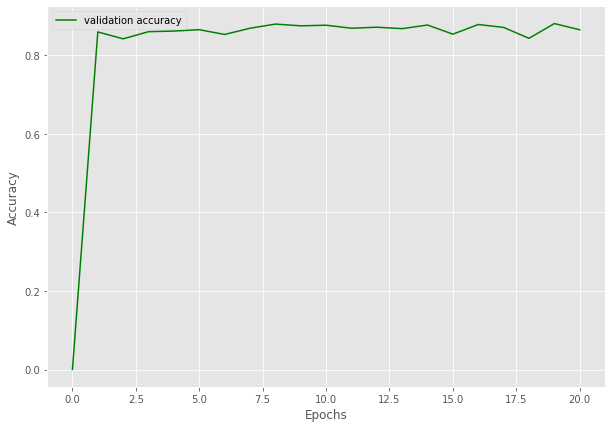

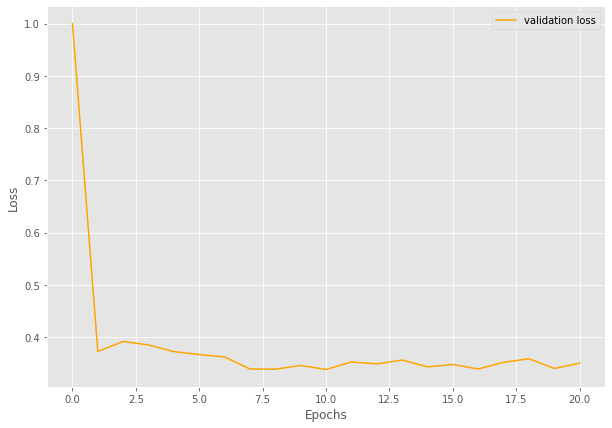

In [15]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(range(len(history)), [x[3] for x in history] , color='green', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('outputs/initial_validation_accuracy.png')
plt.show()
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(range(len(history)), [x[1] for x in history], color='orange', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/initial_training_loss.png')
plt.show()

Comment: 

Loss seems to reach a minimum value on the 10th epoch and then tends to oscillate around that.

It seems reasonable to conclude that more training epochs would not increase the model's performance.

**Print model and optimizer parameters after training**

In [16]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([4096, 9216])
classifier.1.bias 	 torch.Size([4096])
classifier.4.weight 	 torch.Size([1024, 4096])
classifier.4.bias 	 torch.Size([1024])
classifier.6.weight 	 torch.Size([2, 1024])
classifier.6.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {12: {'step': 47280, 'exp_avg': tensor([[ 5.6052e-45, -5.6052e-45,  0.0000e+00,  ...,  0.0000e+00,
          5.6052e-45,  0.0000e+00],
        [-5.6052e-45,  5.6052e-45,  0.0000e+00,  ...,  0.0000e+00,
         -5.6052e-45,  0.0000e+00],
        [ 5.6052e-45,  5.6052e-45,

**Save the model**

In [17]:
# Source:
# https://debuggercafe.com/effective-model-saving-and-resuming-training-in-pytorch/
# save model checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f'outputs/{model_name}_trained.pth')

**Initialize the model before loading the previously saved one**

In [ ]:
if model == alexnet:

    # Initialize the model
    model_loaded = torchvision.models.alexnet(pretrained=True)
    
    # Updating the second classifier
    model_loaded.classifier[4] = nn.Linear(4096,1024)

    # Binary classification , thus only 2 output nodes
    model_loaded.classifier[6] = nn.Linear(1024, num_classes)
    
if model == densenet:
    
    # Optional: load a pretrained DenseNet model.
    model_loaded = torchvision.models.densenet161(pretrained=True)
    
    # Update the classifier layer, in order to output the required number of classes specific to our problem
    # Note: see model.eval() for details of each layer
    model.classifier = nn.Linear(in_features=2208, out_features=num_classes, bias=True)
    
    
# Initialize optimizer  before loading optimizer state_dict
optimizer_loaded = optim.Adam(model_loaded.parameters()) 

    

**Load the saved model**

In [ ]:
# load the model checkpoint
checkpoint = torch.load(f'outputs/{model_name}_trained.pth')

# load model weights state_dict
model_loaded.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')

# load trained optimizer state_dict
optimizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')

epochs = checkpoint['epoch']

# load the criterion
criterion_loaded = checkpoint['loss']
print('Trained model loss function loaded...')

print(f"Previously trained for {epochs} number of epochs...")


**Print loaded model and optimizer parameters**

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_loaded.state_dict():
    print(param_tensor, "\t", model_loaded.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer_loaded.state_dict():
    print(var_name, "\t", optimizer_loaded.state_dict()[var_name])

**Initialize parameters for second phase of training (optional)**

In [ ]:
# learning parameters
batch_size = 64
new_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train for more epochs
epochs = new_epochs
print(f"Train for {epochs} more epochs...")

In [ ]:
history_loaded = []

for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch, epochs))
     
    # Set gradient calculation to ON. Needed during training.
    torch.set_grad_enabled(True)
        
    # Set to training mode
    model_loaded.train()
     
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    # Iterate through all batches of training data
    for i, (inputs, labels) in enumerate(train_data):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        # Clean existing gradients
        optimizer_loaded.zero_grad()
         
        # Forward pass - compute outputs on input data using the model
        outputs = model_loaded(inputs)
        
        # Compute loss
        loss = criterion_loaded(outputs, labels)
         
        # Backpropagate the gradients
        loss.backward()
         
        # Update the parameters
        optimizer_loaded.step()
         
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
         
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)

        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

         
        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        

    # Validation is carried out in each epoch immediately after the training loop
    # Validation - No gradient calculation is needed
    with torch.no_grad():

        # Set to evaluation mode
        model_loaded.eval()

        # Validation loop
        # Iterate through all batches of validation data
        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model_loaded(inputs)

            # Compute loss
            loss = criterion_loaded(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)


            print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/float(train_data_size)

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/float(valid_data_size)

    history_loaded.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, \n Time (train+val): {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))


In [ ]:
# Check if the current model was loaded, or it was just trained. 
# Needed for compatibility with testing stage.
if model_loaded: 
    model = model_loaded

**Evaluate model based on test dataset**

In [18]:
test_start = time.time()

# Loss and Accuracy within the epoch
test_loss = 0.0
test_acc = 0.0

# Initialize an empty tensor. This will store all the predictions and will be used for metrics.
tot_predictions = torch.Tensor()
# Initialize an empty tensor. This will store all the ground truth labels and will be used for metrics.
tot_labels = torch.Tensor()

# Testing - No gradient calculation is needed
with torch.no_grad():

    # Set to evaluation mode
    model.eval()

    # Validation loop
    # Iterate through all batches of test data
    for j, (inputs, labels) in enumerate(test_data):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Add values to ground truth
        tot_labels = torch.cat((tot_labels, labels))

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Compute the total loss for the batch and add it to test_loss
        test_loss += loss.item() * inputs.size(0)

        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        tot_predictions = torch.cat((tot_predictions, predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to test_acc
        test_acc += acc.item() * inputs.size(0)

#             print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))


# Find average testing loss and accuracy
avg_test_loss = test_loss/test_data_size
avg_test_acc = test_acc/float(test_data_size)

accuracy = metrics.accuracy_score(tot_labels.to(device), tot_predictions.to(device))

# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
precision = metrics.precision_score(tot_labels.to(device), tot_predictions.to(device), average='binary')

# The recall is intuitively the ability of the classifier to find all the positive samples.
recall = metrics.recall_score(tot_labels.to(device), tot_predictions.to(device), pos_label=1, average='binary')

# The F1 score can be interpreted as a weighted average of the precision and recall
f1 = metrics.f1_score(tot_labels.to(device), tot_predictions.to(device), average='binary')

# history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

test_end = time.time()
print(f"accuracy = {accuracy}")
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 = {f1}")
print("Test \nLoss : {:.4f}, Accuracy: {:.4f}%, \nTime : {:.4f}s".format(avg_test_loss, avg_test_acc*100, test_end-test_start))

accuracy = 0.8487899268066967
precision = 0.9035268690441104
recall = 0.6759021092084956
f1 = 0.7733120322879005
Test 
Loss : 0.3768, Accuracy: 84.8790%, 
Time : 318.6261s
